<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/PDBBindAdvancedProteinEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyTDC rdkit-pypi torch-geometric pandas tqdm deepchem
# PyTDC: Loading clean DTI datasets (like DAVIS)
# rdkit-pypi: Parsing drug SMILES and converting to molecule graphs
# torch-geometric: Building GNN architecture for drug inputs
# tqdm: Shows real-time progress for preprocessing steps like SMILES parsing)

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# This will give better error messages

In [3]:
!pip install fair-esm biopython torch

In [4]:
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

In [5]:
# Load data set
import deepchem as dc
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    set_name='refined',
    splitter='random',
    reload=True
)
train_dataset, valid_dataset, test_dataset = datasets
print(f"Train dataset length: {len(train_dataset)}\nValidate dataset length: {len(valid_dataset)}\nTest dataset length: {len(test_dataset)}")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Train dataset length: 3881
Validate dataset length: 485
Test dataset length: 486


In [6]:
# Grab tester path files
iterator = 0
for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
    print("Features (X):", X)
    print()
    print(X[0][1])
    print("Label (y):", y)
    print("Weight (w):", w)
    print("ID:", ids)
    iterator += 1
    if iterator == 2:
      break  # Just show the first one

Features (X): [['/tmp/refined-set/1eoc/1eoc_ligand.sdf'
  '/tmp/refined-set/1eoc/1eoc_pocket.pdb']]

/tmp/refined-set/1eoc/1eoc_pocket.pdb
Label (y): [-0.18912133]
Weight (w): [1.]
ID: ['1eoc']
Features (X): [['/tmp/refined-set/4f0c/4f0c_ligand.sdf'
  '/tmp/refined-set/4f0c/4f0c_pocket.pdb']]

/tmp/refined-set/4f0c/4f0c_pocket.pdb
Label (y): [-0.07805682]
Weight (w): [1.]
ID: ['4f0c']


**Preprocessing Functions**

Drug Preprocessing Functions

In [7]:
import torch
import numpy as np
from rdkit import Chem
from torch_geometric.data import Data

def get_node_features(mol):
    all_node_feats = []
    for atom in mol.GetAtoms():
        node_feats = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),  # convert enum to int
            atom.GetIsAromatic(),
            atom.GetTotalNumHs(),
            atom.GetNumRadicalElectrons(),
            atom.IsInRing(),
            int(atom.GetChiralTag())  # convert enum to int
        ]
        all_node_feats.append(node_feats)
    return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol):
    all_edge_feats = []
    for bond in mol.GetBonds():
        edge_feats = [
            bond.GetBondTypeAsDouble(),
            bond.IsInRing()
        ]
        all_edge_feats += [edge_feats, edge_feats]  # Bidirectional edges
    return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]  # Bidirectional edges
    return torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

Protein Preprocessing Functions

In [8]:
# STEP 1: Extract Protein Sequence from PDB (pocket.pdb) File
from Bio import PDB

def extract_sequence_from_pdb(pdb_path):
    """Extracts the amino acid sequence from the associated protein PDB file using Biopython."""

    # Replace 'pocket' with 'protein' in the provided path
    protein_path = pdb_path.replace("pocket", "protein")

    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("full_protein", protein_path)

    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())

    return sequence

In [9]:
# STEP 2: Extract Pocket Sequence from PDB (pocket.pdb) FIle
def extract_pocket_from_pdb(pdb_path):
    "Extracts the amino pocket amino acid sequence from a PDB file using Biopython"
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("pocket_only", pdb_path)

    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())

    return sequence

In [10]:
# STEP 3: Generate ESM-2 Embedddings
# Outputs dense embeddings for each residue reflecting biochemical knolwedge learned from massive sequence databases such as:
# Motifs, functional sites, long-range dependencies, evolutionarly relationships
# This uses a richer protein representation through a pretrained protein language model

import torch
import esm

# Load ESM-2 pretrained model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D() # loads ESM-2 model, defines how amino acids are tokenized
batch_converter = alphabet.get_batch_converter() # creates a function to convert sequences into tokenized tensors
model.eval()  # Disable dropout, puts the model in evaluation mode

def embed_sequence(seq):
    batch_labels, batch_strs, batch_tokens = batch_converter([("protein", seq)])
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=False)
    # Use mean over all residues (excluding padding and BOS/EOS)
    token_representations = results["representations"][6]
    embedding = token_representations[0, 1:len(seq)+1].mean(0) # outputs a single vector representing the whole protein using pretrained 33rd final layer
    return embedding  # shape: (320,) - 1D tensor with 1280 values, one for each learned feature in final transformer layer

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [11]:
# STEP 4: Generate a combined embedding of the concatenated protein and binding site from the PLM

def generate_combined_embedding(pdb_path):
    full_seq = extract_sequence_from_pdb(pdb_path)
    pocket_seq = extract_pocket_from_pdb(pdb_path)

    full_emb = embed_sequence(full_seq)
    pocket_emb = embed_sequence(pocket_seq)

    combined = torch.cat([full_emb, pocket_emb], dim=0)  # shape: (640,)

    # print("Protein Sequence: ", full_seq)
    # print("Pocket Sequence: ", pocket_seq)
    # print(combined)

    return combined

In [12]:
# Function tester
example_protein_path = "/tmp/refined-set/5fnu/5fnu_pocket.pdb"

combined = generate_combined_embedding(example_protein_path)

**Preprocessing the Data Sets**

In [13]:
# Preprocessing Data
def process_deepchem_dataset(dc_dataset):
    molecule_data = []

    for X, y, w, ids in dc_dataset.iterbatches(batch_size=1, deterministic=True):
        ligand_path = X[0][0]
        print(ligand_path)
        protein_path = X[0][1]
        print(protein_path)

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))

        if ligand_mol is None:
          print(f"Failed to load ligand molecule from {ligand_path}")
          continue  # Skip this sample

        node_feats = get_node_features(ligand_mol)
        edge_feats = get_edge_features(ligand_mol)
        edge_index = get_adjacency_info(ligand_mol)


        target_features = generate_combined_embedding(protein_path)
        target_features = target_features.unsqueeze(0) # (1, 640)

        data = Data(
            x=node_feats,
            edge_index=edge_index,
            edge_attr=edge_feats,
            y=torch.tensor(y, dtype=torch.float)
        )
        data.target_features = target_features

        molecule_data.append(data)

    return molecule_data

In [14]:
# Embed each dataset with preprocessing algorithms
train_graphs = process_deepchem_dataset(train_dataset)
valid_graphs = process_deepchem_dataset(valid_dataset)
test_graphs = process_deepchem_dataset(test_dataset)

# Create DataLoaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

/tmp/refined-set/1eoc/1eoc_ligand.sdf
/tmp/refined-set/1eoc/1eoc_pocket.pdb


[14:30:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f0c/4f0c_ligand.sdf
/tmp/refined-set/4f0c/4f0c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f0c/4f0c_ligand.sdf
/tmp/refined-set/1w0z/1w0z_ligand.sdf
/tmp/refined-set/1w0z/1w0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w0z/1w0z_ligand.sdf
/tmp/refined-set/4i8z/4i8z_ligand.sdf
/tmp/refined-set/4i8z/4i8z_pocket.pdb


[14:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:30:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:30:57] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4e67/4e67_ligand.sdf
/tmp/refined-set/4e67/4e67_pocket.pdb


[14:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kfq/4kfq_ligand.sdf
/tmp/refined-set/4kfq/4kfq_pocket.pdb


[14:30:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4rfm/4rfm_ligand.sdf
/tmp/refined-set/4rfm/4rfm_pocket.pdb
/tmp/refined-set/4bak/4bak_ligand.sdf
/tmp/refined-set/4bak/4bak_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bak/4bak_ligand.sdf
/tmp/refined-set/5u28/5u28_ligand.sdf
/tmp/refined-set/5u28/5u28_pocket.pdb


[14:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:30:58] Explicit valence for atom # 32 N, 4, is greater than permitted
[14:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zn7/2zn7_ligand.sdf
/tmp/refined-set/2zn7/2zn7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zn7/2zn7_ligand.sdf
/tmp/refined-set/1fhd/1fhd_ligand.sdf
/tmp/refined-set/1fhd/1fhd_pocket.pdb


[14:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:30:58] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qm9/2qm9_ligand.sdf
/tmp/refined-set/2qm9/2qm9_pocket.pdb
/tmp/refined-set/4b74/4b74_ligand.sdf
/tmp/refined-set/4b74/4b74_pocket.pdb


[14:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:30:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b5i/1b5i_ligand.sdf
/tmp/refined-set/1b5i/1b5i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b5i/1b5i_ligand.sdf
/tmp/refined-set/4km2/4km2_ligand.sdf
/tmp/refined-set/4km2/4km2_pocket.pdb
/tmp/refined-set/1ctu/1ctu_ligand.sdf
/tmp/refined-set/1ctu/1ctu_pocket.pdb


[14:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:01] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ikd/3ikd_ligand.sdf
/tmp/refined-set/3ikd/3ikd_pocket.pdb
/tmp/refined-set/2ya6/2ya6_ligand.sdf
/tmp/refined-set/2ya6/2ya6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ya6/2ya6_ligand.sdf
/tmp/refined-set/4jz1/4jz1_ligand.sdf
/tmp/refined-set/4jz1/4jz1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jz1/4jz1_ligand.sdf
/tmp/refined-set/1jmf/1jmf_ligand.sdf
/tmp/refined-set/1jmf/1jmf_pocket.pdb


[14:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:01] Explicit valence for atom # 19 N, 4, is greater than permitted
[14:31:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ihj/2ihj_ligand.sdf
/tmp/refined-set/2ihj/2ihj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ihj/2ihj_ligand.sdf
/tmp/refined-set/5nkg/5nkg_ligand.sdf
/tmp/refined-set/5nkg/5nkg_pocket.pdb
/tmp/refined-set/3g2z/3g2z_ligand.sdf
/tmp/refined-set/3g2z/3g2z_pocket.pdb


[14:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:03] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5l30/5l30_ligand.sdf
/tmp/refined-set/5l30/5l30_pocket.pdb


[14:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6d5h/6d5h_ligand.sdf
/tmp/refined-set/6d5h/6d5h_pocket.pdb


[14:31:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ork/5ork_ligand.sdf
/tmp/refined-set/5ork/5ork_pocket.pdb


[14:31:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dzy/4dzy_ligand.sdf
/tmp/refined-set/4dzy/4dzy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dzy/4dzy_ligand.sdf
/tmp/refined-set/5d3c/5d3c_ligand.sdf
/tmp/refined-set/5d3c/5d3c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5d3c/5d3c_ligand.sdf
/tmp/refined-set/1kpm/1kpm_ligand.sdf
/tmp/refined-set/1kpm/1kpm_pocket.pdb
/tmp/refined-set/4mrz/4mrz_ligand.sdf
/tmp/refined-set/4mrz/4mrz_pocket.pdb


[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:05] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:05] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kdk/1kdk_ligand.sdf
/tmp/refined-set/1kdk/1kdk_pocket.pdb


[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fzo/1fzo_ligand.sdf
/tmp/refined-set/1fzo/1fzo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fzo/1fzo_ligand.sdf
/tmp/refined-set/5nk2/5nk2_ligand.sdf
/tmp/refined-set/5nk2/5nk2_pocket.pdb
/tmp/refined-set/1h22/1h22_ligand.sdf
/tmp/refined-set/1h22/1h22_pocket.pdb


[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:05] Explicit valence for atom # 61 C, 6, is greater than permitted
[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o6w/4o6w_ligand.sdf
/tmp/refined-set/4o6w/4o6w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o6w/4o6w_ligand.sdf
/tmp/refined-set/4rux/4rux_ligand.sdf
/tmp/refined-set/4rux/4rux_pocket.pdb
/tmp/refined-set/3m3z/3m3z_ligand.sdf
/tmp/refined-set/3m3z/3m3z_pocket.pdb


[14:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:06] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xy8/4xy8_ligand.sdf
/tmp/refined-set/4xy8/4xy8_pocket.pdb
/tmp/refined-set/6fnq/6fnq_ligand.sdf
/tmp/refined-set/6fnq/6fnq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fnq/6fnq_ligand.sdf
/tmp/refined-set/6e9a/6e9a_ligand.sdf
/tmp/refined-set/6e9a/6e9a_pocket.pdb


[14:31:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qgw/3qgw_ligand.sdf
/tmp/refined-set/3qgw/3qgw_pocket.pdb
/tmp/refined-set/2gst/2gst_ligand.sdf
/tmp/refined-set/2gst/2gst_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2gst/2gst_ligand.sdf
/tmp/refined-set/2aoe/2aoe_ligand.sdf
/tmp/refined-set/2aoe/2aoe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2aoe/2aoe_ligand.sdf
/tmp/refined-set/5chk/5chk_ligand.sdf
/tmp/refined-set/5chk/5chk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5chk/5chk_ligand.sdf
/tmp/refined-set/4mmp/4mmp_ligand.sdf
/tmp/refined-set/4mmp/4mmp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mmp/4mmp_ligand.sdf
/tmp/refined-set/4q9o/4q9o_ligand.sdf
/tmp/refined-set/4q9o/4q9o_pocket.pdb


[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ban/4ban_ligand.sdf
/tmp/refined-set/4ban/4ban_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ban/4ban_ligand.sdf
/tmp/refined-set/4c52/4c52_ligand.sdf
/tmp/refined-set/4c52/4c52_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4c52/4c52_ligand.sdf
/tmp/refined-set/1f8e/1f8e_ligand.sdf
/tmp/refined-set/1f8e/1f8e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8e/1f8e_ligand.sdf
/tmp/refined-set/4jfm/4jfm_ligand.sdf
/tmp/refined-set/4jfm/4jfm_pocket.pdb
/tmp/refined-set/2oym/2oym_ligand.sdf
/tmp/refined-set/2oym/2oym_pocket.pdb


[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4djw/4djw_ligand.sdf
/tmp/refined-set/4djw/4djw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4djw/4djw_ligand.sdf
/tmp/refined-set/2gj5/2gj5_ligand.sdf
/tmp/refined-set/2gj5/2gj5_pocket.pdb
/tmp/refined-set/5yhg/5yhg_ligand.sdf
/tmp/refined-set/5yhg/5yhg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yhg/5yhg_ligand.sdf
/tmp/refined-set/2e94/2e94_ligand.sdf
/tmp/refined-set/2e94/2e94_pocket.pdb


[14:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:08] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:31:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4j7d/4j7d_ligand.sdf
/tmp/refined-set/4j7d/4j7d_pocket.pdb
/tmp/refined-set/5a6k/5a6k_ligand.sdf
/tmp/refined-set/5a6k/5a6k_pocket.pdb


[14:31:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ok9/3ok9_ligand.sdf
/tmp/refined-set/3ok9/3ok9_pocket.pdb


[14:31:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w3l/1w3l_ligand.sdf
/tmp/refined-set/1w3l/1w3l_pocket.pdb
/tmp/refined-set/2p7z/2p7z_ligand.sdf
/tmp/refined-set/2p7z/2p7z_pocket.pdb


[14:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xde/2xde_ligand.sdf
/tmp/refined-set/2xde/2xde_pocket.pdb
/tmp/refined-set/1mtr/1mtr_ligand.sdf
/tmp/refined-set/1mtr/1mtr_pocket.pdb


[14:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ecv/1ecv_ligand.sdf
/tmp/refined-set/1ecv/1ecv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ecv/1ecv_ligand.sdf
/tmp/refined-set/3mhm/3mhm_ligand.sdf
/tmp/refined-set/3mhm/3mhm_pocket.pdb
/tmp/refined-set/1bcd/1bcd_ligand.sdf
/tmp/refined-set/1bcd/1bcd_pocket.pdb


[14:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:13] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m7y/1m7y_ligand.sdf
/tmp/refined-set/1m7y/1m7y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m7y/1m7y_ligand.sdf
/tmp/refined-set/1f0t/1f0t_ligand.sdf
/tmp/refined-set/1f0t/1f0t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f0t/1f0t_ligand.sdf
/tmp/refined-set/3da9/3da9_ligand.sdf
/tmp/refined-set/3da9/3da9_pocket.pdb
/tmp/refined-set/2bvr/2bvr_ligand.sdf
/tmp/refined-set/2bvr/2bvr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bvr/2bvr_ligand.sdf
/tmp/refined-set/5twj/5twj_ligand.sdf
/tmp/refined-set/5twj/5twj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5twj/5twj_ligand.sdf
/tmp/refined-set/5ucj/5ucj_ligand.sdf
/tmp/refined-set/5ucj/5ucj_pocket.pdb


[14:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:14] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:14] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:14] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:14] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:31:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jq5/5jq5_ligand.sdf
/tmp/refined-set/5jq5/5jq5_pocket.pdb
/tmp/refined-set/4knn/4knn_ligand.sdf
/tmp/refined-set/4knn/4knn_pocket.pdb


[14:31:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gwv/1gwv_ligand.sdf
/tmp/refined-set/1gwv/1gwv_pocket.pdb
/tmp/refined-set/1ax0/1ax0_ligand.sdf
/tmp/refined-set/1ax0/1ax0_pocket.pdb


[14:31:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xo8/4xo8_ligand.sdf
/tmp/refined-set/4xo8/4xo8_pocket.pdb
/tmp/refined-set/4wop/4wop_ligand.sdf
/tmp/refined-set/4wop/4wop_pocket.pdb


[14:31:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f3c/4f3c_ligand.sdf
/tmp/refined-set/4f3c/4f3c_pocket.pdb


[14:31:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zym/2zym_ligand.sdf
/tmp/refined-set/2zym/2zym_pocket.pdb


[14:31:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5m7s/5m7s_ligand.sdf
/tmp/refined-set/5m7s/5m7s_pocket.pdb


[14:31:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2iko/2iko_ligand.sdf
/tmp/refined-set/2iko/2iko_pocket.pdb


[14:31:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gg4/6gg4_ligand.sdf
/tmp/refined-set/6gg4/6gg4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gg4/6gg4_ligand.sdf
/tmp/refined-set/4x6m/4x6m_ligand.sdf
/tmp/refined-set/4x6m/4x6m_pocket.pdb
/tmp/refined-set/1utn/1utn_ligand.sdf
/tmp/refined-set/1utn/1utn_pocket.pdb


[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4j22/4j22_ligand.sdf
/tmp/refined-set/4j22/4j22_pocket.pdb
/tmp/refined-set/1nh0/1nh0_ligand.sdf
/tmp/refined-set/1nh0/1nh0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nh0/1nh0_ligand.sdf
/tmp/refined-set/2xei/2xei_ligand.sdf
/tmp/refined-set/2xei/2xei_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xei/2xei_ligand.sdf
/tmp/refined-set/5nwi/5nwi_ligand.sdf
/tmp/refined-set/5nwi/5nwi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nwi/5nwi_ligand.sdf
/tmp/refined-set/3ldp/3ldp_ligand.sdf
/tmp/refined-set/3ldp/3ldp_pocket.pdb


[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:23] Explicit valence for atom # 40 C, 6, is greater than permitted
[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:23] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:23] Explicit valence for atom # 41 C, 6, is greater than permitted
[14:31:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rke/2rke_ligand.sdf
/tmp/refined-set/2rke/2rke_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rke/2rke_ligand.sdf
/tmp/refined-set/5mks/5mks_ligand.sdf
/tmp/refined-set/5mks/5mks_pocket.pdb


[14:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:24] Explicit valence for atom # 1 S, 7, is greater than permitted
[14:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fl3/1fl3_ligand.sdf
/tmp/refined-set/1fl3/1fl3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fl3/1fl3_ligand.sdf
/tmp/refined-set/1eb2/1eb2_ligand.sdf
/tmp/refined-set/1eb2/1eb2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1eb2/1eb2_ligand.sdf
/tmp/refined-set/2e2p/2e2p_ligand.sdf
/tmp/refined-set/2e2p/2e2p_pocket.pdb


[14:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:24] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:24] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6f20/6f20_ligand.sdf
/tmp/refined-set/6f20/6f20_pocket.pdb
/tmp/refined-set/5d3l/5d3l_ligand.sdf
/tmp/refined-set/5d3l/5d3l_pocket.pdb
/tmp/refined-set/1b57/1b57_ligand.sdf
/tmp/refined-set/1b57/1b57_pocket.pdb


[14:31:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wej/2wej_ligand.sdf
/tmp/refined-set/2wej/2wej_pocket.pdb
/tmp/refined-set/5os2/5os2_ligand.sdf
/tmp/refined-set/5os2/5os2_pocket.pdb


[14:31:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5bwc/5bwc_ligand.sdf
/tmp/refined-set/5bwc/5bwc_pocket.pdb


[14:31:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fx6/3fx6_ligand.sdf
/tmp/refined-set/3fx6/3fx6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fx6/3fx6_ligand.sdf
/tmp/refined-set/2pou/2pou_ligand.sdf
/tmp/refined-set/2pou/2pou_pocket.pdb
/tmp/refined-set/1hsh/1hsh_ligand.sdf
/tmp/refined-set/1hsh/1hsh_pocket.pdb


[14:31:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:27] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:31:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zl4/4zl4_ligand.sdf
/tmp/refined-set/4zl4/4zl4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zl4/4zl4_ligand.sdf
/tmp/refined-set/3rux/3rux_ligand.sdf
/tmp/refined-set/3rux/3rux_pocket.pdb
/tmp/refined-set/6f9g/6f9g_ligand.sdf
/tmp/refined-set/6f9g/6f9g_pocket.pdb


[14:31:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:27] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:31:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3o9d/3o9d_ligand.sdf
/tmp/refined-set/3o9d/3o9d_pocket.pdb
/tmp/refined-set/3qdd/3qdd_ligand.sdf
/tmp/refined-set/3qdd/3qdd_pocket.pdb


[14:31:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3shc/3shc_ligand.sdf
/tmp/refined-set/3shc/3shc_pocket.pdb
/tmp/refined-set/3wvm/3wvm_ligand.sdf
/tmp/refined-set/3wvm/3wvm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3wvm/3wvm_ligand.sdf
/tmp/refined-set/1fh9/1fh9_ligand.sdf
/tmp/refined-set/1fh9/1fh9_pocket.pdb


[14:31:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c5s/1c5s_ligand.sdf
/tmp/refined-set/1c5s/1c5s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5s/1c5s_ligand.sdf
/tmp/refined-set/3rsx/3rsx_ligand.sdf
/tmp/refined-set/3rsx/3rsx_pocket.pdb


[14:31:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:28] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:31:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1epo/1epo_ligand.sdf
/tmp/refined-set/1epo/1epo_pocket.pdb


[14:31:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3k4d/3k4d_ligand.sdf
/tmp/refined-set/3k4d/3k4d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3k4d/3k4d_ligand.sdf
/tmp/refined-set/3a2o/3a2o_ligand.sdf
/tmp/refined-set/3a2o/3a2o_pocket.pdb
/tmp/refined-set/1hi3/1hi3_ligand.sdf
/tmp/refined-set/1hi3/1hi3_pocket.pdb


[14:31:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2flr/2flr_ligand.sdf
/tmp/refined-set/2flr/2flr_pocket.pdb


[14:31:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6d56/6d56_ligand.sdf
/tmp/refined-set/6d56/6d56_pocket.pdb


[14:31:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1uj5/1uj5_ligand.sdf
/tmp/refined-set/1uj5/1uj5_pocket.pdb
/tmp/refined-set/1o35/1o35_ligand.sdf
/tmp/refined-set/1o35/1o35_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o35/1o35_ligand.sdf
/tmp/refined-set/3f7i/3f7i_ligand.sdf
/tmp/refined-set/3f7i/3f7i_pocket.pdb


[14:31:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:31:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dq2/4dq2_ligand.sdf
/tmp/refined-set/4dq2/4dq2_pocket.pdb


[14:31:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fhm/5fhm_ligand.sdf
/tmp/refined-set/5fhm/5fhm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fhm/5fhm_ligand.sdf
/tmp/refined-set/1h2t/1h2t_ligand.sdf
/tmp/refined-set/1h2t/1h2t_pocket.pdb


[14:31:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:31] Explicit valence for atom # 20 C, 5, is greater than permitted
[14:31:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cdl/6cdl_ligand.sdf
/tmp/refined-set/6cdl/6cdl_pocket.pdb
/tmp/refined-set/5dqc/5dqc_ligand.sdf
/tmp/refined-set/5dqc/5dqc_pocket.pdb


[14:31:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mhz/4mhz_ligand.sdf
/tmp/refined-set/4mhz/4mhz_pocket.pdb


[14:31:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f1x/5f1x_ligand.sdf
/tmp/refined-set/5f1x/5f1x_pocket.pdb


[14:31:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ihh/5ihh_ligand.sdf
/tmp/refined-set/5ihh/5ihh_pocket.pdb


[14:31:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hb1/2hb1_ligand.sdf
/tmp/refined-set/2hb1/2hb1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hb1/2hb1_ligand.sdf
/tmp/refined-set/2r0z/2r0z_ligand.sdf
/tmp/refined-set/2r0z/2r0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r0z/2r0z_ligand.sdf
/tmp/refined-set/6ezq/6ezq_ligand.sdf
/tmp/refined-set/6ezq/6ezq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ezq/6ezq_ligand.sdf
/tmp/refined-set/4q4q/4q4q_ligand.sdf
/tmp/refined-set/4q4q/4q4q_pocket.pdb


[14:31:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:34] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:31:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:34] Explicit valence for atom # 32 N, 4, is greater than permitted
[14:31:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:34] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:31:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ht1/6ht1_ligand.sdf
/tmp/refined-set/6ht1/6ht1_pocket.pdb
/tmp/refined-set/4buq/4buq_ligand.sdf
/tmp/refined-set/4buq/4buq_pocket.pdb


[14:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yxj/2yxj_ligand.sdf
/tmp/refined-set/2yxj/2yxj_pocket.pdb
/tmp/refined-set/3lp7/3lp7_ligand.sdf
/tmp/refined-set/3lp7/3lp7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lp7/3lp7_ligand.sdf
/tmp/refined-set/3bxf/3bxf_ligand.sdf
/tmp/refined-set/3bxf/3bxf_pocket.pdb


[14:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:35] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:31:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b5j/1b5j_ligand.sdf
/tmp/refined-set/1b5j/1b5j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b5j/1b5j_ligand.sdf
/tmp/refined-set/3prs/3prs_ligand.sdf
/tmp/refined-set/3prs/3prs_pocket.pdb


[14:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:36] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:31:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hwv/5hwv_ligand.sdf
/tmp/refined-set/5hwv/5hwv_pocket.pdb
/tmp/refined-set/1pkx/1pkx_ligand.sdf
/tmp/refined-set/1pkx/1pkx_pocket.pdb


[14:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tmk/4tmk_ligand.sdf
/tmp/refined-set/4tmk/4tmk_pocket.pdb
/tmp/refined-set/1dar/1dar_ligand.sdf
/tmp/refined-set/1dar/1dar_pocket.pdb


[14:31:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kug/1kug_ligand.sdf
/tmp/refined-set/1kug/1kug_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kug/1kug_ligand.sdf
/tmp/refined-set/3zi0/3zi0_ligand.sdf
/tmp/refined-set/3zi0/3zi0_pocket.pdb


[14:31:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:39] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:31:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nhz/1nhz_ligand.sdf
/tmp/refined-set/1nhz/1nhz_pocket.pdb
/tmp/refined-set/4fl1/4fl1_ligand.sdf
/tmp/refined-set/4fl1/4fl1_pocket.pdb


[14:31:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3n3g/3n3g_ligand.sdf
/tmp/refined-set/3n3g/3n3g_pocket.pdb
/tmp/refined-set/1fh8/1fh8_ligand.sdf
/tmp/refined-set/1fh8/1fh8_pocket.pdb


[14:31:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5os5/5os5_ligand.sdf
/tmp/refined-set/5os5/5os5_pocket.pdb
/tmp/refined-set/5ny3/5ny3_ligand.sdf
/tmp/refined-set/5ny3/5ny3_pocket.pdb


[14:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o07/5o07_ligand.sdf
/tmp/refined-set/5o07/5o07_pocket.pdb
/tmp/refined-set/1b38/1b38_ligand.sdf
/tmp/refined-set/1b38/1b38_pocket.pdb


[14:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g8n/4g8n_ligand.sdf
/tmp/refined-set/4g8n/4g8n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g8n/4g8n_ligand.sdf
/tmp/refined-set/2f1g/2f1g_ligand.sdf
/tmp/refined-set/2f1g/2f1g_pocket.pdb
/tmp/refined-set/3iod/3iod_ligand.sdf
/tmp/refined-set/3iod/3iod_pocket.pdb


[14:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3a6t/3a6t_ligand.sdf
/tmp/refined-set/3a6t/3a6t_pocket.pdb
/tmp/refined-set/5ijr/5ijr_ligand.sdf
/tmp/refined-set/5ijr/5ijr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ijr/5ijr_ligand.sdf
/tmp/refined-set/4djy/4djy_ligand.sdf
/tmp/refined-set/4djy/4djy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4djy/4djy_ligand.sdf
/tmp/refined-set/4cd4/4cd4_ligand.sdf
/tmp/refined-set/4cd4/4cd4_pocket.pdb


[14:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:42] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:42] Explicit valence for atom # 13 N, 4, is greater than permitted
[14:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t0x/3t0x_ligand.sdf
/tmp/refined-set/3t0x/3t0x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t0x/3t0x_ligand.sdf
/tmp/refined-set/4bcn/4bcn_ligand.sdf
/tmp/refined-set/4bcn/4bcn_pocket.pdb


[14:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:42] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:31:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nz4/5nz4_ligand.sdf
/tmp/refined-set/5nz4/5nz4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nz4/5nz4_ligand.sdf
/tmp/refined-set/1ydb/1ydb_ligand.sdf
/tmp/refined-set/1ydb/1ydb_pocket.pdb
/tmp/refined-set/5etj/5etj_ligand.sdf
/tmp/refined-set/5etj/5etj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5etj/5etj_ligand.sdf
/tmp/refined-set/2v88/2v88_ligand.sdf
/tmp/refined-set/2v88/2v88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v88/2v88_ligand.sdf
/tmp/refined-set/6cvv/6cvv_ligand.sdf
/tmp/refined-set/6cvv/6cvv_pocket.pdb


[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fck/5fck_ligand.sdf
/tmp/refined-set/5fck/5fck_pocket.pdb
/tmp/refined-set/3agl/3agl_ligand.sdf
/tmp/refined-set/3agl/3agl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3agl/3agl_ligand.sdf
/tmp/refined-set/4b5s/4b5s_ligand.sdf
/tmp/refined-set/4b5s/4b5s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b5s/4b5s_ligand.sdf
/tmp/refined-set/1iih/1iih_ligand.sdf
/tmp/refined-set/1iih/1iih_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1iih/1iih_ligand.sdf
/tmp/refined-set/5ioz/5ioz_ligand.sdf
/tmp/refined-set/5ioz/5ioz_pocket.pdb


[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Explicit valence for atom # 45 N, 4, is greater than permitted
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:43] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gcu/3gcu_ligand.sdf
/tmp/refined-set/3gcu/3gcu_pocket.pdb


[14:31:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3drg/3drg_ligand.sdf
/tmp/refined-set/3drg/3drg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3drg/3drg_ligand.sdf
/tmp/refined-set/3rbu/3rbu_ligand.sdf
/tmp/refined-set/3rbu/3rbu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rbu/3rbu_ligand.sdf
/tmp/refined-set/6ced/6ced_ligand.sdf
/tmp/refined-set/6ced/6ced_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ced/6ced_ligand.sdf
/tmp/refined-set/2fzg/2fzg_ligand.sdf
/tmp/refined-set/2fzg/2fzg_pocket.pdb


[14:31:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:44] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:31:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:31:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:44] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:31:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zdk/2zdk_ligand.sdf
/tmp/refined-set/2zdk/2zdk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zdk/2zdk_ligand.sdf
/tmp/refined-set/4qem/4qem_ligand.sdf
/tmp/refined-set/4qem/4qem_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qem/4qem_ligand.sdf
/tmp/refined-set/1qf1/1qf1_ligand.sdf
/tmp/refined-set/1qf1/1qf1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qf1/1qf1_ligand.sdf
/tmp/refined-set/3fvl/3fvl_ligand.sdf
/tmp/refined-set/3fvl/3fvl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fvl/3fvl_ligand.sdf
/tmp/refined-set/3hl8/3hl8_ligand.sdf
/tmp/refined-set/3hl8/3hl8_pocket.pdb


[14:31:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:31:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:54] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:31:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:54] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:31:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ngm/4ngm_ligand.sdf
/tmp/refined-set/4ngm/4ngm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ngm/4ngm_ligand.sdf
/tmp/refined-set/1b6k/1b6k_ligand.sdf
/tmp/refined-set/1b6k/1b6k_pocket.pdb
/tmp/refined-set/3qbc/3qbc_ligand.sdf
/tmp/refined-set/3qbc/3qbc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qbc/3qbc_ligand.sdf
/tmp/refined-set/1lgt/1lgt_ligand.sdf
/tmp/refined-set/1lgt/1lgt_pocket.pdb


[14:31:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:31:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:31:55] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:31:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2clh/2clh_ligand.sdf
/tmp/refined-set/2clh/2clh_pocket.pdb


[14:32:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sqt/1sqt_ligand.sdf
/tmp/refined-set/1sqt/1sqt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sqt/1sqt_ligand.sdf
/tmp/refined-set/3ip9/3ip9_ligand.sdf
/tmp/refined-set/3ip9/3ip9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip9/3ip9_ligand.sdf
/tmp/refined-set/4j48/4j48_ligand.sdf
/tmp/refined-set/4j48/4j48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4j48/4j48_ligand.sdf
/tmp/refined-set/4tt2/4tt2_ligand.sdf
/tmp/refined-set/4tt2/4tt2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tt2/4tt2_ligand.sdf
/tmp/refined-set/6eq1/6eq1_ligand.sdf
/tmp/refined-set/6eq1/6eq1_pocket.pdb


[14:32:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:32:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:03] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:32:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:03] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:32:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:03] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:32:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5odx/5odx_ligand.sdf
/tmp/refined-set/5odx/5odx_pocket.pdb
/tmp/refined-set/4qf8/4qf8_ligand.sdf
/tmp/refined-set/4qf8/4qf8_pocket.pdb


[14:32:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4llj/4llj_ligand.sdf
/tmp/refined-set/4llj/4llj_pocket.pdb
/tmp/refined-set/4ngn/4ngn_ligand.sdf
/tmp/refined-set/4ngn/4ngn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ngn/4ngn_ligand.sdf
/tmp/refined-set/3ibi/3ibi_ligand.sdf
/tmp/refined-set/3ibi/3ibi_pocket.pdb


[14:32:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:05] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fys/4fys_ligand.sdf
/tmp/refined-set/4fys/4fys_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fys/4fys_ligand.sdf
/tmp/refined-set/1n4h/1n4h_ligand.sdf
/tmp/refined-set/1n4h/1n4h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1n4h/1n4h_ligand.sdf
/tmp/refined-set/2xg9/2xg9_ligand.sdf
/tmp/refined-set/2xg9/2xg9_pocket.pdb


[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:05] Explicit valence for atom # 46 C, 6, is greater than permitted
[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:05] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bi6/4bi6_ligand.sdf
/tmp/refined-set/4bi6/4bi6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bi6/4bi6_ligand.sdf
/tmp/refined-set/2h15/2h15_ligand.sdf
/tmp/refined-set/2h15/2h15_pocket.pdb
/tmp/refined-set/4jpx/4jpx_ligand.sdf
/tmp/refined-set/4jpx/4jpx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jpx/4jpx_ligand.sdf
/tmp/refined-set/3f16/3f16_ligand.sdf
/tmp/refined-set/3f16/3f16_pocket.pdb


[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:05] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ru1/3ru1_ligand.sdf
/tmp/refined-set/3ru1/3ru1_pocket.pdb


[14:32:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1li3/1li3_ligand.sdf
/tmp/refined-set/1li3/1li3_pocket.pdb
/tmp/refined-set/3ehy/3ehy_ligand.sdf
/tmp/refined-set/3ehy/3ehy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ehy/3ehy_ligand.sdf
/tmp/refined-set/5mnn/5mnn_ligand.sdf
/tmp/refined-set/5mnn/5mnn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5mnn/5mnn_ligand.sdf
/tmp/refined-set/4ht0/4ht0_ligand.sdf
/tmp/refined-set/4ht0/4ht0_pocket.pdb


[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:06] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:06] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5k0h/5k0h_ligand.sdf
/tmp/refined-set/5k0h/5k0h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5k0h/5k0h_ligand.sdf
/tmp/refined-set/4c5d/4c5d_ligand.sdf
/tmp/refined-set/4c5d/4c5d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4c5d/4c5d_ligand.sdf
/tmp/refined-set/3k97/3k97_ligand.sdf
/tmp/refined-set/3k97/3k97_pocket.pdb
/tmp/refined-set/1pph/1pph_ligand.sdf
/tmp/refined-set/1pph/1pph_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pph/1pph_ligand.sdf
/tmp/refined-set/4ih7/4ih7_ligand.sdf
/tmp/refined-set/4ih7/4ih7_pocket.pdb


[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:06] Explicit valence for atom # 12 N, 4, is greater than permitted
[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:06] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:06] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:32:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2d3z/2d3z_ligand.sdf
/tmp/refined-set/2d3z/2d3z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d3z/2d3z_ligand.sdf
/tmp/refined-set/4nkt/4nkt_ligand.sdf
/tmp/refined-set/4nkt/4nkt_pocket.pdb


[14:32:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:07] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:32:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gy7/3gy7_ligand.sdf
/tmp/refined-set/3gy7/3gy7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gy7/3gy7_ligand.sdf
/tmp/refined-set/4rfr/4rfr_ligand.sdf
/tmp/refined-set/4rfr/4rfr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4rfr/4rfr_ligand.sdf
/tmp/refined-set/3hww/3hww_ligand.sdf
/tmp/refined-set/3hww/3hww_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hww/3hww_ligand.sdf
/tmp/refined-set/4c6u/4c6u_ligand.sdf
/tmp/refined-set/4c6u/4c6u_pocket.pdb


[14:32:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:08] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:32:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:08] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:32:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:32:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1yq7/1yq7_ligand.sdf
/tmp/refined-set/1yq7/1yq7_pocket.pdb


[14:32:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5u0f/5u0f_ligand.sdf
/tmp/refined-set/5u0f/5u0f_pocket.pdb
/tmp/refined-set/5ji8/5ji8_ligand.sdf
/tmp/refined-set/5ji8/5ji8_pocket.pdb


[14:32:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1zp8/1zp8_ligand.sdf
/tmp/refined-set/1zp8/1zp8_pocket.pdb
/tmp/refined-set/4rqv/4rqv_ligand.sdf
/tmp/refined-set/4rqv/4rqv_pocket.pdb


[14:32:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1wn6/1wn6_ligand.sdf
/tmp/refined-set/1wn6/1wn6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wn6/1wn6_ligand.sdf
/tmp/refined-set/2q6f/2q6f_ligand.sdf
/tmp/refined-set/2q6f/2q6f_pocket.pdb


[14:32:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:10] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:32:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d2r/5d2r_ligand.sdf
/tmp/refined-set/5d2r/5d2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5d2r/5d2r_ligand.sdf
/tmp/refined-set/4urz/4urz_ligand.sdf
/tmp/refined-set/4urz/4urz_pocket.pdb


[14:32:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:10] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:32:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2za0/2za0_ligand.sdf
/tmp/refined-set/2za0/2za0_pocket.pdb


[14:32:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5u0g/5u0g_ligand.sdf
/tmp/refined-set/5u0g/5u0g_pocket.pdb


[14:32:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gzd/6gzd_ligand.sdf
/tmp/refined-set/6gzd/6gzd_pocket.pdb


[14:32:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j6m/5j6m_ligand.sdf
/tmp/refined-set/5j6m/5j6m_pocket.pdb


[14:32:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g35/1g35_ligand.sdf
/tmp/refined-set/1g35/1g35_pocket.pdb


[14:32:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5uoo/5uoo_ligand.sdf
/tmp/refined-set/5uoo/5uoo_pocket.pdb
/tmp/refined-set/1zdp/1zdp_ligand.sdf
/tmp/refined-set/1zdp/1zdp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1zdp/1zdp_ligand.sdf
/tmp/refined-set/5t9w/5t9w_ligand.sdf
/tmp/refined-set/5t9w/5t9w_pocket.pdb
/tmp/refined-set/2fzc/2fzc_ligand.sdf
/tmp/refined-set/2fzc/2fzc_pocket.pdb


[14:32:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:13] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:32:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u1b/4u1b_ligand.sdf
/tmp/refined-set/4u1b/4u1b_pocket.pdb
/tmp/refined-set/4n07/4n07_ligand.sdf
/tmp/refined-set/4n07/4n07_pocket.pdb


[14:32:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hcy/5hcy_ligand.sdf
/tmp/refined-set/5hcy/5hcy_pocket.pdb


[14:32:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ppl/1ppl_ligand.sdf
/tmp/refined-set/1ppl/1ppl_pocket.pdb


[14:32:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fcq/3fcq_ligand.sdf
/tmp/refined-set/3fcq/3fcq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fcq/3fcq_ligand.sdf
/tmp/refined-set/1if7/1if7_ligand.sdf
/tmp/refined-set/1if7/1if7_pocket.pdb


[14:32:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:23] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:32:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3jya/3jya_ligand.sdf
/tmp/refined-set/3jya/3jya_pocket.pdb


[14:32:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2v8w/2v8w_ligand.sdf
/tmp/refined-set/2v8w/2v8w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v8w/2v8w_ligand.sdf
/tmp/refined-set/5ulp/5ulp_ligand.sdf
/tmp/refined-set/5ulp/5ulp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ulp/5ulp_ligand.sdf
/tmp/refined-set/2csn/2csn_ligand.sdf
/tmp/refined-set/2csn/2csn_pocket.pdb


[14:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:24] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:24] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a95/4a95_ligand.sdf
/tmp/refined-set/4a95/4a95_pocket.pdb


[14:32:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bc5/4bc5_ligand.sdf
/tmp/refined-set/4bc5/4bc5_pocket.pdb


[14:32:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tkj/4tkj_ligand.sdf
/tmp/refined-set/4tkj/4tkj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tkj/4tkj_ligand.sdf
/tmp/refined-set/2xii/2xii_ligand.sdf
/tmp/refined-set/2xii/2xii_pocket.pdb


[14:32:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:32:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1rnm/1rnm_ligand.sdf
/tmp/refined-set/1rnm/1rnm_pocket.pdb
/tmp/refined-set/4u0w/4u0w_ligand.sdf
/tmp/refined-set/4u0w/4u0w_pocket.pdb


[14:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o33/1o33_ligand.sdf
/tmp/refined-set/1o33/1o33_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o33/1o33_ligand.sdf
/tmp/refined-set/5ma7/5ma7_ligand.sdf
/tmp/refined-set/5ma7/5ma7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ma7/5ma7_ligand.sdf
/tmp/refined-set/4gid/4gid_ligand.sdf
/tmp/refined-set/4gid/4gid_pocket.pdb


[14:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:26] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:26] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gss/3gss_ligand.sdf
/tmp/refined-set/3gss/3gss_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gss/3gss_ligand.sdf
/tmp/refined-set/2ygf/2ygf_ligand.sdf
/tmp/refined-set/2ygf/2ygf_pocket.pdb
/tmp/refined-set/2psv/2psv_ligand.sdf
/tmp/refined-set/2psv/2psv_pocket.pdb


[14:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:26] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:32:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4uyf/4uyf_ligand.sdf
/tmp/refined-set/4uyf/4uyf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4uyf/4uyf_ligand.sdf
/tmp/refined-set/2i0a/2i0a_ligand.sdf
/tmp/refined-set/2i0a/2i0a_pocket.pdb
/tmp/refined-set/3tf6/3tf6_ligand.sdf
/tmp/refined-set/3tf6/3tf6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tf6/3tf6_ligand.sdf
/tmp/refined-set/2gss/2gss_ligand.sdf
/tmp/refined-set/2gss/2gss_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2gss/2gss_ligand.sdf
/tmp/refined-set/2fqx/2fqx_ligand.sdf
/tmp/refined-set/2fqx/2fqx_pocket.pdb


[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:27] Explicit valence for atom # 28 C, 6, is greater than permitted
[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:27] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:27] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6elp/6elp_ligand.sdf
/tmp/refined-set/6elp/6elp_pocket.pdb
/tmp/refined-set/2v2v/2v2v_ligand.sdf
/tmp/refined-set/2v2v/2v2v_pocket.pdb


[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qtv/3qtv_ligand.sdf
/tmp/refined-set/3qtv/3qtv_pocket.pdb
/tmp/refined-set/3f37/3f37_ligand.sdf
/tmp/refined-set/3f37/3f37_pocket.pdb


[14:32:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oku/5oku_ligand.sdf
/tmp/refined-set/5oku/5oku_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5oku/5oku_ligand.sdf
/tmp/refined-set/3o7u/3o7u_ligand.sdf
/tmp/refined-set/3o7u/3o7u_pocket.pdb


[14:32:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:32:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wk6/2wk6_ligand.sdf
/tmp/refined-set/2wk6/2wk6_pocket.pdb


[14:32:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2c1p/2c1p_ligand.sdf
/tmp/refined-set/2c1p/2c1p_pocket.pdb


[14:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3o9p/3o9p_ligand.sdf
/tmp/refined-set/3o9p/3o9p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3o9p/3o9p_ligand.sdf
/tmp/refined-set/2j34/2j34_ligand.sdf
/tmp/refined-set/2j34/2j34_pocket.pdb
/tmp/refined-set/3ui7/3ui7_ligand.sdf
/tmp/refined-set/3ui7/3ui7_pocket.pdb


[14:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:55] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2oiq/2oiq_ligand.sdf
/tmp/refined-set/2oiq/2oiq_pocket.pdb
/tmp/refined-set/4j3l/4j3l_ligand.sdf
/tmp/refined-set/4j3l/4j3l_pocket.pdb


[14:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ma2/6ma2_ligand.sdf
/tmp/refined-set/6ma2/6ma2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ma2/6ma2_ligand.sdf
/tmp/refined-set/4qgd/4qgd_ligand.sdf
/tmp/refined-set/4qgd/4qgd_pocket.pdb
/tmp/refined-set/2oxd/2oxd_ligand.sdf
/tmp/refined-set/2oxd/2oxd_pocket.pdb


[14:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:56] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zyf/3zyf_ligand.sdf
/tmp/refined-set/3zyf/3zyf_pocket.pdb
/tmp/refined-set/3w07/3w07_ligand.sdf
/tmp/refined-set/3w07/3w07_pocket.pdb


[14:32:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3o9e/3o9e_ligand.sdf
/tmp/refined-set/3o9e/3o9e_pocket.pdb
/tmp/refined-set/3kdm/3kdm_ligand.sdf
/tmp/refined-set/3kdm/3kdm_pocket.pdb


[14:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a6l/4a6l_ligand.sdf
/tmp/refined-set/4a6l/4a6l_pocket.pdb


[14:32:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hlk/1hlk_ligand.sdf
/tmp/refined-set/1hlk/1hlk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hlk/1hlk_ligand.sdf
/tmp/refined-set/3zdv/3zdv_ligand.sdf
/tmp/refined-set/3zdv/3zdv_pocket.pdb


[14:32:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:59] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:32:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q81/4q81_ligand.sdf
/tmp/refined-set/4q81/4q81_pocket.pdb
/tmp/refined-set/2yhw/2yhw_ligand.sdf
/tmp/refined-set/2yhw/2yhw_pocket.pdb


[14:32:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:32:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x8u/4x8u_ligand.sdf
/tmp/refined-set/4x8u/4x8u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4x8u/4x8u_ligand.sdf
/tmp/refined-set/2bfq/2bfq_ligand.sdf
/tmp/refined-set/2bfq/2bfq_pocket.pdb
/tmp/refined-set/3sk2/3sk2_ligand.sdf
/tmp/refined-set/3sk2/3sk2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3sk2/3sk2_ligand.sdf
/tmp/refined-set/4p3h/4p3h_ligand.sdf
/tmp/refined-set/4p3h/4p3h_pocket.pdb


[14:33:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:00] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:33:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:00] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:33:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4l4v/4l4v_ligand.sdf
/tmp/refined-set/4l4v/4l4v_pocket.pdb


[14:33:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4aqh/4aqh_ligand.sdf
/tmp/refined-set/4aqh/4aqh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4aqh/4aqh_ligand.sdf
/tmp/refined-set/4u6w/4u6w_ligand.sdf
/tmp/refined-set/4u6w/4u6w_pocket.pdb


[14:33:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:33:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4z0k/4z0k_ligand.sdf
/tmp/refined-set/4z0k/4z0k_pocket.pdb
/tmp/refined-set/3s8n/3s8n_ligand.sdf
/tmp/refined-set/3s8n/3s8n_pocket.pdb


[14:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lwd/5lwd_ligand.sdf
/tmp/refined-set/5lwd/5lwd_pocket.pdb
/tmp/refined-set/5d0r/5d0r_ligand.sdf
/tmp/refined-set/5d0r/5d0r_pocket.pdb


[14:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bza/2bza_ligand.sdf
/tmp/refined-set/2bza/2bza_pocket.pdb
/tmp/refined-set/6edr/6edr_ligand.sdf
/tmp/refined-set/6edr/6edr_pocket.pdb


[14:33:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6b96/6b96_ligand.sdf
/tmp/refined-set/6b96/6b96_pocket.pdb


[14:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xc0/2xc0_ligand.sdf
/tmp/refined-set/2xc0/2xc0_pocket.pdb
/tmp/refined-set/5d24/5d24_ligand.sdf
/tmp/refined-set/5d24/5d24_pocket.pdb


[14:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r76/4r76_ligand.sdf
/tmp/refined-set/4r76/4r76_pocket.pdb


[14:33:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w5w/1w5w_ligand.sdf
/tmp/refined-set/1w5w/1w5w_pocket.pdb
/tmp/refined-set/4qer/4qer_ligand.sdf
/tmp/refined-set/4qer/4qer_pocket.pdb


[14:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bbf/3bbf_ligand.sdf
/tmp/refined-set/3bbf/3bbf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bbf/3bbf_ligand.sdf
/tmp/refined-set/186l/186l_ligand.sdf
/tmp/refined-set/186l/186l_pocket.pdb
/tmp/refined-set/1mmr/1mmr_ligand.sdf
/tmp/refined-set/1mmr/1mmr_pocket.pdb


[14:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:15] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bl0/3bl0_ligand.sdf
/tmp/refined-set/3bl0/3bl0_pocket.pdb
/tmp/refined-set/3el1/3el1_ligand.sdf
/tmp/refined-set/3el1/3el1_pocket.pdb


[14:33:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tif/3tif_ligand.sdf
/tmp/refined-set/3tif/3tif_pocket.pdb


[14:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5b5f/5b5f_ligand.sdf
/tmp/refined-set/5b5f/5b5f_pocket.pdb


[14:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o3f/1o3f_ligand.sdf
/tmp/refined-set/1o3f/1o3f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3f/1o3f_ligand.sdf
/tmp/refined-set/3zcl/3zcl_ligand.sdf
/tmp/refined-set/3zcl/3zcl_pocket.pdb
/tmp/refined-set/2bvs/2bvs_ligand.sdf
/tmp/refined-set/2bvs/2bvs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bvs/2bvs_ligand.sdf
/tmp/refined-set/6epa/6epa_ligand.sdf
/tmp/refined-set/6epa/6epa_pocket.pdb


[14:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:33:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:17] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5otr/5otr_ligand.sdf
/tmp/refined-set/5otr/5otr_pocket.pdb


[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uj9/3uj9_ligand.sdf
/tmp/refined-set/3uj9/3uj9_pocket.pdb
/tmp/refined-set/4ad3/4ad3_ligand.sdf
/tmp/refined-set/4ad3/4ad3_pocket.pdb


[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2v77/2v77_ligand.sdf
/tmp/refined-set/2v77/2v77_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v77/2v77_ligand.sdf
/tmp/refined-set/5u13/5u13_ligand.sdf
/tmp/refined-set/5u13/5u13_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u13/5u13_ligand.sdf
/tmp/refined-set/3p3t/3p3t_ligand.sdf
/tmp/refined-set/3p3t/3p3t_pocket.pdb


[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:17] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:17] Explicit valence for atom # 18 N, 4, is greater than permitted
[14:33:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sr7/1sr7_ligand.sdf
/tmp/refined-set/1sr7/1sr7_pocket.pdb


[14:33:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hbv/1hbv_ligand.sdf
/tmp/refined-set/1hbv/1hbv_pocket.pdb
/tmp/refined-set/3uug/3uug_ligand.sdf
/tmp/refined-set/3uug/3uug_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uug/3uug_ligand.sdf
/tmp/refined-set/3muz/3muz_ligand.sdf
/tmp/refined-set/3muz/3muz_pocket.pdb


[14:33:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:18] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:33:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ks4/4ks4_ligand.sdf
/tmp/refined-set/4ks4/4ks4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ks4/4ks4_ligand.sdf
/tmp/refined-set/3arw/3arw_ligand.sdf
/tmp/refined-set/3arw/3arw_pocket.pdb


[14:33:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:37] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:33:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ggz/4ggz_ligand.sdf
/tmp/refined-set/4ggz/4ggz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ggz/4ggz_ligand.sdf
/tmp/refined-set/3s8o/3s8o_ligand.sdf
/tmp/refined-set/3s8o/3s8o_pocket.pdb
/tmp/refined-set/3gqz/3gqz_ligand.sdf
/tmp/refined-set/3gqz/3gqz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gqz/3gqz_ligand.sdf
/tmp/refined-set/2exm/2exm_ligand.sdf
/tmp/refined-set/2exm/2exm_pocket.pdb


[14:33:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:33:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:37] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:33:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gvb/3gvb_ligand.sdf
/tmp/refined-set/3gvb/3gvb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gvb/3gvb_ligand.sdf
/tmp/refined-set/3ocz/3ocz_ligand.sdf
/tmp/refined-set/3ocz/3ocz_pocket.pdb


[14:33:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:38] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:33:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vjc/3vjc_ligand.sdf
/tmp/refined-set/3vjc/3vjc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3vjc/3vjc_ligand.sdf
/tmp/refined-set/1lrh/1lrh_ligand.sdf
/tmp/refined-set/1lrh/1lrh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lrh/1lrh_ligand.sdf
/tmp/refined-set/1g32/1g32_ligand.sdf
/tmp/refined-set/1g32/1g32_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g32/1g32_ligand.sdf
/tmp/refined-set/2x97/2x97_ligand.sdf
/tmp/refined-set/2x97/2x97_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x97/2x97_ligand.sdf
/tmp/refined-set/2vmf/2vmf_ligand.sdf
/tmp/refined-set/2vmf/2vmf_pocket.pdb


[14:33:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:38] Explicit valence for atom # 35 C, 6, is greater than permitted
[14:33:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:38] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:33:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:33:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:38] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:33:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4de1/4de1_ligand.sdf
/tmp/refined-set/4de1/4de1_pocket.pdb
/tmp/refined-set/4crf/4crf_ligand.sdf
/tmp/refined-set/4crf/4crf_pocket.pdb


[14:33:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o0x/4o0x_ligand.sdf
/tmp/refined-set/4o0x/4o0x_pocket.pdb
/tmp/refined-set/1mfi/1mfi_ligand.sdf
/tmp/refined-set/1mfi/1mfi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1mfi/1mfi_ligand.sdf
/tmp/refined-set/4i7j/4i7j_ligand.sdf
/tmp/refined-set/4i7j/4i7j_pocket.pdb


[14:33:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:40] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:33:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5owl/5owl_ligand.sdf
/tmp/refined-set/5owl/5owl_pocket.pdb


[14:33:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4etz/4etz_ligand.sdf
/tmp/refined-set/4etz/4etz_pocket.pdb
/tmp/refined-set/4q1y/4q1y_ligand.sdf
/tmp/refined-set/4q1y/4q1y_pocket.pdb


[14:33:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qd6/2qd6_ligand.sdf
/tmp/refined-set/2qd6/2qd6_pocket.pdb
/tmp/refined-set/4zls/4zls_ligand.sdf
/tmp/refined-set/4zls/4zls_pocket.pdb


[14:33:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ufr/5ufr_ligand.sdf
/tmp/refined-set/5ufr/5ufr_pocket.pdb
/tmp/refined-set/1hwr/1hwr_ligand.sdf
/tmp/refined-set/1hwr/1hwr_pocket.pdb


[14:33:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lnm/1lnm_ligand.sdf
/tmp/refined-set/1lnm/1lnm_pocket.pdb
/tmp/refined-set/2cf9/2cf9_ligand.sdf
/tmp/refined-set/2cf9/2cf9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cf9/2cf9_ligand.sdf
/tmp/refined-set/2vzr/2vzr_ligand.sdf
/tmp/refined-set/2vzr/2vzr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vzr/2vzr_ligand.sdf
/tmp/refined-set/1x8d/1x8d_ligand.sdf
/tmp/refined-set/1x8d/1x8d_pocket.pdb


[14:33:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:42] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:33:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:42] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:33:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lm3/4lm3_ligand.sdf
/tmp/refined-set/4lm3/4lm3_pocket.pdb


[14:33:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zbf/4zbf_ligand.sdf
/tmp/refined-set/4zbf/4zbf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zbf/4zbf_ligand.sdf
/tmp/refined-set/4mc9/4mc9_ligand.sdf
/tmp/refined-set/4mc9/4mc9_pocket.pdb


[14:33:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:33:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4y4j/4y4j_ligand.sdf
/tmp/refined-set/4y4j/4y4j_pocket.pdb


[14:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tqn/4tqn_ligand.sdf
/tmp/refined-set/4tqn/4tqn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tqn/4tqn_ligand.sdf
/tmp/refined-set/2tpi/2tpi_ligand.sdf
/tmp/refined-set/2tpi/2tpi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2tpi/2tpi_ligand.sdf
/tmp/refined-set/4cwq/4cwq_ligand.sdf
/tmp/refined-set/4cwq/4cwq_pocket.pdb
/tmp/refined-set/5wyz/5wyz_ligand.sdf
/tmp/refined-set/5wyz/5wyz_pocket.pdb


[14:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:43] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:43] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4eoh/4eoh_ligand.sdf
/tmp/refined-set/4eoh/4eoh_pocket.pdb


[14:33:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g5z/5g5z_ligand.sdf
/tmp/refined-set/5g5z/5g5z_pocket.pdb


[14:33:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m1b/1m1b_ligand.sdf
/tmp/refined-set/1m1b/1m1b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m1b/1m1b_ligand.sdf
/tmp/refined-set/5f2u/5f2u_ligand.sdf
/tmp/refined-set/5f2u/5f2u_pocket.pdb


[14:33:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:50] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:33:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b4h/1b4h_ligand.sdf
/tmp/refined-set/1b4h/1b4h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b4h/1b4h_ligand.sdf
/tmp/refined-set/4je8/4je8_ligand.sdf
/tmp/refined-set/4je8/4je8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4je8/4je8_ligand.sdf
/tmp/refined-set/3ff3/3ff3_ligand.sdf
/tmp/refined-set/3ff3/3ff3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ff3/3ff3_ligand.sdf
/tmp/refined-set/1odj/1odj_ligand.sdf
/tmp/refined-set/1odj/1odj_pocket.pdb


[14:33:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:50] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:33:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:50] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:33:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:33:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d91/3d91_ligand.sdf
/tmp/refined-set/3d91/3d91_pocket.pdb


[14:33:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fvh/3fvh_ligand.sdf
/tmp/refined-set/3fvh/3fvh_pocket.pdb
/tmp/refined-set/1kav/1kav_ligand.sdf
/tmp/refined-set/1kav/1kav_pocket.pdb


[14:33:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6d9x/6d9x_ligand.sdf
/tmp/refined-set/6d9x/6d9x_pocket.pdb


[14:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3oe5/3oe5_ligand.sdf
/tmp/refined-set/3oe5/3oe5_pocket.pdb
/tmp/refined-set/5egm/5egm_ligand.sdf
/tmp/refined-set/5egm/5egm_pocket.pdb


[14:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6hh3/6hh3_ligand.sdf
/tmp/refined-set/6hh3/6hh3_pocket.pdb


[14:33:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hy1/4hy1_ligand.sdf
/tmp/refined-set/4hy1/4hy1_pocket.pdb


[14:33:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ia5/5ia5_ligand.sdf
/tmp/refined-set/5ia5/5ia5_pocket.pdb


[14:33:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ioe/3ioe_ligand.sdf
/tmp/refined-set/3ioe/3ioe_pocket.pdb


[14:33:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3jup/3jup_ligand.sdf
/tmp/refined-set/3jup/3jup_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3jup/3jup_ligand.sdf
/tmp/refined-set/2vwl/2vwl_ligand.sdf
/tmp/refined-set/2vwl/2vwl_pocket.pdb
/tmp/refined-set/2pvu/2pvu_ligand.sdf
/tmp/refined-set/2pvu/2pvu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pvu/2pvu_ligand.sdf
/tmp/refined-set/4cgi/4cgi_ligand.sdf
/tmp/refined-set/4cgi/4cgi_pocket.pdb


[14:33:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:58] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:33:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:59] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


Failed to load ligand molecule from /tmp/refined-set/4cgi/4cgi_ligand.sdf
/tmp/refined-set/3d83/3d83_ligand.sdf
/tmp/refined-set/3d83/3d83_pocket.pdb
/tmp/refined-set/1ec1/1ec1_ligand.sdf
/tmp/refined-set/1ec1/1ec1_pocket.pdb
/tmp/refined-set/5m77/5m77_ligand.sdf
/tmp/refined-set/5m77/5m77_pocket.pdb


[14:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4np3/4np3_ligand.sdf
/tmp/refined-set/4np3/4np3_pocket.pdb
/tmp/refined-set/3eeb/3eeb_ligand.sdf
/tmp/refined-set/3eeb/3eeb_pocket.pdb


[14:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:33:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5aut/5aut_ligand.sdf
/tmp/refined-set/5aut/5aut_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5aut/5aut_ligand.sdf
/tmp/refined-set/1b05/1b05_ligand.sdf
/tmp/refined-set/1b05/1b05_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b05/1b05_ligand.sdf
/tmp/refined-set/1ghw/1ghw_ligand.sdf
/tmp/refined-set/1ghw/1ghw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ghw/1ghw_ligand.sdf
/tmp/refined-set/1a9m/1a9m_ligand.sdf
/tmp/refined-set/1a9m/1a9m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a9m/1a9m_ligand.sdf
/tmp/refined-set/4yb5/4yb5_ligand.sdf
/tmp/refined-set/4yb5/4yb5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yb5/4yb5_ligand.sdf
/tmp/refined-set/4eor/4eor_ligand.sdf
/tmp/refined-set/4eor/4eor_pocket.pdb


[14:34:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:00] Explicit valence for atom # 9 S, 7, is greater than permitted
[14:34:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:00] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:34:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:34:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:00] Explicit valence for atom # 27 C, 5, is greater than permitted
[14:34:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:00] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:34:00] Warning: molecule is tagged as 2D, but at least one Z coordina

/tmp/refined-set/5nxo/5nxo_ligand.sdf
/tmp/refined-set/5nxo/5nxo_pocket.pdb


[14:34:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3oku/3oku_ligand.sdf
/tmp/refined-set/3oku/3oku_pocket.pdb
/tmp/refined-set/4ij1/4ij1_ligand.sdf
/tmp/refined-set/4ij1/4ij1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ij1/4ij1_ligand.sdf
/tmp/refined-set/4exs/4exs_ligand.sdf
/tmp/refined-set/4exs/4exs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4exs/4exs_ligand.sdf
/tmp/refined-set/4nh8/4nh8_ligand.sdf
/tmp/refined-set/4nh8/4nh8_pocket.pdb


[14:34:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:01] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:34:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:01] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:34:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2doo/2doo_ligand.sdf
/tmp/refined-set/2doo/2doo_pocket.pdb


[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3n8k/3n8k_ligand.sdf
/tmp/refined-set/3n8k/3n8k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3n8k/3n8k_ligand.sdf
/tmp/refined-set/4ykj/4ykj_ligand.sdf
/tmp/refined-set/4ykj/4ykj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ykj/4ykj_ligand.sdf
/tmp/refined-set/1xd0/1xd0_ligand.sdf
/tmp/refined-set/1xd0/1xd0_pocket.pdb


[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:02] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pgp/1pgp_ligand.sdf
/tmp/refined-set/1pgp/1pgp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pgp/1pgp_ligand.sdf
/tmp/refined-set/2x95/2x95_ligand.sdf
/tmp/refined-set/2x95/2x95_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x95/2x95_ligand.sdf
/tmp/refined-set/1hi5/1hi5_ligand.sdf
/tmp/refined-set/1hi5/1hi5_pocket.pdb
/tmp/refined-set/4wa9/4wa9_ligand.sdf
/tmp/refined-set/4wa9/4wa9_pocket.pdb


[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4oc2/4oc2_ligand.sdf
/tmp/refined-set/4oc2/4oc2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc2/4oc2_ligand.sdf
/tmp/refined-set/6cn5/6cn5_ligand.sdf
/tmp/refined-set/6cn5/6cn5_pocket.pdb
/tmp/refined-set/4nbk/4nbk_ligand.sdf
/tmp/refined-set/4nbk/4nbk_pocket.pdb


[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:03] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hnx/2hnx_ligand.sdf
/tmp/refined-set/2hnx/2hnx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hnx/2hnx_ligand.sdf
/tmp/refined-set/3cct/3cct_ligand.sdf
/tmp/refined-set/3cct/3cct_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cct/3cct_ligand.sdf
/tmp/refined-set/1w9v/1w9v_ligand.sdf
/tmp/refined-set/1w9v/1w9v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w9v/1w9v_ligand.sdf
/tmp/refined-set/1hih/1hih_ligand.sdf
/tmp/refined-set/1hih/1hih_pocket.pdb
/tmp/refined-set/2cle/2cle_ligand.sdf
/tmp/refined-set/2cle/2cle_pocket.pdb


[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:03] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:03] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:03] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4oma/4oma_ligand.sdf
/tmp/refined-set/4oma/4oma_pocket.pdb


[14:34:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1zgi/1zgi_ligand.sdf
/tmp/refined-set/1zgi/1zgi_pocket.pdb
/tmp/refined-set/5nbw/5nbw_ligand.sdf
/tmp/refined-set/5nbw/5nbw_pocket.pdb


[14:34:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3g30/3g30_ligand.sdf
/tmp/refined-set/3g30/3g30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3g30/3g30_ligand.sdf
/tmp/refined-set/1m2p/1m2p_ligand.sdf
/tmp/refined-set/1m2p/1m2p_pocket.pdb


[14:34:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:10] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:34:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nya/5nya_ligand.sdf
/tmp/refined-set/5nya/5nya_pocket.pdb
/tmp/refined-set/1gpk/1gpk_ligand.sdf
/tmp/refined-set/1gpk/1gpk_pocket.pdb


[14:34:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s0d/3s0d_ligand.sdf
/tmp/refined-set/3s0d/3s0d_pocket.pdb
/tmp/refined-set/1oss/1oss_ligand.sdf
/tmp/refined-set/1oss/1oss_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oss/1oss_ligand.sdf
/tmp/refined-set/6dq4/6dq4_ligand.sdf
/tmp/refined-set/6dq4/6dq4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6dq4/6dq4_ligand.sdf
/tmp/refined-set/2nta/2nta_ligand.sdf
/tmp/refined-set/2nta/2nta_pocket.pdb


[14:34:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:11] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:34:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:34:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4w9j/4w9j_ligand.sdf
/tmp/refined-set/4w9j/4w9j_pocket.pdb


[14:34:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dbm/4dbm_ligand.sdf
/tmp/refined-set/4dbm/4dbm_pocket.pdb


[14:34:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5egu/5egu_ligand.sdf
/tmp/refined-set/5egu/5egu_pocket.pdb
/tmp/refined-set/4riv/4riv_ligand.sdf
/tmp/refined-set/4riv/4riv_pocket.pdb


[14:34:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b7j/4b7j_ligand.sdf
/tmp/refined-set/4b7j/4b7j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b7j/4b7j_ligand.sdf
/tmp/refined-set/1s38/1s38_ligand.sdf
/tmp/refined-set/1s38/1s38_pocket.pdb


[14:34:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bxg/3bxg_ligand.sdf
/tmp/refined-set/3bxg/3bxg_pocket.pdb


[14:34:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5z7b/5z7b_ligand.sdf
/tmp/refined-set/5z7b/5z7b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5z7b/5z7b_ligand.sdf
/tmp/refined-set/4b35/4b35_ligand.sdf
/tmp/refined-set/4b35/4b35_pocket.pdb
/tmp/refined-set/5vb7/5vb7_ligand.sdf
/tmp/refined-set/5vb7/5vb7_pocket.pdb


[14:34:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:15] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:34:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hoc/2hoc_ligand.sdf
/tmp/refined-set/2hoc/2hoc_pocket.pdb


[14:34:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ra6/2ra6_ligand.sdf
/tmp/refined-set/2ra6/2ra6_pocket.pdb


[14:34:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o4f/5o4f_ligand.sdf
/tmp/refined-set/5o4f/5o4f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o4f/5o4f_ligand.sdf
/tmp/refined-set/3ebp/3ebp_ligand.sdf
/tmp/refined-set/3ebp/3ebp_pocket.pdb


[14:34:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:15] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:34:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4rrg/4rrg_ligand.sdf
/tmp/refined-set/4rrg/4rrg_pocket.pdb
/tmp/refined-set/1xbo/1xbo_ligand.sdf
/tmp/refined-set/1xbo/1xbo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xbo/1xbo_ligand.sdf
/tmp/refined-set/3f80/3f80_ligand.sdf
/tmp/refined-set/3f80/3f80_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f80/3f80_ligand.sdf
/tmp/refined-set/6fe1/6fe1_ligand.sdf
/tmp/refined-set/6fe1/6fe1_pocket.pdb


[14:34:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:20] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:20] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dk1/3dk1_ligand.sdf
/tmp/refined-set/3dk1/3dk1_pocket.pdb
/tmp/refined-set/4dy6/4dy6_ligand.sdf
/tmp/refined-set/4dy6/4dy6_pocket.pdb


[14:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lf2/1lf2_ligand.sdf
/tmp/refined-set/1lf2/1lf2_pocket.pdb


[14:34:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j8z/5j8z_ligand.sdf
/tmp/refined-set/5j8z/5j8z_pocket.pdb
/tmp/refined-set/4kp5/4kp5_ligand.sdf
/tmp/refined-set/4kp5/4kp5_pocket.pdb


[14:34:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3a1e/3a1e_ligand.sdf
/tmp/refined-set/3a1e/3a1e_pocket.pdb


[14:34:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ekx/3ekx_ligand.sdf
/tmp/refined-set/3ekx/3ekx_pocket.pdb
/tmp/refined-set/3l4v/3l4v_ligand.sdf
/tmp/refined-set/3l4v/3l4v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3l4v/3l4v_ligand.sdf
/tmp/refined-set/5dfp/5dfp_ligand.sdf
/tmp/refined-set/5dfp/5dfp_pocket.pdb


[14:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:23] Explicit valence for atom # 25 S, 7, is greater than permitted
[14:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xq0/1xq0_ligand.sdf
/tmp/refined-set/1xq0/1xq0_pocket.pdb
/tmp/refined-set/6b97/6b97_ligand.sdf
/tmp/refined-set/6b97/6b97_pocket.pdb


[14:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cpy/4cpy_ligand.sdf
/tmp/refined-set/4cpy/4cpy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cpy/4cpy_ligand.sdf
/tmp/refined-set/5orv/5orv_ligand.sdf
/tmp/refined-set/5orv/5orv_pocket.pdb
/tmp/refined-set/2xab/2xab_ligand.sdf
/tmp/refined-set/2xab/2xab_pocket.pdb


[14:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:23] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ts1/4ts1_ligand.sdf
/tmp/refined-set/4ts1/4ts1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ts1/4ts1_ligand.sdf
/tmp/refined-set/5i1q/5i1q_ligand.sdf
/tmp/refined-set/5i1q/5i1q_pocket.pdb
/tmp/refined-set/5e3a/5e3a_ligand.sdf
/tmp/refined-set/5e3a/5e3a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5e3a/5e3a_ligand.sdf
/tmp/refined-set/3d9z/3d9z_ligand.sdf
/tmp/refined-set/3d9z/3d9z_pocket.pdb


[14:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:24] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:24] Explicit valence for atom # 33 C, 6, is greater than permitted
[14:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4whs/4whs_ligand.sdf
/tmp/refined-set/4whs/4whs_pocket.pdb


[14:34:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rz1/3rz1_ligand.sdf
/tmp/refined-set/3rz1/3rz1_pocket.pdb
/tmp/refined-set/4msa/4msa_ligand.sdf
/tmp/refined-set/4msa/4msa_pocket.pdb


[14:34:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gai/1gai_ligand.sdf
/tmp/refined-set/1gai/1gai_pocket.pdb


[14:34:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dw2/5dw2_ligand.sdf
/tmp/refined-set/5dw2/5dw2_pocket.pdb
/tmp/refined-set/6ebe/6ebe_ligand.sdf
/tmp/refined-set/6ebe/6ebe_pocket.pdb


[14:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4or4/4or4_ligand.sdf
/tmp/refined-set/4or4/4or4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4or4/4or4_ligand.sdf
/tmp/refined-set/1qxl/1qxl_ligand.sdf
/tmp/refined-set/1qxl/1qxl_pocket.pdb


[14:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:28] Explicit valence for atom # 19 N, 4, is greater than permitted
[14:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3v2p/3v2p_ligand.sdf
/tmp/refined-set/3v2p/3v2p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3v2p/3v2p_ligand.sdf
/tmp/refined-set/1g7g/1g7g_ligand.sdf
/tmp/refined-set/1g7g/1g7g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g7g/1g7g_ligand.sdf
/tmp/refined-set/3t70/3t70_ligand.sdf
/tmp/refined-set/3t70/3t70_pocket.pdb


[14:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:28] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:34:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ha6/2ha6_ligand.sdf
/tmp/refined-set/2ha6/2ha6_pocket.pdb


[14:34:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b5r/3b5r_ligand.sdf
/tmp/refined-set/3b5r/3b5r_pocket.pdb


[14:34:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2w8y/2w8y_ligand.sdf
/tmp/refined-set/2w8y/2w8y_pocket.pdb


[14:34:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hjq/5hjq_ligand.sdf
/tmp/refined-set/5hjq/5hjq_pocket.pdb


[14:34:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c1r/1c1r_ligand.sdf
/tmp/refined-set/1c1r/1c1r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c1r/1c1r_ligand.sdf
/tmp/refined-set/1qk4/1qk4_ligand.sdf
/tmp/refined-set/1qk4/1qk4_pocket.pdb


[14:34:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:32] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:34:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kdc/3kdc_ligand.sdf
/tmp/refined-set/3kdc/3kdc_pocket.pdb
/tmp/refined-set/5mnr/5mnr_ligand.sdf
/tmp/refined-set/5mnr/5mnr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5mnr/5mnr_ligand.sdf
/tmp/refined-set/1kzn/1kzn_ligand.sdf
/tmp/refined-set/1kzn/1kzn_pocket.pdb


[14:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xpk/2xpk_ligand.sdf
/tmp/refined-set/2xpk/2xpk_pocket.pdb


[14:34:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dbm/5dbm_ligand.sdf
/tmp/refined-set/5dbm/5dbm_pocket.pdb
/tmp/refined-set/6fhu/6fhu_ligand.sdf
/tmp/refined-set/6fhu/6fhu_pocket.pdb
/tmp/refined-set/3myq/3myq_ligand.sdf
/tmp/refined-set/3myq/3myq_pocket.pdb


[14:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ews/2ews_ligand.sdf
/tmp/refined-set/2ews/2ews_pocket.pdb


[14:34:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ele/1ele_ligand.sdf
/tmp/refined-set/1ele/1ele_pocket.pdb
/tmp/refined-set/4fz3/4fz3_ligand.sdf
/tmp/refined-set/4fz3/4fz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fz3/4fz3_ligand.sdf
/tmp/refined-set/5jfp/5jfp_ligand.sdf
/tmp/refined-set/5jfp/5jfp_pocket.pdb


[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:36] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5flt/5flt_ligand.sdf
/tmp/refined-set/5flt/5flt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5flt/5flt_ligand.sdf
/tmp/refined-set/5ef7/5ef7_ligand.sdf
/tmp/refined-set/5ef7/5ef7_pocket.pdb


[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:36] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gkm/4gkm_ligand.sdf
/tmp/refined-set/4gkm/4gkm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gkm/4gkm_ligand.sdf
/tmp/refined-set/4o97/4o97_ligand.sdf
/tmp/refined-set/4o97/4o97_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o97/4o97_ligand.sdf
/tmp/refined-set/1hvk/1hvk_ligand.sdf
/tmp/refined-set/1hvk/1hvk_pocket.pdb
/tmp/refined-set/2o4n/2o4n_ligand.sdf
/tmp/refined-set/2o4n/2o4n_pocket.pdb


[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:36] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f70/3f70_ligand.sdf
/tmp/refined-set/3f70/3f70_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f70/3f70_ligand.sdf
/tmp/refined-set/3lka/3lka_ligand.sdf
/tmp/refined-set/3lka/3lka_pocket.pdb
/tmp/refined-set/1o0m/1o0m_ligand.sdf
/tmp/refined-set/1o0m/1o0m_pocket.pdb


[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:37] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fni/6fni_ligand.sdf
/tmp/refined-set/6fni/6fni_pocket.pdb
/tmp/refined-set/1fki/1fki_ligand.sdf
/tmp/refined-set/1fki/1fki_pocket.pdb


[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a4w/4a4w_ligand.sdf
/tmp/refined-set/4a4w/4a4w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4a4w/4a4w_ligand.sdf
/tmp/refined-set/3nuj/3nuj_ligand.sdf
/tmp/refined-set/3nuj/3nuj_pocket.pdb
/tmp/refined-set/1ork/1ork_ligand.sdf
/tmp/refined-set/1ork/1ork_pocket.pdb


[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:37] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4agc/4agc_ligand.sdf
/tmp/refined-set/4agc/4agc_pocket.pdb


[14:34:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5e2o/5e2o_ligand.sdf
/tmp/refined-set/5e2o/5e2o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5e2o/5e2o_ligand.sdf
/tmp/refined-set/1bzy/1bzy_ligand.sdf
/tmp/refined-set/1bzy/1bzy_pocket.pdb


[14:34:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:38] Explicit valence for atom # 34 C, 6, is greater than permitted
[14:34:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5umx/5umx_ligand.sdf
/tmp/refined-set/5umx/5umx_pocket.pdb
/tmp/refined-set/3b24/3b24_ligand.sdf
/tmp/refined-set/3b24/3b24_pocket.pdb


[14:34:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1f3e/1f3e_ligand.sdf
/tmp/refined-set/1f3e/1f3e_pocket.pdb


[14:34:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4av4/4av4_ligand.sdf
/tmp/refined-set/4av4/4av4_pocket.pdb
/tmp/refined-set/4lvt/4lvt_ligand.sdf
/tmp/refined-set/4lvt/4lvt_pocket.pdb


[14:34:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dsz/3dsz_ligand.sdf
/tmp/refined-set/3dsz/3dsz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3dsz/3dsz_ligand.sdf
/tmp/refined-set/6g9i/6g9i_ligand.sdf
/tmp/refined-set/6g9i/6g9i_pocket.pdb


[14:34:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:40] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:34:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q89/2q89_ligand.sdf
/tmp/refined-set/2q89/2q89_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2q89/2q89_ligand.sdf
/tmp/refined-set/3pwd/3pwd_ligand.sdf
/tmp/refined-set/3pwd/3pwd_pocket.pdb


[14:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:41] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2std/2std_ligand.sdf
/tmp/refined-set/2std/2std_pocket.pdb


[14:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ax9/2ax9_ligand.sdf
/tmp/refined-set/2ax9/2ax9_pocket.pdb
/tmp/refined-set/1lvu/1lvu_ligand.sdf
/tmp/refined-set/1lvu/1lvu_pocket.pdb


[14:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1j01/1j01_ligand.sdf
/tmp/refined-set/1j01/1j01_pocket.pdb


[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3oe4/3oe4_ligand.sdf
/tmp/refined-set/3oe4/3oe4_pocket.pdb
/tmp/refined-set/4tun/4tun_ligand.sdf
/tmp/refined-set/4tun/4tun_pocket.pdb


[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3r17/3r17_ligand.sdf
/tmp/refined-set/3r17/3r17_pocket.pdb
/tmp/refined-set/3s0b/3s0b_ligand.sdf
/tmp/refined-set/3s0b/3s0b_pocket.pdb


[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zsy/3zsy_ligand.sdf
/tmp/refined-set/3zsy/3zsy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zsy/3zsy_ligand.sdf
/tmp/refined-set/1ghy/1ghy_ligand.sdf
/tmp/refined-set/1ghy/1ghy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ghy/1ghy_ligand.sdf
/tmp/refined-set/1b3f/1b3f_ligand.sdf
/tmp/refined-set/1b3f/1b3f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b3f/1b3f_ligand.sdf
/tmp/refined-set/1td7/1td7_ligand.sdf
/tmp/refined-set/1td7/1td7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1td7/1td7_ligand.sdf
/tmp/refined-set/1apv/1apv_ligand.sdf
/tmp/refined-set/1apv/1apv_pocket.pdb


[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:46] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:46] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:46] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:46] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:34:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vwc/2vwc_ligand.sdf
/tmp/refined-set/2vwc/2vwc_pocket.pdb
/tmp/refined-set/1y0l/1y0l_ligand.sdf
/tmp/refined-set/1y0l/1y0l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y0l/1y0l_ligand.sdf
/tmp/refined-set/3iw6/3iw6_ligand.sdf
/tmp/refined-set/3iw6/3iw6_pocket.pdb


[14:34:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:47] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:34:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dnu/5dnu_ligand.sdf
/tmp/refined-set/5dnu/5dnu_pocket.pdb
/tmp/refined-set/2vnt/2vnt_ligand.sdf
/tmp/refined-set/2vnt/2vnt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vnt/2vnt_ligand.sdf
/tmp/refined-set/1kmy/1kmy_ligand.sdf
/tmp/refined-set/1kmy/1kmy_pocket.pdb


[14:34:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:34:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2j7f/2j7f_ligand.sdf
/tmp/refined-set/2j7f/2j7f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2j7f/2j7f_ligand.sdf
/tmp/refined-set/4xmb/4xmb_ligand.sdf
/tmp/refined-set/4xmb/4xmb_pocket.pdb


[14:34:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:56] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:34:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4uj1/4uj1_ligand.sdf
/tmp/refined-set/4uj1/4uj1_pocket.pdb


[14:34:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kjr/1kjr_ligand.sdf
/tmp/refined-set/1kjr/1kjr_pocket.pdb
/tmp/refined-set/1adl/1adl_ligand.sdf
/tmp/refined-set/1adl/1adl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1adl/1adl_ligand.sdf
/tmp/refined-set/5ad1/5ad1_ligand.sdf
/tmp/refined-set/5ad1/5ad1_pocket.pdb


[14:34:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:34:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5zkc/5zkc_ligand.sdf
/tmp/refined-set/5zkc/5zkc_pocket.pdb


[14:34:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4rn4/4rn4_ligand.sdf
/tmp/refined-set/4rn4/4rn4_pocket.pdb
/tmp/refined-set/5jxn/5jxn_ligand.sdf
/tmp/refined-set/5jxn/5jxn_pocket.pdb


[14:34:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2erz/2erz_ligand.sdf
/tmp/refined-set/2erz/2erz_pocket.pdb


[14:34:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6q3q/6q3q_ligand.sdf
/tmp/refined-set/6q3q/6q3q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6q3q/6q3q_ligand.sdf
/tmp/refined-set/1h23/1h23_ligand.sdf
/tmp/refined-set/1h23/1h23_pocket.pdb


[14:34:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:58] Explicit valence for atom # 33 C, 6, is greater than permitted
[14:34:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fgg/6fgg_ligand.sdf
/tmp/refined-set/6fgg/6fgg_pocket.pdb
/tmp/refined-set/4afg/4afg_ligand.sdf
/tmp/refined-set/4afg/4afg_pocket.pdb


[14:34:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:34:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2oxn/2oxn_ligand.sdf
/tmp/refined-set/2oxn/2oxn_pocket.pdb


[14:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ciw/4ciw_ligand.sdf
/tmp/refined-set/4ciw/4ciw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ciw/4ciw_ligand.sdf
/tmp/refined-set/1tq4/1tq4_ligand.sdf
/tmp/refined-set/1tq4/1tq4_pocket.pdb


[14:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:00] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cbf/6cbf_ligand.sdf
/tmp/refined-set/6cbf/6cbf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cbf/6cbf_ligand.sdf
/tmp/refined-set/2hah/2hah_ligand.sdf
/tmp/refined-set/2hah/2hah_pocket.pdb
/tmp/refined-set/2r2m/2r2m_ligand.sdf
/tmp/refined-set/2r2m/2r2m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r2m/2r2m_ligand.sdf
/tmp/refined-set/2uxi/2uxi_ligand.sdf
/tmp/refined-set/2uxi/2uxi_pocket.pdb


[14:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:00] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:00] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:35:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1msm/1msm_ligand.sdf
/tmp/refined-set/1msm/1msm_pocket.pdb
/tmp/refined-set/4b6r/4b6r_ligand.sdf
/tmp/refined-set/4b6r/4b6r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b6r/4b6r_ligand.sdf
/tmp/refined-set/4qjx/4qjx_ligand.sdf
/tmp/refined-set/4qjx/4qjx_pocket.pdb


[14:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:01] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1mrw/1mrw_ligand.sdf
/tmp/refined-set/1mrw/1mrw_pocket.pdb
/tmp/refined-set/4i8x/4i8x_ligand.sdf
/tmp/refined-set/4i8x/4i8x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i8x/4i8x_ligand.sdf
/tmp/refined-set/3cj2/3cj2_ligand.sdf
/tmp/refined-set/3cj2/3cj2_pocket.pdb


[14:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:01] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:35:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5t9z/5t9z_ligand.sdf
/tmp/refined-set/5t9z/5t9z_pocket.pdb
/tmp/refined-set/4lps/4lps_ligand.sdf
/tmp/refined-set/4lps/4lps_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lps/4lps_ligand.sdf
/tmp/refined-set/2wor/2wor_ligand.sdf
/tmp/refined-set/2wor/2wor_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wor/2wor_ligand.sdf
/tmp/refined-set/4wkb/4wkb_ligand.sdf
/tmp/refined-set/4wkb/4wkb_pocket.pdb


[14:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:02] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:02] Explicit valence for atom # 9 S, 7, is greater than permitted
[14:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1zoe/1zoe_ligand.sdf
/tmp/refined-set/1zoe/1zoe_pocket.pdb


[14:35:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gjc/1gjc_ligand.sdf
/tmp/refined-set/1gjc/1gjc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gjc/1gjc_ligand.sdf
/tmp/refined-set/2xib/2xib_ligand.sdf
/tmp/refined-set/2xib/2xib_pocket.pdb


[14:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:03] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o0a/4o0a_ligand.sdf
/tmp/refined-set/4o0a/4o0a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o0a/4o0a_ligand.sdf
/tmp/refined-set/4y0a/4y0a_ligand.sdf
/tmp/refined-set/4y0a/4y0a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4y0a/4y0a_ligand.sdf
/tmp/refined-set/2wc3/2wc3_ligand.sdf
/tmp/refined-set/2wc3/2wc3_pocket.pdb


[14:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:03] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:03] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4km0/4km0_ligand.sdf
/tmp/refined-set/4km0/4km0_pocket.pdb
/tmp/refined-set/5ljt/5ljt_ligand.sdf
/tmp/refined-set/5ljt/5ljt_pocket.pdb


[14:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nl9/1nl9_ligand.sdf
/tmp/refined-set/1nl9/1nl9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nl9/1nl9_ligand.sdf
/tmp/refined-set/4ibk/4ibk_ligand.sdf
/tmp/refined-set/4ibk/4ibk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibk/4ibk_ligand.sdf
/tmp/refined-set/2qwd/2qwd_ligand.sdf
/tmp/refined-set/2qwd/2qwd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwd/2qwd_ligand.sdf
/tmp/refined-set/2j7g/2j7g_ligand.sdf
/tmp/refined-set/2j7g/2j7g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2j7g/2j7g_ligand.sdf
/tmp/refined-set/4g0q/4g0q_ligand.sdf
/tmp/refined-set/4g0q/4g0q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g0q/4g0q_ligand.sdf
/tmp/refined-set/1ro6/1ro6_ligand.sdf
/tmp/refined-set/1ro6/1ro6_pocket.pdb


[14:35:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:35:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:04] Explicit valence for atom # 31 C, 6, is greater than permitted
[14:35:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:35:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:04] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:35:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:04] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:35:04] Warning: molecule is tagged as 2D, but at least one Z coordin

/tmp/refined-set/2hjb/2hjb_ligand.sdf
/tmp/refined-set/2hjb/2hjb_pocket.pdb


[14:35:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4da5/4da5_ligand.sdf
/tmp/refined-set/4da5/4da5_pocket.pdb


[14:35:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ydt/1ydt_ligand.sdf
/tmp/refined-set/1ydt/1ydt_pocket.pdb


[14:35:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bxh/3bxh_ligand.sdf
/tmp/refined-set/3bxh/3bxh_pocket.pdb


[14:35:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1srg/1srg_ligand.sdf
/tmp/refined-set/1srg/1srg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1srg/1srg_ligand.sdf
/tmp/refined-set/3hzk/3hzk_ligand.sdf
/tmp/refined-set/3hzk/3hzk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hzk/3hzk_ligand.sdf
/tmp/refined-set/4bqs/4bqs_ligand.sdf
/tmp/refined-set/4bqs/4bqs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bqs/4bqs_ligand.sdf
/tmp/refined-set/5ovp/5ovp_ligand.sdf
/tmp/refined-set/5ovp/5ovp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ovp/5ovp_ligand.sdf
/tmp/refined-set/2h4n/2h4n_ligand.sdf
/tmp/refined-set/2h4n/2h4n_pocket.pdb


[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:08] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:08] Explicit valence for atom # 42 C, 6, is greater than permitted
[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q90/4q90_ligand.sdf
/tmp/refined-set/4q90/4q90_pocket.pdb


[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4wt2/4wt2_ligand.sdf
/tmp/refined-set/4wt2/4wt2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4wt2/4wt2_ligand.sdf
/tmp/refined-set/3t08/3t08_ligand.sdf
/tmp/refined-set/3t08/3t08_pocket.pdb


[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:08] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:35:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o2d/5o2d_ligand.sdf
/tmp/refined-set/5o2d/5o2d_pocket.pdb
/tmp/refined-set/2aac/2aac_ligand.sdf
/tmp/refined-set/2aac/2aac_pocket.pdb


[14:35:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hmv/2hmv_ligand.sdf
/tmp/refined-set/2hmv/2hmv_pocket.pdb


[14:35:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ddf/3ddf_ligand.sdf
/tmp/refined-set/3ddf/3ddf_pocket.pdb


[14:35:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ceq/2ceq_ligand.sdf
/tmp/refined-set/2ceq/2ceq_pocket.pdb


[14:35:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2byr/2byr_ligand.sdf
/tmp/refined-set/2byr/2byr_pocket.pdb


[14:35:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kif/4kif_ligand.sdf
/tmp/refined-set/4kif/4kif_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kif/4kif_ligand.sdf
/tmp/refined-set/3t6b/3t6b_ligand.sdf
/tmp/refined-set/3t6b/3t6b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t6b/3t6b_ligand.sdf
/tmp/refined-set/1h5v/1h5v_ligand.sdf
/tmp/refined-set/1h5v/1h5v_pocket.pdb


[14:35:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:35:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:37] Explicit valence for atom # 35 C, 6, is greater than permitted
[14:35:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gw4/6gw4_ligand.sdf
/tmp/refined-set/6gw4/6gw4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gw4/6gw4_ligand.sdf
/tmp/refined-set/6eir/6eir_ligand.sdf
/tmp/refined-set/6eir/6eir_pocket.pdb


[14:35:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:38] Explicit valence for atom # 29 C, 6, is greater than permitted
[14:35:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4wkn/4wkn_ligand.sdf
/tmp/refined-set/4wkn/4wkn_pocket.pdb


[14:35:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4uof/4uof_ligand.sdf
/tmp/refined-set/4uof/4uof_pocket.pdb


[14:35:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6epy/6epy_ligand.sdf
/tmp/refined-set/6epy/6epy_pocket.pdb


[14:35:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fcz/5fcz_ligand.sdf
/tmp/refined-set/5fcz/5fcz_pocket.pdb


[14:35:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b0h/1b0h_ligand.sdf
/tmp/refined-set/1b0h/1b0h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b0h/1b0h_ligand.sdf
/tmp/refined-set/3mmf/3mmf_ligand.sdf
/tmp/refined-set/3mmf/3mmf_pocket.pdb
/tmp/refined-set/3ljo/3ljo_ligand.sdf
/tmp/refined-set/3ljo/3ljo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ljo/3ljo_ligand.sdf
/tmp/refined-set/6cvf/6cvf_ligand.sdf
/tmp/refined-set/6cvf/6cvf_pocket.pdb


[14:35:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:40] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:35:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:40] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:35:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jxr/2jxr_ligand.sdf
/tmp/refined-set/2jxr/2jxr_pocket.pdb


[14:35:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i3x/5i3x_ligand.sdf
/tmp/refined-set/5i3x/5i3x_pocket.pdb


[14:35:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ewb/2ewb_ligand.sdf
/tmp/refined-set/2ewb/2ewb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ewb/2ewb_ligand.sdf
/tmp/refined-set/2d1o/2d1o_ligand.sdf
/tmp/refined-set/2d1o/2d1o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d1o/2d1o_ligand.sdf
/tmp/refined-set/3fwv/3fwv_ligand.sdf
/tmp/refined-set/3fwv/3fwv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fwv/3fwv_ligand.sdf
/tmp/refined-set/2a5c/2a5c_ligand.sdf
/tmp/refined-set/2a5c/2a5c_pocket.pdb


[14:35:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:41] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:35:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:41] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:35:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:41] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:35:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bf6/4bf6_ligand.sdf
/tmp/refined-set/4bf6/4bf6_pocket.pdb
/tmp/refined-set/4gih/4gih_ligand.sdf
/tmp/refined-set/4gih/4gih_pocket.pdb


[14:35:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3spf/3spf_ligand.sdf
/tmp/refined-set/3spf/3spf_pocket.pdb
/tmp/refined-set/5m23/5m23_ligand.sdf
/tmp/refined-set/5m23/5m23_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5m23/5m23_ligand.sdf
/tmp/refined-set/2j2u/2j2u_ligand.sdf
/tmp/refined-set/2j2u/2j2u_pocket.pdb


[14:35:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:35:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ewa/5ewa_ligand.sdf
/tmp/refined-set/5ewa/5ewa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ewa/5ewa_ligand.sdf
/tmp/refined-set/3c2u/3c2u_ligand.sdf
/tmp/refined-set/3c2u/3c2u_pocket.pdb


[14:35:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:35:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yfx/2yfx_ligand.sdf
/tmp/refined-set/2yfx/2yfx_pocket.pdb
/tmp/refined-set/1k6t/1k6t_ligand.sdf
/tmp/refined-set/1k6t/1k6t_pocket.pdb


[14:35:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bz6/2bz6_ligand.sdf
/tmp/refined-set/2bz6/2bz6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bz6/2bz6_ligand.sdf
/tmp/refined-set/2wbg/2wbg_ligand.sdf
/tmp/refined-set/2wbg/2wbg_pocket.pdb


[14:35:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:49] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:35:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dv8/4dv8_ligand.sdf
/tmp/refined-set/4dv8/4dv8_pocket.pdb


[14:35:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b32/4b32_ligand.sdf
/tmp/refined-set/4b32/4b32_pocket.pdb
/tmp/refined-set/2j7d/2j7d_ligand.sdf
/tmp/refined-set/2j7d/2j7d_pocket.pdb


[14:35:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k4j/4k4j_ligand.sdf
/tmp/refined-set/4k4j/4k4j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4k4j/4k4j_ligand.sdf
/tmp/refined-set/4u6z/4u6z_ligand.sdf
/tmp/refined-set/4u6z/4u6z_pocket.pdb
/tmp/refined-set/5xvg/5xvg_ligand.sdf
/tmp/refined-set/5xvg/5xvg_pocket.pdb


[14:35:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:51] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:35:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4yth/4yth_ligand.sdf
/tmp/refined-set/4yth/4yth_pocket.pdb
/tmp/refined-set/2aog/2aog_ligand.sdf
/tmp/refined-set/2aog/2aog_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2aog/2aog_ligand.sdf
/tmp/refined-set/3u8j/3u8j_ligand.sdf
/tmp/refined-set/3u8j/3u8j_pocket.pdb


[14:35:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:52] Explicit valence for atom # 49 N, 4, is greater than permitted
[14:35:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cws/4cws_ligand.sdf
/tmp/refined-set/4cws/4cws_pocket.pdb
/tmp/refined-set/5fot/5fot_ligand.sdf
/tmp/refined-set/5fot/5fot_pocket.pdb


[14:35:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ahw/5ahw_ligand.sdf
/tmp/refined-set/5ahw/5ahw_pocket.pdb
/tmp/refined-set/4ai5/4ai5_ligand.sdf
/tmp/refined-set/4ai5/4ai5_pocket.pdb


[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fhq/6fhq_ligand.sdf
/tmp/refined-set/6fhq/6fhq_pocket.pdb
/tmp/refined-set/1pro/1pro_ligand.sdf
/tmp/refined-set/1pro/1pro_pocket.pdb
/tmp/refined-set/5hcv/5hcv_ligand.sdf
/tmp/refined-set/5hcv/5hcv_pocket.pdb


[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ez7/2ez7_ligand.sdf
/tmp/refined-set/2ez7/2ez7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ez7/2ez7_ligand.sdf
/tmp/refined-set/2qd7/2qd7_ligand.sdf
/tmp/refined-set/2qd7/2qd7_pocket.pdb
/tmp/refined-set/3cow/3cow_ligand.sdf
/tmp/refined-set/3cow/3cow_pocket.pdb


[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:35:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2dri/2dri_ligand.sdf
/tmp/refined-set/2dri/2dri_pocket.pdb
/tmp/refined-set/1szd/1szd_ligand.sdf
/tmp/refined-set/1szd/1szd_pocket.pdb


[14:35:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5y8y/5y8y_ligand.sdf
/tmp/refined-set/5y8y/5y8y_pocket.pdb
/tmp/refined-set/4app/4app_ligand.sdf
/tmp/refined-set/4app/4app_pocket.pdb


[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ime/5ime_ligand.sdf
/tmp/refined-set/5ime/5ime_pocket.pdb
/tmp/refined-set/5dqe/5dqe_ligand.sdf
/tmp/refined-set/5dqe/5dqe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5dqe/5dqe_ligand.sdf
/tmp/refined-set/4jym/4jym_ligand.sdf
/tmp/refined-set/4jym/4jym_pocket.pdb


[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2r2w/2r2w_ligand.sdf
/tmp/refined-set/2r2w/2r2w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r2w/2r2w_ligand.sdf
/tmp/refined-set/5a81/5a81_ligand.sdf
/tmp/refined-set/5a81/5a81_pocket.pdb
/tmp/refined-set/3vw2/3vw2_ligand.sdf
/tmp/refined-set/3vw2/3vw2_pocket.pdb


[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ekv/3ekv_ligand.sdf
/tmp/refined-set/3ekv/3ekv_pocket.pdb


[14:35:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2y7i/2y7i_ligand.sdf
/tmp/refined-set/2y7i/2y7i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2y7i/2y7i_ligand.sdf
/tmp/refined-set/2vb8/2vb8_ligand.sdf
/tmp/refined-set/2vb8/2vb8_pocket.pdb


[14:35:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:35:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1mjj/1mjj_ligand.sdf
/tmp/refined-set/1mjj/1mjj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1mjj/1mjj_ligand.sdf
/tmp/refined-set/3st5/3st5_ligand.sdf
/tmp/refined-set/3st5/3st5_pocket.pdb


[14:35:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:59] Explicit valence for atom # 30 C, 6, is greater than permitted
[14:35:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qwf/2qwf_ligand.sdf
/tmp/refined-set/2qwf/2qwf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwf/2qwf_ligand.sdf
/tmp/refined-set/3myg/3myg_ligand.sdf
/tmp/refined-set/3myg/3myg_pocket.pdb
/tmp/refined-set/1j16/1j16_ligand.sdf
/tmp/refined-set/1j16/1j16_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1j16/1j16_ligand.sdf
/tmp/refined-set/3rz8/3rz8_ligand.sdf
/tmp/refined-set/3rz8/3rz8_pocket.pdb


[14:35:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:35:59] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:35:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:00] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:36:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m83/1m83_ligand.sdf
/tmp/refined-set/1m83/1m83_pocket.pdb


[14:36:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b9z/4b9z_ligand.sdf
/tmp/refined-set/4b9z/4b9z_pocket.pdb


[14:36:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uxk/3uxk_ligand.sdf
/tmp/refined-set/3uxk/3uxk_pocket.pdb


[14:36:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wvz/2wvz_ligand.sdf
/tmp/refined-set/2wvz/2wvz_pocket.pdb


[14:36:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1jak/1jak_ligand.sdf
/tmp/refined-set/1jak/1jak_pocket.pdb


[14:36:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hl5/3hl5_ligand.sdf
/tmp/refined-set/3hl5/3hl5_pocket.pdb
/tmp/refined-set/5nk3/5nk3_ligand.sdf
/tmp/refined-set/5nk3/5nk3_pocket.pdb


[14:36:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gfs/6gfs_ligand.sdf
/tmp/refined-set/6gfs/6gfs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gfs/6gfs_ligand.sdf
/tmp/refined-set/5f60/5f60_ligand.sdf
/tmp/refined-set/5f60/5f60_pocket.pdb
/tmp/refined-set/2rio/2rio_ligand.sdf
/tmp/refined-set/2rio/2rio_pocket.pdb


[14:36:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:36:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3juk/3juk_ligand.sdf
/tmp/refined-set/3juk/3juk_pocket.pdb


[14:36:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1usn/1usn_ligand.sdf
/tmp/refined-set/1usn/1usn_pocket.pdb
/tmp/refined-set/1v1m/1v1m_ligand.sdf
/tmp/refined-set/1v1m/1v1m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v1m/1v1m_ligand.sdf
/tmp/refined-set/1n0s/1n0s_ligand.sdf
/tmp/refined-set/1n0s/1n0s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1n0s/1n0s_ligand.sdf
/tmp/refined-set/1met/1met_ligand.sdf
/tmp/refined-set/1met/1met_pocket.pdb


[14:36:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:07] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:36:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:07] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:36:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cd5/3cd5_ligand.sdf
/tmp/refined-set/3cd5/3cd5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cd5/3cd5_ligand.sdf
/tmp/refined-set/2wf5/2wf5_ligand.sdf
/tmp/refined-set/2wf5/2wf5_pocket.pdb
/tmp/refined-set/6f1j/6f1j_ligand.sdf
/tmp/refined-set/6f1j/6f1j_pocket.pdb


[14:36:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:07] Explicit valence for atom # 35 C, 6, is greater than permitted
[14:36:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1q65/1q65_ligand.sdf
/tmp/refined-set/1q65/1q65_pocket.pdb


[14:36:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3djq/3djq_ligand.sdf
/tmp/refined-set/3djq/3djq_pocket.pdb
/tmp/refined-set/2yz3/2yz3_ligand.sdf
/tmp/refined-set/2yz3/2yz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2yz3/2yz3_ligand.sdf
/tmp/refined-set/1om1/1om1_ligand.sdf
/tmp/refined-set/1om1/1om1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1om1/1om1_ligand.sdf
/tmp/refined-set/1l83/1l83_ligand.sdf
/tmp/refined-set/1l83/1l83_pocket.pdb


[14:36:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:08] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:36:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:36:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2fmb/2fmb_ligand.sdf
/tmp/refined-set/2fmb/2fmb_pocket.pdb
/tmp/refined-set/2g5u/2g5u_ligand.sdf
/tmp/refined-set/2g5u/2g5u_pocket.pdb


[14:36:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zx7/2zx7_ligand.sdf
/tmp/refined-set/2zx7/2zx7_pocket.pdb


[14:36:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4loi/4loi_ligand.sdf
/tmp/refined-set/4loi/4loi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4loi/4loi_ligand.sdf
/tmp/refined-set/2wec/2wec_ligand.sdf
/tmp/refined-set/2wec/2wec_pocket.pdb


[14:36:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:18] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:36:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kwg/4kwg_ligand.sdf
/tmp/refined-set/4kwg/4kwg_pocket.pdb


[14:36:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n25/5n25_ligand.sdf
/tmp/refined-set/5n25/5n25_pocket.pdb
/tmp/refined-set/5i3w/5i3w_ligand.sdf
/tmp/refined-set/5i3w/5i3w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5i3w/5i3w_ligand.sdf
/tmp/refined-set/6dak/6dak_ligand.sdf
/tmp/refined-set/6dak/6dak_pocket.pdb


[14:36:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:24] Explicit valence for atom # 18 N, 4, is greater than permitted
[14:36:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xnb/2xnb_ligand.sdf
/tmp/refined-set/2xnb/2xnb_pocket.pdb


[14:36:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fyz/6fyz_ligand.sdf
/tmp/refined-set/6fyz/6fyz_pocket.pdb


[14:36:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qin/1qin_ligand.sdf
/tmp/refined-set/1qin/1qin_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qin/1qin_ligand.sdf
/tmp/refined-set/5a5q/5a5q_ligand.sdf
/tmp/refined-set/5a5q/5a5q_pocket.pdb
/tmp/refined-set/5mgf/5mgf_ligand.sdf
/tmp/refined-set/5mgf/5mgf_pocket.pdb
/tmp/refined-set/3s78/3s78_ligand.sdf
/tmp/refined-set/3s78/3s78_pocket.pdb


[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:25] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v2w/1v2w_ligand.sdf
/tmp/refined-set/1v2w/1v2w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2w/1v2w_ligand.sdf
/tmp/refined-set/1v7a/1v7a_ligand.sdf
/tmp/refined-set/1v7a/1v7a_pocket.pdb


[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:25] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pe2/3pe2_ligand.sdf
/tmp/refined-set/3pe2/3pe2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pe2/3pe2_ligand.sdf
/tmp/refined-set/5wbm/5wbm_ligand.sdf
/tmp/refined-set/5wbm/5wbm_pocket.pdb


[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:25] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:36:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2j75/2j75_ligand.sdf
/tmp/refined-set/2j75/2j75_pocket.pdb


[14:36:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1e4h/1e4h_ligand.sdf
/tmp/refined-set/1e4h/1e4h_pocket.pdb


[14:36:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1li6/1li6_ligand.sdf
/tmp/refined-set/1li6/1li6_pocket.pdb
/tmp/refined-set/6iiu/6iiu_ligand.sdf
/tmp/refined-set/6iiu/6iiu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6iiu/6iiu_ligand.sdf
/tmp/refined-set/1ugx/1ugx_ligand.sdf
/tmp/refined-set/1ugx/1ugx_pocket.pdb


[14:36:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:26] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:36:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4up5/4up5_ligand.sdf
/tmp/refined-set/4up5/4up5_pocket.pdb
/tmp/refined-set/5e6o/5e6o_ligand.sdf
/tmp/refined-set/5e6o/5e6o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5e6o/5e6o_ligand.sdf
/tmp/refined-set/3u81/3u81_ligand.sdf
/tmp/refined-set/3u81/3u81_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u81/3u81_ligand.sdf
/tmp/refined-set/3rtf/3rtf_ligand.sdf
/tmp/refined-set/3rtf/3rtf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rtf/3rtf_ligand.sdf
/tmp/refined-set/3r4m/3r4m_ligand.sdf
/tmp/refined-set/3r4m/3r4m_pocket.pdb


[14:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:27] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:27] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:27] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5l3a/5l3a_ligand.sdf
/tmp/refined-set/5l3a/5l3a_pocket.pdb


[14:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bqg/4bqg_ligand.sdf
/tmp/refined-set/4bqg/4bqg_pocket.pdb
/tmp/refined-set/1mai/1mai_ligand.sdf
/tmp/refined-set/1mai/1mai_pocket.pdb


[14:36:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1det/1det_ligand.sdf
/tmp/refined-set/1det/1det_pocket.pdb
/tmp/refined-set/3pfp/3pfp_ligand.sdf
/tmp/refined-set/3pfp/3pfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pfp/3pfp_ligand.sdf
/tmp/refined-set/4az6/4az6_ligand.sdf
/tmp/refined-set/4az6/4az6_pocket.pdb


[14:36:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:36:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b68/3b68_ligand.sdf
/tmp/refined-set/3b68/3b68_pocket.pdb


[14:36:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fyx/5fyx_ligand.sdf
/tmp/refined-set/5fyx/5fyx_pocket.pdb
/tmp/refined-set/3q1x/3q1x_ligand.sdf
/tmp/refined-set/3q1x/3q1x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3q1x/3q1x_ligand.sdf
/tmp/refined-set/5laq/5laq_ligand.sdf
/tmp/refined-set/5laq/5laq_pocket.pdb


[14:36:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:29] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:36:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gnw/3gnw_ligand.sdf
/tmp/refined-set/3gnw/3gnw_pocket.pdb


[14:36:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2a14/2a14_ligand.sdf
/tmp/refined-set/2a14/2a14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2a14/2a14_ligand.sdf
/tmp/refined-set/2r43/2r43_ligand.sdf
/tmp/refined-set/2r43/2r43_pocket.pdb
/tmp/refined-set/4mdn/4mdn_ligand.sdf
/tmp/refined-set/4mdn/4mdn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mdn/4mdn_ligand.sdf
/tmp/refined-set/5om3/5om3_ligand.sdf
/tmp/refined-set/5om3/5om3_pocket.pdb


[14:36:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:30] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:36:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:30] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:36:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q38/2q38_ligand.sdf
/tmp/refined-set/2q38/2q38_pocket.pdb
/tmp/refined-set/1yp9/1yp9_ligand.sdf
/tmp/refined-set/1yp9/1yp9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1yp9/1yp9_ligand.sdf
/tmp/refined-set/5nn6/5nn6_ligand.sdf
/tmp/refined-set/5nn6/5nn6_pocket.pdb


[14:36:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:30] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:36:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q1q/2q1q_ligand.sdf
/tmp/refined-set/2q1q/2q1q_pocket.pdb
/tmp/refined-set/5c8n/5c8n_ligand.sdf
/tmp/refined-set/5c8n/5c8n_pocket.pdb


[14:36:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j1x/5j1x_ligand.sdf
/tmp/refined-set/5j1x/5j1x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5j1x/5j1x_ligand.sdf
/tmp/refined-set/1bnq/1bnq_ligand.sdf
/tmp/refined-set/1bnq/1bnq_pocket.pdb
/tmp/refined-set/1f4e/1f4e_ligand.sdf
/tmp/refined-set/1f4e/1f4e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f4e/1f4e_ligand.sdf
/tmp/refined-set/3g32/3g32_ligand.sdf
/tmp/refined-set/3g32/3g32_pocket.pdb


[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:32] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:32] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c5y/1c5y_ligand.sdf
/tmp/refined-set/1c5y/1c5y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5y/1c5y_ligand.sdf
/tmp/refined-set/5anu/5anu_ligand.sdf
/tmp/refined-set/5anu/5anu_pocket.pdb
/tmp/refined-set/5ia4/5ia4_ligand.sdf
/tmp/refined-set/5ia4/5ia4_pocket.pdb


[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:32] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6eqw/6eqw_ligand.sdf
/tmp/refined-set/6eqw/6eqw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6eqw/6eqw_ligand.sdf
/tmp/refined-set/4r5t/4r5t_ligand.sdf
/tmp/refined-set/4r5t/4r5t_pocket.pdb


[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:32] Explicit valence for atom # 18 N, 4, is greater than permitted
[14:36:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kwf/4kwf_ligand.sdf
/tmp/refined-set/4kwf/4kwf_pocket.pdb


[14:36:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6msy/6msy_ligand.sdf
/tmp/refined-set/6msy/6msy_pocket.pdb


[14:36:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1p1n/1p1n_ligand.sdf
/tmp/refined-set/1p1n/1p1n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1p1n/1p1n_ligand.sdf
/tmp/refined-set/3tsk/3tsk_ligand.sdf
/tmp/refined-set/3tsk/3tsk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tsk/3tsk_ligand.sdf
/tmp/refined-set/2nnd/2nnd_ligand.sdf
/tmp/refined-set/2nnd/2nnd_pocket.pdb
/tmp/refined-set/3ov1/3ov1_ligand.sdf
/tmp/refined-set/3ov1/3ov1_pocket.pdb
/tmp/refined-set/5fnc/5fnc_ligand.sdf
/tmp/refined-set/5fnc/5fnc_pocket.pdb


[14:36:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:39] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:36:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:39] Explicit valence for atom # 36 C, 6, is greater than permitted
[14:36:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4llk/4llk_ligand.sdf
/tmp/refined-set/4llk/4llk_pocket.pdb


[14:36:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zpu/3zpu_ligand.sdf
/tmp/refined-set/3zpu/3zpu_pocket.pdb
/tmp/refined-set/4abe/4abe_ligand.sdf
/tmp/refined-set/4abe/4abe_pocket.pdb


[14:36:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dey/5dey_ligand.sdf
/tmp/refined-set/5dey/5dey_pocket.pdb
/tmp/refined-set/4zec/4zec_ligand.sdf
/tmp/refined-set/4zec/4zec_pocket.pdb


[14:36:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5eqp/5eqp_ligand.sdf
/tmp/refined-set/5eqp/5eqp_pocket.pdb


[14:36:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1d9i/1d9i_ligand.sdf
/tmp/refined-set/1d9i/1d9i_pocket.pdb
/tmp/refined-set/4e70/4e70_ligand.sdf
/tmp/refined-set/4e70/4e70_pocket.pdb


[14:36:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4j44/4j44_ligand.sdf
/tmp/refined-set/4j44/4j44_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4j44/4j44_ligand.sdf
/tmp/refined-set/5i9x/5i9x_ligand.sdf
/tmp/refined-set/5i9x/5i9x_pocket.pdb


[14:36:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:42] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:36:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jdp/2jdp_ligand.sdf
/tmp/refined-set/2jdp/2jdp_pocket.pdb


[14:36:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cwh/6cwh_ligand.sdf
/tmp/refined-set/6cwh/6cwh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cwh/6cwh_ligand.sdf
/tmp/refined-set/4qfn/4qfn_ligand.sdf
/tmp/refined-set/4qfn/4qfn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qfn/4qfn_ligand.sdf
/tmp/refined-set/3ejp/3ejp_ligand.sdf
/tmp/refined-set/3ejp/3ejp_pocket.pdb


[14:36:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:43] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:36:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:43] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:36:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qbo/1qbo_ligand.sdf
/tmp/refined-set/1qbo/1qbo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qbo/1qbo_ligand.sdf
/tmp/refined-set/1q7a/1q7a_ligand.sdf
/tmp/refined-set/1q7a/1q7a_pocket.pdb
/tmp/refined-set/6eyt/6eyt_ligand.sdf
/tmp/refined-set/6eyt/6eyt_pocket.pdb


[14:36:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:45] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:36:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n0d/5n0d_ligand.sdf
/tmp/refined-set/5n0d/5n0d_pocket.pdb
/tmp/refined-set/1ur9/1ur9_ligand.sdf
/tmp/refined-set/1ur9/1ur9_pocket.pdb


[14:36:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dgu/5dgu_ligand.sdf
/tmp/refined-set/5dgu/5dgu_pocket.pdb


[14:36:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fut/5fut_ligand.sdf
/tmp/refined-set/5fut/5fut_pocket.pdb


[14:36:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3oil/3oil_ligand.sdf
/tmp/refined-set/3oil/3oil_pocket.pdb


[14:36:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b55/1b55_ligand.sdf
/tmp/refined-set/1b55/1b55_pocket.pdb


[14:36:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q4s/4q4s_ligand.sdf
/tmp/refined-set/4q4s/4q4s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q4s/4q4s_ligand.sdf
/tmp/refined-set/4rsk/4rsk_ligand.sdf
/tmp/refined-set/4rsk/4rsk_pocket.pdb
/tmp/refined-set/3p3r/3p3r_ligand.sdf
/tmp/refined-set/3p3r/3p3r_pocket.pdb


[14:36:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:49] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:36:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ekp/3ekp_ligand.sdf
/tmp/refined-set/3ekp/3ekp_pocket.pdb
/tmp/refined-set/5mge/5mge_ligand.sdf
/tmp/refined-set/5mge/5mge_pocket.pdb


[14:36:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2h21/2h21_ligand.sdf
/tmp/refined-set/2h21/2h21_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h21/2h21_ligand.sdf
/tmp/refined-set/4gu6/4gu6_ligand.sdf
/tmp/refined-set/4gu6/4gu6_pocket.pdb


[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4elf/4elf_ligand.sdf
/tmp/refined-set/4elf/4elf_pocket.pdb
/tmp/refined-set/4f09/4f09_ligand.sdf
/tmp/refined-set/4f09/4f09_pocket.pdb


[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hig/3hig_ligand.sdf
/tmp/refined-set/3hig/3hig_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hig/3hig_ligand.sdf
/tmp/refined-set/5flq/5flq_ligand.sdf
/tmp/refined-set/5flq/5flq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5flq/5flq_ligand.sdf
/tmp/refined-set/5nze/5nze_ligand.sdf
/tmp/refined-set/5nze/5nze_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nze/5nze_ligand.sdf
/tmp/refined-set/4zeb/4zeb_ligand.sdf
/tmp/refined-set/4zeb/4zeb_pocket.pdb


[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:50] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:50] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:50] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:36:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1iiq/1iiq_ligand.sdf
/tmp/refined-set/1iiq/1iiq_pocket.pdb
/tmp/refined-set/1hxb/1hxb_ligand.sdf
/tmp/refined-set/1hxb/1hxb_pocket.pdb


[14:36:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d50/3d50_ligand.sdf
/tmp/refined-set/3d50/3d50_pocket.pdb


[14:36:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2evl/2evl_ligand.sdf
/tmp/refined-set/2evl/2evl_pocket.pdb
/tmp/refined-set/5fsn/5fsn_ligand.sdf
/tmp/refined-set/5fsn/5fsn_pocket.pdb


[14:36:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4arw/4arw_ligand.sdf
/tmp/refined-set/4arw/4arw_pocket.pdb


[14:36:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kui/1kui_ligand.sdf
/tmp/refined-set/1kui/1kui_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kui/1kui_ligand.sdf
/tmp/refined-set/6d50/6d50_ligand.sdf
/tmp/refined-set/6d50/6d50_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6d50/6d50_ligand.sdf
/tmp/refined-set/1lee/1lee_ligand.sdf
/tmp/refined-set/1lee/1lee_pocket.pdb


[14:36:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:55] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:36:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:55] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:36:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1x1z/1x1z_ligand.sdf
/tmp/refined-set/1x1z/1x1z_pocket.pdb


[14:36:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mo4/4mo4_ligand.sdf
/tmp/refined-set/4mo4/4mo4_pocket.pdb


[14:36:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1jgl/1jgl_ligand.sdf
/tmp/refined-set/1jgl/1jgl_pocket.pdb


[14:36:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6b7a/6b7a_ligand.sdf
/tmp/refined-set/6b7a/6b7a_pocket.pdb


[14:36:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4n7m/4n7m_ligand.sdf
/tmp/refined-set/4n7m/4n7m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4n7m/4n7m_ligand.sdf
/tmp/refined-set/6gla/6gla_ligand.sdf
/tmp/refined-set/6gla/6gla_pocket.pdb


[14:36:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:57] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:36:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3po6/3po6_ligand.sdf
/tmp/refined-set/3po6/3po6_pocket.pdb
/tmp/refined-set/5yz2/5yz2_ligand.sdf
/tmp/refined-set/5yz2/5yz2_pocket.pdb


[14:36:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:36:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lm1/4lm1_ligand.sdf
/tmp/refined-set/4lm1/4lm1_pocket.pdb


[14:36:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xj7/2xj7_ligand.sdf
/tmp/refined-set/2xj7/2xj7_pocket.pdb


[14:36:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3su3/3su3_ligand.sdf
/tmp/refined-set/3su3/3su3_pocket.pdb
/tmp/refined-set/4kao/4kao_ligand.sdf
/tmp/refined-set/4kao/4kao_pocket.pdb


[14:37:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5e74/5e74_ligand.sdf
/tmp/refined-set/5e74/5e74_pocket.pdb
/tmp/refined-set/3pju/3pju_ligand.sdf
/tmp/refined-set/3pju/3pju_pocket.pdb


[14:37:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cwf/4cwf_ligand.sdf
/tmp/refined-set/4cwf/4cwf_pocket.pdb


[14:37:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vc9/2vc9_ligand.sdf
/tmp/refined-set/2vc9/2vc9_pocket.pdb


[14:37:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jia/4jia_ligand.sdf
/tmp/refined-set/4jia/4jia_pocket.pdb
/tmp/refined-set/4ih5/4ih5_ligand.sdf
/tmp/refined-set/4ih5/4ih5_pocket.pdb


[14:37:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f25/5f25_ligand.sdf
/tmp/refined-set/5f25/5f25_pocket.pdb
/tmp/refined-set/2jew/2jew_ligand.sdf
/tmp/refined-set/2jew/2jew_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2jew/2jew_ligand.sdf
/tmp/refined-set/3gba/3gba_ligand.sdf
/tmp/refined-set/3gba/3gba_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gba/3gba_ligand.sdf
/tmp/refined-set/2oi2/2oi2_ligand.sdf
/tmp/refined-set/2oi2/2oi2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2oi2/2oi2_ligand.sdf
/tmp/refined-set/4wk1/4wk1_ligand.sdf
/tmp/refined-set/4wk1/4wk1_pocket.pdb


[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:04] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:04] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:04] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ivb/4ivb_ligand.sdf
/tmp/refined-set/4ivb/4ivb_pocket.pdb
/tmp/refined-set/3ehx/3ehx_ligand.sdf
/tmp/refined-set/3ehx/3ehx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ehx/3ehx_ligand.sdf
/tmp/refined-set/4avi/4avi_ligand.sdf
/tmp/refined-set/4avi/4avi_pocket.pdb


[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:37:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3evd/3evd_ligand.sdf
/tmp/refined-set/3evd/3evd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3evd/3evd_ligand.sdf
/tmp/refined-set/1mfd/1mfd_ligand.sdf
/tmp/refined-set/1mfd/1mfd_pocket.pdb


[14:37:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:05] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:37:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vhk/3vhk_ligand.sdf
/tmp/refined-set/3vhk/3vhk_pocket.pdb


[14:37:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pqz/2pqz_ligand.sdf
/tmp/refined-set/2pqz/2pqz_pocket.pdb
/tmp/refined-set/5e89/5e89_ligand.sdf
/tmp/refined-set/5e89/5e89_pocket.pdb


[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ot8/5ot8_ligand.sdf
/tmp/refined-set/5ot8/5ot8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ot8/5ot8_ligand.sdf
/tmp/refined-set/4pp5/4pp5_ligand.sdf
/tmp/refined-set/4pp5/4pp5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pp5/4pp5_ligand.sdf
/tmp/refined-set/3s43/3s43_ligand.sdf
/tmp/refined-set/3s43/3s43_pocket.pdb
/tmp/refined-set/4k7o/4k7o_ligand.sdf
/tmp/refined-set/4k7o/4k7o_pocket.pdb


[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:06] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xjx/2xjx_ligand.sdf
/tmp/refined-set/2xjx/2xjx_pocket.pdb
/tmp/refined-set/2rk8/2rk8_ligand.sdf
/tmp/refined-set/2rk8/2rk8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rk8/2rk8_ligand.sdf
/tmp/refined-set/3cf8/3cf8_ligand.sdf
/tmp/refined-set/3cf8/3cf8_pocket.pdb


[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:37:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dc3/3dc3_ligand.sdf
/tmp/refined-set/3dc3/3dc3_pocket.pdb
/tmp/refined-set/1e6s/1e6s_ligand.sdf
/tmp/refined-set/1e6s/1e6s_pocket.pdb


[14:37:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ip5/3ip5_ligand.sdf
/tmp/refined-set/3ip5/3ip5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip5/3ip5_ligand.sdf
/tmp/refined-set/3e5u/3e5u_ligand.sdf
/tmp/refined-set/3e5u/3e5u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3e5u/3e5u_ligand.sdf
/tmp/refined-set/6cdp/6cdp_ligand.sdf
/tmp/refined-set/6cdp/6cdp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cdp/6cdp_ligand.sdf
/tmp/refined-set/3bxe/3bxe_ligand.sdf
/tmp/refined-set/3bxe/3bxe_pocket.pdb


[14:37:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:09] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:37:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:09] Explicit valence for atom # 42 C, 6, is greater than permitted
[14:37:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4p6x/4p6x_ligand.sdf
/tmp/refined-set/4p6x/4p6x_pocket.pdb
/tmp/refined-set/1lyx/1lyx_ligand.sdf
/tmp/refined-set/1lyx/1lyx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lyx/1lyx_ligand.sdf
/tmp/refined-set/6exj/6exj_ligand.sdf
/tmp/refined-set/6exj/6exj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6exj/6exj_ligand.sdf
/tmp/refined-set/1ii5/1ii5_ligand.sdf
/tmp/refined-set/1ii5/1ii5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ii5/1ii5_ligand.sdf
/tmp/refined-set/5i29/5i29_ligand.sdf
/tmp/refined-set/5i29/5i29_pocket.pdb


[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gue/4gue_ligand.sdf
/tmp/refined-set/4gue/4gue_pocket.pdb


[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hz9/5hz9_ligand.sdf
/tmp/refined-set/5hz9/5hz9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hz9/5hz9_ligand.sdf
/tmp/refined-set/5mz8/5mz8_ligand.sdf
/tmp/refined-set/5mz8/5mz8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5mz8/5mz8_ligand.sdf
/tmp/refined-set/3nex/3nex_ligand.sdf
/tmp/refined-set/3nex/3nex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nex/3nex_ligand.sdf
/tmp/refined-set/5evk/5evk_ligand.sdf
/tmp/refined-set/5evk/5evk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5evk/5evk_ligand.sdf
/tmp/refined-set/6mub/6mub_ligand.sdf
/tmp/refined-set/6mub/6mub_pocket.pdb


[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hfb/3hfb_ligand.sdf
/tmp/refined-set/3hfb/3hfb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hfb/3hfb_ligand.sdf
/tmp/refined-set/5n0e/5n0e_ligand.sdf
/tmp/refined-set/5n0e/5n0e_pocket.pdb


[14:37:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:37:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ug2/3ug2_ligand.sdf
/tmp/refined-set/3ug2/3ug2_pocket.pdb


[14:37:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ehw/5ehw_ligand.sdf
/tmp/refined-set/5ehw/5ehw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ehw/5ehw_ligand.sdf
/tmp/refined-set/4bcm/4bcm_ligand.sdf
/tmp/refined-set/4bcm/4bcm_pocket.pdb


[14:37:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:37:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bks/4bks_ligand.sdf
/tmp/refined-set/4bks/4bks_pocket.pdb


[14:37:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b3s/3b3s_ligand.sdf
/tmp/refined-set/3b3s/3b3s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b3s/3b3s_ligand.sdf
/tmp/refined-set/1fq5/1fq5_ligand.sdf
/tmp/refined-set/1fq5/1fq5_pocket.pdb


[14:37:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:13] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1q8u/1q8u_ligand.sdf
/tmp/refined-set/1q8u/1q8u_pocket.pdb


[14:37:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b50/3b50_ligand.sdf
/tmp/refined-set/3b50/3b50_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b50/3b50_ligand.sdf
/tmp/refined-set/3eb1/3eb1_ligand.sdf
/tmp/refined-set/3eb1/3eb1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3eb1/3eb1_ligand.sdf
/tmp/refined-set/1e3v/1e3v_ligand.sdf
/tmp/refined-set/1e3v/1e3v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1e3v/1e3v_ligand.sdf
/tmp/refined-set/2pk6/2pk6_ligand.sdf
/tmp/refined-set/2pk6/2pk6_pocket.pdb
/tmp/refined-set/5u0z/5u0z_ligand.sdf
/tmp/refined-set/5u0z/5u0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u0z/5u0z_ligand.sdf
/tmp/refined-set/6exi/6exi_ligand.sdf
/tmp/refined-set/6exi/6exi_pocket.pdb


[14:37:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:37:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:14] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:37:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:14] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:37:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:14] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:37:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4igt/4igt_ligand.sdf
/tmp/refined-set/4igt/4igt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4igt/4igt_ligand.sdf
/tmp/refined-set/1dy4/1dy4_ligand.sdf
/tmp/refined-set/1dy4/1dy4_pocket.pdb


[14:37:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:15] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:37:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oq8/5oq8_ligand.sdf
/tmp/refined-set/5oq8/5oq8_pocket.pdb
/tmp/refined-set/3kek/3kek_ligand.sdf
/tmp/refined-set/3kek/3kek_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kek/3kek_ligand.sdf
/tmp/refined-set/3daz/3daz_ligand.sdf
/tmp/refined-set/3daz/3daz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3daz/3daz_ligand.sdf
/tmp/refined-set/4omc/4omc_ligand.sdf
/tmp/refined-set/4omc/4omc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4omc/4omc_ligand.sdf
/tmp/refined-set/4dkp/4dkp_ligand.sdf
/tmp/refined-set/4dkp/4dkp_pocket.pdb


[14:37:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:16] Explicit valence for atom # 29 C, 6, is greater than permitted
[14:37:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:37:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:16] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:37:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5caq/5caq_ligand.sdf
/tmp/refined-set/5caq/5caq_pocket.pdb


[14:37:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tuz/5tuz_ligand.sdf
/tmp/refined-set/5tuz/5tuz_pocket.pdb


[14:37:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ovr/5ovr_ligand.sdf
/tmp/refined-set/5ovr/5ovr_pocket.pdb
/tmp/refined-set/4und/4und_ligand.sdf
/tmp/refined-set/4und/4und_pocket.pdb


[14:37:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gsu/2gsu_ligand.sdf
/tmp/refined-set/2gsu/2gsu_pocket.pdb


[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p8o/3p8o_ligand.sdf
/tmp/refined-set/3p8o/3p8o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p8o/3p8o_ligand.sdf
/tmp/refined-set/3wz7/3wz7_ligand.sdf
/tmp/refined-set/3wz7/3wz7_pocket.pdb


[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:18] Explicit valence for atom # 53 C, 6, is greater than permitted
[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1uho/1uho_ligand.sdf
/tmp/refined-set/1uho/1uho_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1uho/1uho_ligand.sdf
/tmp/refined-set/5ovc/5ovc_ligand.sdf
/tmp/refined-set/5ovc/5ovc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ovc/5ovc_ligand.sdf
/tmp/refined-set/5tkk/5tkk_ligand.sdf
/tmp/refined-set/5tkk/5tkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tkk/5tkk_ligand.sdf
/tmp/refined-set/5lvq/5lvq_ligand.sdf
/tmp/refined-set/5lvq/5lvq_pocket.pdb
/tmp/refined-set/1x8r/1x8r_ligand.sdf
/tmp/refined-set/1x8r/1x8r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1x8r/1x8r_ligand.sdf
/tmp/refined-set/4ek9/4ek9_ligand.sdf
/tmp/refined-set/4ek9/4ek9_pocket.pdb


[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:18] Explicit valence for atom # 24 N, 4, is greater than permitted
[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:18] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:18] Explicit valence for atom # 42 C, 6, is greater than permitted
[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:18] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:37:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tmk/3tmk_ligand.sdf
/tmp/refined-set/3tmk/3tmk_pocket.pdb


[14:37:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b27/3b27_ligand.sdf
/tmp/refined-set/3b27/3b27_pocket.pdb
/tmp/refined-set/1qbr/1qbr_ligand.sdf
/tmp/refined-set/1qbr/1qbr_pocket.pdb


[14:37:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cbr/5cbr_ligand.sdf
/tmp/refined-set/5cbr/5cbr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cbr/5cbr_ligand.sdf
/tmp/refined-set/1tng/1tng_ligand.sdf
/tmp/refined-set/1tng/1tng_pocket.pdb
/tmp/refined-set/1syi/1syi_ligand.sdf
/tmp/refined-set/1syi/1syi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1syi/1syi_ligand.sdf
/tmp/refined-set/1e3g/1e3g_ligand.sdf
/tmp/refined-set/1e3g/1e3g_pocket.pdb


[14:37:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:19] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:37:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:19] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:37:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vvy/3vvy_ligand.sdf
/tmp/refined-set/3vvy/3vvy_pocket.pdb


[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oot/5oot_ligand.sdf
/tmp/refined-set/5oot/5oot_pocket.pdb
/tmp/refined-set/6h36/6h36_ligand.sdf
/tmp/refined-set/6h36/6h36_pocket.pdb


[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lom/5lom_ligand.sdf
/tmp/refined-set/5lom/5lom_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lom/5lom_ligand.sdf
/tmp/refined-set/1eby/1eby_ligand.sdf
/tmp/refined-set/1eby/1eby_pocket.pdb
/tmp/refined-set/3c2r/3c2r_ligand.sdf
/tmp/refined-set/3c2r/3c2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c2r/3c2r_ligand.sdf
/tmp/refined-set/3bgz/3bgz_ligand.sdf
/tmp/refined-set/3bgz/3bgz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bgz/3bgz_ligand.sdf
/tmp/refined-set/2r5p/2r5p_ligand.sdf
/tmp/refined-set/2r5p/2r5p_pocket.pdb


[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:20] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:20] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oh4/5oh4_ligand.sdf
/tmp/refined-set/5oh4/5oh4_pocket.pdb
/tmp/refined-set/3k8o/3k8o_ligand.sdf
/tmp/refined-set/3k8o/3k8o_pocket.pdb


[14:37:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fui/6fui_ligand.sdf
/tmp/refined-set/6fui/6fui_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fui/6fui_ligand.sdf
/tmp/refined-set/5umy/5umy_ligand.sdf
/tmp/refined-set/5umy/5umy_pocket.pdb
/tmp/refined-set/4avh/4avh_ligand.sdf
/tmp/refined-set/4avh/4avh_pocket.pdb


[14:37:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:21] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:37:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4j47/4j47_ligand.sdf
/tmp/refined-set/4j47/4j47_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4j47/4j47_ligand.sdf
/tmp/refined-set/1ps3/1ps3_ligand.sdf
/tmp/refined-set/1ps3/1ps3_pocket.pdb


[14:37:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:22] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:37:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xdl/2xdl_ligand.sdf
/tmp/refined-set/2xdl/2xdl_pocket.pdb


[14:37:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i3a/5i3a_ligand.sdf
/tmp/refined-set/5i3a/5i3a_pocket.pdb


[14:37:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ciz/1ciz_ligand.sdf
/tmp/refined-set/1ciz/1ciz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ciz/1ciz_ligand.sdf
/tmp/refined-set/5upz/5upz_ligand.sdf
/tmp/refined-set/5upz/5upz_pocket.pdb


[14:37:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:24] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:37:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cs9/4cs9_ligand.sdf
/tmp/refined-set/4cs9/4cs9_pocket.pdb


[14:37:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4io4/4io4_ligand.sdf
/tmp/refined-set/4io4/4io4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io4/4io4_ligand.sdf
/tmp/refined-set/2brb/2brb_ligand.sdf
/tmp/refined-set/2brb/2brb_pocket.pdb


[14:37:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:26] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ej8/4ej8_ligand.sdf
/tmp/refined-set/4ej8/4ej8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ej8/4ej8_ligand.sdf
/tmp/refined-set/2vqt/2vqt_ligand.sdf
/tmp/refined-set/2vqt/2vqt_pocket.pdb


[14:37:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:37:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jsj/5jsj_ligand.sdf
/tmp/refined-set/5jsj/5jsj_pocket.pdb


[14:37:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3h30/3h30_ligand.sdf
/tmp/refined-set/3h30/3h30_pocket.pdb


[14:37:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jhk/5jhk_ligand.sdf
/tmp/refined-set/5jhk/5jhk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jhk/5jhk_ligand.sdf
/tmp/refined-set/4mc6/4mc6_ligand.sdf
/tmp/refined-set/4mc6/4mc6_pocket.pdb
/tmp/refined-set/4ht2/4ht2_ligand.sdf
/tmp/refined-set/4ht2/4ht2_pocket.pdb


[14:37:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:28] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:37:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1li2/1li2_ligand.sdf
/tmp/refined-set/1li2/1li2_pocket.pdb
/tmp/refined-set/4qy3/4qy3_ligand.sdf
/tmp/refined-set/4qy3/4qy3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qy3/4qy3_ligand.sdf
/tmp/refined-set/3k00/3k00_ligand.sdf
/tmp/refined-set/3k00/3k00_pocket.pdb


[14:37:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:28] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:37:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bzc/1bzc_ligand.sdf
/tmp/refined-set/1bzc/1bzc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bzc/1bzc_ligand.sdf
/tmp/refined-set/4mmm/4mmm_ligand.sdf
/tmp/refined-set/4mmm/4mmm_pocket.pdb
/tmp/refined-set/5mwp/5mwp_ligand.sdf
/tmp/refined-set/5mwp/5mwp_pocket.pdb


[14:37:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:29] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:37:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b76/4b76_ligand.sdf
/tmp/refined-set/4b76/4b76_pocket.pdb


[14:37:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k0o/4k0o_ligand.sdf
/tmp/refined-set/4k0o/4k0o_pocket.pdb
/tmp/refined-set/3k02/3k02_ligand.sdf
/tmp/refined-set/3k02/3k02_pocket.pdb


[14:37:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vuk/2vuk_ligand.sdf
/tmp/refined-set/2vuk/2vuk_pocket.pdb
/tmp/refined-set/5a7b/5a7b_ligand.sdf
/tmp/refined-set/5a7b/5a7b_pocket.pdb


[14:37:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1rmz/1rmz_ligand.sdf
/tmp/refined-set/1rmz/1rmz_pocket.pdb
/tmp/refined-set/3qxv/3qxv_ligand.sdf
/tmp/refined-set/3qxv/3qxv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qxv/3qxv_ligand.sdf
/tmp/refined-set/1e1v/1e1v_ligand.sdf
/tmp/refined-set/1e1v/1e1v_pocket.pdb


[14:37:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:32] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:37:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ara/4ara_ligand.sdf
/tmp/refined-set/4ara/4ara_pocket.pdb


[14:37:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4det/4det_ligand.sdf
/tmp/refined-set/4det/4det_pocket.pdb


[14:37:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ohi/3ohi_ligand.sdf
/tmp/refined-set/3ohi/3ohi_pocket.pdb


[14:37:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gy3/3gy3_ligand.sdf
/tmp/refined-set/3gy3/3gy3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gy3/3gy3_ligand.sdf
/tmp/refined-set/4kb9/4kb9_ligand.sdf
/tmp/refined-set/4kb9/4kb9_pocket.pdb
/tmp/refined-set/1gi1/1gi1_ligand.sdf
/tmp/refined-set/1gi1/1gi1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gi1/1gi1_ligand.sdf
/tmp/refined-set/5d26/5d26_ligand.sdf
/tmp/refined-set/5d26/5d26_pocket.pdb


[14:37:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:35] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:37:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:35] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:37:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wc4/2wc4_ligand.sdf
/tmp/refined-set/2wc4/2wc4_pocket.pdb


[14:37:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3n4b/3n4b_ligand.sdf
/tmp/refined-set/3n4b/3n4b_pocket.pdb
/tmp/refined-set/2i4w/2i4w_ligand.sdf
/tmp/refined-set/2i4w/2i4w_pocket.pdb


[14:37:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bpv/2bpv_ligand.sdf
/tmp/refined-set/2bpv/2bpv_pocket.pdb


[14:37:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b3d/4b3d_ligand.sdf
/tmp/refined-set/4b3d/4b3d_pocket.pdb


[14:37:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b3g/1b3g_ligand.sdf
/tmp/refined-set/1b3g/1b3g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b3g/1b3g_ligand.sdf
/tmp/refined-set/1mh5/1mh5_ligand.sdf
/tmp/refined-set/1mh5/1mh5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1mh5/1mh5_ligand.sdf
/tmp/refined-set/3bfu/3bfu_ligand.sdf
/tmp/refined-set/3bfu/3bfu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bfu/3bfu_ligand.sdf
/tmp/refined-set/3t1a/3t1a_ligand.sdf
/tmp/refined-set/3t1a/3t1a_pocket.pdb


[14:37:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:36] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:37:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:36] Explicit valence for atom # 30 C, 6, is greater than permitted
[14:37:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:36] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:37:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pb8/3pb8_ligand.sdf
/tmp/refined-set/3pb8/3pb8_pocket.pdb


[14:37:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b7j/3b7j_ligand.sdf
/tmp/refined-set/3b7j/3b7j_pocket.pdb


[14:37:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4n6g/4n6g_ligand.sdf
/tmp/refined-set/4n6g/4n6g_pocket.pdb


[14:37:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fv1/3fv1_ligand.sdf
/tmp/refined-set/3fv1/3fv1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fv1/3fv1_ligand.sdf
/tmp/refined-set/5a2i/5a2i_ligand.sdf
/tmp/refined-set/5a2i/5a2i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5a2i/5a2i_ligand.sdf
/tmp/refined-set/4c1t/4c1t_ligand.sdf
/tmp/refined-set/4c1t/4c1t_pocket.pdb


[14:37:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:41] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:37:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:41] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:37:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3egt/3egt_ligand.sdf
/tmp/refined-set/3egt/3egt_pocket.pdb


[14:37:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2b9a/2b9a_ligand.sdf
/tmp/refined-set/2b9a/2b9a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2b9a/2b9a_ligand.sdf
/tmp/refined-set/3n2u/3n2u_ligand.sdf
/tmp/refined-set/3n2u/3n2u_pocket.pdb
/tmp/refined-set/3kyq/3kyq_ligand.sdf
/tmp/refined-set/3kyq/3kyq_pocket.pdb


[14:37:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:42] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:37:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6hrq/6hrq_ligand.sdf
/tmp/refined-set/6hrq/6hrq_pocket.pdb


[14:37:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1y20/1y20_ligand.sdf
/tmp/refined-set/1y20/1y20_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y20/1y20_ligand.sdf
/tmp/refined-set/5mrp/5mrp_ligand.sdf
/tmp/refined-set/5mrp/5mrp_pocket.pdb


[14:37:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:42] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:37:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4iuo/4iuo_ligand.sdf
/tmp/refined-set/4iuo/4iuo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4iuo/4iuo_ligand.sdf
/tmp/refined-set/1q8w/1q8w_ligand.sdf
/tmp/refined-set/1q8w/1q8w_pocket.pdb


[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:43] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jkw/4jkw_ligand.sdf
/tmp/refined-set/4jkw/4jkw_pocket.pdb
/tmp/refined-set/3axz/3axz_ligand.sdf
/tmp/refined-set/3axz/3axz_pocket.pdb


[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n3y/5n3y_ligand.sdf
/tmp/refined-set/5n3y/5n3y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5n3y/5n3y_ligand.sdf
/tmp/refined-set/2rkg/2rkg_ligand.sdf
/tmp/refined-set/2rkg/2rkg_pocket.pdb
/tmp/refined-set/4kyh/4kyh_ligand.sdf
/tmp/refined-set/4kyh/4kyh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kyh/4kyh_ligand.sdf
/tmp/refined-set/3n76/3n76_ligand.sdf
/tmp/refined-set/3n76/3n76_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3n76/3n76_ligand.sdf
/tmp/refined-set/2zda/2zda_ligand.sdf
/tmp/refined-set/2zda/2zda_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zda/2zda_ligand.sdf
/tmp/refined-set/3ao4/3ao4_ligand.sdf
/tmp/refined-set/3ao4/3ao4_pocket.pdb


[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:43] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:43] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:43] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:43] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:37:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1elr/1elr_ligand.sdf
/tmp/refined-set/1elr/1elr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1elr/1elr_ligand.sdf
/tmp/refined-set/3mi3/3mi3_ligand.sdf
/tmp/refined-set/3mi3/3mi3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mi3/3mi3_ligand.sdf
/tmp/refined-set/4rr6/4rr6_ligand.sdf
/tmp/refined-set/4rr6/4rr6_pocket.pdb
/tmp/refined-set/5tcy/5tcy_ligand.sdf
/tmp/refined-set/5tcy/5tcy_pocket.pdb


[14:37:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:44] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:37:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:44] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c3x/1c3x_ligand.sdf
/tmp/refined-set/1c3x/1c3x_pocket.pdb


[14:37:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cu7/4cu7_ligand.sdf
/tmp/refined-set/4cu7/4cu7_pocket.pdb


[14:37:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dld/4dld_ligand.sdf
/tmp/refined-set/4dld/4dld_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dld/4dld_ligand.sdf
/tmp/refined-set/3tao/3tao_ligand.sdf
/tmp/refined-set/3tao/3tao_pocket.pdb


[14:37:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:46] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:37:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j64/5j64_ligand.sdf
/tmp/refined-set/5j64/5j64_pocket.pdb


[14:37:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1wm1/1wm1_ligand.sdf
/tmp/refined-set/1wm1/1wm1_pocket.pdb


[14:37:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3eft/3eft_ligand.sdf
/tmp/refined-set/3eft/3eft_pocket.pdb
/tmp/refined-set/6g39/6g39_ligand.sdf
/tmp/refined-set/6g39/6g39_pocket.pdb


[14:37:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1rpf/1rpf_ligand.sdf
/tmp/refined-set/1rpf/1rpf_pocket.pdb
/tmp/refined-set/3liw/3liw_ligand.sdf
/tmp/refined-set/3liw/3liw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3liw/3liw_ligand.sdf
/tmp/refined-set/6eyb/6eyb_ligand.sdf
/tmp/refined-set/6eyb/6eyb_pocket.pdb


[14:37:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:48] Explicit valence for atom # 26 N, 4, is greater than permitted
[14:37:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5bry/5bry_ligand.sdf
/tmp/refined-set/5bry/5bry_pocket.pdb
/tmp/refined-set/2i3i/2i3i_ligand.sdf
/tmp/refined-set/2i3i/2i3i_pocket.pdb


[14:37:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vfa/3vfa_ligand.sdf
/tmp/refined-set/3vfa/3vfa_pocket.pdb
/tmp/refined-set/3nkk/3nkk_ligand.sdf
/tmp/refined-set/3nkk/3nkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nkk/3nkk_ligand.sdf
/tmp/refined-set/4qge/4qge_ligand.sdf
/tmp/refined-set/4qge/4qge_pocket.pdb


[14:37:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:48] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:37:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uu1/3uu1_ligand.sdf
/tmp/refined-set/3uu1/3uu1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uu1/3uu1_ligand.sdf
/tmp/refined-set/2hnc/2hnc_ligand.sdf
/tmp/refined-set/2hnc/2hnc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hnc/2hnc_ligand.sdf
/tmp/refined-set/1bn1/1bn1_ligand.sdf
/tmp/refined-set/1bn1/1bn1_pocket.pdb


[14:37:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:50] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:37:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:37:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j6l/5j6l_ligand.sdf
/tmp/refined-set/5j6l/5j6l_pocket.pdb


[14:37:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ewn/4ewn_ligand.sdf
/tmp/refined-set/4ewn/4ewn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ewn/4ewn_ligand.sdf
/tmp/refined-set/4mss/4mss_ligand.sdf
/tmp/refined-set/4mss/4mss_pocket.pdb


[14:37:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:50] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:37:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ngp/4ngp_ligand.sdf
/tmp/refined-set/4ngp/4ngp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ngp/4ngp_ligand.sdf
/tmp/refined-set/5x74/5x74_ligand.sdf
/tmp/refined-set/5x74/5x74_pocket.pdb
/tmp/refined-set/3u9q/3u9q_ligand.sdf
/tmp/refined-set/3u9q/3u9q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u9q/3u9q_ligand.sdf
/tmp/refined-set/3p2e/3p2e_ligand.sdf
/tmp/refined-set/3p2e/3p2e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p2e/3p2e_ligand.sdf
/tmp/refined-set/6mjf/6mjf_ligand.sdf
/tmp/refined-set/6mjf/6mjf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6mjf/6mjf_ligand.sdf
/tmp/refined-set/5m9w/5m9w_ligand.sdf
/tmp/refined-set/5m9w/5m9w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5m9w/5m9w_ligand.sdf
/tmp/refined-set/5yyf/5yyf_ligand.sdf
/tmp/refined-set/5yyf/5yyf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yyf/5yyf_ligand.sdf
/tmp/refined-set/5uez/5u

[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Explicit valence for ato

/tmp/refined-set/5jxq/5jxq_ligand.sdf
/tmp/refined-set/5jxq/5jxq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jxq/5jxq_ligand.sdf
/tmp/refined-set/5vyy/5vyy_ligand.sdf
/tmp/refined-set/5vyy/5vyy_pocket.pdb
/tmp/refined-set/3lxe/3lxe_ligand.sdf
/tmp/refined-set/3lxe/3lxe_pocket.pdb


[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cbv/2cbv_ligand.sdf
/tmp/refined-set/2cbv/2cbv_pocket.pdb


[14:37:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fzj/1fzj_ligand.sdf
/tmp/refined-set/1fzj/1fzj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fzj/1fzj_ligand.sdf
/tmp/refined-set/4zv1/4zv1_ligand.sdf
/tmp/refined-set/4zv1/4zv1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zv1/4zv1_ligand.sdf
/tmp/refined-set/1b9j/1b9j_ligand.sdf
/tmp/refined-set/1b9j/1b9j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b9j/1b9j_ligand.sdf
/tmp/refined-set/2ewa/2ewa_ligand.sdf
/tmp/refined-set/2ewa/2ewa_pocket.pdb


[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:52] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:52] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:52] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cpz/4cpz_ligand.sdf
/tmp/refined-set/4cpz/4cpz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cpz/4cpz_ligand.sdf
/tmp/refined-set/5lz5/5lz5_ligand.sdf
/tmp/refined-set/5lz5/5lz5_pocket.pdb


[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:52] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q1w/4q1w_ligand.sdf
/tmp/refined-set/4q1w/4q1w_pocket.pdb
/tmp/refined-set/5vp9/5vp9_ligand.sdf
/tmp/refined-set/5vp9/5vp9_pocket.pdb


[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k18/4k18_ligand.sdf
/tmp/refined-set/4k18/4k18_pocket.pdb
/tmp/refined-set/6dar/6dar_ligand.sdf
/tmp/refined-set/6dar/6dar_pocket.pdb


[14:37:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ta4/5ta4_ligand.sdf
/tmp/refined-set/5ta4/5ta4_pocket.pdb
/tmp/refined-set/3ng4/3ng4_ligand.sdf
/tmp/refined-set/3ng4/3ng4_pocket.pdb


[14:37:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hkt/3hkt_ligand.sdf
/tmp/refined-set/3hkt/3hkt_pocket.pdb
/tmp/refined-set/4io6/4io6_ligand.sdf
/tmp/refined-set/4io6/4io6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io6/4io6_ligand.sdf
/tmp/refined-set/1nw7/1nw7_ligand.sdf
/tmp/refined-set/1nw7/1nw7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nw7/1nw7_ligand.sdf
/tmp/refined-set/3r5t/3r5t_ligand.sdf
/tmp/refined-set/3r5t/3r5t_pocket.pdb


[14:37:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:54] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:37:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ehz/4ehz_ligand.sdf
/tmp/refined-set/4ehz/4ehz_pocket.pdb


[14:37:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1utm/1utm_ligand.sdf
/tmp/refined-set/1utm/1utm_pocket.pdb
/tmp/refined-set/1kv1/1kv1_ligand.sdf
/tmp/refined-set/1kv1/1kv1_pocket.pdb


[14:37:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6h1u/6h1u_ligand.sdf
/tmp/refined-set/6h1u/6h1u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6h1u/6h1u_ligand.sdf
/tmp/refined-set/3m36/3m36_ligand.sdf
/tmp/refined-set/3m36/3m36_pocket.pdb
/tmp/refined-set/6hqy/6hqy_ligand.sdf
/tmp/refined-set/6hqy/6hqy_pocket.pdb


[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3h5b/3h5b_ligand.sdf
/tmp/refined-set/3h5b/3h5b_pocket.pdb
/tmp/refined-set/1k1n/1k1n_ligand.sdf
/tmp/refined-set/1k1n/1k1n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1n/1k1n_ligand.sdf
/tmp/refined-set/5sz7/5sz7_ligand.sdf
/tmp/refined-set/5sz7/5sz7_pocket.pdb


[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:55] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rv8/3rv8_ligand.sdf
/tmp/refined-set/3rv8/3rv8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rv8/3rv8_ligand.sdf
/tmp/refined-set/6h37/6h37_ligand.sdf
/tmp/refined-set/6h37/6h37_pocket.pdb
/tmp/refined-set/4m2r/4m2r_ligand.sdf
/tmp/refined-set/4m2r/4m2r_pocket.pdb


[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:55] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:37:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fcx/1fcx_ligand.sdf
/tmp/refined-set/1fcx/1fcx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fcx/1fcx_ligand.sdf
/tmp/refined-set/1g45/1g45_ligand.sdf
/tmp/refined-set/1g45/1g45_pocket.pdb
/tmp/refined-set/5flo/5flo_ligand.sdf
/tmp/refined-set/5flo/5flo_pocket.pdb


[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2r59/2r59_ligand.sdf
/tmp/refined-set/2r59/2r59_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r59/2r59_ligand.sdf
/tmp/refined-set/2qzr/2qzr_ligand.sdf
/tmp/refined-set/2qzr/2qzr_pocket.pdb


[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:56] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zv2/4zv2_ligand.sdf
/tmp/refined-set/4zv2/4zv2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zv2/4zv2_ligand.sdf
/tmp/refined-set/3o9a/3o9a_ligand.sdf
/tmp/refined-set/3o9a/3o9a_pocket.pdb
/tmp/refined-set/1vso/1vso_ligand.sdf
/tmp/refined-set/1vso/1vso_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1vso/1vso_ligand.sdf
/tmp/refined-set/2vvu/2vvu_ligand.sdf
/tmp/refined-set/2vvu/2vvu_pocket.pdb


[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:56] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:56] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:37:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ovv/5ovv_ligand.sdf
/tmp/refined-set/5ovv/5ovv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ovv/5ovv_ligand.sdf
/tmp/refined-set/2fxv/2fxv_ligand.sdf
/tmp/refined-set/2fxv/2fxv_pocket.pdb


[14:37:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:57] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:37:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zhx/3zhx_ligand.sdf
/tmp/refined-set/3zhx/3zhx_pocket.pdb


[14:37:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6el5/6el5_ligand.sdf
/tmp/refined-set/6el5/6el5_pocket.pdb
/tmp/refined-set/4qfp/4qfp_ligand.sdf
/tmp/refined-set/4qfp/4qfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qfp/4qfp_ligand.sdf
/tmp/refined-set/2oag/2oag_ligand.sdf
/tmp/refined-set/2oag/2oag_pocket.pdb


[14:37:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:37:59] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:37:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c84/3c84_ligand.sdf
/tmp/refined-set/3c84/3c84_pocket.pdb


[14:38:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4er2/4er2_ligand.sdf
/tmp/refined-set/4er2/4er2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4er2/4er2_ligand.sdf
/tmp/refined-set/4w9l/4w9l_ligand.sdf
/tmp/refined-set/4w9l/4w9l_pocket.pdb
/tmp/refined-set/4alx/4alx_ligand.sdf
/tmp/refined-set/4alx/4alx_pocket.pdb


[14:38:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:04] Explicit valence for atom # 45 C, 6, is greater than permitted
[14:38:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1izh/1izh_ligand.sdf
/tmp/refined-set/1izh/1izh_pocket.pdb
/tmp/refined-set/1f4x/1f4x_ligand.sdf
/tmp/refined-set/1f4x/1f4x_pocket.pdb


[14:38:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cp9/5cp9_ligand.sdf
/tmp/refined-set/5cp9/5cp9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cp9/5cp9_ligand.sdf
/tmp/refined-set/5kqx/5kqx_ligand.sdf
/tmp/refined-set/5kqx/5kqx_pocket.pdb
/tmp/refined-set/1fkf/1fkf_ligand.sdf
/tmp/refined-set/1fkf/1fkf_pocket.pdb


[14:38:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:06] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:38:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6exs/6exs_ligand.sdf
/tmp/refined-set/6exs/6exs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6exs/6exs_ligand.sdf
/tmp/refined-set/5mes/5mes_ligand.sdf
/tmp/refined-set/5mes/5mes_pocket.pdb


[14:38:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:38:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t5u/3t5u_ligand.sdf
/tmp/refined-set/3t5u/3t5u_pocket.pdb
/tmp/refined-set/2wyj/2wyj_ligand.sdf
/tmp/refined-set/2wyj/2wyj_pocket.pdb


[14:38:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cbj/2cbj_ligand.sdf
/tmp/refined-set/2cbj/2cbj_pocket.pdb


[14:38:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4msn/4msn_ligand.sdf
/tmp/refined-set/4msn/4msn_pocket.pdb


[14:38:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rd6/2rd6_ligand.sdf
/tmp/refined-set/2rd6/2rd6_pocket.pdb


[14:38:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bp0/1bp0_ligand.sdf
/tmp/refined-set/1bp0/1bp0_pocket.pdb


[14:38:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fpc/1fpc_ligand.sdf
/tmp/refined-set/1fpc/1fpc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fpc/1fpc_ligand.sdf
/tmp/refined-set/5epn/5epn_ligand.sdf
/tmp/refined-set/5epn/5epn_pocket.pdb


[14:38:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:14] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:38:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1odi/1odi_ligand.sdf
/tmp/refined-set/1odi/1odi_pocket.pdb


[14:38:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i9z/5i9z_ligand.sdf
/tmp/refined-set/5i9z/5i9z_pocket.pdb
/tmp/refined-set/1qji/1qji_ligand.sdf
/tmp/refined-set/1qji/1qji_pocket.pdb


[14:38:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f3c/3f3c_ligand.sdf
/tmp/refined-set/3f3c/3f3c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f3c/3f3c_ligand.sdf
/tmp/refined-set/2x4z/2x4z_ligand.sdf
/tmp/refined-set/2x4z/2x4z_pocket.pdb
/tmp/refined-set/5evz/5evz_ligand.sdf
/tmp/refined-set/5evz/5evz_pocket.pdb


[14:38:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:18] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:38:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nzf/5nzf_ligand.sdf
/tmp/refined-set/5nzf/5nzf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nzf/5nzf_ligand.sdf
/tmp/refined-set/1d4k/1d4k_ligand.sdf
/tmp/refined-set/1d4k/1d4k_pocket.pdb
/tmp/refined-set/1v0k/1v0k_ligand.sdf
/tmp/refined-set/1v0k/1v0k_pocket.pdb


[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5edb/5edb_ligand.sdf
/tmp/refined-set/5edb/5edb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5edb/5edb_ligand.sdf
/tmp/refined-set/3usx/3usx_ligand.sdf
/tmp/refined-set/3usx/3usx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3usx/3usx_ligand.sdf
/tmp/refined-set/1c5p/1c5p_ligand.sdf
/tmp/refined-set/1c5p/1c5p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5p/1c5p_ligand.sdf
/tmp/refined-set/1qbq/1qbq_ligand.sdf
/tmp/refined-set/1qbq/1qbq_pocket.pdb


[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:19] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:38:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5epl/5epl_ligand.sdf
/tmp/refined-set/5epl/5epl_pocket.pdb
/tmp/refined-set/4y8x/4y8x_ligand.sdf
/tmp/refined-set/4y8x/4y8x_pocket.pdb


[14:38:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r59/4r59_ligand.sdf
/tmp/refined-set/4r59/4r59_pocket.pdb
/tmp/refined-set/5gmn/5gmn_ligand.sdf
/tmp/refined-set/5gmn/5gmn_pocket.pdb


[14:38:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qgy/3qgy_ligand.sdf
/tmp/refined-set/3qgy/3qgy_pocket.pdb
/tmp/refined-set/3gjw/3gjw_ligand.sdf
/tmp/refined-set/3gjw/3gjw_pocket.pdb


[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vwn/2vwn_ligand.sdf
/tmp/refined-set/2vwn/2vwn_pocket.pdb
/tmp/refined-set/1xk5/1xk5_ligand.sdf
/tmp/refined-set/1xk5/1xk5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xk5/1xk5_ligand.sdf
/tmp/refined-set/4ibb/4ibb_ligand.sdf
/tmp/refined-set/4ibb/4ibb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibb/4ibb_ligand.sdf
/tmp/refined-set/5vo1/5vo1_ligand.sdf
/tmp/refined-set/5vo1/5vo1_pocket.pdb


[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:21] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:21] Explicit valence for atom # 30 C, 6, is greater than permitted
[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p8z/3p8z_ligand.sdf
/tmp/refined-set/3p8z/3p8z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p8z/3p8z_ligand.sdf
/tmp/refined-set/5j86/5j86_ligand.sdf
/tmp/refined-set/5j86/5j86_pocket.pdb


[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:21] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:38:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lne/5lne_ligand.sdf
/tmp/refined-set/5lne/5lne_pocket.pdb
/tmp/refined-set/5dyo/5dyo_ligand.sdf
/tmp/refined-set/5dyo/5dyo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5dyo/5dyo_ligand.sdf
/tmp/refined-set/3gc5/3gc5_ligand.sdf
/tmp/refined-set/3gc5/3gc5_pocket.pdb


[14:38:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:22] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:38:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ogj/4ogj_ligand.sdf
/tmp/refined-set/4ogj/4ogj_pocket.pdb
/tmp/refined-set/2vo4/2vo4_ligand.sdf
/tmp/refined-set/2vo4/2vo4_pocket.pdb


[14:38:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fxq/4fxq_ligand.sdf
/tmp/refined-set/4fxq/4fxq_pocket.pdb


[14:38:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kby/5kby_ligand.sdf
/tmp/refined-set/5kby/5kby_pocket.pdb


[14:38:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cwp/4cwp_ligand.sdf
/tmp/refined-set/4cwp/4cwp_pocket.pdb
/tmp/refined-set/5mkr/5mkr_ligand.sdf
/tmp/refined-set/5mkr/5mkr_pocket.pdb


[14:38:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tmp/5tmp_ligand.sdf
/tmp/refined-set/5tmp/5tmp_pocket.pdb
/tmp/refined-set/5alb/5alb_ligand.sdf
/tmp/refined-set/5alb/5alb_pocket.pdb


[14:38:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6h29/6h29_ligand.sdf
/tmp/refined-set/6h29/6h29_pocket.pdb
/tmp/refined-set/2euk/2euk_ligand.sdf
/tmp/refined-set/2euk/2euk_pocket.pdb


[14:38:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1egh/1egh_ligand.sdf
/tmp/refined-set/1egh/1egh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1egh/1egh_ligand.sdf
/tmp/refined-set/3vh9/3vh9_ligand.sdf
/tmp/refined-set/3vh9/3vh9_pocket.pdb


[14:38:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:26] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:38:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2iwx/2iwx_ligand.sdf
/tmp/refined-set/2iwx/2iwx_pocket.pdb


[14:38:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dsu/4dsu_ligand.sdf
/tmp/refined-set/4dsu/4dsu_pocket.pdb
/tmp/refined-set/2qrk/2qrk_ligand.sdf
/tmp/refined-set/2qrk/2qrk_pocket.pdb


[14:38:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qan/1qan_ligand.sdf
/tmp/refined-set/1qan/1qan_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qan/1qan_ligand.sdf
/tmp/refined-set/3s9e/3s9e_ligand.sdf
/tmp/refined-set/3s9e/3s9e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3s9e/3s9e_ligand.sdf
/tmp/refined-set/1bnw/1bnw_ligand.sdf
/tmp/refined-set/1bnw/1bnw_pocket.pdb


[14:38:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:27] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:38:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:38:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kuk/1kuk_ligand.sdf
/tmp/refined-set/1kuk/1kuk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kuk/1kuk_ligand.sdf
/tmp/refined-set/1d4j/1d4j_ligand.sdf
/tmp/refined-set/1d4j/1d4j_pocket.pdb


[14:38:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:28] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:38:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hk1/3hk1_ligand.sdf
/tmp/refined-set/3hk1/3hk1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hk1/3hk1_ligand.sdf
/tmp/refined-set/3f5j/3f5j_ligand.sdf
/tmp/refined-set/3f5j/3f5j_pocket.pdb


[14:38:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:38:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5boj/5boj_ligand.sdf
/tmp/refined-set/5boj/5boj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5boj/5boj_ligand.sdf
/tmp/refined-set/4jyc/4jyc_ligand.sdf
/tmp/refined-set/4jyc/4jyc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jyc/4jyc_ligand.sdf
/tmp/refined-set/4cwr/4cwr_ligand.sdf
/tmp/refined-set/4cwr/4cwr_pocket.pdb
/tmp/refined-set/4ayp/4ayp_ligand.sdf
/tmp/refined-set/4ayp/4ayp_pocket.pdb


[14:38:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:28] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:38:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:28] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:38:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qbu/1qbu_ligand.sdf
/tmp/refined-set/1qbu/1qbu_pocket.pdb
/tmp/refined-set/4yes/4yes_ligand.sdf
/tmp/refined-set/4yes/4yes_pocket.pdb


[14:38:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bb9/4bb9_ligand.sdf
/tmp/refined-set/4bb9/4bb9_pocket.pdb


[14:38:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ogg/1ogg_ligand.sdf
/tmp/refined-set/1ogg/1ogg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ogg/1ogg_ligand.sdf
/tmp/refined-set/3aid/3aid_ligand.sdf
/tmp/refined-set/3aid/3aid_pocket.pdb
/tmp/refined-set/1gvx/1gvx_ligand.sdf
/tmp/refined-set/1gvx/1gvx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gvx/1gvx_ligand.sdf
/tmp/refined-set/2qd8/2qd8_ligand.sdf
/tmp/refined-set/2qd8/2qd8_pocket.pdb


[14:38:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:30] Explicit valence for atom # 38 N, 4, is greater than permitted
[14:38:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:30] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:38:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6std/6std_ligand.sdf
/tmp/refined-set/6std/6std_pocket.pdb


[14:38:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hvi/1hvi_ligand.sdf
/tmp/refined-set/1hvi/1hvi_pocket.pdb
/tmp/refined-set/5orw/5orw_ligand.sdf
/tmp/refined-set/5orw/5orw_pocket.pdb


[14:38:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zq9/3zq9_ligand.sdf
/tmp/refined-set/3zq9/3zq9_pocket.pdb


[14:38:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fv4/6fv4_ligand.sdf
/tmp/refined-set/6fv4/6fv4_pocket.pdb


[14:38:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6dj2/6dj2_ligand.sdf
/tmp/refined-set/6dj2/6dj2_pocket.pdb
/tmp/refined-set/4pzv/4pzv_ligand.sdf
/tmp/refined-set/4pzv/4pzv_pocket.pdb


[14:38:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kv5/1kv5_ligand.sdf
/tmp/refined-set/1kv5/1kv5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kv5/1kv5_ligand.sdf
/tmp/refined-set/5oei/5oei_ligand.sdf
/tmp/refined-set/5oei/5oei_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5oei/5oei_ligand.sdf
/tmp/refined-set/4idn/4idn_ligand.sdf
/tmp/refined-set/4idn/4idn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4idn/4idn_ligand.sdf
/tmp/refined-set/2pvk/2pvk_ligand.sdf
/tmp/refined-set/2pvk/2pvk_pocket.pdb


[14:38:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:32] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:38:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:32] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:38:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:32] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:38:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4y5d/4y5d_ligand.sdf
/tmp/refined-set/4y5d/4y5d_pocket.pdb


[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qdk/4qdk_ligand.sdf
/tmp/refined-set/4qdk/4qdk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qdk/4qdk_ligand.sdf
/tmp/refined-set/1k6v/1k6v_ligand.sdf
/tmp/refined-set/1k6v/1k6v_pocket.pdb
/tmp/refined-set/6bm5/6bm5_ligand.sdf
/tmp/refined-set/6bm5/6bm5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6bm5/6bm5_ligand.sdf
/tmp/refined-set/3nee/3nee_ligand.sdf
/tmp/refined-set/3nee/3nee_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nee/3nee_ligand.sdf
/tmp/refined-set/3tvc/3tvc_ligand.sdf
/tmp/refined-set/3tvc/3tvc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tvc/3tvc_ligand.sdf
/tmp/refined-set/1zs0/1zs0_ligand.sdf
/tmp/refined-set/1zs0/1zs0_pocket.pdb


[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hi7/5hi7_ligand.sdf
/tmp/refined-set/5hi7/5hi7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hi7/5hi7_ligand.sdf
/tmp/refined-set/3rlq/3rlq_ligand.sdf
/tmp/refined-set/3rlq/3rlq_pocket.pdb
/tmp/refined-set/1hk4/1hk4_ligand.sdf
/tmp/refined-set/1hk4/1hk4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hk4/1hk4_ligand.sdf
/tmp/refined-set/2xn3/2xn3_ligand.sdf
/tmp/refined-set/2xn3/2xn3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xn3/2xn3_ligand.sdf
/tmp/refined-set/1nfu/1nfu_ligand.sdf
/tmp/refined-set/1nfu/1nfu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nfu/1nfu_ligand.sdf
/tmp/refined-set/3dx2/3dx2_ligand.sdf
/tmp/refined-set/3dx2/3dx2_pocket.pdb


[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:33] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1f0u/1f0u_ligand.sdf
/tmp/refined-set/1f0u/1f0u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f0u/1f0u_ligand.sdf
/tmp/refined-set/6dh6/6dh6_ligand.sdf
/tmp/refined-set/6dh6/6dh6_pocket.pdb
/tmp/refined-set/4ge1/4ge1_ligand.sdf
/tmp/refined-set/4ge1/4ge1_pocket.pdb


[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:36] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bkt/4bkt_ligand.sdf
/tmp/refined-set/4bkt/4bkt_pocket.pdb


[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4j45/4j45_ligand.sdf
/tmp/refined-set/4j45/4j45_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4j45/4j45_ligand.sdf
/tmp/refined-set/4kwo/4kwo_ligand.sdf
/tmp/refined-set/4kwo/4kwo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kwo/4kwo_ligand.sdf
/tmp/refined-set/1fkg/1fkg_ligand.sdf
/tmp/refined-set/1fkg/1fkg_pocket.pdb
/tmp/refined-set/4xk9/4xk9_ligand.sdf
/tmp/refined-set/4xk9/4xk9_pocket.pdb


[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:36] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:36] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u73/4u73_ligand.sdf
/tmp/refined-set/4u73/4u73_pocket.pdb
/tmp/refined-set/1hpo/1hpo_ligand.sdf
/tmp/refined-set/1hpo/1hpo_pocket.pdb


[14:38:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b7u/3b7u_ligand.sdf
/tmp/refined-set/3b7u/3b7u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b7u/3b7u_ligand.sdf
/tmp/refined-set/5vl2/5vl2_ligand.sdf
/tmp/refined-set/5vl2/5vl2_pocket.pdb


[14:38:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:37] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:38:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u0f/4u0f_ligand.sdf
/tmp/refined-set/4u0f/4u0f_pocket.pdb


[14:38:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1t31/1t31_ligand.sdf
/tmp/refined-set/1t31/1t31_pocket.pdb


[14:38:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2w66/2w66_ligand.sdf
/tmp/refined-set/2w66/2w66_pocket.pdb


[14:38:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2weq/2weq_ligand.sdf
/tmp/refined-set/2weq/2weq_pocket.pdb


[14:38:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tln/4tln_ligand.sdf
/tmp/refined-set/4tln/4tln_pocket.pdb


[14:38:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1jq8/1jq8_ligand.sdf
/tmp/refined-set/1jq8/1jq8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jq8/1jq8_ligand.sdf
/tmp/refined-set/1fao/1fao_ligand.sdf
/tmp/refined-set/1fao/1fao_pocket.pdb
/tmp/refined-set/2xxx/2xxx_ligand.sdf
/tmp/refined-set/2xxx/2xxx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xxx/2xxx_ligand.sdf
/tmp/refined-set/2ha3/2ha3_ligand.sdf
/tmp/refined-set/2ha3/2ha3_pocket.pdb


[14:38:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:41] Explicit valence for atom # 35 C, 6, is greater than permitted
[14:38:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:41] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:38:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2v2h/2v2h_ligand.sdf
/tmp/refined-set/2v2h/2v2h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v2h/2v2h_ligand.sdf
/tmp/refined-set/2zx6/2zx6_ligand.sdf
/tmp/refined-set/2zx6/2zx6_pocket.pdb


[14:38:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:43] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:38:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cjp/4cjp_ligand.sdf
/tmp/refined-set/4cjp/4cjp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cjp/4cjp_ligand.sdf
/tmp/refined-set/4flp/4flp_ligand.sdf
/tmp/refined-set/4flp/4flp_pocket.pdb
/tmp/refined-set/3iqu/3iqu_ligand.sdf
/tmp/refined-set/3iqu/3iqu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3iqu/3iqu_ligand.sdf
/tmp/refined-set/1nc1/1nc1_ligand.sdf
/tmp/refined-set/1nc1/1nc1_pocket.pdb


[14:38:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:51] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:38:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:38:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2f7p/2f7p_ligand.sdf
/tmp/refined-set/2f7p/2f7p_pocket.pdb


[14:38:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w7g/1w7g_ligand.sdf
/tmp/refined-set/1w7g/1w7g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w7g/1w7g_ligand.sdf
/tmp/refined-set/2qu6/2qu6_ligand.sdf
/tmp/refined-set/2qu6/2qu6_pocket.pdb
/tmp/refined-set/4xtz/4xtz_ligand.sdf
/tmp/refined-set/4xtz/4xtz_pocket.pdb


[14:38:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:54] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:38:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4h3f/4h3f_ligand.sdf
/tmp/refined-set/4h3f/4h3f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h3f/4h3f_ligand.sdf
/tmp/refined-set/5dex/5dex_ligand.sdf
/tmp/refined-set/5dex/5dex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5dex/5dex_ligand.sdf
/tmp/refined-set/1b1h/1b1h_ligand.sdf
/tmp/refined-set/1b1h/1b1h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b1h/1b1h_ligand.sdf
/tmp/refined-set/3ppm/3ppm_ligand.sdf
/tmp/refined-set/3ppm/3ppm_pocket.pdb


[14:38:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:55] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:38:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:55] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:38:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:55] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:38:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o3d/1o3d_ligand.sdf
/tmp/refined-set/1o3d/1o3d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3d/1o3d_ligand.sdf
/tmp/refined-set/3bra/3bra_ligand.sdf
/tmp/refined-set/3bra/3bra_pocket.pdb


[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:57] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cyz/3cyz_ligand.sdf
/tmp/refined-set/3cyz/3cyz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cyz/3cyz_ligand.sdf
/tmp/refined-set/4u54/4u54_ligand.sdf
/tmp/refined-set/4u54/4u54_pocket.pdb


[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:57] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wzm/2wzm_ligand.sdf
/tmp/refined-set/2wzm/2wzm_pocket.pdb
/tmp/refined-set/5evd/5evd_ligand.sdf
/tmp/refined-set/5evd/5evd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5evd/5evd_ligand.sdf
/tmp/refined-set/2zmm/2zmm_ligand.sdf
/tmp/refined-set/2zmm/2zmm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zmm/2zmm_ligand.sdf
/tmp/refined-set/2yi0/2yi0_ligand.sdf
/tmp/refined-set/2yi0/2yi0_pocket.pdb


[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:57] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:57] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:38:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3acl/3acl_ligand.sdf
/tmp/refined-set/3acl/3acl_pocket.pdb


[14:38:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3l4z/3l4z_ligand.sdf
/tmp/refined-set/3l4z/3l4z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3l4z/3l4z_ligand.sdf
/tmp/refined-set/3ubd/3ubd_ligand.sdf
/tmp/refined-set/3ubd/3ubd_pocket.pdb


[14:38:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:58] Explicit valence for atom # 16 S, 7, is greater than permitted
[14:38:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ppi/1ppi_ligand.sdf
/tmp/refined-set/1ppi/1ppi_pocket.pdb


[14:38:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fai/4fai_ligand.sdf
/tmp/refined-set/4fai/4fai_pocket.pdb
/tmp/refined-set/3bug/3bug_ligand.sdf
/tmp/refined-set/3bug/3bug_pocket.pdb


[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qpl/4qpl_ligand.sdf
/tmp/refined-set/4qpl/4qpl_pocket.pdb
/tmp/refined-set/3pe1/3pe1_ligand.sdf
/tmp/refined-set/3pe1/3pe1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pe1/3pe1_ligand.sdf
/tmp/refined-set/6fuh/6fuh_ligand.sdf
/tmp/refined-set/6fuh/6fuh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fuh/6fuh_ligand.sdf
/tmp/refined-set/2weg/2weg_ligand.sdf
/tmp/refined-set/2weg/2weg_pocket.pdb


[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:59] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:59] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ge7/3ge7_ligand.sdf
/tmp/refined-set/3ge7/3ge7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ge7/3ge7_ligand.sdf
/tmp/refined-set/4i7l/4i7l_ligand.sdf
/tmp/refined-set/4i7l/4i7l_pocket.pdb
/tmp/refined-set/4c2v/4c2v_ligand.sdf
/tmp/refined-set/4c2v/4c2v_pocket.pdb


[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:38:59] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:38:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1onz/1onz_ligand.sdf
/tmp/refined-set/1onz/1onz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1onz/1onz_ligand.sdf
/tmp/refined-set/3slz/3slz_ligand.sdf
/tmp/refined-set/3slz/3slz_pocket.pdb
/tmp/refined-set/2cbz/2cbz_ligand.sdf
/tmp/refined-set/2cbz/2cbz_pocket.pdb


[14:39:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:00] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:39:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x5r/4x5r_ligand.sdf
/tmp/refined-set/4x5r/4x5r_pocket.pdb
/tmp/refined-set/4jfk/4jfk_ligand.sdf
/tmp/refined-set/4jfk/4jfk_pocket.pdb
/tmp/refined-set/6f92/6f92_ligand.sdf
/tmp/refined-set/6f92/6f92_pocket.pdb


[14:39:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xm1/2xm1_ligand.sdf
/tmp/refined-set/2xm1/2xm1_pocket.pdb


[14:39:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bqh/4bqh_ligand.sdf
/tmp/refined-set/4bqh/4bqh_pocket.pdb


[14:39:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o5c/1o5c_ligand.sdf
/tmp/refined-set/1o5c/1o5c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o5c/1o5c_ligand.sdf
/tmp/refined-set/2xyd/2xyd_ligand.sdf
/tmp/refined-set/2xyd/2xyd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xyd/2xyd_ligand.sdf
/tmp/refined-set/2qbp/2qbp_ligand.sdf
/tmp/refined-set/2qbp/2qbp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbp/2qbp_ligand.sdf
/tmp/refined-set/4euo/4euo_ligand.sdf
/tmp/refined-set/4euo/4euo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4euo/4euo_ligand.sdf
/tmp/refined-set/4o05/4o05_ligand.sdf
/tmp/refined-set/4o05/4o05_pocket.pdb


[14:39:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:05] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:39:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:05] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:39:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:05] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:39:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:05] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:39:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fdc/5fdc_ligand.sdf
/tmp/refined-set/5fdc/5fdc_pocket.pdb


[14:39:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gqr/4gqr_ligand.sdf
/tmp/refined-set/4gqr/4gqr_pocket.pdb


[14:39:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zz1/2zz1_ligand.sdf
/tmp/refined-set/2zz1/2zz1_pocket.pdb


[14:39:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4nh7/4nh7_ligand.sdf
/tmp/refined-set/4nh7/4nh7_pocket.pdb
/tmp/refined-set/3f34/3f34_ligand.sdf
/tmp/refined-set/3f34/3f34_pocket.pdb


[14:39:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kgu/3kgu_ligand.sdf
/tmp/refined-set/3kgu/3kgu_pocket.pdb


[14:39:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sdv/1sdv_ligand.sdf
/tmp/refined-set/1sdv/1sdv_pocket.pdb
/tmp/refined-set/4bup/4bup_ligand.sdf
/tmp/refined-set/4bup/4bup_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bup/4bup_ligand.sdf
/tmp/refined-set/5dx4/5dx4_ligand.sdf
/tmp/refined-set/5dx4/5dx4_pocket.pdb


[14:39:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:26] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:39:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gf9/6gf9_ligand.sdf
/tmp/refined-set/6gf9/6gf9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gf9/6gf9_ligand.sdf
/tmp/refined-set/3u6i/3u6i_ligand.sdf
/tmp/refined-set/3u6i/3u6i_pocket.pdb


[14:39:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:39:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2y7x/2y7x_ligand.sdf
/tmp/refined-set/2y7x/2y7x_pocket.pdb


[14:39:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qhz/2qhz_ligand.sdf
/tmp/refined-set/2qhz/2qhz_pocket.pdb
/tmp/refined-set/5nki/5nki_ligand.sdf
/tmp/refined-set/5nki/5nki_pocket.pdb


[14:39:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5sym/5sym_ligand.sdf
/tmp/refined-set/5sym/5sym_pocket.pdb
/tmp/refined-set/1m7d/1m7d_ligand.sdf
/tmp/refined-set/1m7d/1m7d_pocket.pdb


[14:39:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3wtl/3wtl_ligand.sdf
/tmp/refined-set/3wtl/3wtl_pocket.pdb


[14:39:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nk7/5nk7_ligand.sdf
/tmp/refined-set/5nk7/5nk7_pocket.pdb
/tmp/refined-set/5dit/5dit_ligand.sdf
/tmp/refined-set/5dit/5dit_pocket.pdb


[14:39:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4yhm/4yhm_ligand.sdf
/tmp/refined-set/4yhm/4yhm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yhm/4yhm_ligand.sdf
/tmp/refined-set/1g4o/1g4o_ligand.sdf
/tmp/refined-set/1g4o/1g4o_pocket.pdb
/tmp/refined-set/4n5d/4n5d_ligand.sdf
/tmp/refined-set/4n5d/4n5d_pocket.pdb


[14:39:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:28] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:39:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k77/4k77_ligand.sdf
/tmp/refined-set/4k77/4k77_pocket.pdb


[14:39:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lvw/3lvw_ligand.sdf
/tmp/refined-set/3lvw/3lvw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lvw/3lvw_ligand.sdf
/tmp/refined-set/4q7w/4q7w_ligand.sdf
/tmp/refined-set/4q7w/4q7w_pocket.pdb


[14:39:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:29] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:39:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bal/2bal_ligand.sdf
/tmp/refined-set/2bal/2bal_pocket.pdb


[14:39:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hs1/2hs1_ligand.sdf
/tmp/refined-set/2hs1/2hs1_pocket.pdb


[14:39:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4j28/4j28_ligand.sdf
/tmp/refined-set/4j28/4j28_pocket.pdb


[14:39:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pql/2pql_ligand.sdf
/tmp/refined-set/2pql/2pql_pocket.pdb
/tmp/refined-set/3uw4/3uw4_ligand.sdf
/tmp/refined-set/3uw4/3uw4_pocket.pdb
/tmp/refined-set/1o3i/1o3i_ligand.sdf
/tmp/refined-set/1o3i/1o3i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3i/1o3i_ligand.sdf
/tmp/refined-set/3cdb/3cdb_ligand.sdf
/tmp/refined-set/3cdb/3cdb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cdb/3cdb_ligand.sdf
/tmp/refined-set/1fcy/1fcy_ligand.sdf
/tmp/refined-set/1fcy/1fcy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fcy/1fcy_ligand.sdf
/tmp/refined-set/4i54/4i54_ligand.sdf
/tmp/refined-set/4i54/4i54_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i54/4i54_ligand.sdf
/tmp/refined-set/4umc/4umc_ligand.sdf
/tmp/refined-set/4umc/4umc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4umc/4umc_ligand.sdf
/tmp/refined-set/6eya/6eya_ligand.sdf
/tmp/refined-set/6eya/6eya_pocket.pdb


[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:31] Explicit valence for atom # 43 C, 6, is greater than permitted
[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:31] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:39:31] Warning: molecule is tag

/tmp/refined-set/6bdy/6bdy_ligand.sdf
/tmp/refined-set/6bdy/6bdy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6bdy/6bdy_ligand.sdf
/tmp/refined-set/4n9c/4n9c_ligand.sdf
/tmp/refined-set/4n9c/4n9c_pocket.pdb


[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:31] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:39:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4msc/4msc_ligand.sdf
/tmp/refined-set/4msc/4msc_pocket.pdb
/tmp/refined-set/5e73/5e73_ligand.sdf
/tmp/refined-set/5e73/5e73_pocket.pdb


[14:39:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bhx/1bhx_ligand.sdf
/tmp/refined-set/1bhx/1bhx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bhx/1bhx_ligand.sdf
/tmp/refined-set/5cqt/5cqt_ligand.sdf
/tmp/refined-set/5cqt/5cqt_pocket.pdb
/tmp/refined-set/4jsz/4jsz_ligand.sdf
/tmp/refined-set/4jsz/4jsz_pocket.pdb


[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:33] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2i6b/2i6b_ligand.sdf
/tmp/refined-set/2i6b/2i6b_pocket.pdb


[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4je7/4je7_ligand.sdf
/tmp/refined-set/4je7/4je7_pocket.pdb


[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uod/3uod_ligand.sdf
/tmp/refined-set/3uod/3uod_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uod/3uod_ligand.sdf
/tmp/refined-set/4lyw/4lyw_ligand.sdf
/tmp/refined-set/4lyw/4lyw_pocket.pdb
/tmp/refined-set/5otc/5otc_ligand.sdf
/tmp/refined-set/5otc/5otc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5otc/5otc_ligand.sdf
/tmp/refined-set/4hf4/4hf4_ligand.sdf
/tmp/refined-set/4hf4/4hf4_pocket.pdb


[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:33] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:39:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:39:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5t9u/5t9u_ligand.sdf
/tmp/refined-set/5t9u/5t9u_pocket.pdb
/tmp/refined-set/3igp/3igp_ligand.sdf
/tmp/refined-set/3igp/3igp_pocket.pdb


[14:39:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3w9k/3w9k_ligand.sdf
/tmp/refined-set/3w9k/3w9k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3w9k/3w9k_ligand.sdf
/tmp/refined-set/3ddg/3ddg_ligand.sdf
/tmp/refined-set/3ddg/3ddg_pocket.pdb


[14:39:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:39:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pzp/1pzp_ligand.sdf
/tmp/refined-set/1pzp/1pzp_pocket.pdb
/tmp/refined-set/4bcs/4bcs_ligand.sdf
/tmp/refined-set/4bcs/4bcs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bcs/4bcs_ligand.sdf
/tmp/refined-set/4u5o/4u5o_ligand.sdf
/tmp/refined-set/4u5o/4u5o_pocket.pdb


[14:39:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:39:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pow/2pow_ligand.sdf
/tmp/refined-set/2pow/2pow_pocket.pdb
/tmp/refined-set/4knm/4knm_ligand.sdf
/tmp/refined-set/4knm/4knm_pocket.pdb


[14:39:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zip/4zip_ligand.sdf
/tmp/refined-set/4zip/4zip_pocket.pdb
/tmp/refined-set/4kyk/4kyk_ligand.sdf
/tmp/refined-set/4kyk/4kyk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kyk/4kyk_ligand.sdf
/tmp/refined-set/6guk/6guk_ligand.sdf
/tmp/refined-set/6guk/6guk_pocket.pdb


[14:39:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:38] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:39:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2j62/2j62_ligand.sdf
/tmp/refined-set/2j62/2j62_pocket.pdb


[14:39:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1t7d/1t7d_ligand.sdf
/tmp/refined-set/1t7d/1t7d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1t7d/1t7d_ligand.sdf
/tmp/refined-set/3gdt/3gdt_ligand.sdf
/tmp/refined-set/3gdt/3gdt_pocket.pdb


[14:39:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:40] Explicit valence for atom # 31 C, 6, is greater than permitted
[14:39:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1iy7/1iy7_ligand.sdf
/tmp/refined-set/1iy7/1iy7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1iy7/1iy7_ligand.sdf
/tmp/refined-set/4hpi/4hpi_ligand.sdf
/tmp/refined-set/4hpi/4hpi_pocket.pdb
/tmp/refined-set/5ufs/5ufs_ligand.sdf
/tmp/refined-set/5ufs/5ufs_pocket.pdb


[14:39:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:41] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:39:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jh0/4jh0_ligand.sdf
/tmp/refined-set/4jh0/4jh0_pocket.pdb


[14:39:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pb9/3pb9_ligand.sdf
/tmp/refined-set/3pb9/3pb9_pocket.pdb


[14:39:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kzk/1kzk_ligand.sdf
/tmp/refined-set/1kzk/1kzk_pocket.pdb
/tmp/refined-set/1o86/1o86_ligand.sdf
/tmp/refined-set/1o86/1o86_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o86/1o86_ligand.sdf
/tmp/refined-set/4rfc/4rfc_ligand.sdf
/tmp/refined-set/4rfc/4rfc_pocket.pdb


[14:39:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:45] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:39:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ibd/4ibd_ligand.sdf
/tmp/refined-set/4ibd/4ibd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibd/4ibd_ligand.sdf
/tmp/refined-set/1n3i/1n3i_ligand.sdf
/tmp/refined-set/1n3i/1n3i_pocket.pdb


[14:39:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:39:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ybk/4ybk_ligand.sdf
/tmp/refined-set/4ybk/4ybk_pocket.pdb
/tmp/refined-set/1m0o/1m0o_ligand.sdf
/tmp/refined-set/1m0o/1m0o_pocket.pdb


[14:39:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1cet/1cet_ligand.sdf
/tmp/refined-set/1cet/1cet_pocket.pdb


[14:39:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fsx/5fsx_ligand.sdf
/tmp/refined-set/5fsx/5fsx_pocket.pdb
/tmp/refined-set/5eu1/5eu1_ligand.sdf
/tmp/refined-set/5eu1/5eu1_pocket.pdb


[14:39:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nea/5nea_ligand.sdf
/tmp/refined-set/5nea/5nea_pocket.pdb
/tmp/refined-set/4e1k/4e1k_ligand.sdf
/tmp/refined-set/4e1k/4e1k_pocket.pdb


[14:39:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ose/5ose_ligand.sdf
/tmp/refined-set/5ose/5ose_pocket.pdb
/tmp/refined-set/4ytc/4ytc_ligand.sdf
/tmp/refined-set/4ytc/4ytc_pocket.pdb


[14:39:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1yei/1yei_ligand.sdf
/tmp/refined-set/1yei/1yei_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1yei/1yei_ligand.sdf
/tmp/refined-set/3own/3own_ligand.sdf
/tmp/refined-set/3own/3own_pocket.pdb


[14:39:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:56] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:39:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gz2/2gz2_ligand.sdf
/tmp/refined-set/2gz2/2gz2_pocket.pdb


[14:39:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uyn/2uyn_ligand.sdf
/tmp/refined-set/2uyn/2uyn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2uyn/2uyn_ligand.sdf
/tmp/refined-set/1k1o/1k1o_ligand.sdf
/tmp/refined-set/1k1o/1k1o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1o/1k1o_ligand.sdf
/tmp/refined-set/2fqy/2fqy_ligand.sdf
/tmp/refined-set/2fqy/2fqy_pocket.pdb


[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:58] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:58] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j41/5j41_ligand.sdf
/tmp/refined-set/5j41/5j41_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5j41/5j41_ligand.sdf
/tmp/refined-set/4e7r/4e7r_ligand.sdf
/tmp/refined-set/4e7r/4e7r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4e7r/4e7r_ligand.sdf
/tmp/refined-set/3w9r/3w9r_ligand.sdf
/tmp/refined-set/3w9r/3w9r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3w9r/3w9r_ligand.sdf
/tmp/refined-set/4yx4/4yx4_ligand.sdf
/tmp/refined-set/4yx4/4yx4_pocket.pdb
/tmp/refined-set/5sz6/5sz6_ligand.sdf
/tmp/refined-set/5sz6/5sz6_pocket.pdb


[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:58] Explicit valence for atom # 18 N, 4, is greater than permitted
[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o5a/1o5a_ligand.sdf
/tmp/refined-set/1o5a/1o5a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o5a/1o5a_ligand.sdf
/tmp/refined-set/3t09/3t09_ligand.sdf
/tmp/refined-set/3t09/3t09_pocket.pdb


[14:39:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:39:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:39:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i9y/5i9y_ligand.sdf
/tmp/refined-set/5i9y/5i9y_pocket.pdb
/tmp/refined-set/4loy/4loy_ligand.sdf
/tmp/refined-set/4loy/4loy_pocket.pdb


[14:40:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vbd/3vbd_ligand.sdf
/tmp/refined-set/3vbd/3vbd_pocket.pdb
/tmp/refined-set/3dd8/3dd8_ligand.sdf
/tmp/refined-set/3dd8/3dd8_pocket.pdb


[14:40:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m0y/4m0y_ligand.sdf
/tmp/refined-set/4m0y/4m0y_pocket.pdb
/tmp/refined-set/3fqe/3fqe_ligand.sdf
/tmp/refined-set/3fqe/3fqe_pocket.pdb


[14:40:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3le9/3le9_ligand.sdf
/tmp/refined-set/3le9/3le9_pocket.pdb


[14:40:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hee/1hee_ligand.sdf
/tmp/refined-set/1hee/1hee_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hee/1hee_ligand.sdf
/tmp/refined-set/2vba/2vba_ligand.sdf
/tmp/refined-set/2vba/2vba_pocket.pdb


[14:40:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:18] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:40:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4yha/4yha_ligand.sdf
/tmp/refined-set/4yha/4yha_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yha/4yha_ligand.sdf
/tmp/refined-set/5u0d/5u0d_ligand.sdf
/tmp/refined-set/5u0d/5u0d_pocket.pdb


[14:40:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:20] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:40:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5edd/5edd_ligand.sdf
/tmp/refined-set/5edd/5edd_pocket.pdb


[14:40:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hb3/2hb3_ligand.sdf
/tmp/refined-set/2hb3/2hb3_pocket.pdb
/tmp/refined-set/2ri9/2ri9_ligand.sdf
/tmp/refined-set/2ri9/2ri9_pocket.pdb


[14:40:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lpi/3lpi_ligand.sdf
/tmp/refined-set/3lpi/3lpi_pocket.pdb


[14:40:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2i4x/2i4x_ligand.sdf
/tmp/refined-set/2i4x/2i4x_pocket.pdb
/tmp/refined-set/2aoc/2aoc_ligand.sdf
/tmp/refined-set/2aoc/2aoc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2aoc/2aoc_ligand.sdf
/tmp/refined-set/4g0p/4g0p_ligand.sdf
/tmp/refined-set/4g0p/4g0p_pocket.pdb


[14:40:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:23] Explicit valence for atom # 50 N, 4, is greater than permitted
[14:40:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sl3/1sl3_ligand.sdf
/tmp/refined-set/1sl3/1sl3_pocket.pdb
/tmp/refined-set/5yft/5yft_ligand.sdf
/tmp/refined-set/5yft/5yft_pocket.pdb


[14:40:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3e3c/3e3c_ligand.sdf
/tmp/refined-set/3e3c/3e3c_pocket.pdb
/tmp/refined-set/5xmx/5xmx_ligand.sdf
/tmp/refined-set/5xmx/5xmx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5xmx/5xmx_ligand.sdf
/tmp/refined-set/2q88/2q88_ligand.sdf
/tmp/refined-set/2q88/2q88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2q88/2q88_ligand.sdf
/tmp/refined-set/4zme/4zme_ligand.sdf
/tmp/refined-set/4zme/4zme_pocket.pdb


[14:40:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:24] Explicit valence for atom # 29 C, 6, is greater than permitted
[14:40:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:24] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:40:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4unp/4unp_ligand.sdf
/tmp/refined-set/4unp/4unp_pocket.pdb
/tmp/refined-set/1ocq/1ocq_ligand.sdf
/tmp/refined-set/1ocq/1ocq_pocket.pdb


[14:40:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2amt/2amt_ligand.sdf
/tmp/refined-set/2amt/2amt_pocket.pdb


[14:40:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fh8/5fh8_ligand.sdf
/tmp/refined-set/5fh8/5fh8_pocket.pdb
/tmp/refined-set/4m8x/4m8x_ligand.sdf
/tmp/refined-set/4m8x/4m8x_pocket.pdb


[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rcn/2rcn_ligand.sdf
/tmp/refined-set/2rcn/2rcn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rcn/2rcn_ligand.sdf
/tmp/refined-set/2r9x/2r9x_ligand.sdf
/tmp/refined-set/2r9x/2r9x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r9x/2r9x_ligand.sdf
/tmp/refined-set/6fhk/6fhk_ligand.sdf
/tmp/refined-set/6fhk/6fhk_pocket.pdb


[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zlr/3zlr_ligand.sdf
/tmp/refined-set/3zlr/3zlr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zlr/3zlr_ligand.sdf
/tmp/refined-set/5lsg/5lsg_ligand.sdf
/tmp/refined-set/5lsg/5lsg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lsg/5lsg_ligand.sdf
/tmp/refined-set/6hly/6hly_ligand.sdf
/tmp/refined-set/6hly/6hly_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6hly/6hly_ligand.sdf
/tmp/refined-set/1laf/1laf_ligand.sdf
/tmp/refined-set/1laf/1laf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1laf/1laf_ligand.sdf
/tmp/refined-set/4gfm/4gfm_ligand.sdf
/tmp/refined-set/4gfm/4gfm_pocket.pdb


[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 30 C, 6, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1okl/1okl_ligand.sdf
/tmp/refined-set/1okl/1okl_pocket.pdb


[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pcn/3pcn_ligand.sdf
/tmp/refined-set/3pcn/3pcn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcn/3pcn_ligand.sdf
/tmp/refined-set/2hxm/2hxm_ligand.sdf
/tmp/refined-set/2hxm/2hxm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hxm/2hxm_ligand.sdf
/tmp/refined-set/1xh4/1xh4_ligand.sdf
/tmp/refined-set/1xh4/1xh4_pocket.pdb


[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:25] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:40:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ha2/2ha2_ligand.sdf
/tmp/refined-set/2ha2/2ha2_pocket.pdb


[14:40:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6b4d/6b4d_ligand.sdf
/tmp/refined-set/6b4d/6b4d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6b4d/6b4d_ligand.sdf
/tmp/refined-set/3lpl/3lpl_ligand.sdf
/tmp/refined-set/3lpl/3lpl_pocket.pdb


[14:40:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:40:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qb3/4qb3_ligand.sdf
/tmp/refined-set/4qb3/4qb3_pocket.pdb
/tmp/refined-set/4ufi/4ufi_ligand.sdf
/tmp/refined-set/4ufi/4ufi_pocket.pdb


[14:40:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x5y/4x5y_ligand.sdf
/tmp/refined-set/4x5y/4x5y_pocket.pdb


[14:40:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5gof/5gof_ligand.sdf
/tmp/refined-set/5gof/5gof_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5gof/5gof_ligand.sdf
/tmp/refined-set/4bao/4bao_ligand.sdf
/tmp/refined-set/4bao/4bao_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bao/4bao_ligand.sdf
/tmp/refined-set/6d5j/6d5j_ligand.sdf
/tmp/refined-set/6d5j/6d5j_pocket.pdb


[14:40:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:32] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:40:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:32] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:40:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lxz/4lxz_ligand.sdf
/tmp/refined-set/4lxz/4lxz_pocket.pdb


[14:40:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gyy/1gyy_ligand.sdf
/tmp/refined-set/1gyy/1gyy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gyy/1gyy_ligand.sdf
/tmp/refined-set/4gj2/4gj2_ligand.sdf
/tmp/refined-set/4gj2/4gj2_pocket.pdb
/tmp/refined-set/4nue/4nue_ligand.sdf
/tmp/refined-set/4nue/4nue_pocket.pdb


[14:40:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:34] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:40:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nap/5nap_ligand.sdf
/tmp/refined-set/5nap/5nap_pocket.pdb


[14:40:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jyb/4jyb_ligand.sdf
/tmp/refined-set/4jyb/4jyb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jyb/4jyb_ligand.sdf
/tmp/refined-set/3ml2/3ml2_ligand.sdf
/tmp/refined-set/3ml2/3ml2_pocket.pdb
/tmp/refined-set/2bes/2bes_ligand.sdf
/tmp/refined-set/2bes/2bes_pocket.pdb


[14:40:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:35] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:40:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2x2r/2x2r_ligand.sdf
/tmp/refined-set/2x2r/2x2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x2r/2x2r_ligand.sdf
/tmp/refined-set/1v2o/1v2o_ligand.sdf
/tmp/refined-set/1v2o/1v2o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2o/1v2o_ligand.sdf
/tmp/refined-set/3hkn/3hkn_ligand.sdf
/tmp/refined-set/3hkn/3hkn_pocket.pdb
/tmp/refined-set/4gbd/4gbd_ligand.sdf
/tmp/refined-set/4gbd/4gbd_pocket.pdb


[14:40:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:35] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:40:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:35] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:40:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qsu/4qsu_ligand.sdf
/tmp/refined-set/4qsu/4qsu_pocket.pdb
/tmp/refined-set/4cc5/4cc5_ligand.sdf
/tmp/refined-set/4cc5/4cc5_pocket.pdb


[14:40:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3jyr/3jyr_ligand.sdf
/tmp/refined-set/3jyr/3jyr_pocket.pdb


[14:40:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5eqe/5eqe_ligand.sdf
/tmp/refined-set/5eqe/5eqe_pocket.pdb


[14:40:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zw5/4zw5_ligand.sdf
/tmp/refined-set/4zw5/4zw5_pocket.pdb


[14:40:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cn0/2cn0_ligand.sdf
/tmp/refined-set/2cn0/2cn0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cn0/2cn0_ligand.sdf
/tmp/refined-set/4lov/4lov_ligand.sdf
/tmp/refined-set/4lov/4lov_pocket.pdb
/tmp/refined-set/1afk/1afk_ligand.sdf
/tmp/refined-set/1afk/1afk_pocket.pdb


[14:40:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:39] Explicit valence for atom # 26 N, 4, is greater than permitted
[14:40:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gzx/4gzx_ligand.sdf
/tmp/refined-set/4gzx/4gzx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gzx/4gzx_ligand.sdf
/tmp/refined-set/4f2w/4f2w_ligand.sdf
/tmp/refined-set/4f2w/4f2w_pocket.pdb


[14:40:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:39] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:40:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c39/3c39_ligand.sdf
/tmp/refined-set/3c39/3c39_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c39/3c39_ligand.sdf
/tmp/refined-set/1nfx/1nfx_ligand.sdf
/tmp/refined-set/1nfx/1nfx_pocket.pdb


[14:40:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:39] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:40:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ccz/3ccz_ligand.sdf
/tmp/refined-set/3ccz/3ccz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ccz/3ccz_ligand.sdf
/tmp/refined-set/5ih9/5ih9_ligand.sdf
/tmp/refined-set/5ih9/5ih9_pocket.pdb


[14:40:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:40] Explicit valence for atom # 35 C, 6, is greater than permitted
[14:40:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lso/5lso_ligand.sdf
/tmp/refined-set/5lso/5lso_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lso/5lso_ligand.sdf
/tmp/refined-set/1n5r/1n5r_ligand.sdf
/tmp/refined-set/1n5r/1n5r_pocket.pdb


[14:40:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:40] Explicit valence for atom # 22 N, 4, is greater than permitted
[14:40:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hpv/1hpv_ligand.sdf
/tmp/refined-set/1hpv/1hpv_pocket.pdb
/tmp/refined-set/5ost/5ost_ligand.sdf
/tmp/refined-set/5ost/5ost_pocket.pdb


[14:40:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2whp/2whp_ligand.sdf
/tmp/refined-set/2whp/2whp_pocket.pdb


[14:40:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2f9k/2f9k_ligand.sdf
/tmp/refined-set/2f9k/2f9k_pocket.pdb


[14:40:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g1z/5g1z_ligand.sdf
/tmp/refined-set/5g1z/5g1z_pocket.pdb


[14:40:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a6b/4a6b_ligand.sdf
/tmp/refined-set/4a6b/4a6b_pocket.pdb


[14:40:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v1j/1v1j_ligand.sdf
/tmp/refined-set/1v1j/1v1j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v1j/1v1j_ligand.sdf
/tmp/refined-set/1hvh/1hvh_ligand.sdf
/tmp/refined-set/1hvh/1hvh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hvh/1hvh_ligand.sdf
/tmp/refined-set/2e2r/2e2r_ligand.sdf
/tmp/refined-set/2e2r/2e2r_pocket.pdb


[14:40:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:44] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:40:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:40:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1z9g/1z9g_ligand.sdf
/tmp/refined-set/1z9g/1z9g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1z9g/1z9g_ligand.sdf
/tmp/refined-set/5ldm/5ldm_ligand.sdf
/tmp/refined-set/5ldm/5ldm_pocket.pdb
/tmp/refined-set/2e1w/2e1w_ligand.sdf
/tmp/refined-set/2e1w/2e1w_pocket.pdb


[14:40:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:45] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:40:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/966c/966c_ligand.sdf
/tmp/refined-set/966c/966c_pocket.pdb
/tmp/refined-set/3eko/3eko_ligand.sdf
/tmp/refined-set/3eko/3eko_pocket.pdb


[14:40:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1kel/1kel_ligand.sdf
/tmp/refined-set/1kel/1kel_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kel/1kel_ligand.sdf
/tmp/refined-set/1siv/1siv_ligand.sdf
/tmp/refined-set/1siv/1siv_pocket.pdb
/tmp/refined-set/5cso/5cso_ligand.sdf
/tmp/refined-set/5cso/5cso_pocket.pdb


[14:40:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:46] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:40:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2nsl/2nsl_ligand.sdf
/tmp/refined-set/2nsl/2nsl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2nsl/2nsl_ligand.sdf
/tmp/refined-set/4j93/4j93_ligand.sdf
/tmp/refined-set/4j93/4j93_pocket.pdb
/tmp/refined-set/2pym/2pym_ligand.sdf
/tmp/refined-set/2pym/2pym_pocket.pdb


[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:47] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5aml/5aml_ligand.sdf
/tmp/refined-set/5aml/5aml_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5aml/5aml_ligand.sdf
/tmp/refined-set/3tfp/3tfp_ligand.sdf
/tmp/refined-set/3tfp/3tfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tfp/3tfp_ligand.sdf
/tmp/refined-set/5g57/5g57_ligand.sdf
/tmp/refined-set/5g57/5g57_pocket.pdb


[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:47] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:47] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cen/2cen_ligand.sdf
/tmp/refined-set/2cen/2cen_pocket.pdb
/tmp/refined-set/4ymb/4ymb_ligand.sdf
/tmp/refined-set/4ymb/4ymb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ymb/4ymb_ligand.sdf
/tmp/refined-set/4ra1/4ra1_ligand.sdf
/tmp/refined-set/4ra1/4ra1_pocket.pdb


[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:47] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:40:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cj4/4cj4_ligand.sdf
/tmp/refined-set/4cj4/4cj4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cj4/4cj4_ligand.sdf
/tmp/refined-set/4tu4/4tu4_ligand.sdf
/tmp/refined-set/4tu4/4tu4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tu4/4tu4_ligand.sdf
/tmp/refined-set/1ogz/1ogz_ligand.sdf
/tmp/refined-set/1ogz/1ogz_pocket.pdb
/tmp/refined-set/5ei3/5ei3_ligand.sdf
/tmp/refined-set/5ei3/5ei3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ei3/5ei3_ligand.sdf
/tmp/refined-set/3l4w/3l4w_ligand.sdf
/tmp/refined-set/3l4w/3l4w_pocket.pdb


[14:40:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:48] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:40:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:48] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:40:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:48] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:40:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q63/2q63_ligand.sdf
/tmp/refined-set/2q63/2q63_pocket.pdb
/tmp/refined-set/3q2j/3q2j_ligand.sdf
/tmp/refined-set/3q2j/3q2j_pocket.pdb


[14:40:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3suw/3suw_ligand.sdf
/tmp/refined-set/3suw/3suw_pocket.pdb


[14:40:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5yh8/5yh8_ligand.sdf
/tmp/refined-set/5yh8/5yh8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yh8/5yh8_ligand.sdf
/tmp/refined-set/3lp4/3lp4_ligand.sdf
/tmp/refined-set/3lp4/3lp4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lp4/3lp4_ligand.sdf
/tmp/refined-set/1azm/1azm_ligand.sdf
/tmp/refined-set/1azm/1azm_pocket.pdb
/tmp/refined-set/5wa9/5wa9_ligand.sdf
/tmp/refined-set/5wa9/5wa9_pocket.pdb


[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:50] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:50] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pww/3pww_ligand.sdf
/tmp/refined-set/3pww/3pww_pocket.pdb


[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m6u/4m6u_ligand.sdf
/tmp/refined-set/4m6u/4m6u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m6u/4m6u_ligand.sdf
/tmp/refined-set/4xiq/4xiq_ligand.sdf
/tmp/refined-set/4xiq/4xiq_pocket.pdb
/tmp/refined-set/1syh/1syh_ligand.sdf
/tmp/refined-set/1syh/1syh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1syh/1syh_ligand.sdf
/tmp/refined-set/3v51/3v51_ligand.sdf
/tmp/refined-set/3v51/3v51_pocket.pdb


[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:50] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:50] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:40:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w11/1w11_ligand.sdf
/tmp/refined-set/1w11/1w11_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w11/1w11_ligand.sdf
/tmp/refined-set/4w52/4w52_ligand.sdf
/tmp/refined-set/4w52/4w52_pocket.pdb
/tmp/refined-set/4lhv/4lhv_ligand.sdf
/tmp/refined-set/4lhv/4lhv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lhv/4lhv_ligand.sdf
/tmp/refined-set/4o09/4o09_ligand.sdf
/tmp/refined-set/4o09/4o09_pocket.pdb


[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:51] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:51] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5aba/5aba_ligand.sdf
/tmp/refined-set/5aba/5aba_pocket.pdb
/tmp/refined-set/1c1v/1c1v_ligand.sdf
/tmp/refined-set/1c1v/1c1v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c1v/1c1v_ligand.sdf
/tmp/refined-set/1ppk/1ppk_ligand.sdf
/tmp/refined-set/1ppk/1ppk_pocket.pdb


[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:51] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3oy8/3oy8_ligand.sdf
/tmp/refined-set/3oy8/3oy8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3oy8/3oy8_ligand.sdf
/tmp/refined-set/3nuo/3nuo_ligand.sdf
/tmp/refined-set/3nuo/3nuo_pocket.pdb
/tmp/refined-set/5orj/5orj_ligand.sdf
/tmp/refined-set/5orj/5orj_pocket.pdb


[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:51] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:40:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tay/3tay_ligand.sdf
/tmp/refined-set/3tay/3tay_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tay/3tay_ligand.sdf
/tmp/refined-set/5k03/5k03_ligand.sdf
/tmp/refined-set/5k03/5k03_pocket.pdb
/tmp/refined-set/2fxs/2fxs_ligand.sdf
/tmp/refined-set/2fxs/2fxs_pocket.pdb


[14:40:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:52] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:40:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qi1/2qi1_ligand.sdf
/tmp/refined-set/2qi1/2qi1_pocket.pdb
/tmp/refined-set/4twp/4twp_ligand.sdf
/tmp/refined-set/4twp/4twp_pocket.pdb


[14:40:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xjd/1xjd_ligand.sdf
/tmp/refined-set/1xjd/1xjd_pocket.pdb
/tmp/refined-set/1qyg/1qyg_ligand.sdf
/tmp/refined-set/1qyg/1qyg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qyg/1qyg_ligand.sdf
/tmp/refined-set/3bgq/3bgq_ligand.sdf
/tmp/refined-set/3bgq/3bgq_pocket.pdb


[14:40:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:53] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:40:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ov8/5ov8_ligand.sdf
/tmp/refined-set/5ov8/5ov8_pocket.pdb
/tmp/refined-set/4ufh/4ufh_ligand.sdf
/tmp/refined-set/4ufh/4ufh_pocket.pdb


[14:40:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2w26/2w26_ligand.sdf
/tmp/refined-set/2w26/2w26_pocket.pdb
/tmp/refined-set/6fe0/6fe0_ligand.sdf
/tmp/refined-set/6fe0/6fe0_pocket.pdb


[14:40:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ct2/5ct2_ligand.sdf
/tmp/refined-set/5ct2/5ct2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ct2/5ct2_ligand.sdf
/tmp/refined-set/1lbk/1lbk_ligand.sdf
/tmp/refined-set/1lbk/1lbk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lbk/1lbk_ligand.sdf
/tmp/refined-set/5l8c/5l8c_ligand.sdf
/tmp/refined-set/5l8c/5l8c_pocket.pdb


[14:40:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:55] Explicit valence for atom # 0 S, 7, is greater than permitted
[14:40:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:40:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4iwz/4iwz_ligand.sdf
/tmp/refined-set/4iwz/4iwz_pocket.pdb
/tmp/refined-set/2wjg/2wjg_ligand.sdf
/tmp/refined-set/2wjg/2wjg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wjg/2wjg_ligand.sdf
/tmp/refined-set/2izl/2izl_ligand.sdf
/tmp/refined-set/2izl/2izl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2izl/2izl_ligand.sdf
/tmp/refined-set/3iue/3iue_ligand.sdf
/tmp/refined-set/3iue/3iue_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3iue/3iue_ligand.sdf
/tmp/refined-set/2f7i/2f7i_ligand.sdf
/tmp/refined-set/2f7i/2f7i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2f7i/2f7i_ligand.sdf
/tmp/refined-set/1hn4/1hn4_ligand.sdf
/tmp/refined-set/1hn4/1hn4_pocket.pdb


[14:40:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:56] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:40:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:40:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:40:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:40:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:40:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u5s/4u5s_ligand.sdf
/tmp/refined-set/4u5s/4u5s_pocket.pdb


[14:40:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1drv/1drv_ligand.sdf
/tmp/refined-set/1drv/1drv_pocket.pdb


[14:40:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s6t/3s6t_ligand.sdf
/tmp/refined-set/3s6t/3s6t_pocket.pdb


[14:40:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2f2h/2f2h_ligand.sdf
/tmp/refined-set/2f2h/2f2h_pocket.pdb


[14:41:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3arp/3arp_ligand.sdf
/tmp/refined-set/3arp/3arp_pocket.pdb


[14:41:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ps1/3ps1_ligand.sdf
/tmp/refined-set/3ps1/3ps1_pocket.pdb


[14:41:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mek/5mek_ligand.sdf
/tmp/refined-set/5mek/5mek_pocket.pdb


[14:41:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2y5g/2y5g_ligand.sdf
/tmp/refined-set/2y5g/2y5g_pocket.pdb


[14:41:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vt3/2vt3_ligand.sdf
/tmp/refined-set/2vt3/2vt3_pocket.pdb


[14:41:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4d8z/4d8z_ligand.sdf
/tmp/refined-set/4d8z/4d8z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4d8z/4d8z_ligand.sdf
/tmp/refined-set/2nmx/2nmx_ligand.sdf
/tmp/refined-set/2nmx/2nmx_pocket.pdb
/tmp/refined-set/1b40/1b40_ligand.sdf
/tmp/refined-set/1b40/1b40_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b40/1b40_ligand.sdf
/tmp/refined-set/4yxi/4yxi_ligand.sdf
/tmp/refined-set/4yxi/4yxi_pocket.pdb


[14:41:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:28] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:41:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:28] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:41:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3jzj/3jzj_ligand.sdf
/tmp/refined-set/3jzj/3jzj_pocket.pdb


[14:41:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o9p/5o9p_ligand.sdf
/tmp/refined-set/5o9p/5o9p_pocket.pdb


[14:41:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u43/4u43_ligand.sdf
/tmp/refined-set/4u43/4u43_pocket.pdb


[14:41:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vha/3vha_ligand.sdf
/tmp/refined-set/3vha/3vha_pocket.pdb
/tmp/refined-set/3ckb/3ckb_ligand.sdf
/tmp/refined-set/3ckb/3ckb_pocket.pdb


[14:41:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3l3m/3l3m_ligand.sdf
/tmp/refined-set/3l3m/3l3m_pocket.pdb


[14:41:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ut6/5ut6_ligand.sdf
/tmp/refined-set/5ut6/5ut6_pocket.pdb
/tmp/refined-set/4c1y/4c1y_ligand.sdf
/tmp/refined-set/4c1y/4c1y_pocket.pdb


[14:41:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v2t/1v2t_ligand.sdf
/tmp/refined-set/1v2t/1v2t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2t/1v2t_ligand.sdf
/tmp/refined-set/3ckp/3ckp_ligand.sdf
/tmp/refined-set/3ckp/3ckp_pocket.pdb


[14:41:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:31] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:41:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qwb/2qwb_ligand.sdf
/tmp/refined-set/2qwb/2qwb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwb/2qwb_ligand.sdf
/tmp/refined-set/1b51/1b51_ligand.sdf
/tmp/refined-set/1b51/1b51_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b51/1b51_ligand.sdf
/tmp/refined-set/3bl1/3bl1_ligand.sdf
/tmp/refined-set/3bl1/3bl1_pocket.pdb
/tmp/refined-set/1os5/1os5_ligand.sdf
/tmp/refined-set/1os5/1os5_pocket.pdb


[14:41:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:31] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:41:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:31] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:41:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nc3/1nc3_ligand.sdf
/tmp/refined-set/1nc3/1nc3_pocket.pdb


[14:41:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5op4/5op4_ligand.sdf
/tmp/refined-set/5op4/5op4_pocket.pdb
/tmp/refined-set/1kc7/1kc7_ligand.sdf
/tmp/refined-set/1kc7/1kc7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1kc7/1kc7_ligand.sdf
/tmp/refined-set/1d7j/1d7j_ligand.sdf
/tmp/refined-set/1d7j/1d7j_pocket.pdb


[14:41:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:41:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j3l/5j3l_ligand.sdf
/tmp/refined-set/5j3l/5j3l_pocket.pdb


[14:41:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4us3/4us3_ligand.sdf
/tmp/refined-set/4us3/4us3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4us3/4us3_ligand.sdf
/tmp/refined-set/4zzz/4zzz_ligand.sdf
/tmp/refined-set/4zzz/4zzz_pocket.pdb


[14:41:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:41:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bwa/1bwa_ligand.sdf
/tmp/refined-set/1bwa/1bwa_pocket.pdb
/tmp/refined-set/3fv2/3fv2_ligand.sdf
/tmp/refined-set/3fv2/3fv2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fv2/3fv2_ligand.sdf
/tmp/refined-set/1vyf/1vyf_ligand.sdf
/tmp/refined-set/1vyf/1vyf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1vyf/1vyf_ligand.sdf
/tmp/refined-set/3rm4/3rm4_ligand.sdf
/tmp/refined-set/3rm4/3rm4_pocket.pdb


[14:41:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:41:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:41:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ksy/4ksy_ligand.sdf
/tmp/refined-set/4ksy/4ksy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ksy/4ksy_ligand.sdf
/tmp/refined-set/6h33/6h33_ligand.sdf
/tmp/refined-set/6h33/6h33_pocket.pdb


[14:41:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:34] Explicit valence for atom # 40 N, 4, is greater than permitted
[14:41:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mrb/5mrb_ligand.sdf
/tmp/refined-set/5mrb/5mrb_pocket.pdb


[14:41:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2g94/2g94_ligand.sdf
/tmp/refined-set/2g94/2g94_pocket.pdb


[14:41:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rf4/3rf4_ligand.sdf
/tmp/refined-set/3rf4/3rf4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rf4/3rf4_ligand.sdf
/tmp/refined-set/1dhj/1dhj_ligand.sdf
/tmp/refined-set/1dhj/1dhj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1dhj/1dhj_ligand.sdf
/tmp/refined-set/5eng/5eng_ligand.sdf
/tmp/refined-set/5eng/5eng_pocket.pdb
/tmp/refined-set/1n51/1n51_ligand.sdf
/tmp/refined-set/1n51/1n51_pocket.pdb


[14:41:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:35] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:41:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:35] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:41:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lk7/4lk7_ligand.sdf
/tmp/refined-set/4lk7/4lk7_pocket.pdb


[14:41:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mc1/4mc1_ligand.sdf
/tmp/refined-set/4mc1/4mc1_pocket.pdb
/tmp/refined-set/1nvs/1nvs_ligand.sdf
/tmp/refined-set/1nvs/1nvs_pocket.pdb


[14:41:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mrm/5mrm_ligand.sdf
/tmp/refined-set/5mrm/5mrm_pocket.pdb


[14:41:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fev/4fev_ligand.sdf
/tmp/refined-set/4fev/4fev_pocket.pdb
/tmp/refined-set/3npc/3npc_ligand.sdf
/tmp/refined-set/3npc/3npc_pocket.pdb


[14:41:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cpa/6cpa_ligand.sdf
/tmp/refined-set/6cpa/6cpa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cpa/6cpa_ligand.sdf
/tmp/refined-set/3alt/3alt_ligand.sdf
/tmp/refined-set/3alt/3alt_pocket.pdb


[14:41:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:41] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:41:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ypo/2ypo_ligand.sdf
/tmp/refined-set/2ypo/2ypo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ypo/2ypo_ligand.sdf
/tmp/refined-set/5k0m/5k0m_ligand.sdf
/tmp/refined-set/5k0m/5k0m_pocket.pdb


[14:41:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:41:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gr3/4gr3_ligand.sdf
/tmp/refined-set/4gr3/4gr3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gr3/4gr3_ligand.sdf
/tmp/refined-set/2yge/2yge_ligand.sdf
/tmp/refined-set/2yge/2yge_pocket.pdb
/tmp/refined-set/1bai/1bai_ligand.sdf
/tmp/refined-set/1bai/1bai_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bai/1bai_ligand.sdf
/tmp/refined-set/3elc/3elc_ligand.sdf
/tmp/refined-set/3elc/3elc_pocket.pdb


[14:41:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:42] Explicit valence for atom # 32 C, 6, is greater than permitted
[14:41:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:42] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:41:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1e5j/1e5j_ligand.sdf
/tmp/refined-set/1e5j/1e5j_pocket.pdb


[14:41:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f2r/5f2r_ligand.sdf
/tmp/refined-set/5f2r/5f2r_pocket.pdb


[14:41:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qw1/2qw1_ligand.sdf
/tmp/refined-set/2qw1/2qw1_pocket.pdb
/tmp/refined-set/3jrs/3jrs_ligand.sdf
/tmp/refined-set/3jrs/3jrs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3jrs/3jrs_ligand.sdf
/tmp/refined-set/1trd/1trd_ligand.sdf
/tmp/refined-set/1trd/1trd_pocket.pdb


[14:41:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:43] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:41:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s72/3s72_ligand.sdf
/tmp/refined-set/3s72/3s72_pocket.pdb
/tmp/refined-set/3i4y/3i4y_ligand.sdf
/tmp/refined-set/3i4y/3i4y_pocket.pdb


[14:41:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nxg/5nxg_ligand.sdf
/tmp/refined-set/5nxg/5nxg_pocket.pdb
/tmp/refined-set/3t3u/3t3u_ligand.sdf
/tmp/refined-set/3t3u/3t3u_pocket.pdb


[14:41:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d3j/5d3j_ligand.sdf
/tmp/refined-set/5d3j/5d3j_pocket.pdb
/tmp/refined-set/4p6c/4p6c_ligand.sdf
/tmp/refined-set/4p6c/4p6c_pocket.pdb


[14:41:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jzi/4jzi_ligand.sdf
/tmp/refined-set/4jzi/4jzi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jzi/4jzi_ligand.sdf
/tmp/refined-set/6bhv/6bhv_ligand.sdf
/tmp/refined-set/6bhv/6bhv_pocket.pdb
/tmp/refined-set/4k9y/4k9y_ligand.sdf
/tmp/refined-set/4k9y/4k9y_pocket.pdb


[14:41:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:45] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:41:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1wvj/1wvj_ligand.sdf
/tmp/refined-set/1wvj/1wvj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wvj/1wvj_ligand.sdf
/tmp/refined-set/5mgk/5mgk_ligand.sdf
/tmp/refined-set/5mgk/5mgk_pocket.pdb
/tmp/refined-set/3tzm/3tzm_ligand.sdf
/tmp/refined-set/3tzm/3tzm_pocket.pdb


[14:41:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:45] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:41:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5v0n/5v0n_ligand.sdf
/tmp/refined-set/5v0n/5v0n_pocket.pdb


[14:41:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sut/3sut_ligand.sdf
/tmp/refined-set/3sut/3sut_pocket.pdb


[14:41:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gbe/3gbe_ligand.sdf
/tmp/refined-set/3gbe/3gbe_pocket.pdb


[14:41:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1i5r/1i5r_ligand.sdf
/tmp/refined-set/1i5r/1i5r_pocket.pdb


[14:41:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b2l/4b2l_ligand.sdf
/tmp/refined-set/4b2l/4b2l_pocket.pdb


[14:41:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3g0w/3g0w_ligand.sdf
/tmp/refined-set/3g0w/3g0w_pocket.pdb
/tmp/refined-set/4q19/4q19_ligand.sdf
/tmp/refined-set/4q19/4q19_pocket.pdb


[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rfh/2rfh_ligand.sdf
/tmp/refined-set/2rfh/2rfh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rfh/2rfh_ligand.sdf
/tmp/refined-set/3zt3/3zt3_ligand.sdf
/tmp/refined-set/3zt3/3zt3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zt3/3zt3_ligand.sdf
/tmp/refined-set/3bzf/3bzf_ligand.sdf
/tmp/refined-set/3bzf/3bzf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bzf/3bzf_ligand.sdf
/tmp/refined-set/1ppc/1ppc_ligand.sdf
/tmp/refined-set/1ppc/1ppc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ppc/1ppc_ligand.sdf
/tmp/refined-set/2zcq/2zcq_ligand.sdf
/tmp/refined-set/2zcq/2zcq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zcq/2zcq_ligand.sdf
/tmp/refined-set/6g98/6g98_ligand.sdf
/tmp/refined-set/6g98/6g98_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6g98/6g98_ligand.sdf
/tmp/refined-set/2x00/2x00_ligand.sdf
/tmp/refined-set/2x00/2x00_pocket.pdb


[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:49] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:49] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:49] Explicit valence for atom # 34 N, 4, is greater than permitted
[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:49] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:49] Explicit valence for atom # 21 S, 7, is greater than permitted
[14:41:49] Warning: molecule is tagged as 2D, but at least one Z coordi

/tmp/refined-set/4ghi/4ghi_ligand.sdf
/tmp/refined-set/4ghi/4ghi_pocket.pdb
/tmp/refined-set/5ii2/5ii2_ligand.sdf
/tmp/refined-set/5ii2/5ii2_pocket.pdb


[14:41:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s75/3s75_ligand.sdf
/tmp/refined-set/3s75/3s75_pocket.pdb
/tmp/refined-set/2uyq/2uyq_ligand.sdf
/tmp/refined-set/2uyq/2uyq_pocket.pdb


[14:41:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ksn/1ksn_ligand.sdf
/tmp/refined-set/1ksn/1ksn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ksn/1ksn_ligand.sdf
/tmp/refined-set/2qe4/2qe4_ligand.sdf
/tmp/refined-set/2qe4/2qe4_pocket.pdb


[14:41:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:52] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:41:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x6o/4x6o_ligand.sdf
/tmp/refined-set/4x6o/4x6o_pocket.pdb
/tmp/refined-set/3su1/3su1_ligand.sdf
/tmp/refined-set/3su1/3su1_pocket.pdb


[14:41:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tbm/5tbm_ligand.sdf
/tmp/refined-set/5tbm/5tbm_pocket.pdb
/tmp/refined-set/3w37/3w37_ligand.sdf
/tmp/refined-set/3w37/3w37_pocket.pdb


[14:41:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b92/3b92_ligand.sdf
/tmp/refined-set/3b92/3b92_pocket.pdb
/tmp/refined-set/4q93/4q93_ligand.sdf
/tmp/refined-set/4q93/4q93_pocket.pdb


[14:41:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lq2/3lq2_ligand.sdf
/tmp/refined-set/3lq2/3lq2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lq2/3lq2_ligand.sdf
/tmp/refined-set/3ijh/3ijh_ligand.sdf
/tmp/refined-set/3ijh/3ijh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ijh/3ijh_ligand.sdf
/tmp/refined-set/1dmp/1dmp_ligand.sdf
/tmp/refined-set/1dmp/1dmp_pocket.pdb
/tmp/refined-set/1c1u/1c1u_ligand.sdf
/tmp/refined-set/1c1u/1c1u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c1u/1c1u_ligand.sdf
/tmp/refined-set/4b9k/4b9k_ligand.sdf
/tmp/refined-set/4b9k/4b9k_pocket.pdb


[14:41:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:54] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:41:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:41:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:55] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:41:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qg2/2qg2_ligand.sdf
/tmp/refined-set/2qg2/2qg2_pocket.pdb
/tmp/refined-set/1b8o/1b8o_ligand.sdf
/tmp/refined-set/1b8o/1b8o_pocket.pdb


[14:41:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f3d/3f3d_ligand.sdf
/tmp/refined-set/3f3d/3f3d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f3d/3f3d_ligand.sdf
/tmp/refined-set/4w9i/4w9i_ligand.sdf
/tmp/refined-set/4w9i/4w9i_pocket.pdb


[14:41:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:41:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s5y/3s5y_ligand.sdf
/tmp/refined-set/3s5y/3s5y_pocket.pdb


[14:41:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lbu/4lbu_ligand.sdf
/tmp/refined-set/4lbu/4lbu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lbu/4lbu_ligand.sdf
/tmp/refined-set/3gcp/3gcp_ligand.sdf
/tmp/refined-set/3gcp/3gcp_pocket.pdb


[14:41:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:56] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:41:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fs0/6fs0_ligand.sdf
/tmp/refined-set/6fs0/6fs0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fs0/6fs0_ligand.sdf
/tmp/refined-set/4owv/4owv_ligand.sdf
/tmp/refined-set/4owv/4owv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4owv/4owv_ligand.sdf
/tmp/refined-set/6fng/6fng_ligand.sdf
/tmp/refined-set/6fng/6fng_pocket.pdb
/tmp/refined-set/4uye/4uye_ligand.sdf
/tmp/refined-set/4uye/4uye_pocket.pdb


[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:57] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2z4o/2z4o_ligand.sdf
/tmp/refined-set/2z4o/2z4o_pocket.pdb
/tmp/refined-set/2ovy/2ovy_ligand.sdf
/tmp/refined-set/2ovy/2ovy_pocket.pdb


[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cra/4cra_ligand.sdf
/tmp/refined-set/4cra/4cra_pocket.pdb
/tmp/refined-set/6gjn/6gjn_ligand.sdf
/tmp/refined-set/6gjn/6gjn_pocket.pdb


[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ewk/5ewk_ligand.sdf
/tmp/refined-set/5ewk/5ewk_pocket.pdb
/tmp/refined-set/3a9i/3a9i_ligand.sdf
/tmp/refined-set/3a9i/3a9i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3a9i/3a9i_ligand.sdf
/tmp/refined-set/4ymh/4ymh_ligand.sdf
/tmp/refined-set/4ymh/4ymh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ymh/4ymh_ligand.sdf
/tmp/refined-set/4umb/4umb_ligand.sdf
/tmp/refined-set/4umb/4umb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4umb/4umb_ligand.sdf
/tmp/refined-set/2mas/2mas_ligand.sdf
/tmp/refined-set/2mas/2mas_pocket.pdb


[14:41:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:58] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:41:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:58] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:41:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:41:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:41:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ujd/3ujd_ligand.sdf
/tmp/refined-set/3ujd/3ujd_pocket.pdb
/tmp/refined-set/5f63/5f63_ligand.sdf
/tmp/refined-set/5f63/5f63_pocket.pdb


[14:42:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t85/3t85_ligand.sdf
/tmp/refined-set/3t85/3t85_pocket.pdb
/tmp/refined-set/3dri/3dri_ligand.sdf
/tmp/refined-set/3dri/3dri_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3dri/3dri_ligand.sdf
/tmp/refined-set/5csp/5csp_ligand.sdf
/tmp/refined-set/5csp/5csp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5csp/5csp_ligand.sdf
/tmp/refined-set/4rj8/4rj8_ligand.sdf
/tmp/refined-set/4rj8/4rj8_pocket.pdb


[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:02] Explicit valence for atom # 29 C, 6, is greater than permitted
[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cmo/4cmo_ligand.sdf
/tmp/refined-set/4cmo/4cmo_pocket.pdb
/tmp/refined-set/5llh/5llh_ligand.sdf
/tmp/refined-set/5llh/5llh_pocket.pdb


[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3v2q/3v2q_ligand.sdf
/tmp/refined-set/3v2q/3v2q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3v2q/3v2q_ligand.sdf
/tmp/refined-set/3nim/3nim_ligand.sdf
/tmp/refined-set/3nim/3nim_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nim/3nim_ligand.sdf
/tmp/refined-set/1oyq/1oyq_ligand.sdf
/tmp/refined-set/1oyq/1oyq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oyq/1oyq_ligand.sdf
/tmp/refined-set/3nu9/3nu9_ligand.sdf
/tmp/refined-set/3nu9/3nu9_pocket.pdb
/tmp/refined-set/5d25/5d25_ligand.sdf
/tmp/refined-set/5d25/5d25_pocket.pdb


[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:02] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:42:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3g19/3g19_ligand.sdf
/tmp/refined-set/3g19/3g19_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3g19/3g19_ligand.sdf
/tmp/refined-set/5jss/5jss_ligand.sdf
/tmp/refined-set/5jss/5jss_pocket.pdb


[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:03] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pd9/3pd9_ligand.sdf
/tmp/refined-set/3pd9/3pd9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pd9/3pd9_ligand.sdf
/tmp/refined-set/3eqr/3eqr_ligand.sdf
/tmp/refined-set/3eqr/3eqr_pocket.pdb


[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:03] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ta6/1ta6_ligand.sdf
/tmp/refined-set/1ta6/1ta6_pocket.pdb


[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zzd/4zzd_ligand.sdf
/tmp/refined-set/4zzd/4zzd_pocket.pdb
/tmp/refined-set/4de5/4de5_ligand.sdf
/tmp/refined-set/4de5/4de5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4de5/4de5_ligand.sdf
/tmp/refined-set/1rr6/1rr6_ligand.sdf
/tmp/refined-set/1rr6/1rr6_pocket.pdb


[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:03] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:42:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a4q/4a4q_ligand.sdf
/tmp/refined-set/4a4q/4a4q_pocket.pdb
/tmp/refined-set/3n2p/3n2p_ligand.sdf
/tmp/refined-set/3n2p/3n2p_pocket.pdb


[14:42:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/456c/456c_ligand.sdf
/tmp/refined-set/456c/456c_pocket.pdb


[14:42:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5a6x/5a6x_ligand.sdf
/tmp/refined-set/5a6x/5a6x_pocket.pdb


[14:42:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5wgp/5wgp_ligand.sdf
/tmp/refined-set/5wgp/5wgp_pocket.pdb
/tmp/refined-set/3fvn/3fvn_ligand.sdf
/tmp/refined-set/3fvn/3fvn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fvn/3fvn_ligand.sdf
/tmp/refined-set/3ljg/3ljg_ligand.sdf
/tmp/refined-set/3ljg/3ljg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ljg/3ljg_ligand.sdf
/tmp/refined-set/1mu6/1mu6_ligand.sdf
/tmp/refined-set/1mu6/1mu6_pocket.pdb


[14:42:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:06] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ayo/6ayo_ligand.sdf
/tmp/refined-set/6ayo/6ayo_pocket.pdb


[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bt5/4bt5_ligand.sdf
/tmp/refined-set/4bt5/4bt5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt5/4bt5_ligand.sdf
/tmp/refined-set/4j46/4j46_ligand.sdf
/tmp/refined-set/4j46/4j46_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4j46/4j46_ligand.sdf
/tmp/refined-set/3mhl/3mhl_ligand.sdf
/tmp/refined-set/3mhl/3mhl_pocket.pdb
/tmp/refined-set/3uw5/3uw5_ligand.sdf
/tmp/refined-set/3uw5/3uw5_pocket.pdb


[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:06] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zyu/3zyu_ligand.sdf
/tmp/refined-set/3zyu/3zyu_pocket.pdb
/tmp/refined-set/3uuo/3uuo_ligand.sdf
/tmp/refined-set/3uuo/3uuo_pocket.pdb


[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gki/4gki_ligand.sdf
/tmp/refined-set/4gki/4gki_pocket.pdb
/tmp/refined-set/4djp/4djp_ligand.sdf
/tmp/refined-set/4djp/4djp_pocket.pdb


[14:42:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2o4z/2o4z_ligand.sdf
/tmp/refined-set/2o4z/2o4z_pocket.pdb
/tmp/refined-set/2i80/2i80_ligand.sdf
/tmp/refined-set/2i80/2i80_pocket.pdb


[14:42:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ahn/3ahn_ligand.sdf
/tmp/refined-set/3ahn/3ahn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ahn/3ahn_ligand.sdf
/tmp/refined-set/4acc/4acc_ligand.sdf
/tmp/refined-set/4acc/4acc_pocket.pdb


[14:42:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:08] Explicit valence for atom # 37 C, 6, is greater than permitted
[14:42:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cda/3cda_ligand.sdf
/tmp/refined-set/3cda/3cda_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cda/3cda_ligand.sdf
/tmp/refined-set/1aj7/1aj7_ligand.sdf
/tmp/refined-set/1aj7/1aj7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1aj7/1aj7_ligand.sdf
/tmp/refined-set/3ta1/3ta1_ligand.sdf
/tmp/refined-set/3ta1/3ta1_pocket.pdb


[14:42:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:09] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:42:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:09] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:42:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2f94/2f94_ligand.sdf
/tmp/refined-set/2f94/2f94_pocket.pdb


[14:42:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bgq/1bgq_ligand.sdf
/tmp/refined-set/1bgq/1bgq_pocket.pdb


[14:42:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g9u/6g9u_ligand.sdf
/tmp/refined-set/6g9u/6g9u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6g9u/6g9u_ligand.sdf
/tmp/refined-set/1a30/1a30_ligand.sdf
/tmp/refined-set/1a30/1a30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a30/1a30_ligand.sdf
/tmp/refined-set/2fxu/2fxu_ligand.sdf
/tmp/refined-set/2fxu/2fxu_pocket.pdb


[14:42:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:11] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:42:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:11] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:42:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2e9u/2e9u_ligand.sdf
/tmp/refined-set/2e9u/2e9u_pocket.pdb


[14:42:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hdb/4hdb_ligand.sdf
/tmp/refined-set/4hdb/4hdb_pocket.pdb


[14:42:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4l9i/4l9i_ligand.sdf
/tmp/refined-set/4l9i/4l9i_pocket.pdb


[14:42:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uzj/3uzj_ligand.sdf
/tmp/refined-set/3uzj/3uzj_pocket.pdb
/tmp/refined-set/5l7h/5l7h_ligand.sdf
/tmp/refined-set/5l7h/5l7h_pocket.pdb


[14:42:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g4n/5g4n_ligand.sdf
/tmp/refined-set/5g4n/5g4n_pocket.pdb
/tmp/refined-set/2ymd/2ymd_ligand.sdf
/tmp/refined-set/2ymd/2ymd_pocket.pdb


[14:42:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4h3g/4h3g_ligand.sdf
/tmp/refined-set/4h3g/4h3g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h3g/4h3g_ligand.sdf
/tmp/refined-set/2zdm/2zdm_ligand.sdf
/tmp/refined-set/2zdm/2zdm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zdm/2zdm_ligand.sdf
/tmp/refined-set/5th4/5th4_ligand.sdf
/tmp/refined-set/5th4/5th4_pocket.pdb
/tmp/refined-set/4e0x/4e0x_ligand.sdf
/tmp/refined-set/4e0x/4e0x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4e0x/4e0x_ligand.sdf
/tmp/refined-set/6ghh/6ghh_ligand.sdf
/tmp/refined-set/6ghh/6ghh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ghh/6ghh_ligand.sdf
/tmp/refined-set/1j17/1j17_ligand.sdf
/tmp/refined-set/1j17/1j17_pocket.pdb


[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 24 N, 4, is greater than permitted
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tte/4tte_ligand.sdf
/tmp/refined-set/4tte/4tte_pocket.pdb
/tmp/refined-set/1usk/1usk_ligand.sdf
/tmp/refined-set/1usk/1usk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1usk/1usk_ligand.sdf
/tmp/refined-set/5n17/5n17_ligand.sdf
/tmp/refined-set/5n17/5n17_pocket.pdb
/tmp/refined-set/2pu2/2pu2_ligand.sdf
/tmp/refined-set/2pu2/2pu2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pu2/2pu2_ligand.sdf
/tmp/refined-set/1qxk/1qxk_ligand.sdf
/tmp/refined-set/1qxk/1qxk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qxk/1qxk_ligand.sdf
/tmp/refined-set/2fu8/2fu8_ligand.sdf
/tmp/refined-set/2fu8/2fu8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fu8/2fu8_ligand.sdf
/tmp/refined-set/4w9c/4w9c_ligand.sdf
/tmp/refined-set/4w9c/4w9c_pocket.pdb


[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:42:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:20] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:42:20] Warning: molecule is tag

/tmp/refined-set/4mrw/4mrw_ligand.sdf
/tmp/refined-set/4mrw/4mrw_pocket.pdb
/tmp/refined-set/1y3v/1y3v_ligand.sdf
/tmp/refined-set/1y3v/1y3v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y3v/1y3v_ligand.sdf
/tmp/refined-set/1a69/1a69_ligand.sdf
/tmp/refined-set/1a69/1a69_pocket.pdb


[14:42:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:42:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6hh5/6hh5_ligand.sdf
/tmp/refined-set/6hh5/6hh5_pocket.pdb


[14:42:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m48/1m48_ligand.sdf
/tmp/refined-set/1m48/1m48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m48/1m48_ligand.sdf
/tmp/refined-set/4i3z/4i3z_ligand.sdf
/tmp/refined-set/4i3z/4i3z_pocket.pdb


[14:42:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:24] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:42:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m37/3m37_ligand.sdf
/tmp/refined-set/3m37/3m37_pocket.pdb


[14:42:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6dil/6dil_ligand.sdf
/tmp/refined-set/6dil/6dil_pocket.pdb


[14:42:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kad/5kad_ligand.sdf
/tmp/refined-set/5kad/5kad_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kad/5kad_ligand.sdf
/tmp/refined-set/4og4/4og4_ligand.sdf
/tmp/refined-set/4og4/4og4_pocket.pdb


[14:42:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:25] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:42:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5uv2/5uv2_ligand.sdf
/tmp/refined-set/5uv2/5uv2_pocket.pdb


[14:42:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gr8/4gr8_ligand.sdf
/tmp/refined-set/4gr8/4gr8_pocket.pdb
/tmp/refined-set/1x8t/1x8t_ligand.sdf
/tmp/refined-set/1x8t/1x8t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1x8t/1x8t_ligand.sdf
/tmp/refined-set/3q7q/3q7q_ligand.sdf
/tmp/refined-set/3q7q/3q7q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3q7q/3q7q_ligand.sdf
/tmp/refined-set/4btk/4btk_ligand.sdf
/tmp/refined-set/4btk/4btk_pocket.pdb


[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:27] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:27] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2a5s/2a5s_ligand.sdf
/tmp/refined-set/2a5s/2a5s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2a5s/2a5s_ligand.sdf
/tmp/refined-set/4poh/4poh_ligand.sdf
/tmp/refined-set/4poh/4poh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4poh/4poh_ligand.sdf
/tmp/refined-set/1lpg/1lpg_ligand.sdf
/tmp/refined-set/1lpg/1lpg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lpg/1lpg_ligand.sdf
/tmp/refined-set/1e66/1e66_ligand.sdf
/tmp/refined-set/1e66/1e66_pocket.pdb


[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:27] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:27] Explicit valence for atom # 22 N, 4, is greater than permitted
[14:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c5q/1c5q_ligand.sdf
/tmp/refined-set/1c5q/1c5q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5q/1c5q_ligand.sdf
/tmp/refined-set/3wz6/3wz6_ligand.sdf
/tmp/refined-set/3wz6/3wz6_pocket.pdb


[14:42:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:29] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:42:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hek/3hek_ligand.sdf
/tmp/refined-set/3hek/3hek_pocket.pdb


[14:42:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ayi/6ayi_ligand.sdf
/tmp/refined-set/6ayi/6ayi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ayi/6ayi_ligand.sdf
/tmp/refined-set/6fmj/6fmj_ligand.sdf
/tmp/refined-set/6fmj/6fmj_pocket.pdb
/tmp/refined-set/4mq6/4mq6_ligand.sdf
/tmp/refined-set/4mq6/4mq6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mq6/4mq6_ligand.sdf
/tmp/refined-set/4xir/4xir_ligand.sdf
/tmp/refined-set/4xir/4xir_pocket.pdb


[14:42:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:42:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:42:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jss/4jss_ligand.sdf
/tmp/refined-set/4jss/4jss_pocket.pdb
/tmp/refined-set/4zw7/4zw7_ligand.sdf
/tmp/refined-set/4zw7/4zw7_pocket.pdb


[14:42:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ftp/6ftp_ligand.sdf
/tmp/refined-set/6ftp/6ftp_pocket.pdb


[14:42:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tkw/3tkw_ligand.sdf
/tmp/refined-set/3tkw/3tkw_pocket.pdb
/tmp/refined-set/2w8w/2w8w_ligand.sdf
/tmp/refined-set/2w8w/2w8w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2w8w/2w8w_ligand.sdf
/tmp/refined-set/4l51/4l51_ligand.sdf
/tmp/refined-set/4l51/4l51_pocket.pdb


[14:42:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:31] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:42:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1dqn/1dqn_ligand.sdf
/tmp/refined-set/1dqn/1dqn_pocket.pdb


[14:42:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4z07/4z07_ligand.sdf
/tmp/refined-set/4z07/4z07_pocket.pdb


[14:42:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5var/5var_ligand.sdf
/tmp/refined-set/5var/5var_pocket.pdb
/tmp/refined-set/4q8x/4q8x_ligand.sdf
/tmp/refined-set/4q8x/4q8x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q8x/4q8x_ligand.sdf
/tmp/refined-set/1hyo/1hyo_ligand.sdf
/tmp/refined-set/1hyo/1hyo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hyo/1hyo_ligand.sdf
/tmp/refined-set/1pxp/1pxp_ligand.sdf
/tmp/refined-set/1pxp/1pxp_pocket.pdb


[14:42:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:33] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:42:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:42:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jhb/5jhb_ligand.sdf
/tmp/refined-set/5jhb/5jhb_pocket.pdb


[14:42:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ekm/5ekm_ligand.sdf
/tmp/refined-set/5ekm/5ekm_pocket.pdb
/tmp/refined-set/4qf9/4qf9_ligand.sdf
/tmp/refined-set/4qf9/4qf9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qf9/4qf9_ligand.sdf
/tmp/refined-set/1ghv/1ghv_ligand.sdf
/tmp/refined-set/1ghv/1ghv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ghv/1ghv_ligand.sdf
/tmp/refined-set/5dkn/5dkn_ligand.sdf
/tmp/refined-set/5dkn/5dkn_pocket.pdb


[14:42:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:34] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:42:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:34] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:42:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5wcm/5wcm_ligand.sdf
/tmp/refined-set/5wcm/5wcm_pocket.pdb
/tmp/refined-set/2jiw/2jiw_ligand.sdf
/tmp/refined-set/2jiw/2jiw_pocket.pdb


[14:42:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xhy/1xhy_ligand.sdf
/tmp/refined-set/1xhy/1xhy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xhy/1xhy_ligand.sdf
/tmp/refined-set/2q64/2q64_ligand.sdf
/tmp/refined-set/2q64/2q64_pocket.pdb
/tmp/refined-set/4cjq/4cjq_ligand.sdf
/tmp/refined-set/4cjq/4cjq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cjq/4cjq_ligand.sdf
/tmp/refined-set/1mq6/1mq6_ligand.sdf
/tmp/refined-set/1mq6/1mq6_pocket.pdb


[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:35] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:35] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ex8/1ex8_ligand.sdf
/tmp/refined-set/1ex8/1ex8_pocket.pdb
/tmp/refined-set/4ca5/4ca5_ligand.sdf
/tmp/refined-set/4ca5/4ca5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ca5/4ca5_ligand.sdf
/tmp/refined-set/5u11/5u11_ligand.sdf
/tmp/refined-set/5u11/5u11_pocket.pdb


[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:35] Explicit valence for atom # 40 C, 6, is greater than permitted
[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4djo/4djo_ligand.sdf
/tmp/refined-set/4djo/4djo_pocket.pdb
/tmp/refined-set/2qrl/2qrl_ligand.sdf
/tmp/refined-set/2qrl/2qrl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qrl/2qrl_ligand.sdf
/tmp/refined-set/1rbp/1rbp_ligand.sdf
/tmp/refined-set/1rbp/1rbp_pocket.pdb


[14:42:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:42:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5efh/5efh_ligand.sdf
/tmp/refined-set/5efh/5efh_pocket.pdb


[14:42:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vh0/2vh0_ligand.sdf
/tmp/refined-set/2vh0/2vh0_pocket.pdb


[14:42:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1h1s/1h1s_ligand.sdf
/tmp/refined-set/1h1s/1h1s_pocket.pdb


[14:42:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3djx/3djx_ligand.sdf
/tmp/refined-set/3djx/3djx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3djx/3djx_ligand.sdf
/tmp/refined-set/1koj/1koj_ligand.sdf
/tmp/refined-set/1koj/1koj_pocket.pdb


[14:42:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:38] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:42:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r4i/4r4i_ligand.sdf
/tmp/refined-set/4r4i/4r4i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4i/4r4i_ligand.sdf
/tmp/refined-set/1duv/1duv_ligand.sdf
/tmp/refined-set/1duv/1duv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1duv/1duv_ligand.sdf
/tmp/refined-set/1xk9/1xk9_ligand.sdf
/tmp/refined-set/1xk9/1xk9_pocket.pdb
/tmp/refined-set/1gfy/1gfy_ligand.sdf
/tmp/refined-set/1gfy/1gfy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gfy/1gfy_ligand.sdf
/tmp/refined-set/5ia1/5ia1_ligand.sdf
/tmp/refined-set/5ia1/5ia1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ia1/5ia1_ligand.sdf
/tmp/refined-set/6fnf/6fnf_ligand.sdf
/tmp/refined-set/6fnf/6fnf_pocket.pdb


[14:42:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:40] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:42:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:40] Explicit valence for atom # 0 S, 7, is greater than permitted
[14:42:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:40] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:42:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:40] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:42:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zw6/4zw6_ligand.sdf
/tmp/refined-set/4zw6/4zw6_pocket.pdb


[14:42:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pog/2pog_ligand.sdf
/tmp/refined-set/2pog/2pog_pocket.pdb


[14:42:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4oks/4oks_ligand.sdf
/tmp/refined-set/4oks/4oks_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oks/4oks_ligand.sdf
/tmp/refined-set/1o2j/1o2j_ligand.sdf
/tmp/refined-set/1o2j/1o2j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2j/1o2j_ligand.sdf
/tmp/refined-set/5fol/5fol_ligand.sdf
/tmp/refined-set/5fol/5fol_pocket.pdb


[14:42:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:42] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:42:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:42] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:42:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nw4/1nw4_ligand.sdf
/tmp/refined-set/1nw4/1nw4_pocket.pdb


[14:42:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ax9/4ax9_ligand.sdf
/tmp/refined-set/4ax9/4ax9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ax9/4ax9_ligand.sdf
/tmp/refined-set/1thz/1thz_ligand.sdf
/tmp/refined-set/1thz/1thz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1thz/1thz_ligand.sdf
/tmp/refined-set/3acx/3acx_ligand.sdf
/tmp/refined-set/3acx/3acx_pocket.pdb


[14:42:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:45] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:42:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:45] Explicit valence for atom # 6 S, 7, is greater than permitted
[14:42:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b4f/3b4f_ligand.sdf
/tmp/refined-set/3b4f/3b4f_pocket.pdb


[14:42:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2o4k/2o4k_ligand.sdf
/tmp/refined-set/2o4k/2o4k_pocket.pdb
/tmp/refined-set/5cu4/5cu4_ligand.sdf
/tmp/refined-set/5cu4/5cu4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cu4/5cu4_ligand.sdf
/tmp/refined-set/4ysl/4ysl_ligand.sdf
/tmp/refined-set/4ysl/4ysl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ysl/4ysl_ligand.sdf
/tmp/refined-set/3owj/3owj_ligand.sdf
/tmp/refined-set/3owj/3owj_pocket.pdb


[14:42:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:46] Explicit valence for atom # 31 C, 6, is greater than permitted
[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4i7m/4i7m_ligand.sdf
/tmp/refined-set/4i7m/4i7m_pocket.pdb
/tmp/refined-set/4xoe/4xoe_ligand.sdf
/tmp/refined-set/4xoe/4xoe_pocket.pdb


[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xjj/2xjj_ligand.sdf
/tmp/refined-set/2xjj/2xjj_pocket.pdb
/tmp/refined-set/4tpw/4tpw_ligand.sdf
/tmp/refined-set/4tpw/4tpw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tpw/4tpw_ligand.sdf
/tmp/refined-set/1z71/1z71_ligand.sdf
/tmp/refined-set/1z71/1z71_pocket.pdb


[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:46] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:42:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ei4/4ei4_ligand.sdf
/tmp/refined-set/4ei4/4ei4_pocket.pdb


[14:42:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1jlr/1jlr_ligand.sdf
/tmp/refined-set/1jlr/1jlr_pocket.pdb


[14:42:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cas/5cas_ligand.sdf
/tmp/refined-set/5cas/5cas_pocket.pdb
/tmp/refined-set/3kr4/3kr4_ligand.sdf
/tmp/refined-set/3kr4/3kr4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kr4/3kr4_ligand.sdf
/tmp/refined-set/2wgj/2wgj_ligand.sdf
/tmp/refined-set/2wgj/2wgj_pocket.pdb


[14:42:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:48] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:42:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g34/6g34_ligand.sdf
/tmp/refined-set/6g34/6g34_pocket.pdb


[14:42:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qbs/1qbs_ligand.sdf
/tmp/refined-set/1qbs/1qbs_pocket.pdb


[14:42:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ffp/3ffp_ligand.sdf
/tmp/refined-set/3ffp/3ffp_pocket.pdb


[14:42:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3o4k/3o4k_ligand.sdf
/tmp/refined-set/3o4k/3o4k_pocket.pdb


[14:42:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5e2r/5e2r_ligand.sdf
/tmp/refined-set/5e2r/5e2r_pocket.pdb
/tmp/refined-set/2qi6/2qi6_ligand.sdf
/tmp/refined-set/2qi6/2qi6_pocket.pdb


[14:42:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nvv/5nvv_ligand.sdf
/tmp/refined-set/5nvv/5nvv_pocket.pdb


[14:42:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4rak/4rak_ligand.sdf
/tmp/refined-set/4rak/4rak_pocket.pdb


[14:42:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q1x/4q1x_ligand.sdf
/tmp/refined-set/4q1x/4q1x_pocket.pdb
/tmp/refined-set/3wtm/3wtm_ligand.sdf
/tmp/refined-set/3wtm/3wtm_pocket.pdb


[14:42:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f3k/4f3k_ligand.sdf
/tmp/refined-set/4f3k/4f3k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f3k/4f3k_ligand.sdf
/tmp/refined-set/4duh/4duh_ligand.sdf
/tmp/refined-set/4duh/4duh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4duh/4duh_ligand.sdf
/tmp/refined-set/2vyt/2vyt_ligand.sdf
/tmp/refined-set/2vyt/2vyt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vyt/2vyt_ligand.sdf
/tmp/refined-set/6ei5/6ei5_ligand.sdf
/tmp/refined-set/6ei5/6ei5_pocket.pdb
/tmp/refined-set/4k3n/4k3n_ligand.sdf
/tmp/refined-set/4k3n/4k3n_pocket.pdb


[14:42:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:42:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:53] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:42:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:53] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:42:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:42:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4e4l/4e4l_ligand.sdf
/tmp/refined-set/4e4l/4e4l_pocket.pdb


[14:43:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1zoh/1zoh_ligand.sdf
/tmp/refined-set/1zoh/1zoh_pocket.pdb


[14:43:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jg1/5jg1_ligand.sdf
/tmp/refined-set/5jg1/5jg1_pocket.pdb
/tmp/refined-set/4rqk/4rqk_ligand.sdf
/tmp/refined-set/4rqk/4rqk_pocket.pdb


[14:43:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4z1k/4z1k_ligand.sdf
/tmp/refined-set/4z1k/4z1k_pocket.pdb
/tmp/refined-set/3d1x/3d1x_ligand.sdf
/tmp/refined-set/3d1x/3d1x_pocket.pdb


[14:43:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xh9/1xh9_ligand.sdf
/tmp/refined-set/1xh9/1xh9_pocket.pdb


[14:43:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qnb/4qnb_ligand.sdf
/tmp/refined-set/4qnb/4qnb_pocket.pdb


[14:43:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jox/5jox_ligand.sdf
/tmp/refined-set/5jox/5jox_pocket.pdb


[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p5o/3p5o_ligand.sdf
/tmp/refined-set/3p5o/3p5o_pocket.pdb
/tmp/refined-set/2ya7/2ya7_ligand.sdf
/tmp/refined-set/2ya7/2ya7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ya7/2ya7_ligand.sdf
/tmp/refined-set/3pcg/3pcg_ligand.sdf
/tmp/refined-set/3pcg/3pcg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcg/3pcg_ligand.sdf
/tmp/refined-set/4lxd/4lxd_ligand.sdf
/tmp/refined-set/4lxd/4lxd_pocket.pdb


[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g5f/5g5f_ligand.sdf
/tmp/refined-set/5g5f/5g5f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5g5f/5g5f_ligand.sdf
/tmp/refined-set/1usi/1usi_ligand.sdf
/tmp/refined-set/1usi/1usi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1usi/1usi_ligand.sdf
/tmp/refined-set/2oxx/2oxx_ligand.sdf
/tmp/refined-set/2oxx/2oxx_pocket.pdb


[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:43:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sqa/1sqa_ligand.sdf
/tmp/refined-set/1sqa/1sqa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sqa/1sqa_ligand.sdf
/tmp/refined-set/3rr4/3rr4_ligand.sdf
/tmp/refined-set/3rr4/3rr4_pocket.pdb


[14:43:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:09] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:43:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p8p/3p8p_ligand.sdf
/tmp/refined-set/3p8p/3p8p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p8p/3p8p_ligand.sdf
/tmp/refined-set/6gnm/6gnm_ligand.sdf
/tmp/refined-set/6gnm/6gnm_pocket.pdb


[14:43:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:10] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vot/2vot_ligand.sdf
/tmp/refined-set/2vot/2vot_pocket.pdb


[14:43:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o2o/1o2o_ligand.sdf
/tmp/refined-set/1o2o/1o2o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2o/1o2o_ligand.sdf
/tmp/refined-set/5j7q/5j7q_ligand.sdf
/tmp/refined-set/5j7q/5j7q_pocket.pdb


[14:43:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:12] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:43:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fnr/6fnr_ligand.sdf
/tmp/refined-set/6fnr/6fnr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fnr/6fnr_ligand.sdf
/tmp/refined-set/4kn0/4kn0_ligand.sdf
/tmp/refined-set/4kn0/4kn0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kn0/4kn0_ligand.sdf
/tmp/refined-set/4ffs/4ffs_ligand.sdf
/tmp/refined-set/4ffs/4ffs_pocket.pdb


[14:43:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:43:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:12] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:43:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4io7/4io7_ligand.sdf
/tmp/refined-set/4io7/4io7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io7/4io7_ligand.sdf
/tmp/refined-set/1igb/1igb_ligand.sdf
/tmp/refined-set/1igb/1igb_pocket.pdb


[14:43:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:12] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:43:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2oax/2oax_ligand.sdf
/tmp/refined-set/2oax/2oax_pocket.pdb
/tmp/refined-set/5e2k/5e2k_ligand.sdf
/tmp/refined-set/5e2k/5e2k_pocket.pdb


[14:43:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lzu/3lzu_ligand.sdf
/tmp/refined-set/3lzu/3lzu_pocket.pdb
/tmp/refined-set/3oaf/3oaf_ligand.sdf
/tmp/refined-set/3oaf/3oaf_pocket.pdb


[14:43:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4re4/4re4_ligand.sdf
/tmp/refined-set/4re4/4re4_pocket.pdb


[14:43:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2b1i/2b1i_ligand.sdf
/tmp/refined-set/2b1i/2b1i_pocket.pdb


[14:43:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5osl/5osl_ligand.sdf
/tmp/refined-set/5osl/5osl_pocket.pdb


[14:43:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ufj/4ufj_ligand.sdf
/tmp/refined-set/4ufj/4ufj_pocket.pdb


[14:43:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3i6o/3i6o_ligand.sdf
/tmp/refined-set/3i6o/3i6o_pocket.pdb
/tmp/refined-set/4phu/4phu_ligand.sdf
/tmp/refined-set/4phu/4phu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4phu/4phu_ligand.sdf
/tmp/refined-set/5u8c/5u8c_ligand.sdf
/tmp/refined-set/5u8c/5u8c_pocket.pdb


[14:43:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:17] Explicit valence for atom # 29 C, 6, is greater than permitted
[14:43:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5wp5/5wp5_ligand.sdf
/tmp/refined-set/5wp5/5wp5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5wp5/5wp5_ligand.sdf
/tmp/refined-set/5mxf/5mxf_ligand.sdf
/tmp/refined-set/5mxf/5mxf_pocket.pdb


[14:43:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:18] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:43:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cp7/4cp7_ligand.sdf
/tmp/refined-set/4cp7/4cp7_pocket.pdb
/tmp/refined-set/5hvs/5hvs_ligand.sdf
/tmp/refined-set/5hvs/5hvs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hvs/5hvs_ligand.sdf
/tmp/refined-set/4azb/4azb_ligand.sdf
/tmp/refined-set/4azb/4azb_pocket.pdb


[14:43:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:18] Explicit valence for atom # 30 C, 6, is greater than permitted
[14:43:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ibn/3ibn_ligand.sdf
/tmp/refined-set/3ibn/3ibn_pocket.pdb
/tmp/refined-set/3uev/3uev_ligand.sdf
/tmp/refined-set/3uev/3uev_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uev/3uev_ligand.sdf
/tmp/refined-set/3kku/3kku_ligand.sdf
/tmp/refined-set/3kku/3kku_pocket.pdb


[14:43:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r75/4r75_ligand.sdf
/tmp/refined-set/4r75/4r75_pocket.pdb


[14:43:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3el4/3el4_ligand.sdf
/tmp/refined-set/3el4/3el4_pocket.pdb


[14:43:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xxh/4xxh_ligand.sdf
/tmp/refined-set/4xxh/4xxh_pocket.pdb


[14:43:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5l4i/5l4i_ligand.sdf
/tmp/refined-set/5l4i/5l4i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l4i/5l4i_ligand.sdf
/tmp/refined-set/1dud/1dud_ligand.sdf
/tmp/refined-set/1dud/1dud_pocket.pdb


[14:43:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:21] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:43:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gvu/3gvu_ligand.sdf
/tmp/refined-set/3gvu/3gvu_pocket.pdb
/tmp/refined-set/1k6c/1k6c_ligand.sdf
/tmp/refined-set/1k6c/1k6c_pocket.pdb


[14:43:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o7o/1o7o_ligand.sdf
/tmp/refined-set/1o7o/1o7o_pocket.pdb


[14:43:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ckr/6ckr_ligand.sdf
/tmp/refined-set/6ckr/6ckr_pocket.pdb
/tmp/refined-set/3i60/3i60_ligand.sdf
/tmp/refined-set/3i60/3i60_pocket.pdb


[14:43:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vvv/2vvv_ligand.sdf
/tmp/refined-set/2vvv/2vvv_pocket.pdb


[14:43:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bcu/1bcu_ligand.sdf
/tmp/refined-set/1bcu/1bcu_pocket.pdb
/tmp/refined-set/5kr0/5kr0_ligand.sdf
/tmp/refined-set/5kr0/5kr0_pocket.pdb


[14:43:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ctt/1ctt_ligand.sdf
/tmp/refined-set/1ctt/1ctt_pocket.pdb


[14:43:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2r58/2r58_ligand.sdf
/tmp/refined-set/2r58/2r58_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r58/2r58_ligand.sdf
/tmp/refined-set/3ovn/3ovn_ligand.sdf
/tmp/refined-set/3ovn/3ovn_pocket.pdb
/tmp/refined-set/1gnn/1gnn_ligand.sdf
/tmp/refined-set/1gnn/1gnn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gnn/1gnn_ligand.sdf
/tmp/refined-set/5cy9/5cy9_ligand.sdf
/tmp/refined-set/5cy9/5cy9_pocket.pdb


[14:43:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:23] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:43:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:24] Explicit valence for atom # 27 C, 5, is greater than permitted
[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f7h/3f7h_ligand.sdf
/tmp/refined-set/3f7h/3f7h_pocket.pdb
/tmp/refined-set/3nq3/3nq3_ligand.sdf
/tmp/refined-set/3nq3/3nq3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nq3/3nq3_ligand.sdf
/tmp/refined-set/4zei/4zei_ligand.sdf
/tmp/refined-set/4zei/4zei_pocket.pdb


[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ad6/4ad6_ligand.sdf
/tmp/refined-set/4ad6/4ad6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ad6/4ad6_ligand.sdf
/tmp/refined-set/3cd0/3cd0_ligand.sdf
/tmp/refined-set/3cd0/3cd0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cd0/3cd0_ligand.sdf
/tmp/refined-set/2zkj/2zkj_ligand.sdf
/tmp/refined-set/2zkj/2zkj_pocket.pdb


[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:24] Explicit valence for atom # 34 C, 6, is greater than permitted
[14:43:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ghz/1ghz_ligand.sdf
/tmp/refined-set/1ghz/1ghz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ghz/1ghz_ligand.sdf
/tmp/refined-set/3b7r/3b7r_ligand.sdf
/tmp/refined-set/3b7r/3b7r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b7r/3b7r_ligand.sdf
/tmp/refined-set/4iic/4iic_ligand.sdf
/tmp/refined-set/4iic/4iic_pocket.pdb


[14:43:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:25] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:43:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:25] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:43:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oss/5oss_ligand.sdf
/tmp/refined-set/5oss/5oss_pocket.pdb


[14:43:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pfu/1pfu_ligand.sdf
/tmp/refined-set/1pfu/1pfu_pocket.pdb


[14:43:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xdk/2xdk_ligand.sdf
/tmp/refined-set/2xdk/2xdk_pocket.pdb
/tmp/refined-set/2b1g/2b1g_ligand.sdf
/tmp/refined-set/2b1g/2b1g_pocket.pdb


[14:43:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4i74/4i74_ligand.sdf
/tmp/refined-set/4i74/4i74_pocket.pdb


[14:43:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ew8/1ew8_ligand.sdf
/tmp/refined-set/1ew8/1ew8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ew8/1ew8_ligand.sdf
/tmp/refined-set/1f8c/1f8c_ligand.sdf
/tmp/refined-set/1f8c/1f8c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8c/1f8c_ligand.sdf
/tmp/refined-set/6b4u/6b4u_ligand.sdf
/tmp/refined-set/6b4u/6b4u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6b4u/6b4u_ligand.sdf
/tmp/refined-set/3g1v/3g1v_ligand.sdf
/tmp/refined-set/3g1v/3g1v_pocket.pdb


[14:43:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:34] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:43:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:34] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:34] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:43:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ppp/3ppp_ligand.sdf
/tmp/refined-set/3ppp/3ppp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ppp/3ppp_ligand.sdf
/tmp/refined-set/5mby/5mby_ligand.sdf
/tmp/refined-set/5mby/5mby_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5mby/5mby_ligand.sdf
/tmp/refined-set/2tmn/2tmn_ligand.sdf
/tmp/refined-set/2tmn/2tmn_pocket.pdb


[14:43:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:43:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:43:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1oxr/1oxr_ligand.sdf
/tmp/refined-set/1oxr/1oxr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oxr/1oxr_ligand.sdf
/tmp/refined-set/1bv9/1bv9_ligand.sdf
/tmp/refined-set/1bv9/1bv9_pocket.pdb
/tmp/refined-set/5izf/5izf_ligand.sdf
/tmp/refined-set/5izf/5izf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5izf/5izf_ligand.sdf
/tmp/refined-set/5ta2/5ta2_ligand.sdf
/tmp/refined-set/5ta2/5ta2_pocket.pdb


[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:35] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:35] Explicit valence for atom # 31 N, 4, is greater than permitted
[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s45/3s45_ligand.sdf
/tmp/refined-set/3s45/3s45_pocket.pdb
/tmp/refined-set/1u1b/1u1b_ligand.sdf
/tmp/refined-set/1u1b/1u1b_pocket.pdb


[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kgt/3kgt_ligand.sdf
/tmp/refined-set/3kgt/3kgt_pocket.pdb


[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3oyw/3oyw_ligand.sdf
/tmp/refined-set/3oyw/3oyw_pocket.pdb
/tmp/refined-set/3uo4/3uo4_ligand.sdf
/tmp/refined-set/3uo4/3uo4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uo4/3uo4_ligand.sdf
/tmp/refined-set/3ivx/3ivx_ligand.sdf
/tmp/refined-set/3ivx/3ivx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ivx/3ivx_ligand.sdf
/tmp/refined-set/4tjz/4tjz_ligand.sdf
/tmp/refined-set/4tjz/4tjz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tjz/4tjz_ligand.sdf
/tmp/refined-set/3c52/3c52_ligand.sdf
/tmp/refined-set/3c52/3c52_pocket.pdb


[14:43:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:36] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:43:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:43:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qxo/4qxo_ligand.sdf
/tmp/refined-set/4qxo/4qxo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qxo/4qxo_ligand.sdf
/tmp/refined-set/4pqa/4pqa_ligand.sdf
/tmp/refined-set/4pqa/4pqa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pqa/4pqa_ligand.sdf
/tmp/refined-set/4dmw/4dmw_ligand.sdf
/tmp/refined-set/4dmw/4dmw_pocket.pdb


[14:43:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:36] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:43:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:36] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:43:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o9v/4o9v_ligand.sdf
/tmp/refined-set/4o9v/4o9v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o9v/4o9v_ligand.sdf
/tmp/refined-set/2xb8/2xb8_ligand.sdf
/tmp/refined-set/2xb8/2xb8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xb8/2xb8_ligand.sdf
/tmp/refined-set/1qbt/1qbt_ligand.sdf
/tmp/refined-set/1qbt/1qbt_pocket.pdb
/tmp/refined-set/4ql1/4ql1_ligand.sdf
/tmp/refined-set/4ql1/4ql1_pocket.pdb


[14:43:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:37] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:43:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:37] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:43:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xip/4xip_ligand.sdf
/tmp/refined-set/4xip/4xip_pocket.pdb
/tmp/refined-set/4rlw/4rlw_ligand.sdf
/tmp/refined-set/4rlw/4rlw_pocket.pdb


[14:43:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5czm/5czm_ligand.sdf
/tmp/refined-set/5czm/5czm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5czm/5czm_ligand.sdf
/tmp/refined-set/2f8g/2f8g_ligand.sdf
/tmp/refined-set/2f8g/2f8g_pocket.pdb
/tmp/refined-set/4hwo/4hwo_ligand.sdf
/tmp/refined-set/4hwo/4hwo_pocket.pdb


[14:43:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:38] Explicit valence for atom # 39 C, 6, is greater than permitted
[14:43:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xu2/4xu2_ligand.sdf
/tmp/refined-set/4xu2/4xu2_pocket.pdb


[14:43:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kqy/5kqy_ligand.sdf
/tmp/refined-set/5kqy/5kqy_pocket.pdb


[14:43:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fhn/5fhn_ligand.sdf
/tmp/refined-set/5fhn/5fhn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fhn/5fhn_ligand.sdf
/tmp/refined-set/1i37/1i37_ligand.sdf
/tmp/refined-set/1i37/1i37_pocket.pdb


[14:43:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:39] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:43:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zwz/2zwz_ligand.sdf
/tmp/refined-set/2zwz/2zwz_pocket.pdb


[14:43:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5exl/5exl_ligand.sdf
/tmp/refined-set/5exl/5exl_pocket.pdb
/tmp/refined-set/4or6/4or6_ligand.sdf
/tmp/refined-set/4or6/4or6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4or6/4or6_ligand.sdf
/tmp/refined-set/2vrj/2vrj_ligand.sdf
/tmp/refined-set/2vrj/2vrj_pocket.pdb


[14:43:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:43:48] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:43:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f33/3f33_ligand.sdf
/tmp/refined-set/3f33/3f33_pocket.pdb


[14:43:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bxo/1bxo_ligand.sdf
/tmp/refined-set/1bxo/1bxo_pocket.pdb


[14:44:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ndu/4ndu_ligand.sdf
/tmp/refined-set/4ndu/4ndu_pocket.pdb
/tmp/refined-set/4jpy/4jpy_ligand.sdf
/tmp/refined-set/4jpy/4jpy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jpy/4jpy_ligand.sdf
/tmp/refined-set/5irr/5irr_ligand.sdf
/tmp/refined-set/5irr/5irr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5irr/5irr_ligand.sdf
/tmp/refined-set/3rdq/3rdq_ligand.sdf
/tmp/refined-set/3rdq/3rdq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rdq/3rdq_ligand.sdf
/tmp/refined-set/2zz2/2zz2_ligand.sdf
/tmp/refined-set/2zz2/2zz2_pocket.pdb


[14:44:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:44:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:23] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:44:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:23] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:44:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3si4/3si4_ligand.sdf
/tmp/refined-set/3si4/3si4_pocket.pdb
/tmp/refined-set/4ha5/4ha5_ligand.sdf
/tmp/refined-set/4ha5/4ha5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ha5/4ha5_ligand.sdf
/tmp/refined-set/3twp/3twp_ligand.sdf
/tmp/refined-set/3twp/3twp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3twp/3twp_ligand.sdf
/tmp/refined-set/4cd5/4cd5_ligand.sdf
/tmp/refined-set/4cd5/4cd5_pocket.pdb


[14:44:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:24] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:44:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:44:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3r16/3r16_ligand.sdf
/tmp/refined-set/3r16/3r16_pocket.pdb
/tmp/refined-set/1m7i/1m7i_ligand.sdf
/tmp/refined-set/1m7i/1m7i_pocket.pdb


[14:44:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3coz/3coz_ligand.sdf
/tmp/refined-set/3coz/3coz_pocket.pdb


[14:44:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1d4p/1d4p_ligand.sdf
/tmp/refined-set/1d4p/1d4p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1d4p/1d4p_ligand.sdf
/tmp/refined-set/5aan/5aan_ligand.sdf
/tmp/refined-set/5aan/5aan_pocket.pdb
/tmp/refined-set/5e13/5e13_ligand.sdf
/tmp/refined-set/5e13/5e13_pocket.pdb


[14:44:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:25] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:44:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qf7/4qf7_ligand.sdf
/tmp/refined-set/4qf7/4qf7_pocket.pdb
/tmp/refined-set/4zcs/4zcs_ligand.sdf
/tmp/refined-set/4zcs/4zcs_pocket.pdb


[14:44:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ibu/3ibu_ligand.sdf
/tmp/refined-set/3ibu/3ibu_pocket.pdb
/tmp/refined-set/3ryx/3ryx_ligand.sdf
/tmp/refined-set/3ryx/3ryx_pocket.pdb


[14:44:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ka7/5ka7_ligand.sdf
/tmp/refined-set/5ka7/5ka7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ka7/5ka7_ligand.sdf
/tmp/refined-set/6cze/6cze_ligand.sdf
/tmp/refined-set/6cze/6cze_pocket.pdb


[14:44:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:26] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:44:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5amg/5amg_ligand.sdf
/tmp/refined-set/5amg/5amg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5amg/5amg_ligand.sdf
/tmp/refined-set/3f15/3f15_ligand.sdf
/tmp/refined-set/3f15/3f15_pocket.pdb
/tmp/refined-set/3n7a/3n7a_ligand.sdf
/tmp/refined-set/3n7a/3n7a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3n7a/3n7a_ligand.sdf
/tmp/refined-set/3u8l/3u8l_ligand.sdf
/tmp/refined-set/3u8l/3u8l_pocket.pdb


[14:44:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:26] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:44:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:27] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:44:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zk6/3zk6_ligand.sdf
/tmp/refined-set/3zk6/3zk6_pocket.pdb
/tmp/refined-set/5kat/5kat_ligand.sdf
/tmp/refined-set/5kat/5kat_pocket.pdb


[14:44:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4z93/4z93_ligand.sdf
/tmp/refined-set/4z93/4z93_pocket.pdb
/tmp/refined-set/6eis/6eis_ligand.sdf
/tmp/refined-set/6eis/6eis_pocket.pdb


[14:44:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3si3/3si3_ligand.sdf
/tmp/refined-set/3si3/3si3_pocket.pdb


[14:44:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ex1/6ex1_ligand.sdf
/tmp/refined-set/6ex1/6ex1_pocket.pdb
/tmp/refined-set/1elc/1elc_ligand.sdf
/tmp/refined-set/1elc/1elc_pocket.pdb


[14:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fox/5fox_ligand.sdf
/tmp/refined-set/5fox/5fox_pocket.pdb
/tmp/refined-set/6g38/6g38_ligand.sdf
/tmp/refined-set/6g38/6g38_pocket.pdb


[14:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2avo/2avo_ligand.sdf
/tmp/refined-set/2avo/2avo_pocket.pdb
/tmp/refined-set/1hii/1hii_ligand.sdf
/tmp/refined-set/1hii/1hii_pocket.pdb


[14:44:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4c1u/4c1u_ligand.sdf
/tmp/refined-set/4c1u/4c1u_pocket.pdb


[14:44:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bnv/1bnv_ligand.sdf
/tmp/refined-set/1bnv/1bnv_pocket.pdb
/tmp/refined-set/2vvn/2vvn_ligand.sdf
/tmp/refined-set/2vvn/2vvn_pocket.pdb


[14:44:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1if8/1if8_ligand.sdf
/tmp/refined-set/1if8/1if8_pocket.pdb
/tmp/refined-set/5ko5/5ko5_ligand.sdf
/tmp/refined-set/5ko5/5ko5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ko5/5ko5_ligand.sdf
/tmp/refined-set/2r0h/2r0h_ligand.sdf
/tmp/refined-set/2r0h/2r0h_pocket.pdb


[14:44:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:32] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:44:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kdb/3kdb_ligand.sdf
/tmp/refined-set/3kdb/3kdb_pocket.pdb
/tmp/refined-set/1swr/1swr_ligand.sdf
/tmp/refined-set/1swr/1swr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1swr/1swr_ligand.sdf
/tmp/refined-set/5k1f/5k1f_ligand.sdf
/tmp/refined-set/5k1f/5k1f_pocket.pdb


[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2v57/2v57_ligand.sdf
/tmp/refined-set/2v57/2v57_pocket.pdb


[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k5p/4k5p_ligand.sdf
/tmp/refined-set/4k5p/4k5p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4k5p/4k5p_ligand.sdf
/tmp/refined-set/1v2j/1v2j_ligand.sdf
/tmp/refined-set/1v2j/1v2j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2j/1v2j_ligand.sdf
/tmp/refined-set/5ikb/5ikb_ligand.sdf
/tmp/refined-set/5ikb/5ikb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ikb/5ikb_ligand.sdf
/tmp/refined-set/2pyy/2pyy_ligand.sdf
/tmp/refined-set/2pyy/2pyy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pyy/2pyy_ligand.sdf
/tmp/refined-set/3f6g/3f6g_ligand.sdf
/tmp/refined-set/3f6g/3f6g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f6g/3f6g_ligand.sdf
/tmp/refined-set/1k27/1k27_ligand.sdf
/tmp/refined-set/1k27/1k27_pocket.pdb


[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:33] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:33] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:33] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:33] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:44:33] Warning: molecule is tagged as 2D, but at least one Z coordinat

/tmp/refined-set/5u49/5u49_ligand.sdf
/tmp/refined-set/5u49/5u49_pocket.pdb


[14:44:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gaf/1gaf_ligand.sdf
/tmp/refined-set/1gaf/1gaf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gaf/1gaf_ligand.sdf
/tmp/refined-set/1m0q/1m0q_ligand.sdf
/tmp/refined-set/1m0q/1m0q_pocket.pdb


[14:44:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:35] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:44:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6d5g/6d5g_ligand.sdf
/tmp/refined-set/6d5g/6d5g_pocket.pdb


[14:44:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yek/2yek_ligand.sdf
/tmp/refined-set/2yek/2yek_pocket.pdb
/tmp/refined-set/3r88/3r88_ligand.sdf
/tmp/refined-set/3r88/3r88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3r88/3r88_ligand.sdf
/tmp/refined-set/1cnx/1cnx_ligand.sdf
/tmp/refined-set/1cnx/1cnx_pocket.pdb


[14:44:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:41] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:44:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cm2/3cm2_ligand.sdf
/tmp/refined-set/3cm2/3cm2_pocket.pdb
/tmp/refined-set/4xt2/4xt2_ligand.sdf
/tmp/refined-set/4xt2/4xt2_pocket.pdb


[14:44:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6h5x/6h5x_ligand.sdf
/tmp/refined-set/6h5x/6h5x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6h5x/6h5x_ligand.sdf
/tmp/refined-set/5nyh/5nyh_ligand.sdf
/tmp/refined-set/5nyh/5nyh_pocket.pdb


[14:44:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:41] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:44:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/8cpa/8cpa_ligand.sdf
/tmp/refined-set/8cpa/8cpa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/8cpa/8cpa_ligand.sdf
/tmp/refined-set/2wly/2wly_ligand.sdf
/tmp/refined-set/2wly/2wly_pocket.pdb


[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:42] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4djq/4djq_ligand.sdf
/tmp/refined-set/4djq/4djq_pocket.pdb
/tmp/refined-set/4bi7/4bi7_ligand.sdf
/tmp/refined-set/4bi7/4bi7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bi7/4bi7_ligand.sdf
/tmp/refined-set/5vij/5vij_ligand.sdf
/tmp/refined-set/5vij/5vij_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5vij/5vij_ligand.sdf
/tmp/refined-set/4ykk/4ykk_ligand.sdf
/tmp/refined-set/4ykk/4ykk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ykk/4ykk_ligand.sdf
/tmp/refined-set/5ehr/5ehr_ligand.sdf
/tmp/refined-set/5ehr/5ehr_pocket.pdb


[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:42] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:42] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3up2/3up2_ligand.sdf
/tmp/refined-set/3up2/3up2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3up2/3up2_ligand.sdf
/tmp/refined-set/1h6h/1h6h_ligand.sdf
/tmp/refined-set/1h6h/1h6h_pocket.pdb
/tmp/refined-set/2gvj/2gvj_ligand.sdf
/tmp/refined-set/2gvj/2gvj_pocket.pdb


[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:42] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:44:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fxp/4fxp_ligand.sdf
/tmp/refined-set/4fxp/4fxp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fxp/4fxp_ligand.sdf
/tmp/refined-set/5n2z/5n2z_ligand.sdf
/tmp/refined-set/5n2z/5n2z_pocket.pdb


[14:44:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:44] Explicit valence for atom # 0 S, 7, is greater than permitted
[14:44:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nzn/5nzn_ligand.sdf
/tmp/refined-set/5nzn/5nzn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nzn/5nzn_ligand.sdf
/tmp/refined-set/5cp5/5cp5_ligand.sdf
/tmp/refined-set/5cp5/5cp5_pocket.pdb
/tmp/refined-set/1a28/1a28_ligand.sdf
/tmp/refined-set/1a28/1a28_pocket.pdb


[14:44:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:44:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2clk/2clk_ligand.sdf
/tmp/refined-set/2clk/2clk_pocket.pdb


[14:44:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jfs/4jfs_ligand.sdf
/tmp/refined-set/4jfs/4jfs_pocket.pdb


[14:44:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1h2k/1h2k_ligand.sdf
/tmp/refined-set/1h2k/1h2k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1h2k/1h2k_ligand.sdf
/tmp/refined-set/4qgi/4qgi_ligand.sdf
/tmp/refined-set/4qgi/4qgi_pocket.pdb
/tmp/refined-set/4dhl/4dhl_ligand.sdf
/tmp/refined-set/4dhl/4dhl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dhl/4dhl_ligand.sdf
/tmp/refined-set/1qhc/1qhc_ligand.sdf
/tmp/refined-set/1qhc/1qhc_pocket.pdb


[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:48] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a4v/4a4v_ligand.sdf
/tmp/refined-set/4a4v/4a4v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4a4v/4a4v_ligand.sdf
/tmp/refined-set/2wb5/2wb5_ligand.sdf
/tmp/refined-set/2wb5/2wb5_pocket.pdb


[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:48] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4eo6/4eo6_ligand.sdf
/tmp/refined-set/4eo6/4eo6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4eo6/4eo6_ligand.sdf
/tmp/refined-set/3mho/3mho_ligand.sdf
/tmp/refined-set/3mho/3mho_pocket.pdb
/tmp/refined-set/1f57/1f57_ligand.sdf
/tmp/refined-set/1f57/1f57_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f57/1f57_ligand.sdf
/tmp/refined-set/1g3d/1g3d_ligand.sdf
/tmp/refined-set/1g3d/1g3d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g3d/1g3d_ligand.sdf
/tmp/refined-set/3wjw/3wjw_ligand.sdf
/tmp/refined-set/3wjw/3wjw_pocket.pdb


[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:48] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:44:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:49] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:44:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:49] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:44:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bju/1bju_ligand.sdf
/tmp/refined-set/1bju/1bju_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bju/1bju_ligand.sdf
/tmp/refined-set/3mfw/3mfw_ligand.sdf
/tmp/refined-set/3mfw/3mfw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mfw/3mfw_ligand.sdf
/tmp/refined-set/1fzk/1fzk_ligand.sdf
/tmp/refined-set/1fzk/1fzk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fzk/1fzk_ligand.sdf
/tmp/refined-set/4i71/4i71_ligand.sdf
/tmp/refined-set/4i71/4i71_pocket.pdb


[14:44:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:49] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:44:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:49] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:44:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:49] Explicit valence for atom # 61 C, 6, is greater than permitted
[14:44:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nw3/3nw3_ligand.sdf
/tmp/refined-set/3nw3/3nw3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nw3/3nw3_ligand.sdf
/tmp/refined-set/2h4k/2h4k_ligand.sdf
/tmp/refined-set/2h4k/2h4k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h4k/2h4k_ligand.sdf
/tmp/refined-set/2p4y/2p4y_ligand.sdf
/tmp/refined-set/2p4y/2p4y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2p4y/2p4y_ligand.sdf
/tmp/refined-set/2x09/2x09_ligand.sdf
/tmp/refined-set/2x09/2x09_pocket.pdb


[14:44:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:50] Explicit valence for atom # 31 C, 6, is greater than permitted
[14:44:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:50] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:44:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:50] Explicit valence for atom # 27 C, 6, is greater than permitted
[14:44:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xht/2xht_ligand.sdf
/tmp/refined-set/2xht/2xht_pocket.pdb
/tmp/refined-set/1d4h/1d4h_ligand.sdf
/tmp/refined-set/1d4h/1d4h_pocket.pdb


[14:44:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lyb/1lyb_ligand.sdf
/tmp/refined-set/1lyb/1lyb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lyb/1lyb_ligand.sdf
/tmp/refined-set/3i5z/3i5z_ligand.sdf
/tmp/refined-set/3i5z/3i5z_pocket.pdb


[14:44:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:51] Explicit valence for atom # 45 C, 6, is greater than permitted
[14:44:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4aoi/4aoi_ligand.sdf
/tmp/refined-set/4aoi/4aoi_pocket.pdb


[14:44:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q4r/4q4r_ligand.sdf
/tmp/refined-set/4q4r/4q4r_pocket.pdb


[14:44:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fdi/5fdi_ligand.sdf
/tmp/refined-set/5fdi/5fdi_pocket.pdb
/tmp/refined-set/5eij/5eij_ligand.sdf
/tmp/refined-set/5eij/5eij_pocket.pdb


[14:44:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pbw/2pbw_ligand.sdf
/tmp/refined-set/2pbw/2pbw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pbw/2pbw_ligand.sdf
/tmp/refined-set/1pdz/1pdz_ligand.sdf
/tmp/refined-set/1pdz/1pdz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pdz/1pdz_ligand.sdf
/tmp/refined-set/5jgq/5jgq_ligand.sdf
/tmp/refined-set/5jgq/5jgq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jgq/5jgq_ligand.sdf
/tmp/refined-set/5l8y/5l8y_ligand.sdf
/tmp/refined-set/5l8y/5l8y_pocket.pdb


[14:44:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:44:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:53] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:44:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:53] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:44:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1br6/1br6_ligand.sdf
/tmp/refined-set/1br6/1br6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1br6/1br6_ligand.sdf
/tmp/refined-set/3cyx/3cyx_ligand.sdf
/tmp/refined-set/3cyx/3cyx_pocket.pdb
/tmp/refined-set/1d3d/1d3d_ligand.sdf
/tmp/refined-set/1d3d/1d3d_pocket.pdb


[14:44:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:54] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:44:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4e6d/4e6d_ligand.sdf
/tmp/refined-set/4e6d/4e6d_pocket.pdb


[14:44:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sln/1sln_ligand.sdf
/tmp/refined-set/1sln/1sln_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sln/1sln_ligand.sdf
/tmp/refined-set/1d6v/1d6v_ligand.sdf
/tmp/refined-set/1d6v/1d6v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1d6v/1d6v_ligand.sdf
/tmp/refined-set/4gkh/4gkh_ligand.sdf
/tmp/refined-set/4gkh/4gkh_pocket.pdb
/tmp/refined-set/4u6c/4u6c_ligand.sdf
/tmp/refined-set/4u6c/4u6c_pocket.pdb


[14:44:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:44:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:54] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:44:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mro/5mro_ligand.sdf
/tmp/refined-set/5mro/5mro_pocket.pdb


[14:44:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sbg/1sbg_ligand.sdf
/tmp/refined-set/1sbg/1sbg_pocket.pdb
/tmp/refined-set/3g1d/3g1d_ligand.sdf
/tmp/refined-set/3g1d/3g1d_pocket.pdb


[14:44:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6faf/6faf_ligand.sdf
/tmp/refined-set/6faf/6faf_pocket.pdb
/tmp/refined-set/5j6n/5j6n_ligand.sdf
/tmp/refined-set/5j6n/5j6n_pocket.pdb


[14:44:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4oak/4oak_ligand.sdf
/tmp/refined-set/4oak/4oak_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oak/4oak_ligand.sdf
/tmp/refined-set/3u5j/3u5j_ligand.sdf
/tmp/refined-set/3u5j/3u5j_pocket.pdb
/tmp/refined-set/4yml/4yml_ligand.sdf
/tmp/refined-set/4yml/4yml_pocket.pdb


[14:44:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:56] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:44:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d1r/5d1r_ligand.sdf
/tmp/refined-set/5d1r/5d1r_pocket.pdb


[14:44:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5l9o/5l9o_ligand.sdf
/tmp/refined-set/5l9o/5l9o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l9o/5l9o_ligand.sdf
/tmp/refined-set/6eed/6eed_ligand.sdf
/tmp/refined-set/6eed/6eed_pocket.pdb


[14:44:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:57] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:44:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6css/6css_ligand.sdf
/tmp/refined-set/6css/6css_pocket.pdb


[14:44:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jf4/2jf4_ligand.sdf
/tmp/refined-set/2jf4/2jf4_pocket.pdb


[14:44:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g52/1g52_ligand.sdf
/tmp/refined-set/1g52/1g52_pocket.pdb


[14:44:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ctc/2ctc_ligand.sdf
/tmp/refined-set/2ctc/2ctc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ctc/2ctc_ligand.sdf
/tmp/refined-set/3be9/3be9_ligand.sdf
/tmp/refined-set/3be9/3be9_pocket.pdb


[14:44:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:44:59] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:44:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5am6/5am6_ligand.sdf
/tmp/refined-set/5am6/5am6_pocket.pdb


[14:44:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yk1/2yk1_ligand.sdf
/tmp/refined-set/2yk1/2yk1_pocket.pdb


[14:45:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xbv/2xbv_ligand.sdf
/tmp/refined-set/2xbv/2xbv_pocket.pdb


[14:45:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vcw/5vcw_ligand.sdf
/tmp/refined-set/5vcw/5vcw_pocket.pdb
/tmp/refined-set/3v7x/3v7x_ligand.sdf
/tmp/refined-set/3v7x/3v7x_pocket.pdb


[14:45:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1cny/1cny_ligand.sdf
/tmp/refined-set/1cny/1cny_pocket.pdb
/tmp/refined-set/1m0b/1m0b_ligand.sdf
/tmp/refined-set/1m0b/1m0b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m0b/1m0b_ligand.sdf
/tmp/refined-set/4ibe/4ibe_ligand.sdf
/tmp/refined-set/4ibe/4ibe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibe/4ibe_ligand.sdf
/tmp/refined-set/3ozg/3ozg_ligand.sdf
/tmp/refined-set/3ozg/3ozg_pocket.pdb


[14:45:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:01] Explicit valence for atom # 35 C, 6, is greater than permitted
[14:45:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:45:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ado/1ado_ligand.sdf
/tmp/refined-set/1ado/1ado_pocket.pdb


[14:45:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lpk/1lpk_ligand.sdf
/tmp/refined-set/1lpk/1lpk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lpk/1lpk_ligand.sdf
/tmp/refined-set/3qqs/3qqs_ligand.sdf
/tmp/refined-set/3qqs/3qqs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qqs/3qqs_ligand.sdf
/tmp/refined-set/1cps/1cps_ligand.sdf
/tmp/refined-set/1cps/1cps_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1cps/1cps_ligand.sdf
/tmp/refined-set/4ibj/4ibj_ligand.sdf
/tmp/refined-set/4ibj/4ibj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibj/4ibj_ligand.sdf
/tmp/refined-set/4xty/4xty_ligand.sdf
/tmp/refined-set/4xty/4xty_pocket.pdb
/tmp/refined-set/1z6e/1z6e_ligand.sdf
/tmp/refined-set/1z6e/1z6e_pocket.pdb


[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:06] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:06] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:06] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g4p/4g4p_ligand.sdf
/tmp/refined-set/4g4p/4g4p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g4p/4g4p_ligand.sdf
/tmp/refined-set/2qi5/2qi5_ligand.sdf
/tmp/refined-set/2qi5/2qi5_pocket.pdb
/tmp/refined-set/1gnm/1gnm_ligand.sdf
/tmp/refined-set/1gnm/1gnm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gnm/1gnm_ligand.sdf
/tmp/refined-set/10gs/10gs_ligand.sdf
/tmp/refined-set/10gs/10gs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/10gs/10gs_ligand.sdf
/tmp/refined-set/2pwr/2pwr_ligand.sdf
/tmp/refined-set/2pwr/2pwr_pocket.pdb


[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:06] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:45:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:07] Explicit valence for atom # 27 C, 5, is greater than permitted
[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:07] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tb6/3tb6_ligand.sdf
/tmp/refined-set/3tb6/3tb6_pocket.pdb


[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nb5/3nb5_ligand.sdf
/tmp/refined-set/3nb5/3nb5_pocket.pdb
/tmp/refined-set/4kx8/4kx8_ligand.sdf
/tmp/refined-set/4kx8/4kx8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kx8/4kx8_ligand.sdf
/tmp/refined-set/1jao/1jao_ligand.sdf
/tmp/refined-set/1jao/1jao_pocket.pdb


[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:07] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jsq/5jsq_ligand.sdf
/tmp/refined-set/5jsq/5jsq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jsq/5jsq_ligand.sdf
/tmp/refined-set/2y5f/2y5f_ligand.sdf
/tmp/refined-set/2y5f/2y5f_pocket.pdb


[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:07] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:45:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2fgu/2fgu_ligand.sdf
/tmp/refined-set/2fgu/2fgu_pocket.pdb
/tmp/refined-set/3jy0/3jy0_ligand.sdf
/tmp/refined-set/3jy0/3jy0_pocket.pdb


[14:45:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o1s/1o1s_ligand.sdf
/tmp/refined-set/1o1s/1o1s_pocket.pdb


[14:45:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1jn4/1jn4_ligand.sdf
/tmp/refined-set/1jn4/1jn4_pocket.pdb
/tmp/refined-set/4ahs/4ahs_ligand.sdf
/tmp/refined-set/4ahs/4ahs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ahs/4ahs_ligand.sdf
/tmp/refined-set/5dh5/5dh5_ligand.sdf
/tmp/refined-set/5dh5/5dh5_pocket.pdb


[14:45:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:09] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:45:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u70/4u70_ligand.sdf
/tmp/refined-set/4u70/4u70_pocket.pdb
/tmp/refined-set/3kwa/3kwa_ligand.sdf
/tmp/refined-set/3kwa/3kwa_pocket.pdb


[14:45:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4djx/4djx_ligand.sdf
/tmp/refined-set/4djx/4djx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4djx/4djx_ligand.sdf
/tmp/refined-set/2ojg/2ojg_ligand.sdf
/tmp/refined-set/2ojg/2ojg_pocket.pdb


[14:45:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:10] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:45:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pgl/3pgl_ligand.sdf
/tmp/refined-set/3pgl/3pgl_pocket.pdb
/tmp/refined-set/4rwj/4rwj_ligand.sdf
/tmp/refined-set/4rwj/4rwj_pocket.pdb


[14:45:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vc4/5vc4_ligand.sdf
/tmp/refined-set/5vc4/5vc4_pocket.pdb
/tmp/refined-set/6eif/6eif_ligand.sdf
/tmp/refined-set/6eif/6eif_pocket.pdb


[14:45:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5xpi/5xpi_ligand.sdf
/tmp/refined-set/5xpi/5xpi_pocket.pdb
/tmp/refined-set/2vvc/2vvc_ligand.sdf
/tmp/refined-set/2vvc/2vvc_pocket.pdb


[14:45:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o0y/4o0y_ligand.sdf
/tmp/refined-set/4o0y/4o0y_pocket.pdb


[14:45:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qxt/3qxt_ligand.sdf
/tmp/refined-set/3qxt/3qxt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qxt/3qxt_ligand.sdf
/tmp/refined-set/1b3h/1b3h_ligand.sdf
/tmp/refined-set/1b3h/1b3h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b3h/1b3h_ligand.sdf
/tmp/refined-set/3drf/3drf_ligand.sdf
/tmp/refined-set/3drf/3drf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3drf/3drf_ligand.sdf
/tmp/refined-set/1g46/1g46_ligand.sdf
/tmp/refined-set/1g46/1g46_pocket.pdb


[14:45:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:11] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:45:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:11] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:45:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:11] Explicit valence for atom # 46 C, 6, is greater than permitted
[14:45:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s54/3s54_ligand.sdf
/tmp/refined-set/3s54/3s54_pocket.pdb


[14:45:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4uja/4uja_ligand.sdf
/tmp/refined-set/4uja/4uja_pocket.pdb


[14:45:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pme/1pme_ligand.sdf
/tmp/refined-set/1pme/1pme_pocket.pdb


[14:45:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sha/3sha_ligand.sdf
/tmp/refined-set/3sha/3sha_pocket.pdb
/tmp/refined-set/2ovv/2ovv_ligand.sdf
/tmp/refined-set/2ovv/2ovv_pocket.pdb


[14:45:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5xva/5xva_ligand.sdf
/tmp/refined-set/5xva/5xva_pocket.pdb
/tmp/refined-set/3hky/3hky_ligand.sdf
/tmp/refined-set/3hky/3hky_pocket.pdb


[14:45:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s2v/3s2v_ligand.sdf
/tmp/refined-set/3s2v/3s2v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3s2v/3s2v_ligand.sdf
/tmp/refined-set/2vw1/2vw1_ligand.sdf
/tmp/refined-set/2vw1/2vw1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vw1/2vw1_ligand.sdf
/tmp/refined-set/2isw/2isw_ligand.sdf
/tmp/refined-set/2isw/2isw_pocket.pdb


[14:45:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:15] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:45:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:15] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:45:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zsx/3zsx_ligand.sdf
/tmp/refined-set/3zsx/3zsx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zsx/3zsx_ligand.sdf
/tmp/refined-set/3ery/3ery_ligand.sdf
/tmp/refined-set/3ery/3ery_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ery/3ery_ligand.sdf
/tmp/refined-set/2hl4/2hl4_ligand.sdf
/tmp/refined-set/2hl4/2hl4_pocket.pdb
/tmp/refined-set/5c1m/5c1m_ligand.sdf
/tmp/refined-set/5c1m/5c1m_pocket.pdb


[14:45:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:15] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:45:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:15] Explicit valence for atom # 58 C, 6, is greater than permitted
[14:45:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rka/2rka_ligand.sdf
/tmp/refined-set/2rka/2rka_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rka/2rka_ligand.sdf
/tmp/refined-set/3u90/3u90_ligand.sdf
/tmp/refined-set/3u90/3u90_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u90/3u90_ligand.sdf
/tmp/refined-set/1f0s/1f0s_ligand.sdf
/tmp/refined-set/1f0s/1f0s_pocket.pdb
/tmp/refined-set/1nli/1nli_ligand.sdf
/tmp/refined-set/1nli/1nli_pocket.pdb


[14:45:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:16] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:45:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:16] Explicit valence for atom # 0 S, 7, is greater than permitted
[14:45:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wnc/2wnc_ligand.sdf
/tmp/refined-set/2wnc/2wnc_pocket.pdb


[14:45:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cgr/2cgr_ligand.sdf
/tmp/refined-set/2cgr/2cgr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cgr/2cgr_ligand.sdf
/tmp/refined-set/1y1z/1y1z_ligand.sdf
/tmp/refined-set/1y1z/1y1z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y1z/1y1z_ligand.sdf
/tmp/refined-set/4rdn/4rdn_ligand.sdf
/tmp/refined-set/4rdn/4rdn_pocket.pdb
/tmp/refined-set/1yfz/1yfz_ligand.sdf
/tmp/refined-set/1yfz/1yfz_pocket.pdb


[14:45:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:18] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:45:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:18] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:45:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3huc/3huc_ligand.sdf
/tmp/refined-set/3huc/3huc_pocket.pdb


[14:45:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4nuc/4nuc_ligand.sdf
/tmp/refined-set/4nuc/4nuc_pocket.pdb
/tmp/refined-set/3nu3/3nu3_ligand.sdf
/tmp/refined-set/3nu3/3nu3_pocket.pdb


[14:45:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c79/3c79_ligand.sdf
/tmp/refined-set/3c79/3c79_pocket.pdb


[14:45:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gi4/1gi4_ligand.sdf
/tmp/refined-set/1gi4/1gi4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gi4/1gi4_ligand.sdf
/tmp/refined-set/1oe8/1oe8_ligand.sdf
/tmp/refined-set/1oe8/1oe8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oe8/1oe8_ligand.sdf
/tmp/refined-set/4bt4/4bt4_ligand.sdf
/tmp/refined-set/4bt4/4bt4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt4/4bt4_ligand.sdf
/tmp/refined-set/3k8c/3k8c_ligand.sdf
/tmp/refined-set/3k8c/3k8c_pocket.pdb


[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:21] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:21] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:21] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x5q/4x5q_ligand.sdf
/tmp/refined-set/4x5q/4x5q_pocket.pdb
/tmp/refined-set/4ty7/4ty7_ligand.sdf
/tmp/refined-set/4ty7/4ty7_pocket.pdb


[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oh7/5oh7_ligand.sdf
/tmp/refined-set/5oh7/5oh7_pocket.pdb
/tmp/refined-set/1ndw/1ndw_ligand.sdf
/tmp/refined-set/1ndw/1ndw_pocket.pdb


[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3wtn/3wtn_ligand.sdf
/tmp/refined-set/3wtn/3wtn_pocket.pdb


[14:45:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jyt/4jyt_ligand.sdf
/tmp/refined-set/4jyt/4jyt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jyt/4jyt_ligand.sdf
/tmp/refined-set/3uri/3uri_ligand.sdf
/tmp/refined-set/3uri/3uri_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uri/3uri_ligand.sdf
/tmp/refined-set/1rql/1rql_ligand.sdf
/tmp/refined-set/1rql/1rql_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1rql/1rql_ligand.sdf
/tmp/refined-set/4x48/4x48_ligand.sdf
/tmp/refined-set/4x48/4x48_pocket.pdb


[14:45:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:22] Explicit valence for atom # 22 N, 4, is greater than permitted
[14:45:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:22] Explicit valence for atom # 56 C, 6, is greater than permitted
[14:45:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:22] Explicit valence for atom # 1 S, 7, is greater than permitted
[14:45:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ypj/1ypj_ligand.sdf
/tmp/refined-set/1ypj/1ypj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ypj/1ypj_ligand.sdf
/tmp/refined-set/5nk6/5nk6_ligand.sdf
/tmp/refined-set/5nk6/5nk6_pocket.pdb
/tmp/refined-set/4wko/4wko_ligand.sdf
/tmp/refined-set/4wko/4wko_pocket.pdb


[14:45:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:22] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:45:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fkn/1fkn_ligand.sdf
/tmp/refined-set/1fkn/1fkn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fkn/1fkn_ligand.sdf
/tmp/refined-set/1olu/1olu_ligand.sdf
/tmp/refined-set/1olu/1olu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1olu/1olu_ligand.sdf
/tmp/refined-set/3bkl/3bkl_ligand.sdf
/tmp/refined-set/3bkl/3bkl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bkl/3bkl_ligand.sdf
/tmp/refined-set/1s19/1s19_ligand.sdf
/tmp/refined-set/1s19/1s19_pocket.pdb


[14:45:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:24] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:45:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:24] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:45:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:24] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:45:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vh6/2vh6_ligand.sdf
/tmp/refined-set/2vh6/2vh6_pocket.pdb


[14:45:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4p5z/4p5z_ligand.sdf
/tmp/refined-set/4p5z/4p5z_pocket.pdb


[14:45:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qk3/1qk3_ligand.sdf
/tmp/refined-set/1qk3/1qk3_pocket.pdb


[14:45:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ao5/3ao5_ligand.sdf
/tmp/refined-set/3ao5/3ao5_pocket.pdb
/tmp/refined-set/2vhj/2vhj_ligand.sdf
/tmp/refined-set/2vhj/2vhj_pocket.pdb


[14:45:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zcr/2zcr_ligand.sdf
/tmp/refined-set/2zcr/2zcr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zcr/2zcr_ligand.sdf
/tmp/refined-set/1w4o/1w4o_ligand.sdf
/tmp/refined-set/1w4o/1w4o_pocket.pdb
/tmp/refined-set/5o9r/5o9r_ligand.sdf
/tmp/refined-set/5o9r/5o9r_pocket.pdb


[14:45:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:30] Explicit valence for atom # 24 S, 7, is greater than permitted
[14:45:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p53/2p53_ligand.sdf
/tmp/refined-set/2p53/2p53_pocket.pdb


[14:45:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kv2/3kv2_ligand.sdf
/tmp/refined-set/3kv2/3kv2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kv2/3kv2_ligand.sdf
/tmp/refined-set/4fht/4fht_ligand.sdf
/tmp/refined-set/4fht/4fht_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fht/4fht_ligand.sdf
/tmp/refined-set/5er1/5er1_ligand.sdf
/tmp/refined-set/5er1/5er1_pocket.pdb


[14:45:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:31] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:45:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:31] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:45:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gzm/6gzm_ligand.sdf
/tmp/refined-set/6gzm/6gzm_pocket.pdb


[14:45:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nny/1nny_ligand.sdf
/tmp/refined-set/1nny/1nny_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nny/1nny_ligand.sdf
/tmp/refined-set/5m5d/5m5d_ligand.sdf
/tmp/refined-set/5m5d/5m5d_pocket.pdb


[14:45:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:32] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:45:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2h4g/2h4g_ligand.sdf
/tmp/refined-set/2h4g/2h4g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h4g/2h4g_ligand.sdf
/tmp/refined-set/3vdb/3vdb_ligand.sdf
/tmp/refined-set/3vdb/3vdb_pocket.pdb


[14:45:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:32] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:45:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m35/3m35_ligand.sdf
/tmp/refined-set/3m35/3m35_pocket.pdb
/tmp/refined-set/3d0e/3d0e_ligand.sdf
/tmp/refined-set/3d0e/3d0e_pocket.pdb


[14:45:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xu0/4xu0_ligand.sdf
/tmp/refined-set/4xu0/4xu0_pocket.pdb
/tmp/refined-set/4rd3/4rd3_ligand.sdf
/tmp/refined-set/4rd3/4rd3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4rd3/4rd3_ligand.sdf
/tmp/refined-set/2p4j/2p4j_ligand.sdf
/tmp/refined-set/2p4j/2p4j_pocket.pdb


[14:45:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:53] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:45:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i3v/5i3v_ligand.sdf
/tmp/refined-set/5i3v/5i3v_pocket.pdb


[14:45:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5sz3/5sz3_ligand.sdf
/tmp/refined-set/5sz3/5sz3_pocket.pdb
/tmp/refined-set/5voj/5voj_ligand.sdf
/tmp/refined-set/5voj/5voj_pocket.pdb


[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f2p/5f2p_ligand.sdf
/tmp/refined-set/5f2p/5f2p_pocket.pdb
/tmp/refined-set/3exh/3exh_ligand.sdf
/tmp/refined-set/3exh/3exh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3exh/3exh_ligand.sdf
/tmp/refined-set/3v5t/3v5t_ligand.sdf
/tmp/refined-set/3v5t/3v5t_pocket.pdb


[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:54] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2r1y/2r1y_ligand.sdf
/tmp/refined-set/2r1y/2r1y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r1y/2r1y_ligand.sdf
/tmp/refined-set/1nki/1nki_ligand.sdf
/tmp/refined-set/1nki/1nki_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nki/1nki_ligand.sdf
/tmp/refined-set/3ml5/3ml5_ligand.sdf
/tmp/refined-set/3ml5/3ml5_pocket.pdb
/tmp/refined-set/6eij/6eij_ligand.sdf
/tmp/refined-set/6eij/6eij_pocket.pdb


[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:45:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a6s/4a6s_ligand.sdf
/tmp/refined-set/4a6s/4a6s_pocket.pdb
/tmp/refined-set/5org/5org_ligand.sdf
/tmp/refined-set/5org/5org_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5org/5org_ligand.sdf
/tmp/refined-set/2h3e/2h3e_ligand.sdf
/tmp/refined-set/2h3e/2h3e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h3e/2h3e_ligand.sdf
/tmp/refined-set/5sz4/5sz4_ligand.sdf
/tmp/refined-set/5sz4/5sz4_pocket.pdb


[14:45:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:55] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:45:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:55] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:45:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5sxm/5sxm_ligand.sdf
/tmp/refined-set/5sxm/5sxm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5sxm/5sxm_ligand.sdf
/tmp/refined-set/4uoh/4uoh_ligand.sdf
/tmp/refined-set/4uoh/4uoh_pocket.pdb


[14:45:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:55] Explicit valence for atom # 15 N, 4, is greater than permitted
[14:45:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2w8j/2w8j_ligand.sdf
/tmp/refined-set/2w8j/2w8j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2w8j/2w8j_ligand.sdf
/tmp/refined-set/3fql/3fql_ligand.sdf
/tmp/refined-set/3fql/3fql_pocket.pdb


[14:45:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:56] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:45:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ipi/4ipi_ligand.sdf
/tmp/refined-set/4ipi/4ipi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ipi/4ipi_ligand.sdf
/tmp/refined-set/4oc1/4oc1_ligand.sdf
/tmp/refined-set/4oc1/4oc1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc1/4oc1_ligand.sdf
/tmp/refined-set/4ual/4ual_ligand.sdf
/tmp/refined-set/4ual/4ual_pocket.pdb


[14:45:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:45:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:57] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:45:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mgd/4mgd_ligand.sdf
/tmp/refined-set/4mgd/4mgd_pocket.pdb


[14:45:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q6d/4q6d_ligand.sdf
/tmp/refined-set/4q6d/4q6d_pocket.pdb
/tmp/refined-set/2xhm/2xhm_ligand.sdf
/tmp/refined-set/2xhm/2xhm_pocket.pdb


[14:45:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5efc/5efc_ligand.sdf
/tmp/refined-set/5efc/5efc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5efc/5efc_ligand.sdf
/tmp/refined-set/3ap4/3ap4_ligand.sdf
/tmp/refined-set/3ap4/3ap4_pocket.pdb
/tmp/refined-set/3o5x/3o5x_ligand.sdf
/tmp/refined-set/3o5x/3o5x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3o5x/3o5x_ligand.sdf
/tmp/refined-set/1r5y/1r5y_ligand.sdf
/tmp/refined-set/1r5y/1r5y_pocket.pdb


[14:45:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:58] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:45:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:59] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:45:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3u92/3u92_ligand.sdf
/tmp/refined-set/3u92/3u92_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u92/3u92_ligand.sdf
/tmp/refined-set/2bfr/2bfr_ligand.sdf
/tmp/refined-set/2bfr/2bfr_pocket.pdb
/tmp/refined-set/2v25/2v25_ligand.sdf
/tmp/refined-set/2v25/2v25_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v25/2v25_ligand.sdf
/tmp/refined-set/6cbg/6cbg_ligand.sdf
/tmp/refined-set/6cbg/6cbg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cbg/6cbg_ligand.sdf
/tmp/refined-set/3n1c/3n1c_ligand.sdf
/tmp/refined-set/3n1c/3n1c_pocket.pdb


[14:45:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:59] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:45:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:45:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:45:59] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:45:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v16/1v16_ligand.sdf
/tmp/refined-set/1v16/1v16_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v16/1v16_ligand.sdf
/tmp/refined-set/4dko/4dko_ligand.sdf
/tmp/refined-set/4dko/4dko_pocket.pdb


[14:46:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:01] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:46:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cu8/4cu8_ligand.sdf
/tmp/refined-set/4cu8/4cu8_pocket.pdb


[14:46:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3mxe/3mxe_ligand.sdf
/tmp/refined-set/3mxe/3mxe_pocket.pdb


[14:46:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d8w/3d8w_ligand.sdf
/tmp/refined-set/3d8w/3d8w_pocket.pdb
/tmp/refined-set/1lcp/1lcp_ligand.sdf
/tmp/refined-set/1lcp/1lcp_pocket.pdb


[14:46:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4pb2/4pb2_ligand.sdf
/tmp/refined-set/4pb2/4pb2_pocket.pdb


[14:46:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1p1q/1p1q_ligand.sdf
/tmp/refined-set/1p1q/1p1q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1p1q/1p1q_ligand.sdf
/tmp/refined-set/5vc3/5vc3_ligand.sdf
/tmp/refined-set/5vc3/5vc3_pocket.pdb
/tmp/refined-set/2z1w/2z1w_ligand.sdf
/tmp/refined-set/2z1w/2z1w_pocket.pdb


[14:46:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:46:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3r6u/3r6u_ligand.sdf
/tmp/refined-set/3r6u/3r6u_pocket.pdb


[14:46:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sur/3sur_ligand.sdf
/tmp/refined-set/3sur/3sur_pocket.pdb


[14:46:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n0f/5n0f_ligand.sdf
/tmp/refined-set/5n0f/5n0f_pocket.pdb


[14:46:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f6u/4f6u_ligand.sdf
/tmp/refined-set/4f6u/4f6u_pocket.pdb


[14:46:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5zag/5zag_ligand.sdf
/tmp/refined-set/5zag/5zag_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zag/5zag_ligand.sdf
/tmp/refined-set/2cf8/2cf8_ligand.sdf
/tmp/refined-set/2cf8/2cf8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cf8/2cf8_ligand.sdf
/tmp/refined-set/3vw1/3vw1_ligand.sdf
/tmp/refined-set/3vw1/3vw1_pocket.pdb


[14:46:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:19] Explicit valence for atom # 9 C, 5, is greater than permitted
[14:46:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:19] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:46:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2y5h/2y5h_ligand.sdf
/tmp/refined-set/2y5h/2y5h_pocket.pdb


[14:46:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4pvx/4pvx_ligand.sdf
/tmp/refined-set/4pvx/4pvx_pocket.pdb


[14:46:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4non/4non_ligand.sdf
/tmp/refined-set/4non/4non_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4non/4non_ligand.sdf
/tmp/refined-set/1alw/1alw_ligand.sdf
/tmp/refined-set/1alw/1alw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1alw/1alw_ligand.sdf
/tmp/refined-set/4m13/4m13_ligand.sdf
/tmp/refined-set/4m13/4m13_pocket.pdb
/tmp/refined-set/4rrf/4rrf_ligand.sdf
/tmp/refined-set/4rrf/4rrf_pocket.pdb


[14:46:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:20] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:46:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:20] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:46:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qhy/2qhy_ligand.sdf
/tmp/refined-set/2qhy/2qhy_pocket.pdb
/tmp/refined-set/4aq4/4aq4_ligand.sdf
/tmp/refined-set/4aq4/4aq4_pocket.pdb


[14:46:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ll3/4ll3_ligand.sdf
/tmp/refined-set/4ll3/4ll3_pocket.pdb
/tmp/refined-set/1c5o/1c5o_ligand.sdf
/tmp/refined-set/1c5o/1c5o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5o/1c5o_ligand.sdf
/tmp/refined-set/2wos/2wos_ligand.sdf
/tmp/refined-set/2wos/2wos_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wos/2wos_ligand.sdf
/tmp/refined-set/3u6h/3u6h_ligand.sdf
/tmp/refined-set/3u6h/3u6h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u6h/3u6h_ligand.sdf
/tmp/refined-set/6c7q/6c7q_ligand.sdf
/tmp/refined-set/6c7q/6c7q_pocket.pdb


[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:21] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:21] Explicit valence for atom # 5 S, 7, is greater than permitted
[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:21] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2f35/2f35_ligand.sdf
/tmp/refined-set/2f35/2f35_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2f35/2f35_ligand.sdf
/tmp/refined-set/2p2a/2p2a_ligand.sdf
/tmp/refined-set/2p2a/2p2a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2p2a/2p2a_ligand.sdf
/tmp/refined-set/2vo5/2vo5_ligand.sdf
/tmp/refined-set/2vo5/2vo5_pocket.pdb


[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:21] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:21] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:46:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pu1/2pu1_ligand.sdf
/tmp/refined-set/2pu1/2pu1_pocket.pdb


[14:46:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o9o/5o9o_ligand.sdf
/tmp/refined-set/5o9o/5o9o_pocket.pdb


[14:46:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g8m/4g8m_ligand.sdf
/tmp/refined-set/4g8m/4g8m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g8m/4g8m_ligand.sdf
/tmp/refined-set/3hs4/3hs4_ligand.sdf
/tmp/refined-set/3hs4/3hs4_pocket.pdb
/tmp/refined-set/2zfp/2zfp_ligand.sdf
/tmp/refined-set/2zfp/2zfp_pocket.pdb


[14:46:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:46:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f6e/3f6e_ligand.sdf
/tmp/refined-set/3f6e/3f6e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f6e/3f6e_ligand.sdf
/tmp/refined-set/3bft/3bft_ligand.sdf
/tmp/refined-set/3bft/3bft_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bft/3bft_ligand.sdf
/tmp/refined-set/4rlt/4rlt_ligand.sdf
/tmp/refined-set/4rlt/4rlt_pocket.pdb


[14:46:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:25] Explicit valence for atom # 26 N, 4, is greater than permitted
[14:46:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:25] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:46:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cep/5cep_ligand.sdf
/tmp/refined-set/5cep/5cep_pocket.pdb
/tmp/refined-set/4ivd/4ivd_ligand.sdf
/tmp/refined-set/4ivd/4ivd_pocket.pdb


[14:46:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cbs/5cbs_ligand.sdf
/tmp/refined-set/5cbs/5cbs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cbs/5cbs_ligand.sdf
/tmp/refined-set/1uz1/1uz1_ligand.sdf
/tmp/refined-set/1uz1/1uz1_pocket.pdb


[14:46:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:25] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:46:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gl9/6gl9_ligand.sdf
/tmp/refined-set/6gl9/6gl9_pocket.pdb


[14:46:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kn1/4kn1_ligand.sdf
/tmp/refined-set/4kn1/4kn1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kn1/4kn1_ligand.sdf
/tmp/refined-set/2pwg/2pwg_ligand.sdf
/tmp/refined-set/2pwg/2pwg_pocket.pdb


[14:46:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:26] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:46:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4yc0/4yc0_ligand.sdf
/tmp/refined-set/4yc0/4yc0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yc0/4yc0_ligand.sdf
/tmp/refined-set/1ogd/1ogd_ligand.sdf
/tmp/refined-set/1ogd/1ogd_pocket.pdb


[14:46:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:27] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:46:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vd0/5vd0_ligand.sdf
/tmp/refined-set/5vd0/5vd0_pocket.pdb
/tmp/refined-set/2ydt/2ydt_ligand.sdf
/tmp/refined-set/2ydt/2ydt_pocket.pdb


[14:46:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5otz/5otz_ligand.sdf
/tmp/refined-set/5otz/5otz_pocket.pdb


[14:46:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4yyt/4yyt_ligand.sdf
/tmp/refined-set/4yyt/4yyt_pocket.pdb
/tmp/refined-set/3h8b/3h8b_ligand.sdf
/tmp/refined-set/3h8b/3h8b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3h8b/3h8b_ligand.sdf
/tmp/refined-set/4ibc/4ibc_ligand.sdf
/tmp/refined-set/4ibc/4ibc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibc/4ibc_ligand.sdf
/tmp/refined-set/5jt9/5jt9_ligand.sdf
/tmp/refined-set/5jt9/5jt9_pocket.pdb


[14:46:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:30] Explicit valence for atom # 32 N, 4, is greater than permitted
[14:46:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:30] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:46:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t1m/3t1m_ligand.sdf
/tmp/refined-set/3t1m/3t1m_pocket.pdb
/tmp/refined-set/1u33/1u33_ligand.sdf
/tmp/refined-set/1u33/1u33_pocket.pdb


[14:46:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lzs/3lzs_ligand.sdf
/tmp/refined-set/3lzs/3lzs_pocket.pdb
/tmp/refined-set/6f9u/6f9u_ligand.sdf
/tmp/refined-set/6f9u/6f9u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6f9u/6f9u_ligand.sdf
/tmp/refined-set/3qqa/3qqa_ligand.sdf
/tmp/refined-set/3qqa/3qqa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qqa/3qqa_ligand.sdf
/tmp/refined-set/1w5x/1w5x_ligand.sdf
/tmp/refined-set/1w5x/1w5x_pocket.pdb


[14:46:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:31] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:46:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:31] Explicit valence for atom # 31 S, 7, is greater than permitted
[14:46:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qj0/4qj0_ligand.sdf
/tmp/refined-set/4qj0/4qj0_pocket.pdb


[14:46:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qps/3qps_ligand.sdf
/tmp/refined-set/3qps/3qps_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qps/3qps_ligand.sdf
/tmp/refined-set/4zek/4zek_ligand.sdf
/tmp/refined-set/4zek/4zek_pocket.pdb


[14:46:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:32] Explicit valence for atom # 27 C, 6, is greater than permitted
[14:46:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3l4x/3l4x_ligand.sdf
/tmp/refined-set/3l4x/3l4x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3l4x/3l4x_ligand.sdf
/tmp/refined-set/5v7a/5v7a_ligand.sdf
/tmp/refined-set/5v7a/5v7a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5v7a/5v7a_ligand.sdf
/tmp/refined-set/3ozs/3ozs_ligand.sdf
/tmp/refined-set/3ozs/3ozs_pocket.pdb
/tmp/refined-set/1b2h/1b2h_ligand.sdf
/tmp/refined-set/1b2h/1b2h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b2h/1b2h_ligand.sdf
/tmp/refined-set/2j7h/2j7h_ligand.sdf
/tmp/refined-set/2j7h/2j7h_pocket.pdb


[14:46:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:32] Explicit valence for atom # 25 S, 7, is greater than permitted
[14:46:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:32] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:46:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:32] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:46:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p16/2p16_ligand.sdf
/tmp/refined-set/2p16/2p16_pocket.pdb


[14:46:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lj5/4lj5_ligand.sdf
/tmp/refined-set/4lj5/4lj5_pocket.pdb


[14:46:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6b1k/6b1k_ligand.sdf
/tmp/refined-set/6b1k/6b1k_pocket.pdb


[14:46:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4djr/4djr_ligand.sdf
/tmp/refined-set/4djr/4djr_pocket.pdb
/tmp/refined-set/4owm/4owm_ligand.sdf
/tmp/refined-set/4owm/4owm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4owm/4owm_ligand.sdf
/tmp/refined-set/2epn/2epn_ligand.sdf
/tmp/refined-set/2epn/2epn_pocket.pdb


[14:46:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:34] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5exw/5exw_ligand.sdf
/tmp/refined-set/5exw/5exw_pocket.pdb


[14:46:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hla/4hla_ligand.sdf
/tmp/refined-set/4hla/4hla_pocket.pdb
/tmp/refined-set/5u4b/5u4b_ligand.sdf
/tmp/refined-set/5u4b/5u4b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u4b/5u4b_ligand.sdf
/tmp/refined-set/5ivy/5ivy_ligand.sdf
/tmp/refined-set/5ivy/5ivy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ivy/5ivy_ligand.sdf
/tmp/refined-set/4oct/4oct_ligand.sdf
/tmp/refined-set/4oct/4oct_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oct/4oct_ligand.sdf
/tmp/refined-set/6e4a/6e4a_ligand.sdf
/tmp/refined-set/6e4a/6e4a_pocket.pdb


[14:46:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:37] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:46:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:37] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:46:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:46:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4pvy/4pvy_ligand.sdf
/tmp/refined-set/4pvy/4pvy_pocket.pdb


[14:46:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6czb/6czb_ligand.sdf
/tmp/refined-set/6czb/6czb_pocket.pdb


[14:46:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2o4j/2o4j_ligand.sdf
/tmp/refined-set/2o4j/2o4j_pocket.pdb
/tmp/refined-set/2pvm/2pvm_ligand.sdf
/tmp/refined-set/2pvm/2pvm_pocket.pdb


[14:46:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v2r/1v2r_ligand.sdf
/tmp/refined-set/1v2r/1v2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2r/1v2r_ligand.sdf
/tmp/refined-set/6f9v/6f9v_ligand.sdf
/tmp/refined-set/6f9v/6f9v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6f9v/6f9v_ligand.sdf
/tmp/refined-set/5hrw/5hrw_ligand.sdf
/tmp/refined-set/5hrw/5hrw_pocket.pdb
/tmp/refined-set/1q5k/1q5k_ligand.sdf
/tmp/refined-set/1q5k/1q5k_pocket.pdb


[14:46:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:38] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:46:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:38] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:46:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1n4k/1n4k_ligand.sdf
/tmp/refined-set/1n4k/1n4k_pocket.pdb


[14:46:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cej/2cej_ligand.sdf
/tmp/refined-set/2cej/2cej_pocket.pdb


[14:46:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rv4/3rv4_ligand.sdf
/tmp/refined-set/3rv4/3rv4_pocket.pdb


[14:46:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1efy/1efy_ligand.sdf
/tmp/refined-set/1efy/1efy_pocket.pdb


[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f1r/5f1r_ligand.sdf
/tmp/refined-set/5f1r/5f1r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5f1r/5f1r_ligand.sdf
/tmp/refined-set/1pbq/1pbq_ligand.sdf
/tmp/refined-set/1pbq/1pbq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pbq/1pbq_ligand.sdf
/tmp/refined-set/2i4v/2i4v_ligand.sdf
/tmp/refined-set/2i4v/2i4v_pocket.pdb
/tmp/refined-set/5i7x/5i7x_ligand.sdf
/tmp/refined-set/5i7x/5i7x_pocket.pdb


[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1p1o/1p1o_ligand.sdf
/tmp/refined-set/1p1o/1p1o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1p1o/1p1o_ligand.sdf
/tmp/refined-set/3gi4/3gi4_ligand.sdf
/tmp/refined-set/3gi4/3gi4_pocket.pdb
/tmp/refined-set/1i9n/1i9n_ligand.sdf
/tmp/refined-set/1i9n/1i9n_pocket.pdb


[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pgz/2pgz_ligand.sdf
/tmp/refined-set/2pgz/2pgz_pocket.pdb


[14:46:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ot9/5ot9_ligand.sdf
/tmp/refined-set/5ot9/5ot9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ot9/5ot9_ligand.sdf
/tmp/refined-set/4u8w/4u8w_ligand.sdf
/tmp/refined-set/4u8w/4u8w_pocket.pdb
/tmp/refined-set/4kcx/4kcx_ligand.sdf
/tmp/refined-set/4kcx/4kcx_pocket.pdb


[14:46:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uy0/2uy0_ligand.sdf
/tmp/refined-set/2uy0/2uy0_pocket.pdb
/tmp/refined-set/5eek/5eek_ligand.sdf
/tmp/refined-set/5eek/5eek_pocket.pdb


[14:46:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nka/5nka_ligand.sdf
/tmp/refined-set/5nka/5nka_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nka/5nka_ligand.sdf
/tmp/refined-set/4qll/4qll_ligand.sdf
/tmp/refined-set/4qll/4qll_pocket.pdb


[14:46:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:46] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:46:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2v7a/2v7a_ligand.sdf
/tmp/refined-set/2v7a/2v7a_pocket.pdb


[14:46:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3miy/3miy_ligand.sdf
/tmp/refined-set/3miy/3miy_pocket.pdb
/tmp/refined-set/4xit/4xit_ligand.sdf
/tmp/refined-set/4xit/4xit_pocket.pdb


[14:46:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bak/2bak_ligand.sdf
/tmp/refined-set/2bak/2bak_pocket.pdb


[14:46:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kly/5kly_ligand.sdf
/tmp/refined-set/5kly/5kly_pocket.pdb
/tmp/refined-set/5vcv/5vcv_ligand.sdf
/tmp/refined-set/5vcv/5vcv_pocket.pdb


[14:46:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ect/5ect_ligand.sdf
/tmp/refined-set/5ect/5ect_pocket.pdb


[14:46:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hms/1hms_ligand.sdf
/tmp/refined-set/1hms/1hms_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hms/1hms_ligand.sdf
/tmp/refined-set/4fnn/4fnn_ligand.sdf
/tmp/refined-set/4fnn/4fnn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fnn/4fnn_ligand.sdf
/tmp/refined-set/4ynb/4ynb_ligand.sdf
/tmp/refined-set/4ynb/4ynb_pocket.pdb


[14:46:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:47] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:46:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f5k/3f5k_ligand.sdf
/tmp/refined-set/3f5k/3f5k_pocket.pdb


[14:46:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6dj1/6dj1_ligand.sdf
/tmp/refined-set/6dj1/6dj1_pocket.pdb
/tmp/refined-set/5l4j/5l4j_ligand.sdf
/tmp/refined-set/5l4j/5l4j_pocket.pdb


[14:46:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fto/5fto_ligand.sdf
/tmp/refined-set/5fto/5fto_pocket.pdb


[14:46:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1mrn/1mrn_ligand.sdf
/tmp/refined-set/1mrn/1mrn_pocket.pdb


[14:46:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p09/2p09_ligand.sdf
/tmp/refined-set/2p09/2p09_pocket.pdb
/tmp/refined-set/4ygf/4ygf_ligand.sdf
/tmp/refined-set/4ygf/4ygf_pocket.pdb


[14:46:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sxf/3sxf_ligand.sdf
/tmp/refined-set/3sxf/3sxf_pocket.pdb


[14:46:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3q6w/3q6w_ligand.sdf
/tmp/refined-set/3q6w/3q6w_pocket.pdb


[14:46:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2web/2web_ligand.sdf
/tmp/refined-set/2web/2web_pocket.pdb


[14:46:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4avs/4avs_ligand.sdf
/tmp/refined-set/4avs/4avs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4avs/4avs_ligand.sdf
/tmp/refined-set/4pop/4pop_ligand.sdf
/tmp/refined-set/4pop/4pop_pocket.pdb
/tmp/refined-set/4zb8/4zb8_ligand.sdf
/tmp/refined-set/4zb8/4zb8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zb8/4zb8_ligand.sdf
/tmp/refined-set/1dzk/1dzk_ligand.sdf
/tmp/refined-set/1dzk/1dzk_pocket.pdb


[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:51] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:51] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6aqs/6aqs_ligand.sdf
/tmp/refined-set/6aqs/6aqs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6aqs/6aqs_ligand.sdf
/tmp/refined-set/185l/185l_ligand.sdf
/tmp/refined-set/185l/185l_pocket.pdb
/tmp/refined-set/4ck3/4ck3_ligand.sdf
/tmp/refined-set/4ck3/4ck3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ck3/4ck3_ligand.sdf
/tmp/refined-set/2avm/2avm_ligand.sdf
/tmp/refined-set/2avm/2avm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2avm/2avm_ligand.sdf
/tmp/refined-set/4azc/4azc_ligand.sdf
/tmp/refined-set/4azc/4azc_pocket.pdb


[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:51] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:51] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:51] Explicit valence for atom # 49 N, 4, is greater than permitted
[14:46:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ohr/1ohr_ligand.sdf
/tmp/refined-set/1ohr/1ohr_pocket.pdb


[14:46:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1uto/1uto_ligand.sdf
/tmp/refined-set/1uto/1uto_pocket.pdb


[14:46:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uwl/2uwl_ligand.sdf
/tmp/refined-set/2uwl/2uwl_pocket.pdb


[14:46:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cs7/3cs7_ligand.sdf
/tmp/refined-set/3cs7/3cs7_pocket.pdb


[14:46:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zdl/2zdl_ligand.sdf
/tmp/refined-set/2zdl/2zdl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zdl/2zdl_ligand.sdf
/tmp/refined-set/2wtv/2wtv_ligand.sdf
/tmp/refined-set/2wtv/2wtv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wtv/2wtv_ligand.sdf
/tmp/refined-set/5l2s/5l2s_ligand.sdf
/tmp/refined-set/5l2s/5l2s_pocket.pdb


[14:46:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:53] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:46:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:53] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:46:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cga/4cga_ligand.sdf
/tmp/refined-set/4cga/4cga_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cga/4cga_ligand.sdf
/tmp/refined-set/3f5l/3f5l_ligand.sdf
/tmp/refined-set/3f5l/3f5l_pocket.pdb


[14:46:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:53] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:46:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4efs/4efs_ligand.sdf
/tmp/refined-set/4efs/4efs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4efs/4efs_ligand.sdf
/tmp/refined-set/3wtj/3wtj_ligand.sdf
/tmp/refined-set/3wtj/3wtj_pocket.pdb


[14:46:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:54] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:46:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hp0/4hp0_ligand.sdf
/tmp/refined-set/4hp0/4hp0_pocket.pdb
/tmp/refined-set/5jy3/5jy3_ligand.sdf
/tmp/refined-set/5jy3/5jy3_pocket.pdb


[14:46:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pbb/3pbb_ligand.sdf
/tmp/refined-set/3pbb/3pbb_pocket.pdb


[14:46:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2c97/2c97_ligand.sdf
/tmp/refined-set/2c97/2c97_pocket.pdb


[14:46:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4h42/4h42_ligand.sdf
/tmp/refined-set/4h42/4h42_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h42/4h42_ligand.sdf
/tmp/refined-set/1bma/1bma_ligand.sdf
/tmp/refined-set/1bma/1bma_pocket.pdb
/tmp/refined-set/1c70/1c70_ligand.sdf
/tmp/refined-set/1c70/1c70_pocket.pdb


[14:46:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:46:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s77/3s77_ligand.sdf
/tmp/refined-set/3s77/3s77_pocket.pdb
/tmp/refined-set/5btv/5btv_ligand.sdf
/tmp/refined-set/5btv/5btv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5btv/5btv_ligand.sdf
/tmp/refined-set/1qkt/1qkt_ligand.sdf
/tmp/refined-set/1qkt/1qkt_pocket.pdb


[14:46:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:57] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:46:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ogx/1ogx_ligand.sdf
/tmp/refined-set/1ogx/1ogx_pocket.pdb
/tmp/refined-set/3qwc/3qwc_ligand.sdf
/tmp/refined-set/3qwc/3qwc_pocket.pdb


[14:46:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5igm/5igm_ligand.sdf
/tmp/refined-set/5igm/5igm_pocket.pdb
/tmp/refined-set/2xyt/2xyt_ligand.sdf
/tmp/refined-set/2xyt/2xyt_pocket.pdb


[14:46:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5evb/5evb_ligand.sdf
/tmp/refined-set/5evb/5evb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5evb/5evb_ligand.sdf
/tmp/refined-set/5gj9/5gj9_ligand.sdf
/tmp/refined-set/5gj9/5gj9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5gj9/5gj9_ligand.sdf
/tmp/refined-set/4o07/4o07_ligand.sdf
/tmp/refined-set/4o07/4o07_pocket.pdb
/tmp/refined-set/4r73/4r73_ligand.sdf
/tmp/refined-set/4r73/4r73_pocket.pdb


[14:46:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:46:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:46:59] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:46:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pvh/2pvh_ligand.sdf
/tmp/refined-set/2pvh/2pvh_pocket.pdb


[14:47:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5uln/5uln_ligand.sdf
/tmp/refined-set/5uln/5uln_pocket.pdb
/tmp/refined-set/5fs5/5fs5_ligand.sdf
/tmp/refined-set/5fs5/5fs5_pocket.pdb


[14:47:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zq2/2zq2_ligand.sdf
/tmp/refined-set/2zq2/2zq2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zq2/2zq2_ligand.sdf
/tmp/refined-set/5xsr/5xsr_ligand.sdf
/tmp/refined-set/5xsr/5xsr_pocket.pdb


[14:47:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:00] Explicit valence for atom # 26 N, 4, is greater than permitted
[14:47:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vtr/3vtr_ligand.sdf
/tmp/refined-set/3vtr/3vtr_pocket.pdb


[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vw2/2vw2_ligand.sdf
/tmp/refined-set/2vw2/2vw2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vw2/2vw2_ligand.sdf
/tmp/refined-set/1elb/1elb_ligand.sdf
/tmp/refined-set/1elb/1elb_pocket.pdb
/tmp/refined-set/1qb9/1qb9_ligand.sdf
/tmp/refined-set/1qb9/1qb9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qb9/1qb9_ligand.sdf
/tmp/refined-set/1f8d/1f8d_ligand.sdf
/tmp/refined-set/1f8d/1f8d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8d/1f8d_ligand.sdf
/tmp/refined-set/4llp/4llp_ligand.sdf
/tmp/refined-set/4llp/4llp_pocket.pdb


[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:01] Explicit valence for atom # 7 S, 7, is greater than permitted
[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:01] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zbi/4zbi_ligand.sdf
/tmp/refined-set/4zbi/4zbi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zbi/4zbi_ligand.sdf
/tmp/refined-set/2yb0/2yb0_ligand.sdf
/tmp/refined-set/2yb0/2yb0_pocket.pdb


[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b32/1b32_ligand.sdf
/tmp/refined-set/1b32/1b32_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b32/1b32_ligand.sdf
/tmp/refined-set/4f9u/4f9u_ligand.sdf
/tmp/refined-set/4f9u/4f9u_pocket.pdb
/tmp/refined-set/4r06/4r06_ligand.sdf
/tmp/refined-set/4r06/4r06_pocket.pdb


[14:47:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:02] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:47:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fng/5fng_ligand.sdf
/tmp/refined-set/5fng/5fng_pocket.pdb
/tmp/refined-set/3b25/3b25_ligand.sdf
/tmp/refined-set/3b25/3b25_pocket.pdb


[14:47:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5etb/5etb_ligand.sdf
/tmp/refined-set/5etb/5etb_pocket.pdb
/tmp/refined-set/4lm4/4lm4_ligand.sdf
/tmp/refined-set/4lm4/4lm4_pocket.pdb


[14:47:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gzl/2gzl_ligand.sdf
/tmp/refined-set/2gzl/2gzl_pocket.pdb


[14:47:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qpq/2qpq_ligand.sdf
/tmp/refined-set/2qpq/2qpq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qpq/2qpq_ligand.sdf
/tmp/refined-set/1mrs/1mrs_ligand.sdf
/tmp/refined-set/1mrs/1mrs_pocket.pdb


[14:47:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:03] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kzq/4kzq_ligand.sdf
/tmp/refined-set/4kzq/4kzq_pocket.pdb


[14:47:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1enu/1enu_ligand.sdf
/tmp/refined-set/1enu/1enu_pocket.pdb


[14:47:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qto/3qto_ligand.sdf
/tmp/refined-set/3qto/3qto_pocket.pdb


[14:47:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fnj/6fnj_ligand.sdf
/tmp/refined-set/6fnj/6fnj_pocket.pdb


[14:47:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r4c/4r4c_ligand.sdf
/tmp/refined-set/4r4c/4r4c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4c/4r4c_ligand.sdf
/tmp/refined-set/1lhu/1lhu_ligand.sdf
/tmp/refined-set/1lhu/1lhu_pocket.pdb


[14:47:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:06] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:47:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/184l/184l_ligand.sdf
/tmp/refined-set/184l/184l_pocket.pdb
/tmp/refined-set/1xka/1xka_ligand.sdf
/tmp/refined-set/1xka/1xka_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xka/1xka_ligand.sdf
/tmp/refined-set/5yl2/5yl2_ligand.sdf
/tmp/refined-set/5yl2/5yl2_pocket.pdb


[14:47:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4aia/4aia_ligand.sdf
/tmp/refined-set/4aia/4aia_pocket.pdb
/tmp/refined-set/5izj/5izj_ligand.sdf
/tmp/refined-set/5izj/5izj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5izj/5izj_ligand.sdf
/tmp/refined-set/6gfz/6gfz_ligand.sdf
/tmp/refined-set/6gfz/6gfz_pocket.pdb


[14:47:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:08] Explicit valence for atom # 31 N, 4, is greater than permitted
[14:47:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r74/4r74_ligand.sdf
/tmp/refined-set/4r74/4r74_pocket.pdb


[14:47:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f9y/4f9y_ligand.sdf
/tmp/refined-set/4f9y/4f9y_pocket.pdb


[14:47:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5h1t/5h1t_ligand.sdf
/tmp/refined-set/5h1t/5h1t_pocket.pdb
/tmp/refined-set/5khm/5khm_ligand.sdf
/tmp/refined-set/5khm/5khm_pocket.pdb


[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1njs/1njs_ligand.sdf
/tmp/refined-set/1njs/1njs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1njs/1njs_ligand.sdf
/tmp/refined-set/5z99/5z99_ligand.sdf
/tmp/refined-set/5z99/5z99_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5z99/5z99_ligand.sdf
/tmp/refined-set/5lwm/5lwm_ligand.sdf
/tmp/refined-set/5lwm/5lwm_pocket.pdb
/tmp/refined-set/4ozj/4ozj_ligand.sdf
/tmp/refined-set/4ozj/4ozj_pocket.pdb


[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:09] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4riu/4riu_ligand.sdf
/tmp/refined-set/4riu/4riu_pocket.pdb
/tmp/refined-set/1s39/1s39_ligand.sdf
/tmp/refined-set/1s39/1s39_pocket.pdb


[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u5n/4u5n_ligand.sdf
/tmp/refined-set/4u5n/4u5n_pocket.pdb


[14:47:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5amd/5amd_ligand.sdf
/tmp/refined-set/5amd/5amd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5amd/5amd_ligand.sdf
/tmp/refined-set/2glp/2glp_ligand.sdf
/tmp/refined-set/2glp/2glp_pocket.pdb


[14:47:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:10] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ueu/5ueu_ligand.sdf
/tmp/refined-set/5ueu/5ueu_pocket.pdb
/tmp/refined-set/3nsn/3nsn_ligand.sdf
/tmp/refined-set/3nsn/3nsn_pocket.pdb


[14:47:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3acw/3acw_ligand.sdf
/tmp/refined-set/3acw/3acw_pocket.pdb
/tmp/refined-set/1z4o/1z4o_ligand.sdf
/tmp/refined-set/1z4o/1z4o_pocket.pdb


[14:47:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f7g/3f7g_ligand.sdf
/tmp/refined-set/3f7g/3f7g_pocket.pdb


[14:47:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b7r/4b7r_ligand.sdf
/tmp/refined-set/4b7r/4b7r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b7r/4b7r_ligand.sdf
/tmp/refined-set/3wz8/3wz8_ligand.sdf
/tmp/refined-set/3wz8/3wz8_pocket.pdb


[14:47:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xn5/2xn5_ligand.sdf
/tmp/refined-set/2xn5/2xn5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xn5/2xn5_ligand.sdf
/tmp/refined-set/4kz6/4kz6_ligand.sdf
/tmp/refined-set/4kz6/4kz6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kz6/4kz6_ligand.sdf
/tmp/refined-set/1avn/1avn_ligand.sdf
/tmp/refined-set/1avn/1avn_pocket.pdb
/tmp/refined-set/1aid/1aid_ligand.sdf
/tmp/refined-set/1aid/1aid_pocket.pdb


[14:47:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:14] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:47:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:14] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:47:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3a5y/3a5y_ligand.sdf
/tmp/refined-set/3a5y/3a5y_pocket.pdb


[14:47:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4v01/4v01_ligand.sdf
/tmp/refined-set/4v01/4v01_pocket.pdb


[14:47:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1f0r/1f0r_ligand.sdf
/tmp/refined-set/1f0r/1f0r_pocket.pdb


[14:47:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5gsa/5gsa_ligand.sdf
/tmp/refined-set/5gsa/5gsa_pocket.pdb


[14:47:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zzy/4zzy_ligand.sdf
/tmp/refined-set/4zzy/4zzy_pocket.pdb


[14:47:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2fle/2fle_ligand.sdf
/tmp/refined-set/2fle/2fle_pocket.pdb


[14:47:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m8y/4m8y_ligand.sdf
/tmp/refined-set/4m8y/4m8y_pocket.pdb


[14:47:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tt3/5tt3_ligand.sdf
/tmp/refined-set/5tt3/5tt3_pocket.pdb


[14:47:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ppq/3ppq_ligand.sdf
/tmp/refined-set/3ppq/3ppq_pocket.pdb


[14:47:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3h89/3h89_ligand.sdf
/tmp/refined-set/3h89/3h89_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3h89/3h89_ligand.sdf
/tmp/refined-set/3ldq/3ldq_ligand.sdf
/tmp/refined-set/3ldq/3ldq_pocket.pdb


[14:47:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:18] Explicit valence for atom # 32 N, 4, is greater than permitted
[14:47:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4rfd/4rfd_ligand.sdf
/tmp/refined-set/4rfd/4rfd_pocket.pdb
/tmp/refined-set/1bn4/1bn4_ligand.sdf
/tmp/refined-set/1bn4/1bn4_pocket.pdb


[14:47:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lny/5lny_ligand.sdf
/tmp/refined-set/5lny/5lny_pocket.pdb
/tmp/refined-set/1tjp/1tjp_ligand.sdf
/tmp/refined-set/1tjp/1tjp_pocket.pdb


[14:47:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2f34/2f34_ligand.sdf
/tmp/refined-set/2f34/2f34_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2f34/2f34_ligand.sdf
/tmp/refined-set/6hmg/6hmg_ligand.sdf
/tmp/refined-set/6hmg/6hmg_pocket.pdb


[14:47:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:22] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2nn1/2nn1_ligand.sdf
/tmp/refined-set/2nn1/2nn1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2nn1/2nn1_ligand.sdf
/tmp/refined-set/3ccw/3ccw_ligand.sdf
/tmp/refined-set/3ccw/3ccw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ccw/3ccw_ligand.sdf
/tmp/refined-set/5fho/5fho_ligand.sdf
/tmp/refined-set/5fho/5fho_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fho/5fho_ligand.sdf
/tmp/refined-set/3f17/3f17_ligand.sdf
/tmp/refined-set/3f17/3f17_pocket.pdb
/tmp/refined-set/4iva/4iva_ligand.sdf
/tmp/refined-set/4iva/4iva_pocket.pdb


[14:47:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:22] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:47:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:22] Explicit valence for atom # 33 C, 6, is greater than permitted
[14:47:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:22] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:47:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1a94/1a94_ligand.sdf
/tmp/refined-set/1a94/1a94_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a94/1a94_ligand.sdf
/tmp/refined-set/2yix/2yix_ligand.sdf
/tmp/refined-set/2yix/2yix_pocket.pdb


[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:23] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s76/3s76_ligand.sdf
/tmp/refined-set/3s76/3s76_pocket.pdb
/tmp/refined-set/4d4d/4d4d_ligand.sdf
/tmp/refined-set/4d4d/4d4d_pocket.pdb


[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qbr/2qbr_ligand.sdf
/tmp/refined-set/2qbr/2qbr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbr/2qbr_ligand.sdf
/tmp/refined-set/4m8h/4m8h_ligand.sdf
/tmp/refined-set/4m8h/4m8h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m8h/4m8h_ligand.sdf
/tmp/refined-set/4i9u/4i9u_ligand.sdf
/tmp/refined-set/4i9u/4i9u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i9u/4i9u_ligand.sdf
/tmp/refined-set/1k4h/1k4h_ligand.sdf
/tmp/refined-set/1k4h/1k4h_pocket.pdb


[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:23] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:23] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:23] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:47:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ag8/4ag8_ligand.sdf
/tmp/refined-set/4ag8/4ag8_pocket.pdb


[14:47:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6hpw/6hpw_ligand.sdf
/tmp/refined-set/6hpw/6hpw_pocket.pdb
/tmp/refined-set/2sim/2sim_ligand.sdf
/tmp/refined-set/2sim/2sim_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2sim/2sim_ligand.sdf
/tmp/refined-set/1yds/1yds_ligand.sdf
/tmp/refined-set/1yds/1yds_pocket.pdb


[14:47:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:24] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xbx/2xbx_ligand.sdf
/tmp/refined-set/2xbx/2xbx_pocket.pdb
/tmp/refined-set/2qnp/2qnp_ligand.sdf
/tmp/refined-set/2qnp/2qnp_pocket.pdb


[14:47:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4few/4few_ligand.sdf
/tmp/refined-set/4few/4few_pocket.pdb
/tmp/refined-set/4i8w/4i8w_ligand.sdf
/tmp/refined-set/4i8w/4i8w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i8w/4i8w_ligand.sdf
/tmp/refined-set/2f6t/2f6t_ligand.sdf
/tmp/refined-set/2f6t/2f6t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2f6t/2f6t_ligand.sdf
/tmp/refined-set/6ckw/6ckw_ligand.sdf
/tmp/refined-set/6ckw/6ckw_pocket.pdb


[14:47:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:25] Explicit valence for atom # 37 C, 6, is greater than permitted
[14:47:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:25] Explicit valence for atom # 1 S, 7, is greater than permitted
[14:47:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d3n/5d3n_ligand.sdf
/tmp/refined-set/5d3n/5d3n_pocket.pdb
/tmp/refined-set/4q08/4q08_ligand.sdf
/tmp/refined-set/4q08/4q08_pocket.pdb


[14:47:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lz4/5lz4_ligand.sdf
/tmp/refined-set/5lz4/5lz4_pocket.pdb


[14:47:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n93/5n93_ligand.sdf
/tmp/refined-set/5n93/5n93_pocket.pdb
/tmp/refined-set/1k4g/1k4g_ligand.sdf
/tmp/refined-set/1k4g/1k4g_pocket.pdb


[14:47:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qy2/1qy2_ligand.sdf
/tmp/refined-set/1qy2/1qy2_pocket.pdb
/tmp/refined-set/5e2p/5e2p_ligand.sdf
/tmp/refined-set/5e2p/5e2p_pocket.pdb


[14:47:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qox/3qox_ligand.sdf
/tmp/refined-set/3qox/3qox_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qox/3qox_ligand.sdf
/tmp/refined-set/1ua4/1ua4_ligand.sdf
/tmp/refined-set/1ua4/1ua4_pocket.pdb


[14:47:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:28] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:47:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5aoj/5aoj_ligand.sdf
/tmp/refined-set/5aoj/5aoj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5aoj/5aoj_ligand.sdf
/tmp/refined-set/5l8a/5l8a_ligand.sdf
/tmp/refined-set/5l8a/5l8a_pocket.pdb
/tmp/refined-set/5uk8/5uk8_ligand.sdf
/tmp/refined-set/5uk8/5uk8_pocket.pdb


[14:47:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:28] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:47:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ep4/6ep4_ligand.sdf
/tmp/refined-set/6ep4/6ep4_pocket.pdb


[14:47:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2j95/2j95_ligand.sdf
/tmp/refined-set/2j95/2j95_pocket.pdb


[14:47:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1utj/1utj_ligand.sdf
/tmp/refined-set/1utj/1utj_pocket.pdb


[14:47:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6dh2/6dh2_ligand.sdf
/tmp/refined-set/6dh2/6dh2_pocket.pdb


[14:47:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bqv/2bqv_ligand.sdf
/tmp/refined-set/2bqv/2bqv_pocket.pdb


[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d6p/3d6p_ligand.sdf
/tmp/refined-set/3d6p/3d6p_pocket.pdb
/tmp/refined-set/1o2n/1o2n_ligand.sdf
/tmp/refined-set/1o2n/1o2n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2n/1o2n_ligand.sdf
/tmp/refined-set/2pyn/2pyn_ligand.sdf
/tmp/refined-set/2pyn/2pyn_pocket.pdb


[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b33/4b33_ligand.sdf
/tmp/refined-set/4b33/4b33_pocket.pdb
/tmp/refined-set/3nes/3nes_ligand.sdf
/tmp/refined-set/3nes/3nes_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nes/3nes_ligand.sdf
/tmp/refined-set/1tkb/1tkb_ligand.sdf
/tmp/refined-set/1tkb/1tkb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1tkb/1tkb_ligand.sdf
/tmp/refined-set/3bbb/3bbb_ligand.sdf
/tmp/refined-set/3bbb/3bbb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bbb/3bbb_ligand.sdf
/tmp/refined-set/6ghj/6ghj_ligand.sdf
/tmp/refined-set/6ghj/6ghj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ghj/6ghj_ligand.sdf
/tmp/refined-set/1a1e/1a1e_ligand.sdf
/tmp/refined-set/1a1e/1a1e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a1e/1a1e_ligand.sdf
/tmp/refined-set/1bhf/1bhf_ligand.sdf
/tmp/refined-set/1bhf/1bhf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bhf/1bhf_ligand.sdf
/tmp/refined-set/3mfv/3m

[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Explicit valence for atom # 37 N, 4, is greater than permitted
[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:47:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:32] Explicit valence for at

/tmp/refined-set/2hmu/2hmu_ligand.sdf
/tmp/refined-set/2hmu/2hmu_pocket.pdb


[14:47:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dcs/4dcs_ligand.sdf
/tmp/refined-set/4dcs/4dcs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dcs/4dcs_ligand.sdf
/tmp/refined-set/4mrg/4mrg_ligand.sdf
/tmp/refined-set/4mrg/4mrg_pocket.pdb
/tmp/refined-set/4e3g/4e3g_ligand.sdf
/tmp/refined-set/4e3g/4e3g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4e3g/4e3g_ligand.sdf
/tmp/refined-set/2hhn/2hhn_ligand.sdf
/tmp/refined-set/2hhn/2hhn_pocket.pdb


[14:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:38] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:47:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:39] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1q8t/1q8t_ligand.sdf
/tmp/refined-set/1q8t/1q8t_pocket.pdb


[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1a4w/1a4w_ligand.sdf
/tmp/refined-set/1a4w/1a4w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a4w/1a4w_ligand.sdf
/tmp/refined-set/4o2c/4o2c_ligand.sdf
/tmp/refined-set/4o2c/4o2c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o2c/4o2c_ligand.sdf
/tmp/refined-set/2wm0/2wm0_ligand.sdf
/tmp/refined-set/2wm0/2wm0_pocket.pdb


[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:39] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:39] Explicit valence for atom # 44 C, 6, is greater than permitted
[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5afv/5afv_ligand.sdf
/tmp/refined-set/5afv/5afv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5afv/5afv_ligand.sdf
/tmp/refined-set/6h38/6h38_ligand.sdf
/tmp/refined-set/6h38/6h38_pocket.pdb
/tmp/refined-set/4q7s/4q7s_ligand.sdf
/tmp/refined-set/4q7s/4q7s_pocket.pdb


[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:39] Explicit valence for atom # 14 N, 4, is greater than permitted
[14:47:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o0b/4o0b_ligand.sdf
/tmp/refined-set/4o0b/4o0b_pocket.pdb
/tmp/refined-set/5efa/5efa_ligand.sdf
/tmp/refined-set/5efa/5efa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5efa/5efa_ligand.sdf
/tmp/refined-set/1w13/1w13_ligand.sdf
/tmp/refined-set/1w13/1w13_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w13/1w13_ligand.sdf
/tmp/refined-set/3v4t/3v4t_ligand.sdf
/tmp/refined-set/3v4t/3v4t_pocket.pdb


[14:47:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:40] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:47:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:47:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4nbl/4nbl_ligand.sdf
/tmp/refined-set/4nbl/4nbl_pocket.pdb


[14:47:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xjg/2xjg_ligand.sdf
/tmp/refined-set/2xjg/2xjg_pocket.pdb
/tmp/refined-set/1fo0/1fo0_ligand.sdf
/tmp/refined-set/1fo0/1fo0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fo0/1fo0_ligand.sdf
/tmp/refined-set/3b3x/3b3x_ligand.sdf
/tmp/refined-set/3b3x/3b3x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b3x/3b3x_ligand.sdf
/tmp/refined-set/4q83/4q83_ligand.sdf
/tmp/refined-set/4q83/4q83_pocket.pdb


[14:47:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:45] Explicit valence for atom # 32 C, 6, is greater than permitted
[14:47:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:45] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1oba/1oba_ligand.sdf
/tmp/refined-set/1oba/1oba_pocket.pdb


[14:47:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sld/1sld_ligand.sdf
/tmp/refined-set/1sld/1sld_pocket.pdb


[14:47:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gkl/2gkl_ligand.sdf
/tmp/refined-set/2gkl/2gkl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2gkl/2gkl_ligand.sdf
/tmp/refined-set/2wer/2wer_ligand.sdf
/tmp/refined-set/2wer/2wer_pocket.pdb


[14:47:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rkm/2rkm_ligand.sdf
/tmp/refined-set/2rkm/2rkm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rkm/2rkm_ligand.sdf
/tmp/refined-set/1n46/1n46_ligand.sdf
/tmp/refined-set/1n46/1n46_pocket.pdb


[14:47:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:47] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:47:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1u1w/1u1w_ligand.sdf
/tmp/refined-set/1u1w/1u1w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1u1w/1u1w_ligand.sdf
/tmp/refined-set/3suv/3suv_ligand.sdf
/tmp/refined-set/3suv/3suv_pocket.pdb


[14:47:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o58/5o58_ligand.sdf
/tmp/refined-set/5o58/5o58_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o58/5o58_ligand.sdf
/tmp/refined-set/3old/3old_ligand.sdf
/tmp/refined-set/3old/3old_pocket.pdb


[14:47:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:47] Explicit valence for atom # 43 N, 4, is greater than permitted
[14:47:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2j7e/2j7e_ligand.sdf
/tmp/refined-set/2j7e/2j7e_pocket.pdb


[14:47:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w5v/1w5v_ligand.sdf
/tmp/refined-set/1w5v/1w5v_pocket.pdb
/tmp/refined-set/3mam/3mam_ligand.sdf
/tmp/refined-set/3mam/3mam_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mam/3mam_ligand.sdf
/tmp/refined-set/4eu0/4eu0_ligand.sdf
/tmp/refined-set/4eu0/4eu0_pocket.pdb


[14:47:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:47:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b3b/4b3b_ligand.sdf
/tmp/refined-set/4b3b/4b3b_pocket.pdb
/tmp/refined-set/2qmg/2qmg_ligand.sdf
/tmp/refined-set/2qmg/2qmg_pocket.pdb


[14:47:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bet/2bet_ligand.sdf
/tmp/refined-set/2bet/2bet_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bet/2bet_ligand.sdf
/tmp/refined-set/3m40/3m40_ligand.sdf
/tmp/refined-set/3m40/3m40_pocket.pdb
/tmp/refined-set/1ebz/1ebz_ligand.sdf
/tmp/refined-set/1ebz/1ebz_pocket.pdb


[14:47:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:49] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:47:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ajp/1ajp_ligand.sdf
/tmp/refined-set/1ajp/1ajp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ajp/1ajp_ligand.sdf
/tmp/refined-set/4o2b/4o2b_ligand.sdf
/tmp/refined-set/4o2b/4o2b_pocket.pdb


[14:47:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:49] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mo8/4mo8_ligand.sdf
/tmp/refined-set/4mo8/4mo8_pocket.pdb


[14:47:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b8y/4b8y_ligand.sdf
/tmp/refined-set/4b8y/4b8y_pocket.pdb


[14:47:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6mu3/6mu3_ligand.sdf
/tmp/refined-set/6mu3/6mu3_pocket.pdb


[14:47:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5eh8/5eh8_ligand.sdf
/tmp/refined-set/5eh8/5eh8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5eh8/5eh8_ligand.sdf
/tmp/refined-set/3sr4/3sr4_ligand.sdf
/tmp/refined-set/3sr4/3sr4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3sr4/3sr4_ligand.sdf
/tmp/refined-set/4aq6/4aq6_ligand.sdf
/tmp/refined-set/4aq6/4aq6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4aq6/4aq6_ligand.sdf
/tmp/refined-set/2iuz/2iuz_ligand.sdf
/tmp/refined-set/2iuz/2iuz_pocket.pdb


[14:47:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:57] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:47:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:47:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f9w/4f9w_ligand.sdf
/tmp/refined-set/4f9w/4f9w_pocket.pdb


[14:47:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6rnt/6rnt_ligand.sdf
/tmp/refined-set/6rnt/6rnt_pocket.pdb
/tmp/refined-set/2rcb/2rcb_ligand.sdf
/tmp/refined-set/2rcb/2rcb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rcb/2rcb_ligand.sdf
/tmp/refined-set/5mpn/5mpn_ligand.sdf
/tmp/refined-set/5mpn/5mpn_pocket.pdb
/tmp/refined-set/3czv/3czv_ligand.sdf
/tmp/refined-set/3czv/3czv_pocket.pdb


[14:47:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:58] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:47:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ufc/5ufc_ligand.sdf
/tmp/refined-set/5ufc/5ufc_pocket.pdb
/tmp/refined-set/3suu/3suu_ligand.sdf
/tmp/refined-set/3suu/3suu_pocket.pdb


[14:47:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1izi/1izi_ligand.sdf
/tmp/refined-set/1izi/1izi_pocket.pdb
/tmp/refined-set/5ie1/5ie1_ligand.sdf
/tmp/refined-set/5ie1/5ie1_pocket.pdb


[14:47:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:47:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hmo/3hmo_ligand.sdf
/tmp/refined-set/3hmo/3hmo_pocket.pdb
/tmp/refined-set/5uov/5uov_ligand.sdf
/tmp/refined-set/5uov/5uov_pocket.pdb


[14:48:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bwb/1bwb_ligand.sdf
/tmp/refined-set/1bwb/1bwb_pocket.pdb
/tmp/refined-set/5d3x/5d3x_ligand.sdf
/tmp/refined-set/5d3x/5d3x_pocket.pdb


[14:48:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vkm/2vkm_ligand.sdf
/tmp/refined-set/2vkm/2vkm_pocket.pdb


[14:48:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ryy/3ryy_ligand.sdf
/tmp/refined-set/3ryy/3ryy_pocket.pdb
/tmp/refined-set/4o2p/4o2p_ligand.sdf
/tmp/refined-set/4o2p/4o2p_pocket.pdb


[14:48:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4br3/4br3_ligand.sdf
/tmp/refined-set/4br3/4br3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4br3/4br3_ligand.sdf
/tmp/refined-set/1erb/1erb_ligand.sdf
/tmp/refined-set/1erb/1erb_pocket.pdb
/tmp/refined-set/1o5r/1o5r_ligand.sdf
/tmp/refined-set/1o5r/1o5r_pocket.pdb


[14:48:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:01] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:48:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vmc/2vmc_ligand.sdf
/tmp/refined-set/2vmc/2vmc_pocket.pdb


[14:48:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1uv6/1uv6_ligand.sdf
/tmp/refined-set/1uv6/1uv6_pocket.pdb


[14:48:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5edl/5edl_ligand.sdf
/tmp/refined-set/5edl/5edl_pocket.pdb
/tmp/refined-set/5dq8/5dq8_ligand.sdf
/tmp/refined-set/5dq8/5dq8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5dq8/5dq8_ligand.sdf
/tmp/refined-set/1rd4/1rd4_ligand.sdf
/tmp/refined-set/1rd4/1rd4_pocket.pdb


[14:48:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:04] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:48:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3mf5/3mf5_ligand.sdf
/tmp/refined-set/3mf5/3mf5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mf5/3mf5_ligand.sdf
/tmp/refined-set/3dbu/3dbu_ligand.sdf
/tmp/refined-set/3dbu/3dbu_pocket.pdb
/tmp/refined-set/2yfa/2yfa_ligand.sdf
/tmp/refined-set/2yfa/2yfa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2yfa/2yfa_ligand.sdf
/tmp/refined-set/2jds/2jds_ligand.sdf
/tmp/refined-set/2jds/2jds_pocket.pdb


[14:48:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:04] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:48:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:48:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hb4/3hb4_ligand.sdf
/tmp/refined-set/3hb4/3hb4_pocket.pdb


[14:48:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5c2a/5c2a_ligand.sdf
/tmp/refined-set/5c2a/5c2a_pocket.pdb


[14:48:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g2l/6g2l_ligand.sdf
/tmp/refined-set/6g2l/6g2l_pocket.pdb


[14:48:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1tpw/1tpw_ligand.sdf
/tmp/refined-set/1tpw/1tpw_pocket.pdb


[14:48:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2aqu/2aqu_ligand.sdf
/tmp/refined-set/2aqu/2aqu_pocket.pdb
/tmp/refined-set/1z6s/1z6s_ligand.sdf
/tmp/refined-set/1z6s/1z6s_pocket.pdb


[14:48:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ocq/4ocq_ligand.sdf
/tmp/refined-set/4ocq/4ocq_pocket.pdb


[14:48:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f18/3f18_ligand.sdf
/tmp/refined-set/3f18/3f18_pocket.pdb
/tmp/refined-set/1k1y/1k1y_ligand.sdf
/tmp/refined-set/1k1y/1k1y_pocket.pdb


[14:48:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ew2/4ew2_ligand.sdf
/tmp/refined-set/4ew2/4ew2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ew2/4ew2_ligand.sdf
/tmp/refined-set/3rlp/3rlp_ligand.sdf
/tmp/refined-set/3rlp/3rlp_pocket.pdb


[14:48:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:48:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qta/2qta_ligand.sdf
/tmp/refined-set/2qta/2qta_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qta/2qta_ligand.sdf
/tmp/refined-set/5jzi/5jzi_ligand.sdf
/tmp/refined-set/5jzi/5jzi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jzi/5jzi_ligand.sdf
/tmp/refined-set/3hvj/3hvj_ligand.sdf
/tmp/refined-set/3hvj/3hvj_pocket.pdb


[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:09] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:09] Explicit valence for atom # 64 C, 6, is greater than permitted
[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cfn/3cfn_ligand.sdf
/tmp/refined-set/3cfn/3cfn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cfn/3cfn_ligand.sdf
/tmp/refined-set/2r9w/2r9w_ligand.sdf
/tmp/refined-set/2r9w/2r9w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r9w/2r9w_ligand.sdf
/tmp/refined-set/4zyf/4zyf_ligand.sdf
/tmp/refined-set/4zyf/4zyf_pocket.pdb
/tmp/refined-set/6ayr/6ayr_ligand.sdf
/tmp/refined-set/6ayr/6ayr_pocket.pdb


[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:09] Explicit valence for atom # 9 S, 7, is greater than permitted
[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:09] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fl4/5fl4_ligand.sdf
/tmp/refined-set/5fl4/5fl4_pocket.pdb
/tmp/refined-set/4i72/4i72_ligand.sdf
/tmp/refined-set/4i72/4i72_pocket.pdb


[14:48:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xar/4xar_ligand.sdf
/tmp/refined-set/4xar/4xar_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4xar/4xar_ligand.sdf
/tmp/refined-set/2pqb/2pqb_ligand.sdf
/tmp/refined-set/2pqb/2pqb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pqb/2pqb_ligand.sdf
/tmp/refined-set/5ev8/5ev8_ligand.sdf
/tmp/refined-set/5ev8/5ev8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ev8/5ev8_ligand.sdf
/tmp/refined-set/2a8g/2a8g_ligand.sdf
/tmp/refined-set/2a8g/2a8g_pocket.pdb


[14:48:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:10] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:48:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:10] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:48:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:48:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ajv/1ajv_ligand.sdf
/tmp/refined-set/1ajv/1ajv_pocket.pdb
/tmp/refined-set/1z95/1z95_ligand.sdf
/tmp/refined-set/1z95/1z95_pocket.pdb


[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lar/4lar_ligand.sdf
/tmp/refined-set/4lar/4lar_pocket.pdb
/tmp/refined-set/1nf8/1nf8_ligand.sdf
/tmp/refined-set/1nf8/1nf8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nf8/1nf8_ligand.sdf
/tmp/refined-set/2fqw/2fqw_ligand.sdf
/tmp/refined-set/2fqw/2fqw_pocket.pdb


[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:11] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5qa8/5qa8_ligand.sdf
/tmp/refined-set/5qa8/5qa8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5qa8/5qa8_ligand.sdf
/tmp/refined-set/1qka/1qka_ligand.sdf
/tmp/refined-set/1qka/1qka_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qka/1qka_ligand.sdf
/tmp/refined-set/1xt8/1xt8_ligand.sdf
/tmp/refined-set/1xt8/1xt8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xt8/1xt8_ligand.sdf
/tmp/refined-set/4b0b/4b0b_ligand.sdf
/tmp/refined-set/4b0b/4b0b_pocket.pdb


[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:11] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:11] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:48:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f8e/3f8e_ligand.sdf
/tmp/refined-set/3f8e/3f8e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f8e/3f8e_ligand.sdf
/tmp/refined-set/2reg/2reg_ligand.sdf
/tmp/refined-set/2reg/2reg_pocket.pdb
/tmp/refined-set/2pq9/2pq9_ligand.sdf
/tmp/refined-set/2pq9/2pq9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pq9/2pq9_ligand.sdf
/tmp/refined-set/4b34/4b34_ligand.sdf
/tmp/refined-set/4b34/4b34_pocket.pdb


[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:12] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:12] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nzk/3nzk_ligand.sdf
/tmp/refined-set/3nzk/3nzk_pocket.pdb


[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o9w/4o9w_ligand.sdf
/tmp/refined-set/4o9w/4o9w_pocket.pdb
/tmp/refined-set/5neb/5neb_ligand.sdf
/tmp/refined-set/5neb/5neb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5neb/5neb_ligand.sdf
/tmp/refined-set/5uc4/5uc4_ligand.sdf
/tmp/refined-set/5uc4/5uc4_pocket.pdb


[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:12] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:48:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qi7/2qi7_ligand.sdf
/tmp/refined-set/2qi7/2qi7_pocket.pdb
/tmp/refined-set/3p9l/3p9l_ligand.sdf
/tmp/refined-set/3p9l/3p9l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p9l/3p9l_ligand.sdf
/tmp/refined-set/1ydr/1ydr_ligand.sdf
/tmp/refined-set/1ydr/1ydr_pocket.pdb


[14:48:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:13] Explicit valence for atom # 47 C, 6, is greater than permitted
[14:48:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wzs/2wzs_ligand.sdf
/tmp/refined-set/2wzs/2wzs_pocket.pdb


[14:48:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3o5n/3o5n_ligand.sdf
/tmp/refined-set/3o5n/3o5n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3o5n/3o5n_ligand.sdf
/tmp/refined-set/2y80/2y80_ligand.sdf
/tmp/refined-set/2y80/2y80_pocket.pdb
/tmp/refined-set/1jeu/1jeu_ligand.sdf
/tmp/refined-set/1jeu/1jeu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jeu/1jeu_ligand.sdf
/tmp/refined-set/3b2q/3b2q_ligand.sdf
/tmp/refined-set/3b2q/3b2q_pocket.pdb


[14:48:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:48:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:14] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:48:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4deu/4deu_ligand.sdf
/tmp/refined-set/4deu/4deu_pocket.pdb


[14:48:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r4t/4r4t_ligand.sdf
/tmp/refined-set/4r4t/4r4t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4t/4r4t_ligand.sdf
/tmp/refined-set/1tnh/1tnh_ligand.sdf
/tmp/refined-set/1tnh/1tnh_pocket.pdb
/tmp/refined-set/4mhy/4mhy_ligand.sdf
/tmp/refined-set/4mhy/4mhy_pocket.pdb


[14:48:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:15] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:48:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b3c/3b3c_ligand.sdf
/tmp/refined-set/3b3c/3b3c_pocket.pdb
/tmp/refined-set/1wuq/1wuq_ligand.sdf
/tmp/refined-set/1wuq/1wuq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wuq/1wuq_ligand.sdf
/tmp/refined-set/1l8g/1l8g_ligand.sdf
/tmp/refined-set/1l8g/1l8g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1l8g/1l8g_ligand.sdf
/tmp/refined-set/3w5n/3w5n_ligand.sdf
/tmp/refined-set/3w5n/3w5n_pocket.pdb


[14:48:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:16] Explicit valence for atom # 12 N, 4, is greater than permitted
[14:48:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:16] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:48:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6eqv/6eqv_ligand.sdf
/tmp/refined-set/6eqv/6eqv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6eqv/6eqv_ligand.sdf
/tmp/refined-set/5wal/5wal_ligand.sdf
/tmp/refined-set/5wal/5wal_pocket.pdb


[14:48:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:17] Explicit valence for atom # 34 N, 4, is greater than permitted
[14:48:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c88/3c88_ligand.sdf
/tmp/refined-set/3c88/3c88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c88/3c88_ligand.sdf
/tmp/refined-set/1f5l/1f5l_ligand.sdf
/tmp/refined-set/1f5l/1f5l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f5l/1f5l_ligand.sdf
/tmp/refined-set/4ahu/4ahu_ligand.sdf
/tmp/refined-set/4ahu/4ahu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ahu/4ahu_ligand.sdf
/tmp/refined-set/2bvd/2bvd_ligand.sdf
/tmp/refined-set/2bvd/2bvd_pocket.pdb
/tmp/refined-set/1fm9/1fm9_ligand.sdf
/tmp/refined-set/1fm9/1fm9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fm9/1fm9_ligand.sdf
/tmp/refined-set/6ce6/6ce6_ligand.sdf
/tmp/refined-set/6ce6/6ce6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ce6/6ce6_ligand.sdf
/tmp/refined-set/6mj7/6mj7_ligand.sdf
/tmp/refined-set/6mj7/6mj7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6mj7/6mj7_ligand.sdf
/tmp/refined-set/4q3t/4q

[14:48:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:48:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:18] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:48:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:18] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:48:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:19] Explicit valence for atom # 40 C, 6, is greater than permitted
[14:48:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:19] Explicit valence for ato

/tmp/refined-set/3k8q/3k8q_ligand.sdf
/tmp/refined-set/3k8q/3k8q_pocket.pdb


[14:48:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1x38/1x38_ligand.sdf
/tmp/refined-set/1x38/1x38_pocket.pdb


[14:48:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ivv/5ivv_ligand.sdf
/tmp/refined-set/5ivv/5ivv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ivv/5ivv_ligand.sdf
/tmp/refined-set/4yk0/4yk0_ligand.sdf
/tmp/refined-set/4yk0/4yk0_pocket.pdb
/tmp/refined-set/1qf0/1qf0_ligand.sdf
/tmp/refined-set/1qf0/1qf0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qf0/1qf0_ligand.sdf
/tmp/refined-set/2fpz/2fpz_ligand.sdf
/tmp/refined-set/2fpz/2fpz_pocket.pdb


[14:48:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:22] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:48:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:23] Explicit valence for atom # 32 C, 6, is greater than permitted
[14:48:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6d5e/6d5e_ligand.sdf
/tmp/refined-set/6d5e/6d5e_pocket.pdb


[14:48:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xye/2xye_ligand.sdf
/tmp/refined-set/2xye/2xye_pocket.pdb
/tmp/refined-set/5o9y/5o9y_ligand.sdf
/tmp/refined-set/5o9y/5o9y_pocket.pdb


[14:48:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hvi/3hvi_ligand.sdf
/tmp/refined-set/3hvi/3hvi_pocket.pdb
/tmp/refined-set/4luz/4luz_ligand.sdf
/tmp/refined-set/4luz/4luz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4luz/4luz_ligand.sdf
/tmp/refined-set/6ey8/6ey8_ligand.sdf
/tmp/refined-set/6ey8/6ey8_pocket.pdb


[14:48:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:48:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5m7u/5m7u_ligand.sdf
/tmp/refined-set/5m7u/5m7u_pocket.pdb


[14:48:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fiv/1fiv_ligand.sdf
/tmp/refined-set/1fiv/1fiv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fiv/1fiv_ligand.sdf
/tmp/refined-set/1sqo/1sqo_ligand.sdf
/tmp/refined-set/1sqo/1sqo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sqo/1sqo_ligand.sdf
/tmp/refined-set/1f4f/1f4f_ligand.sdf
/tmp/refined-set/1f4f/1f4f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f4f/1f4f_ligand.sdf
/tmp/refined-set/5oqu/5oqu_ligand.sdf
/tmp/refined-set/5oqu/5oqu_pocket.pdb


[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:27] Explicit valence for atom # 32 C, 6, is greater than permitted
[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:27] Explicit valence for atom # 18 N, 4, is greater than permitted
[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:27] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qx9/3qx9_ligand.sdf
/tmp/refined-set/3qx9/3qx9_pocket.pdb
/tmp/refined-set/1flr/1flr_ligand.sdf
/tmp/refined-set/1flr/1flr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1flr/1flr_ligand.sdf
/tmp/refined-set/4x6n/4x6n_ligand.sdf
/tmp/refined-set/4x6n/4x6n_pocket.pdb


[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:27] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bv9/3bv9_ligand.sdf
/tmp/refined-set/3bv9/3bv9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bv9/3bv9_ligand.sdf
/tmp/refined-set/4crc/4crc_ligand.sdf
/tmp/refined-set/4crc/4crc_pocket.pdb
/tmp/refined-set/4pum/4pum_ligand.sdf
/tmp/refined-set/4pum/4pum_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pum/4pum_ligand.sdf
/tmp/refined-set/5o1h/5o1h_ligand.sdf
/tmp/refined-set/5o1h/5o1h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o1h/5o1h_ligand.sdf
/tmp/refined-set/4p6w/4p6w_ligand.sdf
/tmp/refined-set/4p6w/4p6w_pocket.pdb


[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:27] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:48:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:28] Explicit valence for atom # 15 N, 4, is greater than permitted
[14:48:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:28] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:48:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nxp/5nxp_ligand.sdf
/tmp/refined-set/5nxp/5nxp_pocket.pdb
/tmp/refined-set/4agn/4agn_ligand.sdf
/tmp/refined-set/4agn/4agn_pocket.pdb


[14:48:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vf5/3vf5_ligand.sdf
/tmp/refined-set/3vf5/3vf5_pocket.pdb
/tmp/refined-set/3ibl/3ibl_ligand.sdf
/tmp/refined-set/3ibl/3ibl_pocket.pdb


[14:48:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fh7/5fh7_ligand.sdf
/tmp/refined-set/5fh7/5fh7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fh7/5fh7_ligand.sdf
/tmp/refined-set/1ivp/1ivp_ligand.sdf
/tmp/refined-set/1ivp/1ivp_pocket.pdb
/tmp/refined-set/6eqp/6eqp_ligand.sdf
/tmp/refined-set/6eqp/6eqp_pocket.pdb


[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:29] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ceb/1ceb_ligand.sdf
/tmp/refined-set/1ceb/1ceb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ceb/1ceb_ligand.sdf
/tmp/refined-set/6euw/6euw_ligand.sdf
/tmp/refined-set/6euw/6euw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6euw/6euw_ligand.sdf
/tmp/refined-set/5eh7/5eh7_ligand.sdf
/tmp/refined-set/5eh7/5eh7_pocket.pdb
/tmp/refined-set/4rd6/4rd6_ligand.sdf
/tmp/refined-set/4rd6/4rd6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4rd6/4rd6_ligand.sdf
/tmp/refined-set/4v27/4v27_ligand.sdf
/tmp/refined-set/4v27/4v27_pocket.pdb


[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:29] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:29] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:29] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bxr/1bxr_ligand.sdf
/tmp/refined-set/1bxr/1bxr_pocket.pdb


[14:48:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dzt/3dzt_ligand.sdf
/tmp/refined-set/3dzt/3dzt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3dzt/3dzt_ligand.sdf
/tmp/refined-set/3pcf/3pcf_ligand.sdf
/tmp/refined-set/3pcf/3pcf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcf/3pcf_ligand.sdf
/tmp/refined-set/1msn/1msn_ligand.sdf
/tmp/refined-set/1msn/1msn_pocket.pdb


[14:48:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:32] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:48:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:32] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:48:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qdt/2qdt_ligand.sdf
/tmp/refined-set/2qdt/2qdt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qdt/2qdt_ligand.sdf
/tmp/refined-set/4rra/4rra_ligand.sdf
/tmp/refined-set/4rra/4rra_pocket.pdb


[14:48:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:32] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:48:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ivg/3ivg_ligand.sdf
/tmp/refined-set/3ivg/3ivg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ivg/3ivg_ligand.sdf
/tmp/refined-set/4f6w/4f6w_ligand.sdf
/tmp/refined-set/4f6w/4f6w_pocket.pdb


[14:48:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:48:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p4v/3p4v_ligand.sdf
/tmp/refined-set/3p4v/3p4v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p4v/3p4v_ligand.sdf
/tmp/refined-set/3nik/3nik_ligand.sdf
/tmp/refined-set/3nik/3nik_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nik/3nik_ligand.sdf
/tmp/refined-set/5llp/5llp_ligand.sdf
/tmp/refined-set/5llp/5llp_pocket.pdb


[14:48:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:48:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:48:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g1a/5g1a_ligand.sdf
/tmp/refined-set/5g1a/5g1a_pocket.pdb


[14:48:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1df8/1df8_ligand.sdf
/tmp/refined-set/1df8/1df8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1df8/1df8_ligand.sdf
/tmp/refined-set/6f3b/6f3b_ligand.sdf
/tmp/refined-set/6f3b/6f3b_pocket.pdb
/tmp/refined-set/1zsf/1zsf_ligand.sdf
/tmp/refined-set/1zsf/1zsf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1zsf/1zsf_ligand.sdf
/tmp/refined-set/1yqy/1yqy_ligand.sdf
/tmp/refined-set/1yqy/1yqy_pocket.pdb


[14:48:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:48:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:35] Explicit valence for atom # 36 C, 6, is greater than permitted
[14:48:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zxz/3zxz_ligand.sdf
/tmp/refined-set/3zxz/3zxz_pocket.pdb


[14:48:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6got/6got_ligand.sdf
/tmp/refined-set/6got/6got_pocket.pdb
/tmp/refined-set/4aji/4aji_ligand.sdf
/tmp/refined-set/4aji/4aji_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4aji/4aji_ligand.sdf
/tmp/refined-set/2gyi/2gyi_ligand.sdf
/tmp/refined-set/2gyi/2gyi_pocket.pdb


[14:48:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:36] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:48:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5u4d/5u4d_ligand.sdf
/tmp/refined-set/5u4d/5u4d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u4d/5u4d_ligand.sdf
/tmp/refined-set/1jev/1jev_ligand.sdf
/tmp/refined-set/1jev/1jev_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jev/1jev_ligand.sdf
/tmp/refined-set/3pgu/3pgu_ligand.sdf
/tmp/refined-set/3pgu/3pgu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pgu/3pgu_ligand.sdf
/tmp/refined-set/1qbn/1qbn_ligand.sdf
/tmp/refined-set/1qbn/1qbn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qbn/1qbn_ligand.sdf
/tmp/refined-set/6dj7/6dj7_ligand.sdf
/tmp/refined-set/6dj7/6dj7_pocket.pdb
/tmp/refined-set/1r1j/1r1j_ligand.sdf
/tmp/refined-set/1r1j/1r1j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1r1j/1r1j_ligand.sdf
/tmp/refined-set/1g85/1g85_ligand.sdf
/tmp/refined-set/1g85/1g85_pocket.pdb


[14:48:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:39] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:48:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:39] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:48:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:39] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:48:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:39] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:48:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:39] Explicit valence for ato

/tmp/refined-set/4bck/4bck_ligand.sdf
/tmp/refined-set/4bck/4bck_pocket.pdb


[14:48:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bs0/4bs0_ligand.sdf
/tmp/refined-set/4bs0/4bs0_pocket.pdb


[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hdp/4hdp_ligand.sdf
/tmp/refined-set/4hdp/4hdp_pocket.pdb
/tmp/refined-set/4r4o/4r4o_ligand.sdf
/tmp/refined-set/4r4o/4r4o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4r4o/4r4o_ligand.sdf
/tmp/refined-set/1oar/1oar_ligand.sdf
/tmp/refined-set/1oar/1oar_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oar/1oar_ligand.sdf
/tmp/refined-set/2afx/2afx_ligand.sdf
/tmp/refined-set/2afx/2afx_pocket.pdb


[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:40] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:40] Explicit valence for atom # 21 S, 7, is greater than permitted
[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ymx/4ymx_ligand.sdf
/tmp/refined-set/4ymx/4ymx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ymx/4ymx_ligand.sdf
/tmp/refined-set/1xgi/1xgi_ligand.sdf
/tmp/refined-set/1xgi/1xgi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xgi/1xgi_ligand.sdf
/tmp/refined-set/3ozj/3ozj_ligand.sdf
/tmp/refined-set/3ozj/3ozj_pocket.pdb
/tmp/refined-set/5ouh/5ouh_ligand.sdf
/tmp/refined-set/5ouh/5ouh_pocket.pdb


[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:40] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:48:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3o9i/3o9i_ligand.sdf
/tmp/refined-set/3o9i/3o9i_pocket.pdb
/tmp/refined-set/6hlx/6hlx_ligand.sdf
/tmp/refined-set/6hlx/6hlx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6hlx/6hlx_ligand.sdf
/tmp/refined-set/4wiv/4wiv_ligand.sdf
/tmp/refined-set/4wiv/4wiv_pocket.pdb


[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:41] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zso/3zso_ligand.sdf
/tmp/refined-set/3zso/3zso_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zso/3zso_ligand.sdf
/tmp/refined-set/3d78/3d78_ligand.sdf
/tmp/refined-set/3d78/3d78_pocket.pdb
/tmp/refined-set/4hbm/4hbm_ligand.sdf
/tmp/refined-set/4hbm/4hbm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4hbm/4hbm_ligand.sdf
/tmp/refined-set/1c5t/1c5t_ligand.sdf
/tmp/refined-set/1c5t/1c5t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5t/1c5t_ligand.sdf
/tmp/refined-set/2fdp/2fdp_ligand.sdf
/tmp/refined-set/2fdp/2fdp_pocket.pdb


[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:41] Explicit valence for atom # 27 C, 6, is greater than permitted
[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:41] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:41] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:48:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5e1s/5e1s_ligand.sdf
/tmp/refined-set/5e1s/5e1s_pocket.pdb


[14:48:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1q1g/1q1g_ligand.sdf
/tmp/refined-set/1q1g/1q1g_pocket.pdb


[14:48:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ydd/1ydd_ligand.sdf
/tmp/refined-set/1ydd/1ydd_pocket.pdb


[14:48:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gh9/2gh9_ligand.sdf
/tmp/refined-set/2gh9/2gh9_pocket.pdb


[14:48:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g95/4g95_ligand.sdf
/tmp/refined-set/4g95/4g95_pocket.pdb


[14:48:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1k22/1k22_ligand.sdf
/tmp/refined-set/1k22/1k22_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k22/1k22_ligand.sdf
/tmp/refined-set/2pwd/2pwd_ligand.sdf
/tmp/refined-set/2pwd/2pwd_pocket.pdb


[14:48:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:47] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:48:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ce9/2ce9_ligand.sdf
/tmp/refined-set/2ce9/2ce9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ce9/2ce9_ligand.sdf
/tmp/refined-set/2h6b/2h6b_ligand.sdf
/tmp/refined-set/2h6b/2h6b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h6b/2h6b_ligand.sdf
/tmp/refined-set/5vja/5vja_ligand.sdf
/tmp/refined-set/5vja/5vja_pocket.pdb
/tmp/refined-set/3d6o/3d6o_ligand.sdf
/tmp/refined-set/3d6o/3d6o_pocket.pdb


[14:48:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:47] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:48:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:48:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4r3w/4r3w_ligand.sdf
/tmp/refined-set/4r3w/4r3w_pocket.pdb


[14:48:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ase/4ase_ligand.sdf
/tmp/refined-set/4ase/4ase_pocket.pdb


[14:48:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1r0p/1r0p_ligand.sdf
/tmp/refined-set/1r0p/1r0p_pocket.pdb


[14:48:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c2o/3c2o_ligand.sdf
/tmp/refined-set/3c2o/3c2o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c2o/3c2o_ligand.sdf
/tmp/refined-set/2v95/2v95_ligand.sdf
/tmp/refined-set/2v95/2v95_pocket.pdb


[14:48:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:49] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:48:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vsl/2vsl_ligand.sdf
/tmp/refined-set/2vsl/2vsl_pocket.pdb
/tmp/refined-set/3dx1/3dx1_ligand.sdf
/tmp/refined-set/3dx1/3dx1_pocket.pdb


[14:48:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gq4/4gq4_ligand.sdf
/tmp/refined-set/4gq4/4gq4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gq4/4gq4_ligand.sdf
/tmp/refined-set/3gtc/3gtc_ligand.sdf
/tmp/refined-set/3gtc/3gtc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gtc/3gtc_ligand.sdf
/tmp/refined-set/3fur/3fur_ligand.sdf
/tmp/refined-set/3fur/3fur_pocket.pdb
/tmp/refined-set/5yhe/5yhe_ligand.sdf
/tmp/refined-set/5yhe/5yhe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yhe/5yhe_ligand.sdf
/tmp/refined-set/3tfu/3tfu_ligand.sdf
/tmp/refined-set/3tfu/3tfu_pocket.pdb


[14:48:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:51] Explicit valence for atom # 19 N, 4, is greater than permitted
[14:48:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:51] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:48:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:51] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:48:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q8h/2q8h_ligand.sdf
/tmp/refined-set/2q8h/2q8h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2q8h/2q8h_ligand.sdf
/tmp/refined-set/3arq/3arq_ligand.sdf
/tmp/refined-set/3arq/3arq_pocket.pdb


[14:48:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:52] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:48:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5efj/5efj_ligand.sdf
/tmp/refined-set/5efj/5efj_pocket.pdb


[14:48:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b65/3b65_ligand.sdf
/tmp/refined-set/3b65/3b65_pocket.pdb
/tmp/refined-set/5nw2/5nw2_ligand.sdf
/tmp/refined-set/5nw2/5nw2_pocket.pdb


[14:48:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ddm/4ddm_ligand.sdf
/tmp/refined-set/4ddm/4ddm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ddm/4ddm_ligand.sdf
/tmp/refined-set/4eb8/4eb8_ligand.sdf
/tmp/refined-set/4eb8/4eb8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4eb8/4eb8_ligand.sdf
/tmp/refined-set/3mv0/3mv0_ligand.sdf
/tmp/refined-set/3mv0/3mv0_pocket.pdb


[14:48:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:48:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:48:53] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:48:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xog/2xog_ligand.sdf
/tmp/refined-set/2xog/2xog_pocket.pdb
/tmp/refined-set/3kgp/3kgp_ligand.sdf
/tmp/refined-set/3kgp/3kgp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kgp/3kgp_ligand.sdf
/tmp/refined-set/5hz8/5hz8_ligand.sdf
/tmp/refined-set/5hz8/5hz8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hz8/5hz8_ligand.sdf
/tmp/refined-set/1hpx/1hpx_ligand.sdf
/tmp/refined-set/1hpx/1hpx_pocket.pdb


[14:49:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:13] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:13] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:49:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dne/3dne_ligand.sdf
/tmp/refined-set/3dne/3dne_pocket.pdb


[14:49:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xu3/4xu3_ligand.sdf
/tmp/refined-set/4xu3/4xu3_pocket.pdb
/tmp/refined-set/5za8/5za8_ligand.sdf
/tmp/refined-set/5za8/5za8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5za8/5za8_ligand.sdf
/tmp/refined-set/5dgw/5dgw_ligand.sdf
/tmp/refined-set/5dgw/5dgw_pocket.pdb


[14:49:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:14] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ovx/5ovx_ligand.sdf
/tmp/refined-set/5ovx/5ovx_pocket.pdb
/tmp/refined-set/1ssq/1ssq_ligand.sdf
/tmp/refined-set/1ssq/1ssq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ssq/1ssq_ligand.sdf
/tmp/refined-set/3gc4/3gc4_ligand.sdf
/tmp/refined-set/3gc4/3gc4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gc4/3gc4_ligand.sdf
/tmp/refined-set/3zbx/3zbx_ligand.sdf
/tmp/refined-set/3zbx/3zbx_pocket.pdb


[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:14] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:14] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lke/1lke_ligand.sdf
/tmp/refined-set/1lke/1lke_pocket.pdb
/tmp/refined-set/5cqu/5cqu_ligand.sdf
/tmp/refined-set/5cqu/5cqu_pocket.pdb


[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/7std/7std_ligand.sdf
/tmp/refined-set/7std/7std_pocket.pdb


[14:49:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2r3w/2r3w_ligand.sdf
/tmp/refined-set/2r3w/2r3w_pocket.pdb
/tmp/refined-set/2j78/2j78_ligand.sdf
/tmp/refined-set/2j78/2j78_pocket.pdb


[14:49:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kiv/3kiv_ligand.sdf
/tmp/refined-set/3kiv/3kiv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kiv/3kiv_ligand.sdf
/tmp/refined-set/3r4p/3r4p_ligand.sdf
/tmp/refined-set/3r4p/3r4p_pocket.pdb
/tmp/refined-set/6eq8/6eq8_ligand.sdf
/tmp/refined-set/6eq8/6eq8_pocket.pdb


[14:49:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:16] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ai8/3ai8_ligand.sdf
/tmp/refined-set/3ai8/3ai8_pocket.pdb
/tmp/refined-set/3gv9/3gv9_ligand.sdf
/tmp/refined-set/3gv9/3gv9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gv9/3gv9_ligand.sdf
/tmp/refined-set/5lle/5lle_ligand.sdf
/tmp/refined-set/5lle/5lle_pocket.pdb


[14:49:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:16] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:49:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3udd/3udd_ligand.sdf
/tmp/refined-set/3udd/3udd_pocket.pdb
/tmp/refined-set/3n9s/3n9s_ligand.sdf
/tmp/refined-set/3n9s/3n9s_pocket.pdb


[14:49:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5c2o/5c2o_ligand.sdf
/tmp/refined-set/5c2o/5c2o_pocket.pdb


[14:49:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3wgg/3wgg_ligand.sdf
/tmp/refined-set/3wgg/3wgg_pocket.pdb


[14:49:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b3c/4b3c_ligand.sdf
/tmp/refined-set/4b3c/4b3c_pocket.pdb
/tmp/refined-set/2jkh/2jkh_ligand.sdf
/tmp/refined-set/2jkh/2jkh_pocket.pdb


[14:49:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ya5/5ya5_ligand.sdf
/tmp/refined-set/5ya5/5ya5_pocket.pdb
/tmp/refined-set/2qbu/2qbu_ligand.sdf
/tmp/refined-set/2qbu/2qbu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbu/2qbu_ligand.sdf
/tmp/refined-set/4f1l/4f1l_ligand.sdf
/tmp/refined-set/4f1l/4f1l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f1l/4f1l_ligand.sdf
/tmp/refined-set/4omj/4omj_ligand.sdf
/tmp/refined-set/4omj/4omj_pocket.pdb


[14:49:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:19] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:19] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m4h/1m4h_ligand.sdf
/tmp/refined-set/1m4h/1m4h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m4h/1m4h_ligand.sdf
/tmp/refined-set/4ynl/4ynl_ligand.sdf
/tmp/refined-set/4ynl/4ynl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ynl/4ynl_ligand.sdf
/tmp/refined-set/2yay/2yay_ligand.sdf
/tmp/refined-set/2yay/2yay_pocket.pdb


[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:19] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:19] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b3w/3b3w_ligand.sdf
/tmp/refined-set/3b3w/3b3w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b3w/3b3w_ligand.sdf
/tmp/refined-set/3hub/3hub_ligand.sdf
/tmp/refined-set/3hub/3hub_pocket.pdb


[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1zpa/1zpa_ligand.sdf
/tmp/refined-set/1zpa/1zpa_pocket.pdb
/tmp/refined-set/5wyx/5wyx_ligand.sdf
/tmp/refined-set/5wyx/5wyx_pocket.pdb


[14:49:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4pee/4pee_ligand.sdf
/tmp/refined-set/4pee/4pee_pocket.pdb


[14:49:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q55/2q55_ligand.sdf
/tmp/refined-set/2q55/2q55_pocket.pdb


[14:49:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yaz/2yaz_ligand.sdf
/tmp/refined-set/2yaz/2yaz_pocket.pdb


[14:49:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1dhi/1dhi_ligand.sdf
/tmp/refined-set/1dhi/1dhi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1dhi/1dhi_ligand.sdf
/tmp/refined-set/4p58/4p58_ligand.sdf
/tmp/refined-set/4p58/4p58_pocket.pdb
/tmp/refined-set/1zvx/1zvx_ligand.sdf
/tmp/refined-set/1zvx/1zvx_pocket.pdb


[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:25] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xr9/1xr9_ligand.sdf
/tmp/refined-set/1xr9/1xr9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xr9/1xr9_ligand.sdf
/tmp/refined-set/1nq7/1nq7_ligand.sdf
/tmp/refined-set/1nq7/1nq7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nq7/1nq7_ligand.sdf
/tmp/refined-set/4j21/4j21_ligand.sdf
/tmp/refined-set/4j21/4j21_pocket.pdb
/tmp/refined-set/5fnf/5fnf_ligand.sdf
/tmp/refined-set/5fnf/5fnf_pocket.pdb


[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:25] Explicit valence for atom # 53 C, 6, is greater than permitted
[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:25] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1dgm/1dgm_ligand.sdf
/tmp/refined-set/1dgm/1dgm_pocket.pdb


[14:49:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2w5g/2w5g_ligand.sdf
/tmp/refined-set/2w5g/2w5g_pocket.pdb
/tmp/refined-set/1atr/1atr_ligand.sdf
/tmp/refined-set/1atr/1atr_pocket.pdb


[14:49:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4abf/4abf_ligand.sdf
/tmp/refined-set/4abf/4abf_pocket.pdb
/tmp/refined-set/5mn1/5mn1_ligand.sdf
/tmp/refined-set/5mn1/5mn1_pocket.pdb


[14:49:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ayq/4ayq_ligand.sdf
/tmp/refined-set/4ayq/4ayq_pocket.pdb


[14:49:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2fgv/2fgv_ligand.sdf
/tmp/refined-set/2fgv/2fgv_pocket.pdb
/tmp/refined-set/3r24/3r24_ligand.sdf
/tmp/refined-set/3r24/3r24_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3r24/3r24_ligand.sdf
/tmp/refined-set/2fqt/2fqt_ligand.sdf
/tmp/refined-set/2fqt/2fqt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fqt/2fqt_ligand.sdf
/tmp/refined-set/4pox/4pox_ligand.sdf
/tmp/refined-set/4pox/4pox_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pox/4pox_ligand.sdf
/tmp/refined-set/5t8o/5t8o_ligand.sdf
/tmp/refined-set/5t8o/5t8o_pocket.pdb


[14:49:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q09/4q09_ligand.sdf
/tmp/refined-set/4q09/4q09_pocket.pdb
/tmp/refined-set/3o8p/3o8p_ligand.sdf
/tmp/refined-set/3o8p/3o8p_pocket.pdb


[14:49:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xoc/4xoc_ligand.sdf
/tmp/refined-set/4xoc/4xoc_pocket.pdb
/tmp/refined-set/3u10/3u10_ligand.sdf
/tmp/refined-set/3u10/3u10_pocket.pdb


[14:49:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wuf/2wuf_ligand.sdf
/tmp/refined-set/2wuf/2wuf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wuf/2wuf_ligand.sdf
/tmp/refined-set/3d4z/3d4z_ligand.sdf
/tmp/refined-set/3d4z/3d4z_pocket.pdb


[14:49:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:29] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:49:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w4p/1w4p_ligand.sdf
/tmp/refined-set/1w4p/1w4p_pocket.pdb
/tmp/refined-set/4xmr/4xmr_ligand.sdf
/tmp/refined-set/4xmr/4xmr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4xmr/4xmr_ligand.sdf
/tmp/refined-set/6eiz/6eiz_ligand.sdf
/tmp/refined-set/6eiz/6eiz_pocket.pdb


[14:49:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:30] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jal/4jal_ligand.sdf
/tmp/refined-set/4jal/4jal_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jal/4jal_ligand.sdf
/tmp/refined-set/1cnw/1cnw_ligand.sdf
/tmp/refined-set/1cnw/1cnw_pocket.pdb
/tmp/refined-set/1gvw/1gvw_ligand.sdf
/tmp/refined-set/1gvw/1gvw_pocket.pdb


[14:49:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:30] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:49:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bam/4bam_ligand.sdf
/tmp/refined-set/4bam/4bam_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bam/4bam_ligand.sdf
/tmp/refined-set/1yc1/1yc1_ligand.sdf
/tmp/refined-set/1yc1/1yc1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1yc1/1yc1_ligand.sdf
/tmp/refined-set/5qal/5qal_ligand.sdf
/tmp/refined-set/5qal/5qal_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5qal/5qal_ligand.sdf
/tmp/refined-set/3dd0/3dd0_ligand.sdf
/tmp/refined-set/3dd0/3dd0_pocket.pdb


[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:31] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:31] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2b7d/2b7d_ligand.sdf
/tmp/refined-set/2b7d/2b7d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2b7d/2b7d_ligand.sdf
/tmp/refined-set/6eiq/6eiq_ligand.sdf
/tmp/refined-set/6eiq/6eiq_pocket.pdb


[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ole/2ole_ligand.sdf
/tmp/refined-set/2ole/2ole_pocket.pdb


[14:49:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n6s/5n6s_ligand.sdf
/tmp/refined-set/5n6s/5n6s_pocket.pdb


[14:49:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1u0g/1u0g_ligand.sdf
/tmp/refined-set/1u0g/1u0g_pocket.pdb


[14:49:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g0z/6g0z_ligand.sdf
/tmp/refined-set/6g0z/6g0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6g0z/6g0z_ligand.sdf
/tmp/refined-set/6ayq/6ayq_ligand.sdf
/tmp/refined-set/6ayq/6ayq_pocket.pdb


[14:49:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:38] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:49:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ra0/2ra0_ligand.sdf
/tmp/refined-set/2ra0/2ra0_pocket.pdb


[14:49:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x5z/4x5z_ligand.sdf
/tmp/refined-set/4x5z/4x5z_pocket.pdb


[14:49:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bco/4bco_ligand.sdf
/tmp/refined-set/4bco/4bco_pocket.pdb


[14:49:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lzr/4lzr_ligand.sdf
/tmp/refined-set/4lzr/4lzr_pocket.pdb
/tmp/refined-set/3ies/3ies_ligand.sdf
/tmp/refined-set/3ies/3ies_pocket.pdb


[14:49:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fv3/3fv3_ligand.sdf
/tmp/refined-set/3fv3/3fv3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fv3/3fv3_ligand.sdf
/tmp/refined-set/3t2w/3t2w_ligand.sdf
/tmp/refined-set/3t2w/3t2w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t2w/3t2w_ligand.sdf
/tmp/refined-set/2zgx/2zgx_ligand.sdf
/tmp/refined-set/2zgx/2zgx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zgx/2zgx_ligand.sdf
/tmp/refined-set/3bpc/3bpc_ligand.sdf
/tmp/refined-set/3bpc/3bpc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bpc/3bpc_ligand.sdf
/tmp/refined-set/2vwo/2vwo_ligand.sdf
/tmp/refined-set/2vwo/2vwo_pocket.pdb
/tmp/refined-set/2ihq/2ihq_ligand.sdf
/tmp/refined-set/2ihq/2ihq_pocket.pdb


[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Explicit valence for atom # 45 C, 6, is greater than permitted
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3k5x/3k5x_ligand.sdf
/tmp/refined-set/3k5x/3k5x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3k5x/3k5x_ligand.sdf
/tmp/refined-set/4gzp/4gzp_ligand.sdf
/tmp/refined-set/4gzp/4gzp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gzp/4gzp_ligand.sdf
/tmp/refined-set/5wuk/5wuk_ligand.sdf
/tmp/refined-set/5wuk/5wuk_pocket.pdb


[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gbb/3gbb_ligand.sdf
/tmp/refined-set/3gbb/3gbb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gbb/3gbb_ligand.sdf
/tmp/refined-set/5dhu/5dhu_ligand.sdf
/tmp/refined-set/5dhu/5dhu_pocket.pdb


[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ces/2ces_ligand.sdf
/tmp/refined-set/2ces/2ces_pocket.pdb


[14:49:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5acy/5acy_ligand.sdf
/tmp/refined-set/5acy/5acy_pocket.pdb
/tmp/refined-set/2zft/2zft_ligand.sdf
/tmp/refined-set/2zft/2zft_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zft/2zft_ligand.sdf
/tmp/refined-set/5e8f/5e8f_ligand.sdf
/tmp/refined-set/5e8f/5e8f_pocket.pdb


[14:49:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:41] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:49:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1k1j/1k1j_ligand.sdf
/tmp/refined-set/1k1j/1k1j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1j/1k1j_ligand.sdf
/tmp/refined-set/3fas/3fas_ligand.sdf
/tmp/refined-set/3fas/3fas_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fas/3fas_ligand.sdf
/tmp/refined-set/5elw/5elw_ligand.sdf
/tmp/refined-set/5elw/5elw_pocket.pdb


[14:49:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:41] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:49:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:41] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1u71/1u71_ligand.sdf
/tmp/refined-set/1u71/1u71_pocket.pdb
/tmp/refined-set/5fnu/5fnu_ligand.sdf
/tmp/refined-set/5fnu/5fnu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fnu/5fnu_ligand.sdf
/tmp/refined-set/2r23/2r23_ligand.sdf
/tmp/refined-set/2r23/2r23_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r23/2r23_ligand.sdf
/tmp/refined-set/1c5c/1c5c_ligand.sdf
/tmp/refined-set/1c5c/1c5c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5c/1c5c_ligand.sdf
/tmp/refined-set/5w44/5w44_ligand.sdf
/tmp/refined-set/5w44/5w44_pocket.pdb


[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:42] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:42] Explicit valence for atom # 10 S, 7, is greater than permitted
[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uew/3uew_ligand.sdf
/tmp/refined-set/3uew/3uew_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uew/3uew_ligand.sdf
/tmp/refined-set/5cjf/5cjf_ligand.sdf
/tmp/refined-set/5cjf/5cjf_pocket.pdb
/tmp/refined-set/3cl0/3cl0_ligand.sdf
/tmp/refined-set/3cl0/3cl0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cl0/3cl0_ligand.sdf
/tmp/refined-set/5os7/5os7_ligand.sdf
/tmp/refined-set/5os7/5os7_pocket.pdb


[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:42] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1q84/1q84_ligand.sdf
/tmp/refined-set/1q84/1q84_pocket.pdb


[14:49:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1grp/1grp_ligand.sdf
/tmp/refined-set/1grp/1grp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1grp/1grp_ligand.sdf
/tmp/refined-set/5j8u/5j8u_ligand.sdf
/tmp/refined-set/5j8u/5j8u_pocket.pdb


[14:49:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:44] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tkb/4tkb_ligand.sdf
/tmp/refined-set/4tkb/4tkb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tkb/4tkb_ligand.sdf
/tmp/refined-set/3ejq/3ejq_ligand.sdf
/tmp/refined-set/3ejq/3ejq_pocket.pdb


[14:49:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:44] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hva/5hva_ligand.sdf
/tmp/refined-set/5hva/5hva_pocket.pdb
/tmp/refined-set/4mr6/4mr6_ligand.sdf
/tmp/refined-set/4mr6/4mr6_pocket.pdb


[14:49:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nih/5nih_ligand.sdf
/tmp/refined-set/5nih/5nih_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nih/5nih_ligand.sdf
/tmp/refined-set/1o3l/1o3l_ligand.sdf
/tmp/refined-set/1o3l/1o3l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3l/1o3l_ligand.sdf
/tmp/refined-set/5nkh/5nkh_ligand.sdf
/tmp/refined-set/5nkh/5nkh_pocket.pdb


[14:49:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:47] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:49:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:47] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:49:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3imc/3imc_ligand.sdf
/tmp/refined-set/3imc/3imc_pocket.pdb


[14:49:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zae/4zae_ligand.sdf
/tmp/refined-set/4zae/4zae_pocket.pdb


[14:49:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j2x/5j2x_ligand.sdf
/tmp/refined-set/5j2x/5j2x_pocket.pdb


[14:49:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b5d/4b5d_ligand.sdf
/tmp/refined-set/4b5d/4b5d_pocket.pdb


[14:49:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2oc2/2oc2_ligand.sdf
/tmp/refined-set/2oc2/2oc2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2oc2/2oc2_ligand.sdf
/tmp/refined-set/5i8g/5i8g_ligand.sdf
/tmp/refined-set/5i8g/5i8g_pocket.pdb
/tmp/refined-set/1h4w/1h4w_ligand.sdf
/tmp/refined-set/1h4w/1h4w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1h4w/1h4w_ligand.sdf
/tmp/refined-set/4wn5/4wn5_ligand.sdf
/tmp/refined-set/4wn5/4wn5_pocket.pdb


[14:49:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:51] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:51] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:49:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ld8/5ld8_ligand.sdf
/tmp/refined-set/5ld8/5ld8_pocket.pdb


[14:49:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xu1/4xu1_ligand.sdf
/tmp/refined-set/4xu1/4xu1_pocket.pdb
/tmp/refined-set/4emr/4emr_ligand.sdf
/tmp/refined-set/4emr/4emr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4emr/4emr_ligand.sdf
/tmp/refined-set/5b5g/5b5g_ligand.sdf
/tmp/refined-set/5b5g/5b5g_pocket.pdb


[14:49:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:52] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:49:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3g31/3g31_ligand.sdf
/tmp/refined-set/3g31/3g31_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3g31/3g31_ligand.sdf
/tmp/refined-set/4ymg/4ymg_ligand.sdf
/tmp/refined-set/4ymg/4ymg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ymg/4ymg_ligand.sdf
/tmp/refined-set/1ai7/1ai7_ligand.sdf
/tmp/refined-set/1ai7/1ai7_pocket.pdb


[14:49:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:52] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:49:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:52] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1r9l/1r9l_ligand.sdf
/tmp/refined-set/1r9l/1r9l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1r9l/1r9l_ligand.sdf
/tmp/refined-set/4azg/4azg_ligand.sdf
/tmp/refined-set/4azg/4azg_pocket.pdb


[14:49:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:53] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:49:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3iof/3iof_ligand.sdf
/tmp/refined-set/3iof/3iof_pocket.pdb
/tmp/refined-set/5n2t/5n2t_ligand.sdf
/tmp/refined-set/5n2t/5n2t_pocket.pdb


[14:49:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5os8/5os8_ligand.sdf
/tmp/refined-set/5os8/5os8_pocket.pdb


[14:49:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4epy/4epy_ligand.sdf
/tmp/refined-set/4epy/4epy_pocket.pdb
/tmp/refined-set/2xb7/2xb7_ligand.sdf
/tmp/refined-set/2xb7/2xb7_pocket.pdb


[14:49:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2haw/2haw_ligand.sdf
/tmp/refined-set/2haw/2haw_pocket.pdb


[14:49:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4d7b/4d7b_ligand.sdf
/tmp/refined-set/4d7b/4d7b_pocket.pdb


[14:49:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tb6/5tb6_ligand.sdf
/tmp/refined-set/5tb6/5tb6_pocket.pdb
/tmp/refined-set/1nz7/1nz7_ligand.sdf
/tmp/refined-set/1nz7/1nz7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nz7/1nz7_ligand.sdf
/tmp/refined-set/2p4s/2p4s_ligand.sdf
/tmp/refined-set/2p4s/2p4s_pocket.pdb


[14:49:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:55] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gv7/2gv7_ligand.sdf
/tmp/refined-set/2gv7/2gv7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2gv7/2gv7_ligand.sdf
/tmp/refined-set/2pk5/2pk5_ligand.sdf
/tmp/refined-set/2pk5/2pk5_pocket.pdb


[14:49:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:56] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:49:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ai4/1ai4_ligand.sdf
/tmp/refined-set/1ai4/1ai4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ai4/1ai4_ligand.sdf
/tmp/refined-set/1wcq/1wcq_ligand.sdf
/tmp/refined-set/1wcq/1wcq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wcq/1wcq_ligand.sdf
/tmp/refined-set/4uma/4uma_ligand.sdf
/tmp/refined-set/4uma/4uma_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4uma/4uma_ligand.sdf
/tmp/refined-set/3r1v/3r1v_ligand.sdf
/tmp/refined-set/3r1v/3r1v_pocket.pdb
/tmp/refined-set/2qci/2qci_ligand.sdf
/tmp/refined-set/2qci/2qci_pocket.pdb


[14:49:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:49:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gwr/6gwr_ligand.sdf
/tmp/refined-set/6gwr/6gwr_pocket.pdb


[14:49:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fs4/4fs4_ligand.sdf
/tmp/refined-set/4fs4/4fs4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fs4/4fs4_ligand.sdf
/tmp/refined-set/1add/1add_ligand.sdf
/tmp/refined-set/1add/1add_pocket.pdb


[14:49:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:58] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:49:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m2w/4m2w_ligand.sdf
/tmp/refined-set/4m2w/4m2w_pocket.pdb
/tmp/refined-set/4cwt/4cwt_ligand.sdf
/tmp/refined-set/4cwt/4cwt_pocket.pdb


[14:49:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qaa/3qaa_ligand.sdf
/tmp/refined-set/3qaa/3qaa_pocket.pdb
/tmp/refined-set/3rt8/3rt8_ligand.sdf
/tmp/refined-set/3rt8/3rt8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rt8/3rt8_ligand.sdf
/tmp/refined-set/2olb/2olb_ligand.sdf
/tmp/refined-set/2olb/2olb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2olb/2olb_ligand.sdf
/tmp/refined-set/2i4d/2i4d_ligand.sdf
/tmp/refined-set/2i4d/2i4d_pocket.pdb


[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ey0/5ey0_ligand.sdf
/tmp/refined-set/5ey0/5ey0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ey0/5ey0_ligand.sdf
/tmp/refined-set/5d48/5d48_ligand.sdf
/tmp/refined-set/5d48/5d48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5d48/5d48_ligand.sdf
/tmp/refined-set/5mgj/5mgj_ligand.sdf
/tmp/refined-set/5mgj/5mgj_pocket.pdb
/tmp/refined-set/2ypi/2ypi_ligand.sdf
/tmp/refined-set/2ypi/2ypi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ypi/2ypi_ligand.sdf
/tmp/refined-set/5cst/5cst_ligand.sdf
/tmp/refined-set/5cst/5cst_pocket.pdb


[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g0z/4g0z_ligand.sdf
/tmp/refined-set/4g0z/4g0z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g0z/4g0z_ligand.sdf
/tmp/refined-set/4oc0/4oc0_ligand.sdf
/tmp/refined-set/4oc0/4oc0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc0/4oc0_ligand.sdf
/tmp/refined-set/6h8s/6h8s_ligand.sdf
/tmp/refined-set/6h8s/6h8s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6h8s/6h8s_ligand.sdf
/tmp/refined-set/5oh9/5oh9_ligand.sdf
/tmp/refined-set/5oh9/5oh9_pocket.pdb
/tmp/refined-set/8a3h/8a3h_ligand.sdf
/tmp/refined-set/8a3h/8a3h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/8a3h/8a3h_ligand.sdf
/tmp/refined-set/3k1j/3k1j_ligand.sdf
/tmp/refined-set/3k1j/3k1j_pocket.pdb


[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 11 C, 5, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:49:59] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:49:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4np9/4np9_ligand.sdf
/tmp/refined-set/4np9/4np9_pocket.pdb
/tmp/refined-set/5btx/5btx_ligand.sdf
/tmp/refined-set/5btx/5btx_pocket.pdb


[14:50:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1oyt/1oyt_ligand.sdf
/tmp/refined-set/1oyt/1oyt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oyt/1oyt_ligand.sdf
/tmp/refined-set/1e1x/1e1x_ligand.sdf
/tmp/refined-set/1e1x/1e1x_pocket.pdb


[14:50:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:13] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:50:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pxn/1pxn_ligand.sdf
/tmp/refined-set/1pxn/1pxn_pocket.pdb


[14:50:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rm9/3rm9_ligand.sdf
/tmp/refined-set/3rm9/3rm9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rm9/3rm9_ligand.sdf
/tmp/refined-set/1m2r/1m2r_ligand.sdf
/tmp/refined-set/1m2r/1m2r_pocket.pdb


[14:50:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:14] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:50:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ca7/4ca7_ligand.sdf
/tmp/refined-set/4ca7/4ca7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ca7/4ca7_ligand.sdf
/tmp/refined-set/4z0q/4z0q_ligand.sdf
/tmp/refined-set/4z0q/4z0q_pocket.pdb


[14:50:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:14] Explicit valence for atom # 40 C, 6, is greater than permitted
[14:50:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2brm/2brm_ligand.sdf
/tmp/refined-set/2brm/2brm_pocket.pdb


[14:50:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5om7/5om7_ligand.sdf
/tmp/refined-set/5om7/5om7_pocket.pdb


[14:50:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hge/4hge_ligand.sdf
/tmp/refined-set/4hge/4hge_pocket.pdb


[14:50:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5u0e/5u0e_ligand.sdf
/tmp/refined-set/5u0e/5u0e_pocket.pdb
/tmp/refined-set/1o0f/1o0f_ligand.sdf
/tmp/refined-set/1o0f/1o0f_pocket.pdb


[14:50:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4l6t/4l6t_ligand.sdf
/tmp/refined-set/4l6t/4l6t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4l6t/4l6t_ligand.sdf
/tmp/refined-set/1q91/1q91_ligand.sdf
/tmp/refined-set/1q91/1q91_pocket.pdb
/tmp/refined-set/2wyg/2wyg_ligand.sdf
/tmp/refined-set/2wyg/2wyg_pocket.pdb


[14:50:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:16] Explicit valence for atom # 36 C, 6, is greater than permitted
[14:50:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cp5/4cp5_ligand.sdf
/tmp/refined-set/4cp5/4cp5_pocket.pdb


[14:50:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4agq/4agq_ligand.sdf
/tmp/refined-set/4agq/4agq_pocket.pdb


[14:50:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ix0/5ix0_ligand.sdf
/tmp/refined-set/5ix0/5ix0_pocket.pdb


[14:50:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4nbn/4nbn_ligand.sdf
/tmp/refined-set/4nbn/4nbn_pocket.pdb


[14:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ebw/1ebw_ligand.sdf
/tmp/refined-set/1ebw/1ebw_pocket.pdb
/tmp/refined-set/5k8s/5k8s_ligand.sdf
/tmp/refined-set/5k8s/5k8s_pocket.pdb


[14:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t2q/3t2q_ligand.sdf
/tmp/refined-set/3t2q/3t2q_pocket.pdb


[14:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3umq/3umq_ligand.sdf
/tmp/refined-set/3umq/3umq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3umq/3umq_ligand.sdf
/tmp/refined-set/4trc/4trc_ligand.sdf
/tmp/refined-set/4trc/4trc_pocket.pdb


[14:50:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:36] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:50:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4std/4std_ligand.sdf
/tmp/refined-set/4std/4std_pocket.pdb


[14:50:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6hai/6hai_ligand.sdf
/tmp/refined-set/6hai/6hai_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6hai/6hai_ligand.sdf
/tmp/refined-set/5n3v/5n3v_ligand.sdf
/tmp/refined-set/5n3v/5n3v_pocket.pdb


[14:50:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:37] Explicit valence for atom # 31 C, 6, is greater than permitted
[14:50:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kiu/4kiu_ligand.sdf
/tmp/refined-set/4kiu/4kiu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kiu/4kiu_ligand.sdf
/tmp/refined-set/2y81/2y81_ligand.sdf
/tmp/refined-set/2y81/2y81_pocket.pdb


[14:50:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:37] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:50:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hrx/5hrx_ligand.sdf
/tmp/refined-set/5hrx/5hrx_pocket.pdb
/tmp/refined-set/6ekq/6ekq_ligand.sdf
/tmp/refined-set/6ekq/6ekq_pocket.pdb


[14:50:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ed0/3ed0_ligand.sdf
/tmp/refined-set/3ed0/3ed0_pocket.pdb


[14:50:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tmn/4tmn_ligand.sdf
/tmp/refined-set/4tmn/4tmn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tmn/4tmn_ligand.sdf
/tmp/refined-set/3mhi/3mhi_ligand.sdf
/tmp/refined-set/3mhi/3mhi_pocket.pdb


[14:50:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:40] Explicit valence for atom # 32 C, 6, is greater than permitted
[14:50:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ip6/3ip6_ligand.sdf
/tmp/refined-set/3ip6/3ip6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ip6/3ip6_ligand.sdf
/tmp/refined-set/5f9b/5f9b_ligand.sdf
/tmp/refined-set/5f9b/5f9b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5f9b/5f9b_ligand.sdf
/tmp/refined-set/3iob/3iob_ligand.sdf
/tmp/refined-set/3iob/3iob_pocket.pdb


[14:50:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:50:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:40] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:50:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3h78/3h78_ligand.sdf
/tmp/refined-set/3h78/3h78_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3h78/3h78_ligand.sdf
/tmp/refined-set/4abd/4abd_ligand.sdf
/tmp/refined-set/4abd/4abd_pocket.pdb
/tmp/refined-set/2vjx/2vjx_ligand.sdf
/tmp/refined-set/2vjx/2vjx_pocket.pdb


[14:50:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:41] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:50:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qtn/2qtn_ligand.sdf
/tmp/refined-set/2qtn/2qtn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qtn/2qtn_ligand.sdf
/tmp/refined-set/4ayu/4ayu_ligand.sdf
/tmp/refined-set/4ayu/4ayu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ayu/4ayu_ligand.sdf
/tmp/refined-set/3t60/3t60_ligand.sdf
/tmp/refined-set/3t60/3t60_pocket.pdb


[14:50:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:42] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:50:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:42] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:50:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4muv/4muv_ligand.sdf
/tmp/refined-set/4muv/4muv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4muv/4muv_ligand.sdf
/tmp/refined-set/2rkf/2rkf_ligand.sdf
/tmp/refined-set/2rkf/2rkf_pocket.pdb
/tmp/refined-set/5ey4/5ey4_ligand.sdf
/tmp/refined-set/5ey4/5ey4_pocket.pdb


[14:50:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:43] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:50:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jdm/2jdm_ligand.sdf
/tmp/refined-set/2jdm/2jdm_pocket.pdb


[14:50:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cer/2cer_ligand.sdf
/tmp/refined-set/2cer/2cer_pocket.pdb


[14:50:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pn4/3pn4_ligand.sdf
/tmp/refined-set/3pn4/3pn4_pocket.pdb
/tmp/refined-set/5ivc/5ivc_ligand.sdf
/tmp/refined-set/5ivc/5ivc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ivc/5ivc_ligand.sdf
/tmp/refined-set/2i19/2i19_ligand.sdf
/tmp/refined-set/2i19/2i19_pocket.pdb


[14:50:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:44] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:50:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kr1/5kr1_ligand.sdf
/tmp/refined-set/5kr1/5kr1_pocket.pdb
/tmp/refined-set/1np0/1np0_ligand.sdf
/tmp/refined-set/1np0/1np0_pocket.pdb


[14:50:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q9y/4q9y_ligand.sdf
/tmp/refined-set/4q9y/4q9y_pocket.pdb
/tmp/refined-set/5vsj/5vsj_ligand.sdf
/tmp/refined-set/5vsj/5vsj_pocket.pdb


[14:50:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1igj/1igj_ligand.sdf
/tmp/refined-set/1igj/1igj_pocket.pdb


[14:50:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ruy/4ruy_ligand.sdf
/tmp/refined-set/4ruy/4ruy_pocket.pdb
/tmp/refined-set/5u6j/5u6j_ligand.sdf
/tmp/refined-set/5u6j/5u6j_pocket.pdb


[14:50:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lud/5lud_ligand.sdf
/tmp/refined-set/5lud/5lud_pocket.pdb
/tmp/refined-set/2al5/2al5_ligand.sdf
/tmp/refined-set/2al5/2al5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2al5/2al5_ligand.sdf
/tmp/refined-set/1fkh/1fkh_ligand.sdf
/tmp/refined-set/1fkh/1fkh_pocket.pdb


[14:50:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:51] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:50:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hwp/4hwp_ligand.sdf
/tmp/refined-set/4hwp/4hwp_pocket.pdb


[14:50:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q7p/4q7p_ligand.sdf
/tmp/refined-set/4q7p/4q7p_pocket.pdb


[14:50:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kr8/3kr8_ligand.sdf
/tmp/refined-set/3kr8/3kr8_pocket.pdb


[14:50:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pwm/3pwm_ligand.sdf
/tmp/refined-set/3pwm/3pwm_pocket.pdb
/tmp/refined-set/6gue/6gue_ligand.sdf
/tmp/refined-set/6gue/6gue_pocket.pdb


[14:50:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1k9s/1k9s_ligand.sdf
/tmp/refined-set/1k9s/1k9s_pocket.pdb


[14:50:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ryj/3ryj_ligand.sdf
/tmp/refined-set/3ryj/3ryj_pocket.pdb
/tmp/refined-set/1xh5/1xh5_ligand.sdf
/tmp/refined-set/1xh5/1xh5_pocket.pdb


[14:50:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q8y/4q8y_ligand.sdf
/tmp/refined-set/4q8y/4q8y_pocket.pdb
/tmp/refined-set/1g36/1g36_ligand.sdf
/tmp/refined-set/1g36/1g36_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g36/1g36_ligand.sdf
/tmp/refined-set/1hvj/1hvj_ligand.sdf
/tmp/refined-set/1hvj/1hvj_pocket.pdb


[14:50:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:58] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:50:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xya/4xya_ligand.sdf
/tmp/refined-set/4xya/4xya_pocket.pdb
/tmp/refined-set/5oa6/5oa6_ligand.sdf
/tmp/refined-set/5oa6/5oa6_pocket.pdb


[14:50:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5h5f/5h5f_ligand.sdf
/tmp/refined-set/5h5f/5h5f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5h5f/5h5f_ligand.sdf
/tmp/refined-set/2zx8/2zx8_ligand.sdf
/tmp/refined-set/2zx8/2zx8_pocket.pdb


[14:50:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:50:58] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:50:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d51/3d51_ligand.sdf
/tmp/refined-set/3d51/3d51_pocket.pdb


[14:51:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4nyf/4nyf_ligand.sdf
/tmp/refined-set/4nyf/4nyf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4nyf/4nyf_ligand.sdf
/tmp/refined-set/2j7b/2j7b_ligand.sdf
/tmp/refined-set/2j7b/2j7b_pocket.pdb


[14:51:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:08] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:51:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ebi/3ebi_ligand.sdf
/tmp/refined-set/3ebi/3ebi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ebi/3ebi_ligand.sdf
/tmp/refined-set/4cd0/4cd0_ligand.sdf
/tmp/refined-set/4cd0/4cd0_pocket.pdb
/tmp/refined-set/3k99/3k99_ligand.sdf
/tmp/refined-set/3k99/3k99_pocket.pdb


[14:51:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:08] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:51:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kmy/3kmy_ligand.sdf
/tmp/refined-set/3kmy/3kmy_pocket.pdb


[14:51:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ag9/3ag9_ligand.sdf
/tmp/refined-set/3ag9/3ag9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ag9/3ag9_ligand.sdf
/tmp/refined-set/2r38/2r38_ligand.sdf
/tmp/refined-set/2r38/2r38_pocket.pdb
/tmp/refined-set/2cht/2cht_ligand.sdf
/tmp/refined-set/2cht/2cht_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cht/2cht_ligand.sdf
/tmp/refined-set/6gnw/6gnw_ligand.sdf
/tmp/refined-set/6gnw/6gnw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gnw/6gnw_ligand.sdf
/tmp/refined-set/1phw/1phw_ligand.sdf
/tmp/refined-set/1phw/1phw_pocket.pdb


[14:51:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:10] Explicit valence for atom # 49 N, 4, is greater than permitted
[14:51:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:10] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:51:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:10] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4s1g/4s1g_ligand.sdf
/tmp/refined-set/4s1g/4s1g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4s1g/4s1g_ligand.sdf
/tmp/refined-set/4m2v/4m2v_ligand.sdf
/tmp/refined-set/4m2v/4m2v_pocket.pdb
/tmp/refined-set/5oh3/5oh3_ligand.sdf
/tmp/refined-set/5oh3/5oh3_pocket.pdb


[14:51:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:12] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:51:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ela/1ela_ligand.sdf
/tmp/refined-set/1ela/1ela_pocket.pdb
/tmp/refined-set/1oz0/1oz0_ligand.sdf
/tmp/refined-set/1oz0/1oz0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oz0/1oz0_ligand.sdf
/tmp/refined-set/4efk/4efk_ligand.sdf
/tmp/refined-set/4efk/4efk_pocket.pdb


[14:51:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:12] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v48/1v48_ligand.sdf
/tmp/refined-set/1v48/1v48_pocket.pdb


[14:51:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ma4/6ma4_ligand.sdf
/tmp/refined-set/6ma4/6ma4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ma4/6ma4_ligand.sdf
/tmp/refined-set/1ftm/1ftm_ligand.sdf
/tmp/refined-set/1ftm/1ftm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ftm/1ftm_ligand.sdf
/tmp/refined-set/1hsl/1hsl_ligand.sdf
/tmp/refined-set/1hsl/1hsl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hsl/1hsl_ligand.sdf
/tmp/refined-set/1d4y/1d4y_ligand.sdf
/tmp/refined-set/1d4y/1d4y_pocket.pdb
/tmp/refined-set/4x3k/4x3k_ligand.sdf
/tmp/refined-set/4x3k/4x3k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4x3k/4x3k_ligand.sdf
/tmp/refined-set/1wht/1wht_ligand.sdf
/tmp/refined-set/1wht/1wht_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wht/1wht_ligand.sdf
/tmp/refined-set/2vwm/2vwm_ligand.sdf
/tmp/refined-set/2vwm/2vwm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vwm/2vwm_ligand.sdf
/tmp/refined-set/5f1v/5f

[14:51:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:14] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:51:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:14] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:14] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:14] Explicit valence for atom # 26 N, 4, is greater than permitted
[14:51:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:14] Explicit valence for ato

/tmp/refined-set/4r5b/4r5b_ligand.sdf
/tmp/refined-set/4r5b/4r5b_pocket.pdb


[14:51:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1txr/1txr_ligand.sdf
/tmp/refined-set/1txr/1txr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1txr/1txr_ligand.sdf
/tmp/refined-set/5e2l/5e2l_ligand.sdf
/tmp/refined-set/5e2l/5e2l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5e2l/5e2l_ligand.sdf
/tmp/refined-set/4mnp/4mnp_ligand.sdf
/tmp/refined-set/4mnp/4mnp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mnp/4mnp_ligand.sdf
/tmp/refined-set/1a99/1a99_ligand.sdf
/tmp/refined-set/1a99/1a99_pocket.pdb


[14:51:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:16] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:51:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:16] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:51:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ujc/3ujc_ligand.sdf
/tmp/refined-set/3ujc/3ujc_pocket.pdb


[14:51:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gzw/4gzw_ligand.sdf
/tmp/refined-set/4gzw/4gzw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gzw/4gzw_ligand.sdf
/tmp/refined-set/6eux/6eux_ligand.sdf
/tmp/refined-set/6eux/6eux_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6eux/6eux_ligand.sdf
/tmp/refined-set/5h9r/5h9r_ligand.sdf
/tmp/refined-set/5h9r/5h9r_pocket.pdb
/tmp/refined-set/1mue/1mue_ligand.sdf
/tmp/refined-set/1mue/1mue_pocket.pdb


[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:18] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:18] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m2q/1m2q_ligand.sdf
/tmp/refined-set/1m2q/1m2q_pocket.pdb


[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p58/3p58_ligand.sdf
/tmp/refined-set/3p58/3p58_pocket.pdb
/tmp/refined-set/5avf/5avf_ligand.sdf
/tmp/refined-set/5avf/5avf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5avf/5avf_ligand.sdf
/tmp/refined-set/2cbu/2cbu_ligand.sdf
/tmp/refined-set/2cbu/2cbu_pocket.pdb


[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:18] Explicit valence for atom # 3 S, 7, is greater than permitted
[14:51:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ype/1ype_ligand.sdf
/tmp/refined-set/1ype/1ype_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ype/1ype_ligand.sdf
/tmp/refined-set/1mes/1mes_ligand.sdf
/tmp/refined-set/1mes/1mes_pocket.pdb
/tmp/refined-set/5iwg/5iwg_ligand.sdf
/tmp/refined-set/5iwg/5iwg_pocket.pdb


[14:51:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:19] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:51:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m0n/1m0n_ligand.sdf
/tmp/refined-set/1m0n/1m0n_pocket.pdb


[14:51:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b2i/4b2i_ligand.sdf
/tmp/refined-set/4b2i/4b2i_pocket.pdb
/tmp/refined-set/5en3/5en3_ligand.sdf
/tmp/refined-set/5en3/5en3_pocket.pdb


[14:51:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5om2/5om2_ligand.sdf
/tmp/refined-set/5om2/5om2_pocket.pdb


[14:51:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3l0v/3l0v_ligand.sdf
/tmp/refined-set/3l0v/3l0v_pocket.pdb
/tmp/refined-set/2zcs/2zcs_ligand.sdf
/tmp/refined-set/2zcs/2zcs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zcs/2zcs_ligand.sdf
/tmp/refined-set/3e12/3e12_ligand.sdf
/tmp/refined-set/3e12/3e12_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3e12/3e12_ligand.sdf
/tmp/refined-set/6fo5/6fo5_ligand.sdf
/tmp/refined-set/6fo5/6fo5_pocket.pdb


[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:24] Explicit valence for atom # 20 S, 7, is greater than permitted
[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:24] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ocp/3ocp_ligand.sdf
/tmp/refined-set/3ocp/3ocp_pocket.pdb
/tmp/refined-set/3dgo/3dgo_ligand.sdf
/tmp/refined-set/3dgo/3dgo_pocket.pdb


[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4h85/4h85_ligand.sdf
/tmp/refined-set/4h85/4h85_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h85/4h85_ligand.sdf
/tmp/refined-set/4rpo/4rpo_ligand.sdf
/tmp/refined-set/4rpo/4rpo_pocket.pdb


[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:24] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:51:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gl0/2gl0_ligand.sdf
/tmp/refined-set/2gl0/2gl0_pocket.pdb


[14:51:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f74/5f74_ligand.sdf
/tmp/refined-set/5f74/5f74_pocket.pdb


[14:51:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gcs/3gcs_ligand.sdf
/tmp/refined-set/3gcs/3gcs_pocket.pdb


[14:51:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3oyq/3oyq_ligand.sdf
/tmp/refined-set/3oyq/3oyq_pocket.pdb
/tmp/refined-set/4mul/4mul_ligand.sdf
/tmp/refined-set/4mul/4mul_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mul/4mul_ligand.sdf
/tmp/refined-set/4xtw/4xtw_ligand.sdf
/tmp/refined-set/4xtw/4xtw_pocket.pdb


[14:51:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4n6z/4n6z_ligand.sdf
/tmp/refined-set/4n6z/4n6z_pocket.pdb


[14:51:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xxt/2xxt_ligand.sdf
/tmp/refined-set/2xxt/2xxt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xxt/2xxt_ligand.sdf
/tmp/refined-set/3l3n/3l3n_ligand.sdf
/tmp/refined-set/3l3n/3l3n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3l3n/3l3n_ligand.sdf
/tmp/refined-set/5dpx/5dpx_ligand.sdf
/tmp/refined-set/5dpx/5dpx_pocket.pdb


[14:51:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:28] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:51:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:51:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4yrd/4yrd_ligand.sdf
/tmp/refined-set/4yrd/4yrd_pocket.pdb


[14:51:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g0y/4g0y_ligand.sdf
/tmp/refined-set/4g0y/4g0y_pocket.pdb
/tmp/refined-set/3hkq/3hkq_ligand.sdf
/tmp/refined-set/3hkq/3hkq_pocket.pdb


[14:51:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dst/4dst_ligand.sdf
/tmp/refined-set/4dst/4dst_pocket.pdb


[14:51:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4np2/4np2_ligand.sdf
/tmp/refined-set/4np2/4np2_pocket.pdb
/tmp/refined-set/1jzs/1jzs_ligand.sdf
/tmp/refined-set/1jzs/1jzs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jzs/1jzs_ligand.sdf
/tmp/refined-set/5htz/5htz_ligand.sdf
/tmp/refined-set/5htz/5htz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5htz/5htz_ligand.sdf
/tmp/refined-set/5v79/5v79_ligand.sdf
/tmp/refined-set/5v79/5v79_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5v79/5v79_ligand.sdf
/tmp/refined-set/5c2h/5c2h_ligand.sdf
/tmp/refined-set/5c2h/5c2h_pocket.pdb


[14:51:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:30] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:51:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:30] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:51:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:30] Explicit valence for atom # 18 N, 4, is greater than permitted
[14:51:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ec9/1ec9_ligand.sdf
/tmp/refined-set/1ec9/1ec9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ec9/1ec9_ligand.sdf
/tmp/refined-set/3p17/3p17_ligand.sdf
/tmp/refined-set/3p17/3p17_pocket.pdb


[14:51:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:31] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qi3/2qi3_ligand.sdf
/tmp/refined-set/2qi3/2qi3_pocket.pdb
/tmp/refined-set/3std/3std_ligand.sdf
/tmp/refined-set/3std/3std_pocket.pdb


[14:51:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1k1l/1k1l_ligand.sdf
/tmp/refined-set/1k1l/1k1l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1l/1k1l_ligand.sdf
/tmp/refined-set/3mxd/3mxd_ligand.sdf
/tmp/refined-set/3mxd/3mxd_pocket.pdb
/tmp/refined-set/5fnt/5fnt_ligand.sdf
/tmp/refined-set/5fnt/5fnt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fnt/5fnt_ligand.sdf
/tmp/refined-set/1uz8/1uz8_ligand.sdf
/tmp/refined-set/1uz8/1uz8_pocket.pdb


[14:51:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:51:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:32] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:51:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bex/3bex_ligand.sdf
/tmp/refined-set/3bex/3bex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bex/3bex_ligand.sdf
/tmp/refined-set/4zx3/4zx3_ligand.sdf
/tmp/refined-set/4zx3/4zx3_pocket.pdb


[14:51:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:32] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:51:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cpr/4cpr_ligand.sdf
/tmp/refined-set/4cpr/4cpr_pocket.pdb
/tmp/refined-set/3gst/3gst_ligand.sdf
/tmp/refined-set/3gst/3gst_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gst/3gst_ligand.sdf
/tmp/refined-set/4b7p/4b7p_ligand.sdf
/tmp/refined-set/4b7p/4b7p_pocket.pdb


[14:51:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:33] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lxk/3lxk_ligand.sdf
/tmp/refined-set/3lxk/3lxk_pocket.pdb


[14:51:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2buv/2buv_ligand.sdf
/tmp/refined-set/2buv/2buv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2buv/2buv_ligand.sdf
/tmp/refined-set/3ivc/3ivc_ligand.sdf
/tmp/refined-set/3ivc/3ivc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ivc/3ivc_ligand.sdf
/tmp/refined-set/5ltn/5ltn_ligand.sdf
/tmp/refined-set/5ltn/5ltn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ltn/5ltn_ligand.sdf
/tmp/refined-set/2j47/2j47_ligand.sdf
/tmp/refined-set/2j47/2j47_pocket.pdb


[14:51:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:34] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:51:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:34] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:51:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b7i/3b7i_ligand.sdf
/tmp/refined-set/3b7i/3b7i_pocket.pdb
/tmp/refined-set/1d09/1d09_ligand.sdf
/tmp/refined-set/1d09/1d09_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1d09/1d09_ligand.sdf
/tmp/refined-set/5nk4/5nk4_ligand.sdf
/tmp/refined-set/5nk4/5nk4_pocket.pdb


[14:51:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:34] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:51:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tcg/3tcg_ligand.sdf
/tmp/refined-set/3tcg/3tcg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tcg/3tcg_ligand.sdf
/tmp/refined-set/3lir/3lir_ligand.sdf
/tmp/refined-set/3lir/3lir_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lir/3lir_ligand.sdf
/tmp/refined-set/1f74/1f74_ligand.sdf
/tmp/refined-set/1f74/1f74_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f74/1f74_ligand.sdf
/tmp/refined-set/3nxq/3nxq_ligand.sdf
/tmp/refined-set/3nxq/3nxq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nxq/3nxq_ligand.sdf
/tmp/refined-set/5eei/5eei_ligand.sdf
/tmp/refined-set/5eei/5eei_pocket.pdb


[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hxw/1hxw_ligand.sdf
/tmp/refined-set/1hxw/1hxw_pocket.pdb
/tmp/refined-set/4pp0/4pp0_ligand.sdf
/tmp/refined-set/4pp0/4pp0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pp0/4pp0_ligand.sdf
/tmp/refined-set/4yho/4yho_ligand.sdf
/tmp/refined-set/4yho/4yho_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4yho/4yho_ligand.sdf
/tmp/refined-set/1jvu/1jvu_ligand.sdf
/tmp/refined-set/1jvu/1jvu_pocket.pdb


[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xda/2xda_ligand.sdf
/tmp/refined-set/2xda/2xda_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xda/2xda_ligand.sdf
/tmp/refined-set/6elo/6elo_ligand.sdf
/tmp/refined-set/6elo/6elo_pocket.pdb
/tmp/refined-set/4rd0/4rd0_ligand.sdf
/tmp/refined-set/4rd0/4rd0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4rd0/4rd0_ligand.sdf
/tmp/refined-set/3n86/3n86_ligand.sdf
/tmp/refined-set/3n86/3n86_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3n86/3n86_ligand.sdf
/tmp/refined-set/2cet/2cet_ligand.sdf
/tmp/refined-set/2cet/2cet_pocket.pdb


[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:35] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:51:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bxq/1bxq_ligand.sdf
/tmp/refined-set/1bxq/1bxq_pocket.pdb


[14:51:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ndv/1ndv_ligand.sdf
/tmp/refined-set/1ndv/1ndv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ndv/1ndv_ligand.sdf
/tmp/refined-set/2v2c/2v2c_ligand.sdf
/tmp/refined-set/2v2c/2v2c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v2c/2v2c_ligand.sdf
/tmp/refined-set/3f78/3f78_ligand.sdf
/tmp/refined-set/3f78/3f78_pocket.pdb
/tmp/refined-set/3a1c/3a1c_ligand.sdf
/tmp/refined-set/3a1c/3a1c_pocket.pdb


[14:51:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:36] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:51:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:36] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:51:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b8n/1b8n_ligand.sdf
/tmp/refined-set/1b8n/1b8n_pocket.pdb
/tmp/refined-set/1j14/1j14_ligand.sdf
/tmp/refined-set/1j14/1j14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1j14/1j14_ligand.sdf
/tmp/refined-set/1w3j/1w3j_ligand.sdf
/tmp/refined-set/1w3j/1w3j_pocket.pdb


[14:51:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:37] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:51:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fnd/5fnd_ligand.sdf
/tmp/refined-set/5fnd/5fnd_pocket.pdb


[14:51:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g2l/1g2l_ligand.sdf
/tmp/refined-set/1g2l/1g2l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g2l/1g2l_ligand.sdf
/tmp/refined-set/3r4n/3r4n_ligand.sdf
/tmp/refined-set/3r4n/3r4n_pocket.pdb
/tmp/refined-set/1uwf/1uwf_ligand.sdf
/tmp/refined-set/1uwf/1uwf_pocket.pdb


[14:51:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:51:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3g5k/3g5k_ligand.sdf
/tmp/refined-set/3g5k/3g5k_pocket.pdb


[14:51:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fou/5fou_ligand.sdf
/tmp/refined-set/5fou/5fou_pocket.pdb
/tmp/refined-set/3hl7/3hl7_ligand.sdf
/tmp/refined-set/3hl7/3hl7_pocket.pdb


[14:51:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zfs/2zfs_ligand.sdf
/tmp/refined-set/2zfs/2zfs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zfs/2zfs_ligand.sdf
/tmp/refined-set/3u8k/3u8k_ligand.sdf
/tmp/refined-set/3u8k/3u8k_pocket.pdb


[14:51:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:39] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:51:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6guh/6guh_ligand.sdf
/tmp/refined-set/6guh/6guh_pocket.pdb
/tmp/refined-set/4ufm/4ufm_ligand.sdf
/tmp/refined-set/4ufm/4ufm_pocket.pdb


[14:51:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4z1j/4z1j_ligand.sdf
/tmp/refined-set/4z1j/4z1j_pocket.pdb


[14:51:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gm0/3gm0_ligand.sdf
/tmp/refined-set/3gm0/3gm0_pocket.pdb


[14:51:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fns/5fns_ligand.sdf
/tmp/refined-set/5fns/5fns_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fns/5fns_ligand.sdf
/tmp/refined-set/4nku/4nku_ligand.sdf
/tmp/refined-set/4nku/4nku_pocket.pdb


[14:51:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:42] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:51:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q5k/2q5k_ligand.sdf
/tmp/refined-set/2q5k/2q5k_pocket.pdb


[14:51:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f8f/3f8f_ligand.sdf
/tmp/refined-set/3f8f/3f8f_pocket.pdb


[14:51:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lkl/1lkl_ligand.sdf
/tmp/refined-set/1lkl/1lkl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lkl/1lkl_ligand.sdf
/tmp/refined-set/4yzu/4yzu_ligand.sdf
/tmp/refined-set/4yzu/4yzu_pocket.pdb


[14:51:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:43] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:51:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bq7/2bq7_ligand.sdf
/tmp/refined-set/2bq7/2bq7_pocket.pdb


[14:51:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zba/4zba_ligand.sdf
/tmp/refined-set/4zba/4zba_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zba/4zba_ligand.sdf
/tmp/refined-set/1ejn/1ejn_ligand.sdf
/tmp/refined-set/1ejn/1ejn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ejn/1ejn_ligand.sdf
/tmp/refined-set/1xpz/1xpz_ligand.sdf
/tmp/refined-set/1xpz/1xpz_pocket.pdb
/tmp/refined-set/1y6r/1y6r_ligand.sdf
/tmp/refined-set/1y6r/1y6r_pocket.pdb


[14:51:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:44] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:44] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:51:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5y13/5y13_ligand.sdf
/tmp/refined-set/5y13/5y13_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5y13/5y13_ligand.sdf
/tmp/refined-set/4m0e/4m0e_ligand.sdf
/tmp/refined-set/4m0e/4m0e_pocket.pdb


[14:51:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4psb/4psb_ligand.sdf
/tmp/refined-set/4psb/4psb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4psb/4psb_ligand.sdf
/tmp/refined-set/1i1e/1i1e_ligand.sdf
/tmp/refined-set/1i1e/1i1e_pocket.pdb


[14:51:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5op5/5op5_ligand.sdf
/tmp/refined-set/5op5/5op5_pocket.pdb
/tmp/refined-set/1m2x/1m2x_ligand.sdf
/tmp/refined-set/1m2x/1m2x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1m2x/1m2x_ligand.sdf
/tmp/refined-set/5bw4/5bw4_ligand.sdf
/tmp/refined-set/5bw4/5bw4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5bw4/5bw4_ligand.sdf
/tmp/refined-set/2x7t/2x7t_ligand.sdf
/tmp/refined-set/2x7t/2x7t_pocket.pdb


[14:51:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:48] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d7z/3d7z_ligand.sdf
/tmp/refined-set/3d7z/3d7z_pocket.pdb


[14:51:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ebo/3ebo_ligand.sdf
/tmp/refined-set/3ebo/3ebo_pocket.pdb


[14:51:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hws/4hws_ligand.sdf
/tmp/refined-set/4hws/4hws_pocket.pdb


[14:51:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o3f/4o3f_ligand.sdf
/tmp/refined-set/4o3f/4o3f_pocket.pdb


[14:51:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cdj/6cdj_ligand.sdf
/tmp/refined-set/6cdj/6cdj_pocket.pdb


[14:51:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5his/5his_ligand.sdf
/tmp/refined-set/5his/5his_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5his/5his_ligand.sdf
/tmp/refined-set/2ccc/2ccc_ligand.sdf
/tmp/refined-set/2ccc/2ccc_pocket.pdb


[14:51:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:54] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:51:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ipj/4ipj_ligand.sdf
/tmp/refined-set/4ipj/4ipj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ipj/4ipj_ligand.sdf
/tmp/refined-set/2wky/2wky_ligand.sdf
/tmp/refined-set/2wky/2wky_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wky/2wky_ligand.sdf
/tmp/refined-set/2br1/2br1_ligand.sdf
/tmp/refined-set/2br1/2br1_pocket.pdb


[14:51:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:55] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:51:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:55] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:51:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3v3q/3v3q_ligand.sdf
/tmp/refined-set/3v3q/3v3q_pocket.pdb


[14:51:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vfk/2vfk_ligand.sdf
/tmp/refined-set/2vfk/2vfk_pocket.pdb
/tmp/refined-set/1mfa/1mfa_ligand.sdf
/tmp/refined-set/1mfa/1mfa_pocket.pdb


[14:51:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w3k/1w3k_ligand.sdf
/tmp/refined-set/1w3k/1w3k_pocket.pdb


[14:51:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f8c/3f8c_ligand.sdf
/tmp/refined-set/3f8c/3f8c_pocket.pdb
/tmp/refined-set/3dln/3dln_ligand.sdf
/tmp/refined-set/3dln/3dln_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3dln/3dln_ligand.sdf
/tmp/refined-set/2ojj/2ojj_ligand.sdf
/tmp/refined-set/2ojj/2ojj_pocket.pdb


[14:51:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:57] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:51:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p15/2p15_ligand.sdf
/tmp/refined-set/2p15/2p15_pocket.pdb


[14:51:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qx5/3qx5_ligand.sdf
/tmp/refined-set/3qx5/3qx5_pocket.pdb
/tmp/refined-set/5n9r/5n9r_ligand.sdf
/tmp/refined-set/5n9r/5n9r_pocket.pdb


[14:51:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sgu/1sgu_ligand.sdf
/tmp/refined-set/1sgu/1sgu_pocket.pdb
/tmp/refined-set/3a1d/3a1d_ligand.sdf
/tmp/refined-set/3a1d/3a1d_pocket.pdb


[14:51:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rf5/3rf5_ligand.sdf
/tmp/refined-set/3rf5/3rf5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rf5/3rf5_ligand.sdf
/tmp/refined-set/1kyv/1kyv_ligand.sdf
/tmp/refined-set/1kyv/1kyv_pocket.pdb


[14:51:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:51:59] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:51:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rz0/3rz0_ligand.sdf
/tmp/refined-set/3rz0/3rz0_pocket.pdb
/tmp/refined-set/5u14/5u14_ligand.sdf
/tmp/refined-set/5u14/5u14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u14/5u14_ligand.sdf
/tmp/refined-set/2c92/2c92_ligand.sdf
/tmp/refined-set/2c92/2c92_pocket.pdb


[14:52:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:00] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:52:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uwo/2uwo_ligand.sdf
/tmp/refined-set/2uwo/2uwo_pocket.pdb


[14:52:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bf1/4bf1_ligand.sdf
/tmp/refined-set/4bf1/4bf1_pocket.pdb


[14:52:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3str/3str_ligand.sdf
/tmp/refined-set/3str/3str_pocket.pdb
/tmp/refined-set/2p3b/2p3b_ligand.sdf
/tmp/refined-set/2p3b/2p3b_pocket.pdb


[14:52:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2arm/2arm_ligand.sdf
/tmp/refined-set/2arm/2arm_pocket.pdb
/tmp/refined-set/5ep7/5ep7_ligand.sdf
/tmp/refined-set/5ep7/5ep7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ep7/5ep7_ligand.sdf
/tmp/refined-set/2cli/2cli_ligand.sdf
/tmp/refined-set/2cli/2cli_pocket.pdb


[14:52:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:02] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:52:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qd6/4qd6_ligand.sdf
/tmp/refined-set/4qd6/4qd6_pocket.pdb
/tmp/refined-set/1c5x/1c5x_ligand.sdf
/tmp/refined-set/1c5x/1c5x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5x/1c5x_ligand.sdf
/tmp/refined-set/6f28/6f28_ligand.sdf
/tmp/refined-set/6f28/6f28_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6f28/6f28_ligand.sdf
/tmp/refined-set/3ucj/3ucj_ligand.sdf
/tmp/refined-set/3ucj/3ucj_pocket.pdb


[14:52:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:05] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:52:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:05] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:52:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cg9/4cg9_ligand.sdf
/tmp/refined-set/4cg9/4cg9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cg9/4cg9_ligand.sdf
/tmp/refined-set/6g3q/6g3q_ligand.sdf
/tmp/refined-set/6g3q/6g3q_pocket.pdb
/tmp/refined-set/5e28/5e28_ligand.sdf
/tmp/refined-set/5e28/5e28_pocket.pdb


[14:52:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:06] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:52:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pov/2pov_ligand.sdf
/tmp/refined-set/2pov/2pov_pocket.pdb
/tmp/refined-set/4do4/4do4_ligand.sdf
/tmp/refined-set/4do4/4do4_pocket.pdb


[14:52:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3td4/3td4_ligand.sdf
/tmp/refined-set/3td4/3td4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3td4/3td4_ligand.sdf
/tmp/refined-set/3zc5/3zc5_ligand.sdf
/tmp/refined-set/3zc5/3zc5_pocket.pdb


[14:52:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:52:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fvk/3fvk_ligand.sdf
/tmp/refined-set/3fvk/3fvk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fvk/3fvk_ligand.sdf
/tmp/refined-set/1pvn/1pvn_ligand.sdf
/tmp/refined-set/1pvn/1pvn_pocket.pdb


[14:52:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:08] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:52:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ga5/3ga5_ligand.sdf
/tmp/refined-set/3ga5/3ga5_pocket.pdb


[14:52:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bnu/1bnu_ligand.sdf
/tmp/refined-set/1bnu/1bnu_pocket.pdb


[14:52:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6guc/6guc_ligand.sdf
/tmp/refined-set/6guc/6guc_pocket.pdb


[14:52:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qfy/3qfy_ligand.sdf
/tmp/refined-set/3qfy/3qfy_pocket.pdb


[14:52:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1a4k/1a4k_ligand.sdf
/tmp/refined-set/1a4k/1a4k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1a4k/1a4k_ligand.sdf
/tmp/refined-set/4xtv/4xtv_ligand.sdf
/tmp/refined-set/4xtv/4xtv_pocket.pdb


[14:52:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:15] Explicit valence for atom # 28 C, 6, is greater than permitted
[14:52:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uxz/2uxz_ligand.sdf
/tmp/refined-set/2uxz/2uxz_pocket.pdb
/tmp/refined-set/3hu3/3hu3_ligand.sdf
/tmp/refined-set/3hu3/3hu3_pocket.pdb


[14:52:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mn3/4mn3_ligand.sdf
/tmp/refined-set/4mn3/4mn3_pocket.pdb
/tmp/refined-set/5upe/5upe_ligand.sdf
/tmp/refined-set/5upe/5upe_pocket.pdb


[14:52:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xmy/2xmy_ligand.sdf
/tmp/refined-set/2xmy/2xmy_pocket.pdb


[14:52:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m1k/3m1k_ligand.sdf
/tmp/refined-set/3m1k/3m1k_pocket.pdb


[14:52:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c4u/1c4u_ligand.sdf
/tmp/refined-set/1c4u/1c4u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c4u/1c4u_ligand.sdf
/tmp/refined-set/3q6z/3q6z_ligand.sdf
/tmp/refined-set/3q6z/3q6z_pocket.pdb
/tmp/refined-set/3fuc/3fuc_ligand.sdf
/tmp/refined-set/3fuc/3fuc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fuc/3fuc_ligand.sdf
/tmp/refined-set/5fls/5fls_ligand.sdf
/tmp/refined-set/5fls/5fls_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fls/5fls_ligand.sdf
/tmp/refined-set/4q7v/4q7v_ligand.sdf
/tmp/refined-set/4q7v/4q7v_pocket.pdb


[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Explicit valence for atom # 33 N, 4, is greater than permitted
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Explicit valence for atom # 19 N, 4, is greater than permitted
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p7g/2p7g_ligand.sdf
/tmp/refined-set/2p7g/2p7g_pocket.pdb
/tmp/refined-set/5zaf/5zaf_ligand.sdf
/tmp/refined-set/5zaf/5zaf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zaf/5zaf_ligand.sdf
/tmp/refined-set/1bdq/1bdq_ligand.sdf
/tmp/refined-set/1bdq/1bdq_pocket.pdb


[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nx7/3nx7_ligand.sdf
/tmp/refined-set/3nx7/3nx7_pocket.pdb
/tmp/refined-set/4ezx/4ezx_ligand.sdf
/tmp/refined-set/4ezx/4ezx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ezx/4ezx_ligand.sdf
/tmp/refined-set/4nj9/4nj9_ligand.sdf
/tmp/refined-set/4nj9/4nj9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4nj9/4nj9_ligand.sdf
/tmp/refined-set/3q71/3q71_ligand.sdf
/tmp/refined-set/3q71/3q71_pocket.pdb


[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Explicit valence for atom # 15 N, 4, is greater than permitted
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:27] Explicit valence for atom # 1 S, 7, is greater than permitted
[14:52:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k6i/4k6i_ligand.sdf
/tmp/refined-set/4k6i/4k6i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4k6i/4k6i_ligand.sdf
/tmp/refined-set/4qac/4qac_ligand.sdf
/tmp/refined-set/4qac/4qac_pocket.pdb


[14:52:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:52:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4uin/4uin_ligand.sdf
/tmp/refined-set/4uin/4uin_pocket.pdb


[14:52:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g54/1g54_ligand.sdf
/tmp/refined-set/1g54/1g54_pocket.pdb
/tmp/refined-set/5n1z/5n1z_ligand.sdf
/tmp/refined-set/5n1z/5n1z_pocket.pdb


[14:52:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4nxu/4nxu_ligand.sdf
/tmp/refined-set/4nxu/4nxu_pocket.pdb


[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xas/4xas_ligand.sdf
/tmp/refined-set/4xas/4xas_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4xas/4xas_ligand.sdf
/tmp/refined-set/1f5k/1f5k_ligand.sdf
/tmp/refined-set/1f5k/1f5k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f5k/1f5k_ligand.sdf
/tmp/refined-set/4zx0/4zx0_ligand.sdf
/tmp/refined-set/4zx0/4zx0_pocket.pdb
/tmp/refined-set/2f81/2f81_ligand.sdf
/tmp/refined-set/2f81/2f81_pocket.pdb


[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:30] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:30] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v2n/1v2n_ligand.sdf
/tmp/refined-set/1v2n/1v2n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2n/1v2n_ligand.sdf
/tmp/refined-set/1g30/1g30_ligand.sdf
/tmp/refined-set/1g30/1g30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g30/1g30_ligand.sdf
/tmp/refined-set/3pck/3pck_ligand.sdf
/tmp/refined-set/3pck/3pck_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pck/3pck_ligand.sdf
/tmp/refined-set/4cps/4cps_ligand.sdf
/tmp/refined-set/4cps/4cps_pocket.pdb
/tmp/refined-set/2yel/2yel_ligand.sdf
/tmp/refined-set/2yel/2yel_pocket.pdb


[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:30] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:30] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:30] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:52:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zps/3zps_ligand.sdf
/tmp/refined-set/3zps/3zps_pocket.pdb
/tmp/refined-set/1jaq/1jaq_ligand.sdf
/tmp/refined-set/1jaq/1jaq_pocket.pdb


[14:52:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bmk/2bmk_ligand.sdf
/tmp/refined-set/2bmk/2bmk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bmk/2bmk_ligand.sdf
/tmp/refined-set/4qij/4qij_ligand.sdf
/tmp/refined-set/4qij/4qij_pocket.pdb


[14:52:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:31] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:52:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2o0u/2o0u_ligand.sdf
/tmp/refined-set/2o0u/2o0u_pocket.pdb


[14:52:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3x00/3x00_ligand.sdf
/tmp/refined-set/3x00/3x00_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3x00/3x00_ligand.sdf
/tmp/refined-set/1fkb/1fkb_ligand.sdf
/tmp/refined-set/1fkb/1fkb_pocket.pdb
/tmp/refined-set/4fk6/4fk6_ligand.sdf
/tmp/refined-set/4fk6/4fk6_pocket.pdb


[14:52:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:37] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:52:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6c0s/6c0s_ligand.sdf
/tmp/refined-set/6c0s/6c0s_pocket.pdb
/tmp/refined-set/5ia3/5ia3_ligand.sdf
/tmp/refined-set/5ia3/5ia3_pocket.pdb


[14:52:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bcp/4bcp_ligand.sdf
/tmp/refined-set/4bcp/4bcp_pocket.pdb


[14:52:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cke/3cke_ligand.sdf
/tmp/refined-set/3cke/3cke_pocket.pdb


[14:52:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jh6/2jh6_ligand.sdf
/tmp/refined-set/2jh6/2jh6_pocket.pdb
/tmp/refined-set/1uw6/1uw6_ligand.sdf
/tmp/refined-set/1uw6/1uw6_pocket.pdb


[14:52:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4uj2/4uj2_ligand.sdf
/tmp/refined-set/4uj2/4uj2_pocket.pdb


[14:52:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cjr/4cjr_ligand.sdf
/tmp/refined-set/4cjr/4cjr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cjr/4cjr_ligand.sdf
/tmp/refined-set/4keq/4keq_ligand.sdf
/tmp/refined-set/4keq/4keq_pocket.pdb


[14:52:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:42] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:52:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ury/4ury_ligand.sdf
/tmp/refined-set/4ury/4ury_pocket.pdb


[14:52:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mre/4mre_ligand.sdf
/tmp/refined-set/4mre/4mre_pocket.pdb
/tmp/refined-set/1qkb/1qkb_ligand.sdf
/tmp/refined-set/1qkb/1qkb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qkb/1qkb_ligand.sdf
/tmp/refined-set/4yo8/4yo8_ligand.sdf
/tmp/refined-set/4yo8/4yo8_pocket.pdb


[14:52:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1drj/1drj_ligand.sdf
/tmp/refined-set/1drj/1drj_pocket.pdb
/tmp/refined-set/4kz4/4kz4_ligand.sdf
/tmp/refined-set/4kz4/4kz4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kz4/4kz4_ligand.sdf
/tmp/refined-set/3sw8/3sw8_ligand.sdf
/tmp/refined-set/3sw8/3sw8_pocket.pdb


[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o36/1o36_ligand.sdf
/tmp/refined-set/1o36/1o36_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o36/1o36_ligand.sdf
/tmp/refined-set/4zb6/4zb6_ligand.sdf
/tmp/refined-set/4zb6/4zb6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zb6/4zb6_ligand.sdf
/tmp/refined-set/6h2z/6h2z_ligand.sdf
/tmp/refined-set/6h2z/6h2z_pocket.pdb
/tmp/refined-set/4fp1/4fp1_ligand.sdf
/tmp/refined-set/4fp1/4fp1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fp1/4fp1_ligand.sdf
/tmp/refined-set/2zy1/2zy1_ligand.sdf
/tmp/refined-set/2zy1/2zy1_pocket.pdb


[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:43] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:52:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4i8n/4i8n_ligand.sdf
/tmp/refined-set/4i8n/4i8n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i8n/4i8n_ligand.sdf
/tmp/refined-set/1mq5/1mq5_ligand.sdf
/tmp/refined-set/1mq5/1mq5_pocket.pdb


[14:52:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:44] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:52:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4itp/4itp_ligand.sdf
/tmp/refined-set/4itp/4itp_pocket.pdb


[14:52:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jg0/2jg0_ligand.sdf
/tmp/refined-set/2jg0/2jg0_pocket.pdb


[14:52:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xbw/2xbw_ligand.sdf
/tmp/refined-set/2xbw/2xbw_pocket.pdb


[14:52:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kdd/3kdd_ligand.sdf
/tmp/refined-set/3kdd/3kdd_pocket.pdb


[14:52:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5yjm/5yjm_ligand.sdf
/tmp/refined-set/5yjm/5yjm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5yjm/5yjm_ligand.sdf
/tmp/refined-set/2e7f/2e7f_ligand.sdf
/tmp/refined-set/2e7f/2e7f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2e7f/2e7f_ligand.sdf
/tmp/refined-set/5u0w/5u0w_ligand.sdf
/tmp/refined-set/5u0w/5u0w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u0w/5u0w_ligand.sdf
/tmp/refined-set/4ew3/4ew3_ligand.sdf
/tmp/refined-set/4ew3/4ew3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ew3/4ew3_ligand.sdf
/tmp/refined-set/5hct/5hct_ligand.sdf
/tmp/refined-set/5hct/5hct_pocket.pdb


[14:52:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:46] Explicit valence for atom # 39 C, 6, is greater than permitted
[14:52:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:46] Explicit valence for atom # 27 C, 6, is greater than permitted
[14:52:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:46] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:52:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:46] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:52:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3g2y/3g2y_ligand.sdf
/tmp/refined-set/3g2y/3g2y_pocket.pdb


[14:52:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vk2/2vk2_ligand.sdf
/tmp/refined-set/2vk2/2vk2_pocket.pdb


[14:52:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4re2/4re2_ligand.sdf
/tmp/refined-set/4re2/4re2_pocket.pdb


[14:52:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6b98/6b98_ligand.sdf
/tmp/refined-set/6b98/6b98_pocket.pdb


[14:52:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hvl/1hvl_ligand.sdf
/tmp/refined-set/1hvl/1hvl_pocket.pdb
/tmp/refined-set/1fkw/1fkw_ligand.sdf
/tmp/refined-set/1fkw/1fkw_pocket.pdb


[14:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1owh/1owh_ligand.sdf
/tmp/refined-set/1owh/1owh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1owh/1owh_ligand.sdf
/tmp/refined-set/4cl6/4cl6_ligand.sdf
/tmp/refined-set/4cl6/4cl6_pocket.pdb


[14:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:52:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d45/5d45_ligand.sdf
/tmp/refined-set/5d45/5d45_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5d45/5d45_ligand.sdf
/tmp/refined-set/6gon/6gon_ligand.sdf
/tmp/refined-set/6gon/6gon_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gon/6gon_ligand.sdf
/tmp/refined-set/3gta/3gta_ligand.sdf
/tmp/refined-set/3gta/3gta_pocket.pdb
/tmp/refined-set/4ovh/4ovh_ligand.sdf
/tmp/refined-set/4ovh/4ovh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ovh/4ovh_ligand.sdf
/tmp/refined-set/1os0/1os0_ligand.sdf
/tmp/refined-set/1os0/1os0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1os0/1os0_ligand.sdf
/tmp/refined-set/2q7q/2q7q_ligand.sdf
/tmp/refined-set/2q7q/2q7q_pocket.pdb


[14:52:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:49] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:52:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:49] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:52:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:49] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:52:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:52:49] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:52:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3i3b/3i3b_ligand.sdf
/tmp/refined-set/3i3b/3i3b_pocket.pdb


[14:52:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t8v/3t8v_ligand.sdf
/tmp/refined-set/3t8v/3t8v_pocket.pdb


[14:53:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m2u/4m2u_ligand.sdf
/tmp/refined-set/4m2u/4m2u_pocket.pdb


[14:53:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lpz/1lpz_ligand.sdf
/tmp/refined-set/1lpz/1lpz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lpz/1lpz_ligand.sdf
/tmp/refined-set/1y3x/1y3x_ligand.sdf
/tmp/refined-set/1y3x/1y3x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y3x/1y3x_ligand.sdf
/tmp/refined-set/3bgb/3bgb_ligand.sdf
/tmp/refined-set/3bgb/3bgb_pocket.pdb


[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:10] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:10] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4pnu/4pnu_ligand.sdf
/tmp/refined-set/4pnu/4pnu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pnu/4pnu_ligand.sdf
/tmp/refined-set/5f0f/5f0f_ligand.sdf
/tmp/refined-set/5f0f/5f0f_pocket.pdb


[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:10] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6en5/6en5_ligand.sdf
/tmp/refined-set/6en5/6en5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6en5/6en5_ligand.sdf
/tmp/refined-set/1f4g/1f4g_ligand.sdf
/tmp/refined-set/1f4g/1f4g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f4g/1f4g_ligand.sdf
/tmp/refined-set/5j9x/5j9x_ligand.sdf
/tmp/refined-set/5j9x/5j9x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5j9x/5j9x_ligand.sdf
/tmp/refined-set/1yet/1yet_ligand.sdf
/tmp/refined-set/1yet/1yet_pocket.pdb


[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:10] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:10] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:10] Explicit valence for atom # 15 N, 4, is greater than permitted
[14:53:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4w9f/4w9f_ligand.sdf
/tmp/refined-set/4w9f/4w9f_pocket.pdb


[14:53:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4eo8/4eo8_ligand.sdf
/tmp/refined-set/4eo8/4eo8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4eo8/4eo8_ligand.sdf
/tmp/refined-set/3wmc/3wmc_ligand.sdf
/tmp/refined-set/3wmc/3wmc_pocket.pdb


[14:53:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:11] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:53:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g7q/1g7q_ligand.sdf
/tmp/refined-set/1g7q/1g7q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g7q/1g7q_ligand.sdf
/tmp/refined-set/2w47/2w47_ligand.sdf
/tmp/refined-set/2w47/2w47_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2w47/2w47_ligand.sdf
/tmp/refined-set/6gjm/6gjm_ligand.sdf
/tmp/refined-set/6gjm/6gjm_pocket.pdb
/tmp/refined-set/2c3l/2c3l_ligand.sdf
/tmp/refined-set/2c3l/2c3l_pocket.pdb


[14:53:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:12] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:53:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:12] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:53:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d21/5d21_ligand.sdf
/tmp/refined-set/5d21/5d21_pocket.pdb


[14:53:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f8y/5f8y_ligand.sdf
/tmp/refined-set/5f8y/5f8y_pocket.pdb


[14:53:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ota/5ota_ligand.sdf
/tmp/refined-set/5ota/5ota_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ota/5ota_ligand.sdf
/tmp/refined-set/1cbx/1cbx_ligand.sdf
/tmp/refined-set/1cbx/1cbx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1cbx/1cbx_ligand.sdf
/tmp/refined-set/5kz0/5kz0_ligand.sdf
/tmp/refined-set/5kz0/5kz0_pocket.pdb
/tmp/refined-set/4cr9/4cr9_ligand.sdf
/tmp/refined-set/4cr9/4cr9_pocket.pdb


[14:53:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:14] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:53:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:14] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:53:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kr2/5kr2_ligand.sdf
/tmp/refined-set/5kr2/5kr2_pocket.pdb


[14:53:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d52/3d52_ligand.sdf
/tmp/refined-set/3d52/3d52_pocket.pdb


[14:53:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tk2/3tk2_ligand.sdf
/tmp/refined-set/3tk2/3tk2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tk2/3tk2_ligand.sdf
/tmp/refined-set/1zhy/1zhy_ligand.sdf
/tmp/refined-set/1zhy/1zhy_pocket.pdb


[14:53:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:16] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:53:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p7i/3p7i_ligand.sdf
/tmp/refined-set/3p7i/3p7i_pocket.pdb


[14:53:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ft7/1ft7_ligand.sdf
/tmp/refined-set/1ft7/1ft7_pocket.pdb


[14:53:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hvr/1hvr_ligand.sdf
/tmp/refined-set/1hvr/1hvr_pocket.pdb
/tmp/refined-set/3buf/3buf_ligand.sdf
/tmp/refined-set/3buf/3buf_pocket.pdb


[14:53:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wq5/2wq5_ligand.sdf
/tmp/refined-set/2wq5/2wq5_pocket.pdb


[14:53:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bv7/1bv7_ligand.sdf
/tmp/refined-set/1bv7/1bv7_pocket.pdb
/tmp/refined-set/3dp9/3dp9_ligand.sdf
/tmp/refined-set/3dp9/3dp9_pocket.pdb


[14:53:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hvs/1hvs_ligand.sdf
/tmp/refined-set/1hvs/1hvs_pocket.pdb
/tmp/refined-set/6b59/6b59_ligand.sdf
/tmp/refined-set/6b59/6b59_pocket.pdb


[14:53:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uwp/2uwp_ligand.sdf
/tmp/refined-set/2uwp/2uwp_pocket.pdb
/tmp/refined-set/1yvm/1yvm_ligand.sdf
/tmp/refined-set/1yvm/1yvm_pocket.pdb


[14:53:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tfx/5tfx_ligand.sdf
/tmp/refined-set/5tfx/5tfx_pocket.pdb
/tmp/refined-set/4io3/4io3_ligand.sdf
/tmp/refined-set/4io3/4io3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io3/4io3_ligand.sdf
/tmp/refined-set/1bjv/1bjv_ligand.sdf
/tmp/refined-set/1bjv/1bjv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bjv/1bjv_ligand.sdf
/tmp/refined-set/4ou3/4ou3_ligand.sdf
/tmp/refined-set/4ou3/4ou3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ou3/4ou3_ligand.sdf
/tmp/refined-set/3ime/3ime_ligand.sdf
/tmp/refined-set/3ime/3ime_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ime/3ime_ligand.sdf
/tmp/refined-set/4q99/4q99_ligand.sdf
/tmp/refined-set/4q99/4q99_pocket.pdb


[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:19] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:19] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:19] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1zea/1zea_ligand.sdf
/tmp/refined-set/1zea/1zea_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1zea/1zea_ligand.sdf
/tmp/refined-set/3iae/3iae_ligand.sdf
/tmp/refined-set/3iae/3iae_pocket.pdb


[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:19] Explicit valence for atom # 60 C, 6, is greater than permitted
[14:53:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qb1/1qb1_ligand.sdf
/tmp/refined-set/1qb1/1qb1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qb1/1qb1_ligand.sdf
/tmp/refined-set/1g98/1g98_ligand.sdf
/tmp/refined-set/1g98/1g98_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g98/1g98_ligand.sdf
/tmp/refined-set/3mi2/3mi2_ligand.sdf
/tmp/refined-set/3mi2/3mi2_pocket.pdb


[14:53:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:26] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:53:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:53:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ttm/3ttm_ligand.sdf
/tmp/refined-set/3ttm/3ttm_pocket.pdb


[14:53:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wed/2wed_ligand.sdf
/tmp/refined-set/2wed/2wed_pocket.pdb


[14:53:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3o99/3o99_ligand.sdf
/tmp/refined-set/3o99/3o99_pocket.pdb
/tmp/refined-set/3f48/3f48_ligand.sdf
/tmp/refined-set/3f48/3f48_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f48/3f48_ligand.sdf
/tmp/refined-set/3pn1/3pn1_ligand.sdf
/tmp/refined-set/3pn1/3pn1_pocket.pdb


[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:28] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kz3/4kz3_ligand.sdf
/tmp/refined-set/4kz3/4kz3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kz3/4kz3_ligand.sdf
/tmp/refined-set/3c4h/3c4h_ligand.sdf
/tmp/refined-set/3c4h/3c4h_pocket.pdb


[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:28] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b5t/4b5t_ligand.sdf
/tmp/refined-set/4b5t/4b5t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b5t/4b5t_ligand.sdf
/tmp/refined-set/4cig/4cig_ligand.sdf
/tmp/refined-set/4cig/4cig_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cig/4cig_ligand.sdf
/tmp/refined-set/1q54/1q54_ligand.sdf
/tmp/refined-set/1q54/1q54_pocket.pdb


[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:28] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:28] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:53:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2y7z/2y7z_ligand.sdf
/tmp/refined-set/2y7z/2y7z_pocket.pdb
/tmp/refined-set/4ucc/4ucc_ligand.sdf
/tmp/refined-set/4ucc/4ucc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ucc/4ucc_ligand.sdf
/tmp/refined-set/6csq/6csq_ligand.sdf
/tmp/refined-set/6csq/6csq_pocket.pdb


[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a6c/4a6c_ligand.sdf
/tmp/refined-set/4a6c/4a6c_pocket.pdb
/tmp/refined-set/5cxa/5cxa_ligand.sdf
/tmp/refined-set/5cxa/5cxa_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cxa/5cxa_ligand.sdf
/tmp/refined-set/5l9g/5l9g_ligand.sdf
/tmp/refined-set/5l9g/5l9g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l9g/5l9g_ligand.sdf
/tmp/refined-set/3nq9/3nq9_ligand.sdf
/tmp/refined-set/3nq9/3nq9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nq9/3nq9_ligand.sdf
/tmp/refined-set/2o4l/2o4l_ligand.sdf
/tmp/refined-set/2o4l/2o4l_pocket.pdb


[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:29] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zze/3zze_ligand.sdf
/tmp/refined-set/3zze/3zze_pocket.pdb


[14:53:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vw5/2vw5_ligand.sdf
/tmp/refined-set/2vw5/2vw5_pocket.pdb
/tmp/refined-set/5hwu/5hwu_ligand.sdf
/tmp/refined-set/5hwu/5hwu_pocket.pdb


[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uxl/3uxl_ligand.sdf
/tmp/refined-set/3uxl/3uxl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uxl/3uxl_ligand.sdf
/tmp/refined-set/6ftz/6ftz_ligand.sdf
/tmp/refined-set/6ftz/6ftz_pocket.pdb
/tmp/refined-set/5zo8/5zo8_ligand.sdf
/tmp/refined-set/5zo8/5zo8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zo8/5zo8_ligand.sdf
/tmp/refined-set/3u93/3u93_ligand.sdf
/tmp/refined-set/3u93/3u93_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3u93/3u93_ligand.sdf
/tmp/refined-set/2v58/2v58_ligand.sdf
/tmp/refined-set/2v58/2v58_pocket.pdb


[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:30] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:30] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:30] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ms9/3ms9_ligand.sdf
/tmp/refined-set/3ms9/3ms9_pocket.pdb
/tmp/refined-set/3s73/3s73_ligand.sdf
/tmp/refined-set/3s73/3s73_pocket.pdb


[14:53:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t84/3t84_ligand.sdf
/tmp/refined-set/3t84/3t84_pocket.pdb
/tmp/refined-set/6dif/6dif_ligand.sdf
/tmp/refined-set/6dif/6dif_pocket.pdb


[14:53:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fv0/1fv0_ligand.sdf
/tmp/refined-set/1fv0/1fv0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fv0/1fv0_ligand.sdf
/tmp/refined-set/2qg0/2qg0_ligand.sdf
/tmp/refined-set/2qg0/2qg0_pocket.pdb


[14:53:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:31] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:53:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vd2/5vd2_ligand.sdf
/tmp/refined-set/5vd2/5vd2_pocket.pdb
/tmp/refined-set/6hd6/6hd6_ligand.sdf
/tmp/refined-set/6hd6/6hd6_pocket.pdb


[14:53:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mwh/5mwh_ligand.sdf
/tmp/refined-set/5mwh/5mwh_pocket.pdb
/tmp/refined-set/5ldp/5ldp_ligand.sdf
/tmp/refined-set/5ldp/5ldp_pocket.pdb


[14:53:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dxt/5dxt_ligand.sdf
/tmp/refined-set/5dxt/5dxt_pocket.pdb


[14:53:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4l19/4l19_ligand.sdf
/tmp/refined-set/4l19/4l19_pocket.pdb
/tmp/refined-set/2vpo/2vpo_ligand.sdf
/tmp/refined-set/2vpo/2vpo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vpo/2vpo_ligand.sdf
/tmp/refined-set/4agp/4agp_ligand.sdf
/tmp/refined-set/4agp/4agp_pocket.pdb


[14:53:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:33] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:53:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kz7/4kz7_ligand.sdf
/tmp/refined-set/4kz7/4kz7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kz7/4kz7_ligand.sdf
/tmp/refined-set/6gvz/6gvz_ligand.sdf
/tmp/refined-set/6gvz/6gvz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gvz/6gvz_ligand.sdf
/tmp/refined-set/5vsf/5vsf_ligand.sdf
/tmp/refined-set/5vsf/5vsf_pocket.pdb


[14:53:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:34] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:53:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:34] Explicit valence for atom # 29 C, 6, is greater than permitted
[14:53:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ec0/1ec0_ligand.sdf
/tmp/refined-set/1ec0/1ec0_pocket.pdb
/tmp/refined-set/1jqy/1jqy_ligand.sdf
/tmp/refined-set/1jqy/1jqy_pocket.pdb


[14:53:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cpw/6cpw_ligand.sdf
/tmp/refined-set/6cpw/6cpw_pocket.pdb


[14:53:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hmt/1hmt_ligand.sdf
/tmp/refined-set/1hmt/1hmt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hmt/1hmt_ligand.sdf
/tmp/refined-set/4kax/4kax_ligand.sdf
/tmp/refined-set/4kax/4kax_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kax/4kax_ligand.sdf
/tmp/refined-set/6cwn/6cwn_ligand.sdf
/tmp/refined-set/6cwn/6cwn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cwn/6cwn_ligand.sdf
/tmp/refined-set/1g2k/1g2k_ligand.sdf
/tmp/refined-set/1g2k/1g2k_pocket.pdb


[14:53:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:53:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:35] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:53:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:35] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:53:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4l2l/4l2l_ligand.sdf
/tmp/refined-set/4l2l/4l2l_pocket.pdb


[14:53:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4iid/4iid_ligand.sdf
/tmp/refined-set/4iid/4iid_pocket.pdb


[14:53:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4oeu/4oeu_ligand.sdf
/tmp/refined-set/4oeu/4oeu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oeu/4oeu_ligand.sdf
/tmp/refined-set/3wha/3wha_ligand.sdf
/tmp/refined-set/3wha/3wha_pocket.pdb
/tmp/refined-set/1ez9/1ez9_ligand.sdf
/tmp/refined-set/1ez9/1ez9_pocket.pdb


[14:53:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:40] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:53:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g46/5g46_ligand.sdf
/tmp/refined-set/5g46/5g46_pocket.pdb
/tmp/refined-set/5m17/5m17_ligand.sdf
/tmp/refined-set/5m17/5m17_pocket.pdb


[14:53:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fzn/3fzn_ligand.sdf
/tmp/refined-set/3fzn/3fzn_pocket.pdb


[14:53:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3l4u/3l4u_ligand.sdf
/tmp/refined-set/3l4u/3l4u_pocket.pdb


[14:53:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3n3j/3n3j_ligand.sdf
/tmp/refined-set/3n3j/3n3j_pocket.pdb


[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4isi/4isi_ligand.sdf
/tmp/refined-set/4isi/4isi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4isi/4isi_ligand.sdf
/tmp/refined-set/1v2l/1v2l_ligand.sdf
/tmp/refined-set/1v2l/1v2l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2l/1v2l_ligand.sdf
/tmp/refined-set/3bwj/3bwj_ligand.sdf
/tmp/refined-set/3bwj/3bwj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bwj/3bwj_ligand.sdf
/tmp/refined-set/1dif/1dif_ligand.sdf
/tmp/refined-set/1dif/1dif_pocket.pdb


[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:48] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:48] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:48] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pz5/1pz5_ligand.sdf
/tmp/refined-set/1pz5/1pz5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pz5/1pz5_ligand.sdf
/tmp/refined-set/4ieh/4ieh_ligand.sdf
/tmp/refined-set/4ieh/4ieh_pocket.pdb


[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:48] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1km3/1km3_ligand.sdf
/tmp/refined-set/1km3/1km3_pocket.pdb


[14:53:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hfp/4hfp_ligand.sdf
/tmp/refined-set/4hfp/4hfp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4hfp/4hfp_ligand.sdf
/tmp/refined-set/3dnd/3dnd_ligand.sdf
/tmp/refined-set/3dnd/3dnd_pocket.pdb


[14:53:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:49] Explicit valence for atom # 21 N, 4, is greater than permitted
[14:53:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m12/4m12_ligand.sdf
/tmp/refined-set/4m12/4m12_pocket.pdb


[14:53:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gfo/4gfo_ligand.sdf
/tmp/refined-set/4gfo/4gfo_pocket.pdb


[14:53:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sww/3sww_ligand.sdf
/tmp/refined-set/3sww/3sww_pocket.pdb


[14:53:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x8v/4x8v_ligand.sdf
/tmp/refined-set/4x8v/4x8v_pocket.pdb
/tmp/refined-set/4wkp/4wkp_ligand.sdf
/tmp/refined-set/4wkp/4wkp_pocket.pdb


[14:53:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2fqo/2fqo_ligand.sdf
/tmp/refined-set/2fqo/2fqo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fqo/2fqo_ligand.sdf
/tmp/refined-set/2y8c/2y8c_ligand.sdf
/tmp/refined-set/2y8c/2y8c_pocket.pdb


[14:53:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:53:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5eq1/5eq1_ligand.sdf
/tmp/refined-set/5eq1/5eq1_pocket.pdb


[14:53:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ws4/1ws4_ligand.sdf
/tmp/refined-set/1ws4/1ws4_pocket.pdb


[14:53:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1yda/1yda_ligand.sdf
/tmp/refined-set/1yda/1yda_pocket.pdb
/tmp/refined-set/4e4n/4e4n_ligand.sdf
/tmp/refined-set/4e4n/4e4n_pocket.pdb


[14:53:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4e9u/4e9u_ligand.sdf
/tmp/refined-set/4e9u/4e9u_pocket.pdb


[14:53:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4p5d/4p5d_ligand.sdf
/tmp/refined-set/4p5d/4p5d_pocket.pdb


[14:53:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4clj/4clj_ligand.sdf
/tmp/refined-set/4clj/4clj_pocket.pdb


[14:53:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gi6/3gi6_ligand.sdf
/tmp/refined-set/3gi6/3gi6_pocket.pdb
/tmp/refined-set/4pf5/4pf5_ligand.sdf
/tmp/refined-set/4pf5/4pf5_pocket.pdb


[14:53:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3upv/3upv_ligand.sdf
/tmp/refined-set/3upv/3upv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3upv/3upv_ligand.sdf
/tmp/refined-set/4pft/4pft_ligand.sdf
/tmp/refined-set/4pft/4pft_pocket.pdb


[14:53:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:57] Explicit valence for atom # 27 C, 6, is greater than permitted
[14:53:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yki/2yki_ligand.sdf
/tmp/refined-set/2yki/2yki_pocket.pdb
/tmp/refined-set/2zq0/2zq0_ligand.sdf
/tmp/refined-set/2zq0/2zq0_pocket.pdb


[14:53:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:53:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5za7/5za7_ligand.sdf
/tmp/refined-set/5za7/5za7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5za7/5za7_ligand.sdf
/tmp/refined-set/5cc2/5cc2_ligand.sdf
/tmp/refined-set/5cc2/5cc2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cc2/5cc2_ligand.sdf
/tmp/refined-set/2usn/2usn_ligand.sdf
/tmp/refined-set/2usn/2usn_pocket.pdb
/tmp/refined-set/3sjf/3sjf_ligand.sdf
/tmp/refined-set/3sjf/3sjf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3sjf/3sjf_ligand.sdf
/tmp/refined-set/3tz0/3tz0_ligand.sdf
/tmp/refined-set/3tz0/3tz0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tz0/3tz0_ligand.sdf
/tmp/refined-set/4gqp/4gqp_ligand.sdf
/tmp/refined-set/4gqp/4gqp_pocket.pdb


[14:54:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:01] Explicit valence for atom # 13 C, 5, is greater than permitted
[14:54:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:01] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:54:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3mhw/3mhw_ligand.sdf
/tmp/refined-set/3mhw/3mhw_pocket.pdb


[14:54:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2cc7/2cc7_ligand.sdf
/tmp/refined-set/2cc7/2cc7_pocket.pdb


[14:54:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cs6/5cs6_ligand.sdf
/tmp/refined-set/5cs6/5cs6_pocket.pdb


[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jgs/2jgs_ligand.sdf
/tmp/refined-set/2jgs/2jgs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2jgs/2jgs_ligand.sdf
/tmp/refined-set/2yfe/2yfe_ligand.sdf
/tmp/refined-set/2yfe/2yfe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2yfe/2yfe_ligand.sdf
/tmp/refined-set/4ef6/4ef6_ligand.sdf
/tmp/refined-set/4ef6/4ef6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ef6/4ef6_ligand.sdf
/tmp/refined-set/1b58/1b58_ligand.sdf
/tmp/refined-set/1b58/1b58_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b58/1b58_ligand.sdf
/tmp/refined-set/2v3u/2v3u_ligand.sdf
/tmp/refined-set/2v3u/2v3u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2v3u/2v3u_ligand.sdf
/tmp/refined-set/4egk/4egk_ligand.sdf
/tmp/refined-set/4egk/4egk_pocket.pdb
/tmp/refined-set/5d3h/5d3h_ligand.sdf
/tmp/refined-set/5d3h/5d3h_pocket.pdb


[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:03] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:03] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:03] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:03] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:03] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordina

/tmp/refined-set/4q46/4q46_ligand.sdf
/tmp/refined-set/4q46/4q46_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q46/4q46_ligand.sdf
/tmp/refined-set/3zdh/3zdh_ligand.sdf
/tmp/refined-set/3zdh/3zdh_pocket.pdb


[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:54:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f3e/3f3e_ligand.sdf
/tmp/refined-set/3f3e/3f3e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3f3e/3f3e_ligand.sdf
/tmp/refined-set/4h75/4h75_ligand.sdf
/tmp/refined-set/4h75/4h75_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h75/4h75_ligand.sdf
/tmp/refined-set/2vmd/2vmd_ligand.sdf
/tmp/refined-set/2vmd/2vmd_pocket.pdb


[14:54:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:54:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:05] Explicit valence for atom # 12 N, 4, is greater than permitted
[14:54:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dus/5dus_ligand.sdf
/tmp/refined-set/5dus/5dus_pocket.pdb
/tmp/refined-set/3cft/3cft_ligand.sdf
/tmp/refined-set/3cft/3cft_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cft/3cft_ligand.sdf
/tmp/refined-set/4m7j/4m7j_ligand.sdf
/tmp/refined-set/4m7j/4m7j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m7j/4m7j_ligand.sdf
/tmp/refined-set/1nvq/1nvq_ligand.sdf
/tmp/refined-set/1nvq/1nvq_pocket.pdb


[14:54:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:06] Explicit valence for atom # 9 S, 7, is greater than permitted
[14:54:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1utl/1utl_ligand.sdf
/tmp/refined-set/1utl/1utl_pocket.pdb
/tmp/refined-set/1str/1str_ligand.sdf
/tmp/refined-set/1str/1str_pocket.pdb


[14:54:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ty6/4ty6_ligand.sdf
/tmp/refined-set/4ty6/4ty6_pocket.pdb
/tmp/refined-set/3t82/3t82_ligand.sdf
/tmp/refined-set/3t82/3t82_pocket.pdb


[14:54:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5aqz/5aqz_ligand.sdf
/tmp/refined-set/5aqz/5aqz_pocket.pdb


[14:54:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zj6/3zj6_ligand.sdf
/tmp/refined-set/3zj6/3zj6_pocket.pdb


[14:54:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3iph/3iph_ligand.sdf
/tmp/refined-set/3iph/3iph_pocket.pdb


[14:54:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ajx/1ajx_ligand.sdf
/tmp/refined-set/1ajx/1ajx_pocket.pdb
/tmp/refined-set/1drk/1drk_ligand.sdf
/tmp/refined-set/1drk/1drk_pocket.pdb


[14:54:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zt8/4zt8_ligand.sdf
/tmp/refined-set/4zt8/4zt8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zt8/4zt8_ligand.sdf
/tmp/refined-set/2h6t/2h6t_ligand.sdf
/tmp/refined-set/2h6t/2h6t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2h6t/2h6t_ligand.sdf
/tmp/refined-set/4i9h/4i9h_ligand.sdf
/tmp/refined-set/4i9h/4i9h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4i9h/4i9h_ligand.sdf
/tmp/refined-set/5vd3/5vd3_ligand.sdf
/tmp/refined-set/5vd3/5vd3_pocket.pdb
/tmp/refined-set/5bv3/5bv3_ligand.sdf
/tmp/refined-set/5bv3/5bv3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5bv3/5bv3_ligand.sdf
/tmp/refined-set/3u5l/3u5l_ligand.sdf
/tmp/refined-set/3u5l/3u5l_pocket.pdb


[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6f1n/6f1n_ligand.sdf
/tmp/refined-set/6f1n/6f1n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6f1n/6f1n_ligand.sdf
/tmp/refined-set/3aho/3aho_ligand.sdf
/tmp/refined-set/3aho/3aho_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3aho/3aho_ligand.sdf
/tmp/refined-set/4nwc/4nwc_ligand.sdf
/tmp/refined-set/4nwc/4nwc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4nwc/4nwc_ligand.sdf
/tmp/refined-set/5cap/5cap_ligand.sdf
/tmp/refined-set/5cap/5cap_pocket.pdb


[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 28 C, 6, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 36 C, 6, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2j4i/2j4i_ligand.sdf
/tmp/refined-set/2j4i/2j4i_pocket.pdb


[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ftg/5ftg_ligand.sdf
/tmp/refined-set/5ftg/5ftg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ftg/5ftg_ligand.sdf
/tmp/refined-set/1uwt/1uwt_ligand.sdf
/tmp/refined-set/1uwt/1uwt_pocket.pdb


[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:09] Explicit valence for atom # 31 N, 4, is greater than permitted
[14:54:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1uml/1uml_ligand.sdf
/tmp/refined-set/1uml/1uml_pocket.pdb


[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fs1/6fs1_ligand.sdf
/tmp/refined-set/6fs1/6fs1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fs1/6fs1_ligand.sdf
/tmp/refined-set/1xws/1xws_ligand.sdf
/tmp/refined-set/1xws/1xws_pocket.pdb
/tmp/refined-set/4ea2/4ea2_ligand.sdf
/tmp/refined-set/4ea2/4ea2_pocket.pdb


[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:26] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5iyy/5iyy_ligand.sdf
/tmp/refined-set/5iyy/5iyy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5iyy/5iyy_ligand.sdf
/tmp/refined-set/4o61/4o61_ligand.sdf
/tmp/refined-set/4o61/4o61_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o61/4o61_ligand.sdf
/tmp/refined-set/4pow/4pow_ligand.sdf
/tmp/refined-set/4pow/4pow_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pow/4pow_ligand.sdf
/tmp/refined-set/6f90/6f90_ligand.sdf
/tmp/refined-set/6f90/6f90_pocket.pdb


[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:26] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:26] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:26] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4a7i/4a7i_ligand.sdf
/tmp/refined-set/4a7i/4a7i_pocket.pdb
/tmp/refined-set/5f61/5f61_ligand.sdf
/tmp/refined-set/5f61/5f61_pocket.pdb


[14:54:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q6e/4q6e_ligand.sdf
/tmp/refined-set/4q6e/4q6e_pocket.pdb
/tmp/refined-set/4gqq/4gqq_ligand.sdf
/tmp/refined-set/4gqq/4gqq_pocket.pdb


[14:54:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b3l/1b3l_ligand.sdf
/tmp/refined-set/1b3l/1b3l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b3l/1b3l_ligand.sdf
/tmp/refined-set/3hzm/3hzm_ligand.sdf
/tmp/refined-set/3hzm/3hzm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hzm/3hzm_ligand.sdf
/tmp/refined-set/4fzj/4fzj_ligand.sdf
/tmp/refined-set/4fzj/4fzj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fzj/4fzj_ligand.sdf
/tmp/refined-set/2hzl/2hzl_ligand.sdf
/tmp/refined-set/2hzl/2hzl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hzl/2hzl_ligand.sdf
/tmp/refined-set/2ca8/2ca8_ligand.sdf
/tmp/refined-set/2ca8/2ca8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ca8/2ca8_ligand.sdf
/tmp/refined-set/1fd0/1fd0_ligand.sdf
/tmp/refined-set/1fd0/1fd0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fd0/1fd0_ligand.sdf
/tmp/refined-set/1amk/1amk_ligand.sdf
/tmp/refined-set/1amk/1amk_pocket.pdb
Failed to load ligand mo

[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:28] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:28] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:28] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinat

/tmp/refined-set/5mo8/5mo8_ligand.sdf
/tmp/refined-set/5mo8/5mo8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5mo8/5mo8_ligand.sdf
/tmp/refined-set/1yc4/1yc4_ligand.sdf
/tmp/refined-set/1yc4/1yc4_pocket.pdb
/tmp/refined-set/3rz7/3rz7_ligand.sdf
/tmp/refined-set/3rz7/3rz7_pocket.pdb


[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:28] Explicit valence for atom # 31 C, 6, is greater than permitted
[14:54:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1uou/1uou_ligand.sdf
/tmp/refined-set/1uou/1uou_pocket.pdb


[14:54:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gyx/1gyx_ligand.sdf
/tmp/refined-set/1gyx/1gyx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gyx/1gyx_ligand.sdf
/tmp/refined-set/3el9/3el9_ligand.sdf
/tmp/refined-set/3el9/3el9_pocket.pdb
/tmp/refined-set/1i2s/1i2s_ligand.sdf
/tmp/refined-set/1i2s/1i2s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1i2s/1i2s_ligand.sdf
/tmp/refined-set/5wa8/5wa8_ligand.sdf
/tmp/refined-set/5wa8/5wa8_pocket.pdb


[14:54:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ey9/6ey9_ligand.sdf
/tmp/refined-set/6ey9/6ey9_pocket.pdb


[14:54:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b6p/4b6p_ligand.sdf
/tmp/refined-set/4b6p/4b6p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b6p/4b6p_ligand.sdf
/tmp/refined-set/4na9/4na9_ligand.sdf
/tmp/refined-set/4na9/4na9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4na9/4na9_ligand.sdf
/tmp/refined-set/2hzy/2hzy_ligand.sdf
/tmp/refined-set/2hzy/2hzy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hzy/2hzy_ligand.sdf
/tmp/refined-set/5njz/5njz_ligand.sdf
/tmp/refined-set/5njz/5njz_pocket.pdb


[14:54:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:31] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:54:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:31] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:54:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:31] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hj2/4hj2_ligand.sdf
/tmp/refined-set/4hj2/4hj2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4hj2/4hj2_ligand.sdf
/tmp/refined-set/3hll/3hll_ligand.sdf
/tmp/refined-set/3hll/3hll_pocket.pdb


[14:54:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:32] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6fuj/6fuj_ligand.sdf
/tmp/refined-set/6fuj/6fuj_pocket.pdb


[14:54:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6b5q/6b5q_ligand.sdf
/tmp/refined-set/6b5q/6b5q_pocket.pdb


[14:54:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fe6/5fe6_ligand.sdf
/tmp/refined-set/5fe6/5fe6_pocket.pdb
/tmp/refined-set/1my4/1my4_ligand.sdf
/tmp/refined-set/1my4/1my4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1my4/1my4_ligand.sdf
/tmp/refined-set/2v00/2v00_ligand.sdf
/tmp/refined-set/2v00/2v00_pocket.pdb


[14:54:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:33] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:54:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ckz/3ckz_ligand.sdf
/tmp/refined-set/3ckz/3ckz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ckz/3ckz_ligand.sdf
/tmp/refined-set/1gi7/1gi7_ligand.sdf
/tmp/refined-set/1gi7/1gi7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gi7/1gi7_ligand.sdf
/tmp/refined-set/1v2u/1v2u_ligand.sdf
/tmp/refined-set/1v2u/1v2u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2u/1v2u_ligand.sdf
/tmp/refined-set/1ec3/1ec3_ligand.sdf
/tmp/refined-set/1ec3/1ec3_pocket.pdb


[14:54:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:54:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:33] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:54:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1zfq/1zfq_ligand.sdf
/tmp/refined-set/1zfq/1zfq_pocket.pdb


[14:54:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i2f/5i2f_ligand.sdf
/tmp/refined-set/5i2f/5i2f_pocket.pdb
/tmp/refined-set/5c5t/5c5t_ligand.sdf
/tmp/refined-set/5c5t/5c5t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5c5t/5c5t_ligand.sdf
/tmp/refined-set/3bvb/3bvb_ligand.sdf
/tmp/refined-set/3bvb/3bvb_pocket.pdb


[14:54:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:34] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ozt/3ozt_ligand.sdf
/tmp/refined-set/3ozt/3ozt_pocket.pdb
/tmp/refined-set/4gj3/4gj3_ligand.sdf
/tmp/refined-set/4gj3/4gj3_pocket.pdb


[14:54:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3mna/3mna_ligand.sdf
/tmp/refined-set/3mna/3mna_pocket.pdb
/tmp/refined-set/2oxy/2oxy_ligand.sdf
/tmp/refined-set/2oxy/2oxy_pocket.pdb


[14:54:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4daf/4daf_ligand.sdf
/tmp/refined-set/4daf/4daf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4daf/4daf_ligand.sdf
/tmp/refined-set/2e92/2e92_ligand.sdf
/tmp/refined-set/2e92/2e92_pocket.pdb


[14:54:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:35] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:54:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xow/1xow_ligand.sdf
/tmp/refined-set/1xow/1xow_pocket.pdb
/tmp/refined-set/1rjk/1rjk_ligand.sdf
/tmp/refined-set/1rjk/1rjk_pocket.pdb


[14:54:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fnr/5fnr_ligand.sdf
/tmp/refined-set/5fnr/5fnr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fnr/5fnr_ligand.sdf
/tmp/refined-set/4jx9/4jx9_ligand.sdf
/tmp/refined-set/4jx9/4jx9_pocket.pdb
/tmp/refined-set/1d3p/1d3p_ligand.sdf
/tmp/refined-set/1d3p/1d3p_pocket.pdb


[14:54:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:36] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:54:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5zaj/5zaj_ligand.sdf
/tmp/refined-set/5zaj/5zaj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zaj/5zaj_ligand.sdf
/tmp/refined-set/2p3c/2p3c_ligand.sdf
/tmp/refined-set/2p3c/2p3c_pocket.pdb
/tmp/refined-set/2qtt/2qtt_ligand.sdf
/tmp/refined-set/2qtt/2qtt_pocket.pdb


[14:54:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:36] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:54:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jvi/5jvi_ligand.sdf
/tmp/refined-set/5jvi/5jvi_pocket.pdb


[14:54:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o1d/5o1d_ligand.sdf
/tmp/refined-set/5o1d/5o1d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o1d/5o1d_ligand.sdf
/tmp/refined-set/4iie/4iie_ligand.sdf
/tmp/refined-set/4iie/4iie_pocket.pdb


[14:54:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:37] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:54:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1e6q/1e6q_ligand.sdf
/tmp/refined-set/1e6q/1e6q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1e6q/1e6q_ligand.sdf
/tmp/refined-set/5ipc/5ipc_ligand.sdf
/tmp/refined-set/5ipc/5ipc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ipc/5ipc_ligand.sdf
/tmp/refined-set/2w67/2w67_ligand.sdf
/tmp/refined-set/2w67/2w67_pocket.pdb


[14:54:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:40] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:54:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:40] Explicit valence for atom # 22 N, 4, is greater than permitted
[14:54:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3h1x/3h1x_ligand.sdf
/tmp/refined-set/3h1x/3h1x_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3h1x/3h1x_ligand.sdf
/tmp/refined-set/4z1e/4z1e_ligand.sdf
/tmp/refined-set/4z1e/4z1e_pocket.pdb
/tmp/refined-set/3n35/3n35_ligand.sdf
/tmp/refined-set/3n35/3n35_pocket.pdb


[14:54:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:41] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:54:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3s8l/3s8l_ligand.sdf
/tmp/refined-set/3s8l/3s8l_pocket.pdb
/tmp/refined-set/4rlu/4rlu_ligand.sdf
/tmp/refined-set/4rlu/4rlu_pocket.pdb


[14:54:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4e6q/4e6q_ligand.sdf
/tmp/refined-set/4e6q/4e6q_pocket.pdb


[14:54:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jfz/2jfz_ligand.sdf
/tmp/refined-set/2jfz/2jfz_pocket.pdb


[14:54:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2o4r/2o4r_ligand.sdf
/tmp/refined-set/2o4r/2o4r_pocket.pdb
/tmp/refined-set/3uz5/3uz5_ligand.sdf
/tmp/refined-set/3uz5/3uz5_pocket.pdb


[14:54:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dcc/3dcc_ligand.sdf
/tmp/refined-set/3dcc/3dcc_pocket.pdb
/tmp/refined-set/3fat/3fat_ligand.sdf
/tmp/refined-set/3fat/3fat_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fat/3fat_ligand.sdf
/tmp/refined-set/5nlk/5nlk_ligand.sdf
/tmp/refined-set/5nlk/5nlk_pocket.pdb


[14:54:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:44] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:54:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ols/1ols_ligand.sdf
/tmp/refined-set/1ols/1ols_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ols/1ols_ligand.sdf
/tmp/refined-set/3zv7/3zv7_ligand.sdf
/tmp/refined-set/3zv7/3zv7_pocket.pdb


[14:54:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:44] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:54:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ufk/4ufk_ligand.sdf
/tmp/refined-set/4ufk/4ufk_pocket.pdb


[14:54:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4myd/4myd_ligand.sdf
/tmp/refined-set/4myd/4myd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4myd/4myd_ligand.sdf
/tmp/refined-set/5drr/5drr_ligand.sdf
/tmp/refined-set/5drr/5drr_pocket.pdb
/tmp/refined-set/5z5f/5z5f_ligand.sdf
/tmp/refined-set/5z5f/5z5f_pocket.pdb


[14:54:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:54:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dkr/4dkr_ligand.sdf
/tmp/refined-set/4dkr/4dkr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dkr/4dkr_ligand.sdf
/tmp/refined-set/1ai5/1ai5_ligand.sdf
/tmp/refined-set/1ai5/1ai5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ai5/1ai5_ligand.sdf
/tmp/refined-set/3el5/3el5_ligand.sdf
/tmp/refined-set/3el5/3el5_pocket.pdb
/tmp/refined-set/3vd9/3vd9_ligand.sdf
/tmp/refined-set/3vd9/3vd9_pocket.pdb


[14:54:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:48] Explicit valence for atom # 22 N, 4, is greater than permitted
[14:54:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:54:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:54:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ehv/5ehv_ligand.sdf
/tmp/refined-set/5ehv/5ehv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ehv/5ehv_ligand.sdf
/tmp/refined-set/6b4l/6b4l_ligand.sdf
/tmp/refined-set/6b4l/6b4l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6b4l/6b4l_ligand.sdf
/tmp/refined-set/2vvs/2vvs_ligand.sdf
/tmp/refined-set/2vvs/2vvs_pocket.pdb


[14:55:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:55:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:11] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:55:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1tni/1tni_ligand.sdf
/tmp/refined-set/1tni/1tni_pocket.pdb
/tmp/refined-set/3d8z/3d8z_ligand.sdf
/tmp/refined-set/3d8z/3d8z_pocket.pdb


[14:55:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f39/4f39_ligand.sdf
/tmp/refined-set/4f39/4f39_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f39/4f39_ligand.sdf
/tmp/refined-set/5wbo/5wbo_ligand.sdf
/tmp/refined-set/5wbo/5wbo_pocket.pdb


[14:55:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:13] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:55:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o2q/1o2q_ligand.sdf
/tmp/refined-set/1o2q/1o2q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2q/1o2q_ligand.sdf
/tmp/refined-set/1b4z/1b4z_ligand.sdf
/tmp/refined-set/1b4z/1b4z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b4z/1b4z_ligand.sdf
/tmp/refined-set/2q8m/2q8m_ligand.sdf
/tmp/refined-set/2q8m/2q8m_pocket.pdb


[14:55:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:14] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:55:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:14] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:55:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3djp/3djp_ligand.sdf
/tmp/refined-set/3djp/3djp_pocket.pdb
/tmp/refined-set/1t4v/1t4v_ligand.sdf
/tmp/refined-set/1t4v/1t4v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1t4v/1t4v_ligand.sdf
/tmp/refined-set/5nvx/5nvx_ligand.sdf
/tmp/refined-set/5nvx/5nvx_pocket.pdb


[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:16] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5u0y/5u0y_ligand.sdf
/tmp/refined-set/5u0y/5u0y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5u0y/5u0y_ligand.sdf
/tmp/refined-set/4hzm/4hzm_ligand.sdf
/tmp/refined-set/4hzm/4hzm_pocket.pdb


[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:16] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2psu/2psu_ligand.sdf
/tmp/refined-set/2psu/2psu_pocket.pdb
/tmp/refined-set/4dsy/4dsy_ligand.sdf
/tmp/refined-set/4dsy/4dsy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dsy/4dsy_ligand.sdf
/tmp/refined-set/6evr/6evr_ligand.sdf
/tmp/refined-set/6evr/6evr_pocket.pdb


[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:16] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:55:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3u8n/3u8n_ligand.sdf
/tmp/refined-set/3u8n/3u8n_pocket.pdb


[14:55:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qfl/4qfl_ligand.sdf
/tmp/refined-set/4qfl/4qfl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qfl/4qfl_ligand.sdf
/tmp/refined-set/1cgl/1cgl_ligand.sdf
/tmp/refined-set/1cgl/1cgl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1cgl/1cgl_ligand.sdf
/tmp/refined-set/4elg/4elg_ligand.sdf
/tmp/refined-set/4elg/4elg_pocket.pdb
/tmp/refined-set/2wvt/2wvt_ligand.sdf
/tmp/refined-set/2wvt/2wvt_pocket.pdb


[14:55:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:18] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:55:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:18] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:55:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g3v/6g3v_ligand.sdf
/tmp/refined-set/6g3v/6g3v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6g3v/6g3v_ligand.sdf
/tmp/refined-set/5i2e/5i2e_ligand.sdf
/tmp/refined-set/5i2e/5i2e_pocket.pdb
/tmp/refined-set/4ovf/4ovf_ligand.sdf
/tmp/refined-set/4ovf/4ovf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ovf/4ovf_ligand.sdf
/tmp/refined-set/3hf8/3hf8_ligand.sdf
/tmp/refined-set/3hf8/3hf8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hf8/3hf8_ligand.sdf
/tmp/refined-set/2baj/2baj_ligand.sdf
/tmp/refined-set/2baj/2baj_pocket.pdb


[14:55:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:19] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:55:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:20] Explicit valence for atom # 14 C, 6, is greater than permitted
[14:55:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:20] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:55:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dlx/5dlx_ligand.sdf
/tmp/refined-set/5dlx/5dlx_pocket.pdb
/tmp/refined-set/6eog/6eog_ligand.sdf
/tmp/refined-set/6eog/6eog_pocket.pdb
/tmp/refined-set/3re4/3re4_ligand.sdf
/tmp/refined-set/3re4/3re4_pocket.pdb


[14:55:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uy3/2uy3_ligand.sdf
/tmp/refined-set/2uy3/2uy3_pocket.pdb
/tmp/refined-set/6dai/6dai_ligand.sdf
/tmp/refined-set/6dai/6dai_pocket.pdb


[14:55:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ec2/1ec2_ligand.sdf
/tmp/refined-set/1ec2/1ec2_pocket.pdb
/tmp/refined-set/6e7j/6e7j_ligand.sdf
/tmp/refined-set/6e7j/6e7j_pocket.pdb


[14:55:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pvj/2pvj_ligand.sdf
/tmp/refined-set/2pvj/2pvj_pocket.pdb


[14:55:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cwo/4cwo_ligand.sdf
/tmp/refined-set/4cwo/4cwo_pocket.pdb


[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nxw/5nxw_ligand.sdf
/tmp/refined-set/5nxw/5nxw_pocket.pdb


[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jxs/4jxs_ligand.sdf
/tmp/refined-set/4jxs/4jxs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jxs/4jxs_ligand.sdf
/tmp/refined-set/5azf/5azf_ligand.sdf
/tmp/refined-set/5azf/5azf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5azf/5azf_ligand.sdf
/tmp/refined-set/1j4r/1j4r_ligand.sdf
/tmp/refined-set/1j4r/1j4r_pocket.pdb
/tmp/refined-set/1p57/1p57_ligand.sdf
/tmp/refined-set/1p57/1p57_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1p57/1p57_ligand.sdf
/tmp/refined-set/3v2n/3v2n_ligand.sdf
/tmp/refined-set/3v2n/3v2n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3v2n/3v2n_ligand.sdf
/tmp/refined-set/3s71/3s71_ligand.sdf
/tmp/refined-set/3s71/3s71_pocket.pdb


[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:22] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:22] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:22] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:22] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bok/2bok_ligand.sdf
/tmp/refined-set/2bok/2bok_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bok/2bok_ligand.sdf
/tmp/refined-set/3sm2/3sm2_ligand.sdf
/tmp/refined-set/3sm2/3sm2_pocket.pdb


[14:55:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:23] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:55:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xdx/2xdx_ligand.sdf
/tmp/refined-set/2xdx/2xdx_pocket.pdb


[14:55:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vfb/3vfb_ligand.sdf
/tmp/refined-set/3vfb/3vfb_pocket.pdb


[14:55:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gvv/2gvv_ligand.sdf
/tmp/refined-set/2gvv/2gvv_pocket.pdb


[14:55:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gi5/3gi5_ligand.sdf
/tmp/refined-set/3gi5/3gi5_pocket.pdb
/tmp/refined-set/3isj/3isj_ligand.sdf
/tmp/refined-set/3isj/3isj_pocket.pdb


[14:55:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ejl/4ejl_ligand.sdf
/tmp/refined-set/4ejl/4ejl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ejl/4ejl_ligand.sdf
/tmp/refined-set/4m0r/4m0r_ligand.sdf
/tmp/refined-set/4m0r/4m0r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m0r/4m0r_ligand.sdf
/tmp/refined-set/1ui0/1ui0_ligand.sdf
/tmp/refined-set/1ui0/1ui0_pocket.pdb
/tmp/refined-set/1ecq/1ecq_ligand.sdf
/tmp/refined-set/1ecq/1ecq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ecq/1ecq_ligand.sdf
/tmp/refined-set/3c8a/3c8a_ligand.sdf
/tmp/refined-set/3c8a/3c8a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c8a/3c8a_ligand.sdf
/tmp/refined-set/187l/187l_ligand.sdf
/tmp/refined-set/187l/187l_pocket.pdb


[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:25] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:25] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:25] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jwk/4jwk_ligand.sdf
/tmp/refined-set/4jwk/4jwk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jwk/4jwk_ligand.sdf
/tmp/refined-set/3rdo/3rdo_ligand.sdf
/tmp/refined-set/3rdo/3rdo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rdo/3rdo_ligand.sdf
/tmp/refined-set/4e5w/4e5w_ligand.sdf
/tmp/refined-set/4e5w/4e5w_pocket.pdb


[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:25] Explicit valence for atom # 12 N, 4, is greater than permitted
[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m3c/3m3c_ligand.sdf
/tmp/refined-set/3m3c/3m3c_pocket.pdb


[14:55:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cjv/6cjv_ligand.sdf
/tmp/refined-set/6cjv/6cjv_pocket.pdb
/tmp/refined-set/1ttm/1ttm_ligand.sdf
/tmp/refined-set/1ttm/1ttm_pocket.pdb


[14:55:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5c1w/5c1w_ligand.sdf
/tmp/refined-set/5c1w/5c1w_pocket.pdb


[14:55:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lea/3lea_ligand.sdf
/tmp/refined-set/3lea/3lea_pocket.pdb


[14:55:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pb7/3pb7_ligand.sdf
/tmp/refined-set/3pb7/3pb7_pocket.pdb


[14:55:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6evn/6evn_ligand.sdf
/tmp/refined-set/6evn/6evn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6evn/6evn_ligand.sdf
/tmp/refined-set/5cs3/5cs3_ligand.sdf
/tmp/refined-set/5cs3/5cs3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cs3/5cs3_ligand.sdf
/tmp/refined-set/2qwc/2qwc_ligand.sdf
/tmp/refined-set/2qwc/2qwc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwc/2qwc_ligand.sdf
/tmp/refined-set/4en4/4en4_ligand.sdf
/tmp/refined-set/4en4/4en4_pocket.pdb


[14:55:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:27] Explicit valence for atom # 50 C, 6, is greater than permitted
[14:55:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:27] Explicit valence for atom # 1 S, 7, is greater than permitted
[14:55:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:27] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2x0y/2x0y_ligand.sdf
/tmp/refined-set/2x0y/2x0y_pocket.pdb


[14:55:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4de2/4de2_ligand.sdf
/tmp/refined-set/4de2/4de2_pocket.pdb
/tmp/refined-set/2fw6/2fw6_ligand.sdf
/tmp/refined-set/2fw6/2fw6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fw6/2fw6_ligand.sdf
/tmp/refined-set/5nw0/5nw0_ligand.sdf
/tmp/refined-set/5nw0/5nw0_pocket.pdb


[14:55:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fh7/1fh7_ligand.sdf
/tmp/refined-set/1fh7/1fh7_pocket.pdb


[14:55:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5w1e/5w1e_ligand.sdf
/tmp/refined-set/5w1e/5w1e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5w1e/5w1e_ligand.sdf
/tmp/refined-set/1e2k/1e2k_ligand.sdf
/tmp/refined-set/1e2k/1e2k_pocket.pdb


[14:55:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5aa9/5aa9_ligand.sdf
/tmp/refined-set/5aa9/5aa9_pocket.pdb
/tmp/refined-set/3gt9/3gt9_ligand.sdf
/tmp/refined-set/3gt9/3gt9_pocket.pdb


[14:55:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f1a/3f1a_ligand.sdf
/tmp/refined-set/3f1a/3f1a_pocket.pdb
/tmp/refined-set/4czs/4czs_ligand.sdf
/tmp/refined-set/4czs/4czs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4czs/4czs_ligand.sdf
/tmp/refined-set/3kqr/3kqr_ligand.sdf
/tmp/refined-set/3kqr/3kqr_pocket.pdb


[14:55:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:31] Explicit valence for atom # 50 C, 6, is greater than permitted
[14:55:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3vhc/3vhc_ligand.sdf
/tmp/refined-set/3vhc/3vhc_pocket.pdb
/tmp/refined-set/4pg9/4pg9_ligand.sdf
/tmp/refined-set/4pg9/4pg9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pg9/4pg9_ligand.sdf
/tmp/refined-set/2wca/2wca_ligand.sdf
/tmp/refined-set/2wca/2wca_pocket.pdb


[14:55:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:33] Explicit valence for atom # 61 C, 6, is greater than permitted
[14:55:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nyx/3nyx_ligand.sdf
/tmp/refined-set/3nyx/3nyx_pocket.pdb
/tmp/refined-set/3b26/3b26_ligand.sdf
/tmp/refined-set/3b26/3b26_pocket.pdb


[14:55:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lkq/4lkq_ligand.sdf
/tmp/refined-set/4lkq/4lkq_pocket.pdb


[14:55:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g17/5g17_ligand.sdf
/tmp/refined-set/5g17/5g17_pocket.pdb


[14:55:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4knj/4knj_ligand.sdf
/tmp/refined-set/4knj/4knj_pocket.pdb


[14:55:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/7upj/7upj_ligand.sdf
/tmp/refined-set/7upj/7upj_pocket.pdb
/tmp/refined-set/1vyg/1vyg_ligand.sdf
/tmp/refined-set/1vyg/1vyg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1vyg/1vyg_ligand.sdf
/tmp/refined-set/1wdn/1wdn_ligand.sdf
/tmp/refined-set/1wdn/1wdn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wdn/1wdn_ligand.sdf
/tmp/refined-set/3vhd/3vhd_ligand.sdf
/tmp/refined-set/3vhd/3vhd_pocket.pdb


[14:55:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:55:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2aod/2aod_ligand.sdf
/tmp/refined-set/2aod/2aod_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2aod/2aod_ligand.sdf
/tmp/refined-set/2d0k/2d0k_ligand.sdf
/tmp/refined-set/2d0k/2d0k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d0k/2d0k_ligand.sdf
/tmp/refined-set/5orh/5orh_ligand.sdf
/tmp/refined-set/5orh/5orh_pocket.pdb


[14:55:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:37] Explicit valence for atom # 50 N, 4, is greater than permitted
[14:55:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:37] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:55:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5een/5een_ligand.sdf
/tmp/refined-set/5een/5een_pocket.pdb


[14:55:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3i9g/3i9g_ligand.sdf
/tmp/refined-set/3i9g/3i9g_pocket.pdb


[14:55:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zqe/3zqe_ligand.sdf
/tmp/refined-set/3zqe/3zqe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zqe/3zqe_ligand.sdf
/tmp/refined-set/4erf/4erf_ligand.sdf
/tmp/refined-set/4erf/4erf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4erf/4erf_ligand.sdf
/tmp/refined-set/2we3/2we3_ligand.sdf
/tmp/refined-set/2we3/2we3_pocket.pdb
/tmp/refined-set/6dj5/6dj5_ligand.sdf
/tmp/refined-set/6dj5/6dj5_pocket.pdb


[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:38] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:38] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x50/4x50_ligand.sdf
/tmp/refined-set/4x50/4x50_pocket.pdb
/tmp/refined-set/2r3t/2r3t_ligand.sdf
/tmp/refined-set/2r3t/2r3t_pocket.pdb


[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ya8/2ya8_ligand.sdf
/tmp/refined-set/2ya8/2ya8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ya8/2ya8_ligand.sdf
/tmp/refined-set/3brn/3brn_ligand.sdf
/tmp/refined-set/3brn/3brn_pocket.pdb
/tmp/refined-set/4qsv/4qsv_ligand.sdf
/tmp/refined-set/4qsv/4qsv_pocket.pdb


[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:38] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pcj/3pcj_ligand.sdf
/tmp/refined-set/3pcj/3pcj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pcj/3pcj_ligand.sdf
/tmp/refined-set/4dfg/4dfg_ligand.sdf
/tmp/refined-set/4dfg/4dfg_pocket.pdb
/tmp/refined-set/5msb/5msb_ligand.sdf
/tmp/refined-set/5msb/5msb_pocket.pdb


[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:38] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:55:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ja0/5ja0_ligand.sdf
/tmp/refined-set/5ja0/5ja0_pocket.pdb


[14:55:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qew/4qew_ligand.sdf
/tmp/refined-set/4qew/4qew_pocket.pdb
/tmp/refined-set/1ql7/1ql7_ligand.sdf
/tmp/refined-set/1ql7/1ql7_pocket.pdb


[14:55:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tef/5tef_ligand.sdf
/tmp/refined-set/5tef/5tef_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tef/5tef_ligand.sdf
/tmp/refined-set/6c7w/6c7w_ligand.sdf
/tmp/refined-set/6c7w/6c7w_pocket.pdb
/tmp/refined-set/3buh/3buh_ligand.sdf
/tmp/refined-set/3buh/3buh_pocket.pdb


[14:55:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:40] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:55:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1upf/1upf_ligand.sdf
/tmp/refined-set/1upf/1upf_pocket.pdb


[14:55:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lz7/5lz7_ligand.sdf
/tmp/refined-set/5lz7/5lz7_pocket.pdb


[14:55:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ly1/4ly1_ligand.sdf
/tmp/refined-set/4ly1/4ly1_pocket.pdb


[14:55:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2r5a/2r5a_ligand.sdf
/tmp/refined-set/2r5a/2r5a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r5a/2r5a_ligand.sdf
/tmp/refined-set/3neo/3neo_ligand.sdf
/tmp/refined-set/3neo/3neo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3neo/3neo_ligand.sdf
/tmp/refined-set/2uy5/2uy5_ligand.sdf
/tmp/refined-set/2uy5/2uy5_pocket.pdb


[14:55:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:42] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:55:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:42] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:55:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zjw/2zjw_ligand.sdf
/tmp/refined-set/2zjw/2zjw_pocket.pdb


[14:55:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4xaq/4xaq_ligand.sdf
/tmp/refined-set/4xaq/4xaq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4xaq/4xaq_ligand.sdf
/tmp/refined-set/5isz/5isz_ligand.sdf
/tmp/refined-set/5isz/5isz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5isz/5isz_ligand.sdf
/tmp/refined-set/5l9l/5l9l_ligand.sdf
/tmp/refined-set/5l9l/5l9l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l9l/5l9l_ligand.sdf
/tmp/refined-set/4kxn/4kxn_ligand.sdf
/tmp/refined-set/4kxn/4kxn_pocket.pdb
/tmp/refined-set/5n1r/5n1r_ligand.sdf
/tmp/refined-set/5n1r/5n1r_pocket.pdb


[14:55:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:43] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:55:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:43] Explicit valence for atom # 62 C, 6, is greater than permitted
[14:55:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:43] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:55:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6faa/6faa_ligand.sdf
/tmp/refined-set/6faa/6faa_pocket.pdb


[14:55:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3i25/3i25_ligand.sdf
/tmp/refined-set/3i25/3i25_pocket.pdb


[14:55:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jkp/2jkp_ligand.sdf
/tmp/refined-set/2jkp/2jkp_pocket.pdb


[14:55:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m8e/4m8e_ligand.sdf
/tmp/refined-set/4m8e/4m8e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m8e/4m8e_ligand.sdf
/tmp/refined-set/1rnt/1rnt_ligand.sdf
/tmp/refined-set/1rnt/1rnt_pocket.pdb
/tmp/refined-set/2j94/2j94_ligand.sdf
/tmp/refined-set/2j94/2j94_pocket.pdb


[14:55:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:45] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:55:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qbq/2qbq_ligand.sdf
/tmp/refined-set/2qbq/2qbq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbq/2qbq_ligand.sdf
/tmp/refined-set/1jet/1jet_ligand.sdf
/tmp/refined-set/1jet/1jet_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jet/1jet_ligand.sdf
/tmp/refined-set/4i7p/4i7p_ligand.sdf
/tmp/refined-set/4i7p/4i7p_pocket.pdb
/tmp/refined-set/4l4z/4l4z_ligand.sdf
/tmp/refined-set/4l4z/4l4z_pocket.pdb


[14:55:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:45] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:55:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:45] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:55:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qkd/3qkd_ligand.sdf
/tmp/refined-set/3qkd/3qkd_pocket.pdb
/tmp/refined-set/5nau/5nau_ligand.sdf
/tmp/refined-set/5nau/5nau_pocket.pdb


[14:55:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m5e/3m5e_ligand.sdf
/tmp/refined-set/3m5e/3m5e_pocket.pdb


[14:55:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c84/1c84_ligand.sdf
/tmp/refined-set/1c84/1c84_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c84/1c84_ligand.sdf
/tmp/refined-set/1njd/1njd_ligand.sdf
/tmp/refined-set/1njd/1njd_pocket.pdb


[14:55:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:47] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:55:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6h34/6h34_ligand.sdf
/tmp/refined-set/6h34/6h34_pocket.pdb


[14:55:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2nn7/2nn7_ligand.sdf
/tmp/refined-set/2nn7/2nn7_pocket.pdb


[14:55:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3djv/3djv_ligand.sdf
/tmp/refined-set/3djv/3djv_pocket.pdb


[14:55:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nu5/3nu5_ligand.sdf
/tmp/refined-set/3nu5/3nu5_pocket.pdb
/tmp/refined-set/4muf/4muf_ligand.sdf
/tmp/refined-set/4muf/4muf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4muf/4muf_ligand.sdf
/tmp/refined-set/4m3p/4m3p_ligand.sdf
/tmp/refined-set/4m3p/4m3p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4m3p/4m3p_ligand.sdf
/tmp/refined-set/1b7h/1b7h_ligand.sdf
/tmp/refined-set/1b7h/1b7h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b7h/1b7h_ligand.sdf
/tmp/refined-set/3d1z/3d1z_ligand.sdf
/tmp/refined-set/3d1z/3d1z_pocket.pdb


[14:55:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:49] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:55:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:49] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:55:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:49] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:55:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ezq/1ezq_ligand.sdf
/tmp/refined-set/1ezq/1ezq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ezq/1ezq_ligand.sdf
/tmp/refined-set/3vje/3vje_ligand.sdf
/tmp/refined-set/3vje/3vje_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3vje/3vje_ligand.sdf
/tmp/refined-set/6gnp/6gnp_ligand.sdf
/tmp/refined-set/6gnp/6gnp_pocket.pdb


[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:50] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:50] Explicit valence for atom # 35 C, 6, is greater than permitted
[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4rvr/4rvr_ligand.sdf
/tmp/refined-set/4rvr/4rvr_pocket.pdb
/tmp/refined-set/4leq/4leq_ligand.sdf
/tmp/refined-set/4leq/4leq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4leq/4leq_ligand.sdf
/tmp/refined-set/3arx/3arx_ligand.sdf
/tmp/refined-set/3arx/3arx_pocket.pdb


[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:50] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fh7/3fh7_ligand.sdf
/tmp/refined-set/3fh7/3fh7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fh7/3fh7_ligand.sdf
/tmp/refined-set/5ka1/5ka1_ligand.sdf
/tmp/refined-set/5ka1/5ka1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ka1/5ka1_ligand.sdf
/tmp/refined-set/2pv1/2pv1_ligand.sdf
/tmp/refined-set/2pv1/2pv1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pv1/2pv1_ligand.sdf
/tmp/refined-set/2fx6/2fx6_ligand.sdf
/tmp/refined-set/2fx6/2fx6_pocket.pdb
/tmp/refined-set/2j79/2j79_ligand.sdf
/tmp/refined-set/2j79/2j79_pocket.pdb


[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:50] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:50] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:50] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:55:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m3x/3m3x_ligand.sdf
/tmp/refined-set/3m3x/3m3x_pocket.pdb
/tmp/refined-set/1i7z/1i7z_ligand.sdf
/tmp/refined-set/1i7z/1i7z_pocket.pdb


[14:55:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5qay/5qay_ligand.sdf
/tmp/refined-set/5qay/5qay_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5qay/5qay_ligand.sdf
/tmp/refined-set/4gu9/4gu9_ligand.sdf
/tmp/refined-set/4gu9/4gu9_pocket.pdb
/tmp/refined-set/6ge7/6ge7_ligand.sdf
/tmp/refined-set/6ge7/6ge7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ge7/6ge7_ligand.sdf
/tmp/refined-set/3k4q/3k4q_ligand.sdf
/tmp/refined-set/3k4q/3k4q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3k4q/3k4q_ligand.sdf
/tmp/refined-set/6f05/6f05_ligand.sdf
/tmp/refined-set/6f05/6f05_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6f05/6f05_ligand.sdf
/tmp/refined-set/3uxd/3uxd_ligand.sdf
/tmp/refined-set/3uxd/3uxd_pocket.pdb


[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Explicit valence for atom # 2 S, 7, is greater than permitted
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lif/5lif_ligand.sdf
/tmp/refined-set/5lif/5lif_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lif/5lif_ligand.sdf
/tmp/refined-set/4ryd/4ryd_ligand.sdf
/tmp/refined-set/4ryd/4ryd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ryd/4ryd_ligand.sdf
/tmp/refined-set/3oim/3oim_ligand.sdf
/tmp/refined-set/3oim/3oim_pocket.pdb
/tmp/refined-set/1t7j/1t7j_ligand.sdf
/tmp/refined-set/1t7j/1t7j_pocket.pdb


[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kbe/5kbe_ligand.sdf
/tmp/refined-set/5kbe/5kbe_pocket.pdb


[14:55:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g5f/4g5f_ligand.sdf
/tmp/refined-set/4g5f/4g5f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4g5f/4g5f_ligand.sdf
/tmp/refined-set/1i9p/1i9p_ligand.sdf
/tmp/refined-set/1i9p/1i9p_pocket.pdb
/tmp/refined-set/3e93/3e93_ligand.sdf
/tmp/refined-set/3e93/3e93_pocket.pdb


[14:55:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:55:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fl2/4fl2_ligand.sdf
/tmp/refined-set/4fl2/4fl2_pocket.pdb


[14:55:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q87/4q87_ligand.sdf
/tmp/refined-set/4q87/4q87_pocket.pdb
/tmp/refined-set/1bzj/1bzj_ligand.sdf
/tmp/refined-set/1bzj/1bzj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bzj/1bzj_ligand.sdf
/tmp/refined-set/6eqx/6eqx_ligand.sdf
/tmp/refined-set/6eqx/6eqx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6eqx/6eqx_ligand.sdf
/tmp/refined-set/5vih/5vih_ligand.sdf
/tmp/refined-set/5vih/5vih_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5vih/5vih_ligand.sdf
/tmp/refined-set/6bm6/6bm6_ligand.sdf
/tmp/refined-set/6bm6/6bm6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6bm6/6bm6_ligand.sdf
/tmp/refined-set/1s5z/1s5z_ligand.sdf
/tmp/refined-set/1s5z/1s5z_pocket.pdb


[14:55:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:54] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:55:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:55:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:55:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:55:54] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:55:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2zxd/2zxd_ligand.sdf
/tmp/refined-set/2zxd/2zxd_pocket.pdb


[14:55:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1d4l/1d4l_ligand.sdf
/tmp/refined-set/1d4l/1d4l_pocket.pdb
/tmp/refined-set/2q54/2q54_ligand.sdf
/tmp/refined-set/2q54/2q54_pocket.pdb


[14:56:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2c94/2c94_ligand.sdf
/tmp/refined-set/2c94/2c94_pocket.pdb


[14:56:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pvl/2pvl_ligand.sdf
/tmp/refined-set/2pvl/2pvl_pocket.pdb


[14:56:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ttw/5ttw_ligand.sdf
/tmp/refined-set/5ttw/5ttw_pocket.pdb


[14:56:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d47/5d47_ligand.sdf
/tmp/refined-set/5d47/5d47_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5d47/5d47_ligand.sdf
/tmp/refined-set/3g35/3g35_ligand.sdf
/tmp/refined-set/3g35/3g35_pocket.pdb
/tmp/refined-set/2ylc/2ylc_ligand.sdf
/tmp/refined-set/2ylc/2ylc_pocket.pdb


[14:56:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:56:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5d3t/5d3t_ligand.sdf
/tmp/refined-set/5d3t/5d3t_pocket.pdb
/tmp/refined-set/2wl0/2wl0_ligand.sdf
/tmp/refined-set/2wl0/2wl0_pocket.pdb


[14:56:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ufp/5ufp_ligand.sdf
/tmp/refined-set/5ufp/5ufp_pocket.pdb
/tmp/refined-set/3b1m/3b1m_ligand.sdf
/tmp/refined-set/3b1m/3b1m_pocket.pdb


[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rz5/3rz5_ligand.sdf
/tmp/refined-set/3rz5/3rz5_pocket.pdb
/tmp/refined-set/1wur/1wur_ligand.sdf
/tmp/refined-set/1wur/1wur_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1wur/1wur_ligand.sdf
/tmp/refined-set/6fmc/6fmc_ligand.sdf
/tmp/refined-set/6fmc/6fmc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6fmc/6fmc_ligand.sdf
/tmp/refined-set/2pqc/2pqc_ligand.sdf
/tmp/refined-set/2pqc/2pqc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2pqc/2pqc_ligand.sdf
/tmp/refined-set/4i5c/4i5c_ligand.sdf
/tmp/refined-set/4i5c/4i5c_pocket.pdb


[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:07] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:07] Explicit valence for atom # 30 C, 6, is greater than permitted
[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:07] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cks/6cks_ligand.sdf
/tmp/refined-set/6cks/6cks_pocket.pdb
/tmp/refined-set/4y3j/4y3j_ligand.sdf
/tmp/refined-set/4y3j/4y3j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4y3j/4y3j_ligand.sdf
/tmp/refined-set/5j82/5j82_ligand.sdf
/tmp/refined-set/5j82/5j82_pocket.pdb


[14:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:08] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vr8/5vr8_ligand.sdf
/tmp/refined-set/5vr8/5vr8_pocket.pdb


[14:56:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1s89/1s89_ligand.sdf
/tmp/refined-set/1s89/1s89_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1s89/1s89_ligand.sdf
/tmp/refined-set/5ha1/5ha1_ligand.sdf
/tmp/refined-set/5ha1/5ha1_pocket.pdb
/tmp/refined-set/1j37/1j37_ligand.sdf
/tmp/refined-set/1j37/1j37_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1j37/1j37_ligand.sdf
/tmp/refined-set/6c7x/6c7x_ligand.sdf
/tmp/refined-set/6c7x/6c7x_pocket.pdb


[14:56:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:09] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:56:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:56:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nvw/5nvw_ligand.sdf
/tmp/refined-set/5nvw/5nvw_pocket.pdb


[14:56:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zo5/4zo5_ligand.sdf
/tmp/refined-set/4zo5/4zo5_pocket.pdb


[14:56:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4io5/4io5_ligand.sdf
/tmp/refined-set/4io5/4io5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io5/4io5_ligand.sdf
/tmp/refined-set/3o84/3o84_ligand.sdf
/tmp/refined-set/3o84/3o84_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3o84/3o84_ligand.sdf
/tmp/refined-set/3zns/3zns_ligand.sdf
/tmp/refined-set/3zns/3zns_pocket.pdb


[14:56:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:10] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:10] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:56:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4heg/4heg_ligand.sdf
/tmp/refined-set/4heg/4heg_pocket.pdb
/tmp/refined-set/2nsj/2nsj_ligand.sdf
/tmp/refined-set/2nsj/2nsj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2nsj/2nsj_ligand.sdf
/tmp/refined-set/4nl1/4nl1_ligand.sdf
/tmp/refined-set/4nl1/4nl1_pocket.pdb


[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:11] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gjl/6gjl_ligand.sdf
/tmp/refined-set/6gjl/6gjl_pocket.pdb
/tmp/refined-set/1afl/1afl_ligand.sdf
/tmp/refined-set/1afl/1afl_pocket.pdb


[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ibf/4ibf_ligand.sdf
/tmp/refined-set/4ibf/4ibf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibf/4ibf_ligand.sdf
/tmp/refined-set/1y3n/1y3n_ligand.sdf
/tmp/refined-set/1y3n/1y3n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y3n/1y3n_ligand.sdf
/tmp/refined-set/4aje/4aje_ligand.sdf
/tmp/refined-set/4aje/4aje_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4aje/4aje_ligand.sdf
/tmp/refined-set/6gjj/6gjj_ligand.sdf
/tmp/refined-set/6gjj/6gjj_pocket.pdb
/tmp/refined-set/6epz/6epz_ligand.sdf
/tmp/refined-set/6epz/6epz_pocket.pdb


[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:11] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:11] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:56:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vi6/5vi6_ligand.sdf
/tmp/refined-set/5vi6/5vi6_pocket.pdb


[14:56:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b5h/1b5h_ligand.sdf
/tmp/refined-set/1b5h/1b5h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b5h/1b5h_ligand.sdf
/tmp/refined-set/1vzq/1vzq_ligand.sdf
/tmp/refined-set/1vzq/1vzq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1vzq/1vzq_ligand.sdf
/tmp/refined-set/4llx/4llx_ligand.sdf
/tmp/refined-set/4llx/4llx_pocket.pdb


[14:56:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:14] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:56:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:14] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:56:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6dh7/6dh7_ligand.sdf
/tmp/refined-set/6dh7/6dh7_pocket.pdb
/tmp/refined-set/3n2v/3n2v_ligand.sdf
/tmp/refined-set/3n2v/3n2v_pocket.pdb


[14:56:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nu4/3nu4_ligand.sdf
/tmp/refined-set/3nu4/3nu4_pocket.pdb
/tmp/refined-set/6eeo/6eeo_ligand.sdf
/tmp/refined-set/6eeo/6eeo_pocket.pdb


[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ezr/4ezr_ligand.sdf
/tmp/refined-set/4ezr/4ezr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ezr/4ezr_ligand.sdf
/tmp/refined-set/5nxi/5nxi_ligand.sdf
/tmp/refined-set/5nxi/5nxi_pocket.pdb
/tmp/refined-set/5kh3/5kh3_ligand.sdf
/tmp/refined-set/5kh3/5kh3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kh3/5kh3_ligand.sdf
/tmp/refined-set/1xff/1xff_ligand.sdf
/tmp/refined-set/1xff/1xff_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xff/1xff_ligand.sdf
/tmp/refined-set/4abb/4abb_ligand.sdf
/tmp/refined-set/4abb/4abb_pocket.pdb


[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:15] Explicit valence for atom # 30 N, 4, is greater than permitted
[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:15] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4abh/4abh_ligand.sdf
/tmp/refined-set/4abh/4abh_pocket.pdb
/tmp/refined-set/4bny/4bny_ligand.sdf
/tmp/refined-set/4bny/4bny_pocket.pdb


[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4loh/4loh_ligand.sdf
/tmp/refined-set/4loh/4loh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4loh/4loh_ligand.sdf
/tmp/refined-set/3q44/3q44_ligand.sdf
/tmp/refined-set/3q44/3q44_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3q44/3q44_ligand.sdf
/tmp/refined-set/4gg7/4gg7_ligand.sdf
/tmp/refined-set/4gg7/4gg7_pocket.pdb


[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:17] Explicit valence for atom # 40 N, 4, is greater than permitted
[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:17] Explicit valence for atom # 29 C, 6, is greater than permitted
[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3hp9/3hp9_ligand.sdf
/tmp/refined-set/3hp9/3hp9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hp9/3hp9_ligand.sdf
/tmp/refined-set/6g35/6g35_ligand.sdf
/tmp/refined-set/6g35/6g35_pocket.pdb


[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:17] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2q2a/2q2a_ligand.sdf
/tmp/refined-set/2q2a/2q2a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2q2a/2q2a_ligand.sdf
/tmp/refined-set/5fov/5fov_ligand.sdf
/tmp/refined-set/5fov/5fov_pocket.pdb
/tmp/refined-set/3uil/3uil_ligand.sdf
/tmp/refined-set/3uil/3uil_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uil/3uil_ligand.sdf
/tmp/refined-set/3oy0/3oy0_ligand.sdf
/tmp/refined-set/3oy0/3oy0_pocket.pdb


[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:17] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:17] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4l50/4l50_ligand.sdf
/tmp/refined-set/4l50/4l50_pocket.pdb


[14:56:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2vk6/2vk6_ligand.sdf
/tmp/refined-set/2vk6/2vk6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vk6/2vk6_ligand.sdf
/tmp/refined-set/3gs6/3gs6_ligand.sdf
/tmp/refined-set/3gs6/3gs6_pocket.pdb


[14:56:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:18] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:56:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2y82/2y82_ligand.sdf
/tmp/refined-set/2y82/2y82_pocket.pdb


[14:56:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ot1/2ot1_ligand.sdf
/tmp/refined-set/2ot1/2ot1_pocket.pdb


[14:56:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gy4/3gy4_ligand.sdf
/tmp/refined-set/3gy4/3gy4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gy4/3gy4_ligand.sdf
/tmp/refined-set/5ka9/5ka9_ligand.sdf
/tmp/refined-set/5ka9/5ka9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ka9/5ka9_ligand.sdf
/tmp/refined-set/1njc/1njc_ligand.sdf
/tmp/refined-set/1njc/1njc_pocket.pdb


[14:56:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:56:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:21] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:56:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lrr/4lrr_ligand.sdf
/tmp/refined-set/4lrr/4lrr_pocket.pdb


[14:56:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3wzn/3wzn_ligand.sdf
/tmp/refined-set/3wzn/3wzn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3wzn/3wzn_ligand.sdf
/tmp/refined-set/5vcz/5vcz_ligand.sdf
/tmp/refined-set/5vcz/5vcz_pocket.pdb


[14:56:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:22] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:56:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o5g/1o5g_ligand.sdf
/tmp/refined-set/1o5g/1o5g_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o5g/1o5g_ligand.sdf
/tmp/refined-set/5lyr/5lyr_ligand.sdf
/tmp/refined-set/5lyr/5lyr_pocket.pdb


[14:56:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:22] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:56:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jdu/2jdu_ligand.sdf
/tmp/refined-set/2jdu/2jdu_pocket.pdb


[14:56:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5m28/5m28_ligand.sdf
/tmp/refined-set/5m28/5m28_pocket.pdb


[14:56:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4f7v/4f7v_ligand.sdf
/tmp/refined-set/4f7v/4f7v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4f7v/4f7v_ligand.sdf
/tmp/refined-set/5er2/5er2_ligand.sdf
/tmp/refined-set/5er2/5er2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5er2/5er2_ligand.sdf
/tmp/refined-set/4ufl/4ufl_ligand.sdf
/tmp/refined-set/4ufl/4ufl_pocket.pdb


[14:56:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:23] Explicit valence for atom # 29 N, 4, is greater than permitted
[14:56:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:23] Explicit valence for atom # 58 C, 6, is greater than permitted
[14:56:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ddh/4ddh_ligand.sdf
/tmp/refined-set/4ddh/4ddh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ddh/4ddh_ligand.sdf
/tmp/refined-set/4wov/4wov_ligand.sdf
/tmp/refined-set/4wov/4wov_pocket.pdb


[14:56:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:24] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:56:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qev/4qev_ligand.sdf
/tmp/refined-set/4qev/4qev_pocket.pdb
/tmp/refined-set/4xtx/4xtx_ligand.sdf
/tmp/refined-set/4xtx/4xtx_pocket.pdb


[14:56:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g8v/4g8v_ligand.sdf
/tmp/refined-set/4g8v/4g8v_pocket.pdb
/tmp/refined-set/4o3c/4o3c_ligand.sdf
/tmp/refined-set/4o3c/4o3c_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4o3c/4o3c_ligand.sdf
/tmp/refined-set/2drc/2drc_ligand.sdf
/tmp/refined-set/2drc/2drc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2drc/2drc_ligand.sdf
/tmp/refined-set/3g3r/3g3r_ligand.sdf
/tmp/refined-set/3g3r/3g3r_pocket.pdb


[14:56:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:26] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:26] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:56:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3r7o/3r7o_ligand.sdf
/tmp/refined-set/3r7o/3r7o_pocket.pdb


[14:56:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gy2/3gy2_ligand.sdf
/tmp/refined-set/3gy2/3gy2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gy2/3gy2_ligand.sdf
/tmp/refined-set/5nee/5nee_ligand.sdf
/tmp/refined-set/5nee/5nee_pocket.pdb


[14:56:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:26] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:56:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4io2/4io2_ligand.sdf
/tmp/refined-set/4io2/4io2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4io2/4io2_ligand.sdf
/tmp/refined-set/5y94/5y94_ligand.sdf
/tmp/refined-set/5y94/5y94_pocket.pdb
/tmp/refined-set/1o0h/1o0h_ligand.sdf
/tmp/refined-set/1o0h/1o0h_pocket.pdb


[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mqe/5mqe_ligand.sdf
/tmp/refined-set/5mqe/5mqe_pocket.pdb
/tmp/refined-set/1hps/1hps_ligand.sdf
/tmp/refined-set/1hps/1hps_pocket.pdb


[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nkc/5nkc_ligand.sdf
/tmp/refined-set/5nkc/5nkc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nkc/5nkc_ligand.sdf
/tmp/refined-set/4nxv/4nxv_ligand.sdf
/tmp/refined-set/4nxv/4nxv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4nxv/4nxv_ligand.sdf
/tmp/refined-set/1sw2/1sw2_ligand.sdf
/tmp/refined-set/1sw2/1sw2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sw2/1sw2_ligand.sdf
/tmp/refined-set/4cfl/4cfl_ligand.sdf
/tmp/refined-set/4cfl/4cfl_pocket.pdb
/tmp/refined-set/4ly9/4ly9_ligand.sdf
/tmp/refined-set/4ly9/4ly9_pocket.pdb


[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:27] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:27] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3coy/3coy_ligand.sdf
/tmp/refined-set/3coy/3coy_pocket.pdb


[14:56:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3iub/3iub_ligand.sdf
/tmp/refined-set/3iub/3iub_pocket.pdb


[14:56:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hu6/2hu6_ligand.sdf
/tmp/refined-set/2hu6/2hu6_pocket.pdb
/tmp/refined-set/5z7j/5z7j_ligand.sdf
/tmp/refined-set/5z7j/5z7j_pocket.pdb


[14:56:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3e5a/3e5a_ligand.sdf
/tmp/refined-set/3e5a/3e5a_pocket.pdb


[14:56:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lbf/1lbf_ligand.sdf
/tmp/refined-set/1lbf/1lbf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lbf/1lbf_ligand.sdf
/tmp/refined-set/1vfn/1vfn_ligand.sdf
/tmp/refined-set/1vfn/1vfn_pocket.pdb


[14:56:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:29] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:56:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1moq/1moq_ligand.sdf
/tmp/refined-set/1moq/1moq_pocket.pdb


[14:56:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tpx/5tpx_ligand.sdf
/tmp/refined-set/5tpx/5tpx_pocket.pdb
/tmp/refined-set/1nm6/1nm6_ligand.sdf
/tmp/refined-set/1nm6/1nm6_pocket.pdb


[14:56:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xyf/2xyf_ligand.sdf
/tmp/refined-set/2xyf/2xyf_pocket.pdb
/tmp/refined-set/4q4o/4q4o_ligand.sdf
/tmp/refined-set/4q4o/4q4o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q4o/4q4o_ligand.sdf
/tmp/refined-set/5sz5/5sz5_ligand.sdf
/tmp/refined-set/5sz5/5sz5_pocket.pdb


[14:56:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:32] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:56:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3i7e/3i7e_ligand.sdf
/tmp/refined-set/3i7e/3i7e_pocket.pdb
/tmp/refined-set/5h1v/5h1v_ligand.sdf
/tmp/refined-set/5h1v/5h1v_pocket.pdb


[14:56:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nhu/1nhu_ligand.sdf
/tmp/refined-set/1nhu/1nhu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nhu/1nhu_ligand.sdf
/tmp/refined-set/5nn5/5nn5_ligand.sdf
/tmp/refined-set/5nn5/5nn5_pocket.pdb


[14:56:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:32] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pb8/1pb8_ligand.sdf
/tmp/refined-set/1pb8/1pb8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pb8/1pb8_ligand.sdf
/tmp/refined-set/6upj/6upj_ligand.sdf
/tmp/refined-set/6upj/6upj_pocket.pdb
/tmp/refined-set/3t0b/3t0b_ligand.sdf
/tmp/refined-set/3t0b/3t0b_pocket.pdb


[14:56:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:33] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c83/1c83_ligand.sdf
/tmp/refined-set/1c83/1c83_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c83/1c83_ligand.sdf
/tmp/refined-set/3p9m/3p9m_ligand.sdf
/tmp/refined-set/3p9m/3p9m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p9m/3p9m_ligand.sdf
/tmp/refined-set/3t01/3t01_ligand.sdf
/tmp/refined-set/3t01/3t01_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3t01/3t01_ligand.sdf
/tmp/refined-set/5c28/5c28_ligand.sdf
/tmp/refined-set/5c28/5c28_pocket.pdb


[14:56:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:53] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:56:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:53] Explicit valence for atom # 43 C, 6, is greater than permitted
[14:56:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:53] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:56:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4m14/4m14_ligand.sdf
/tmp/refined-set/4m14/4m14_pocket.pdb
/tmp/refined-set/1y6q/1y6q_ligand.sdf
/tmp/refined-set/1y6q/1y6q_pocket.pdb


[14:56:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4c9x/4c9x_ligand.sdf
/tmp/refined-set/4c9x/4c9x_pocket.pdb


[14:56:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2hkf/2hkf_ligand.sdf
/tmp/refined-set/2hkf/2hkf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2hkf/2hkf_ligand.sdf
/tmp/refined-set/3kmc/3kmc_ligand.sdf
/tmp/refined-set/3kmc/3kmc_pocket.pdb
/tmp/refined-set/4gql/4gql_ligand.sdf
/tmp/refined-set/4gql/4gql_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gql/4gql_ligand.sdf
/tmp/refined-set/5nw1/5nw1_ligand.sdf
/tmp/refined-set/5nw1/5nw1_pocket.pdb


[14:56:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:54] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:56:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:54] Explicit valence for atom # 39 C, 6, is greater than permitted
[14:56:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wlz/2wlz_ligand.sdf
/tmp/refined-set/2wlz/2wlz_pocket.pdb


[14:56:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j0d/5j0d_ligand.sdf
/tmp/refined-set/5j0d/5j0d_pocket.pdb
/tmp/refined-set/3ljz/3ljz_ligand.sdf
/tmp/refined-set/3ljz/3ljz_pocket.pdb


[14:56:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pyn/1pyn_ligand.sdf
/tmp/refined-set/1pyn/1pyn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pyn/1pyn_ligand.sdf
/tmp/refined-set/2xj2/2xj2_ligand.sdf
/tmp/refined-set/2xj2/2xj2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xj2/2xj2_ligand.sdf
/tmp/refined-set/5txy/5txy_ligand.sdf
/tmp/refined-set/5txy/5txy_pocket.pdb
/tmp/refined-set/5ljq/5ljq_ligand.sdf
/tmp/refined-set/5ljq/5ljq_pocket.pdb


[14:56:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:55] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:56:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:55] Explicit valence for atom # 22 C, 6, is greater than permitted
[14:56:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1swg/1swg_ligand.sdf
/tmp/refined-set/1swg/1swg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1swg/1swg_ligand.sdf
/tmp/refined-set/4lzs/4lzs_ligand.sdf
/tmp/refined-set/4lzs/4lzs_pocket.pdb
/tmp/refined-set/3cz1/3cz1_ligand.sdf
/tmp/refined-set/3cz1/3cz1_pocket.pdb


[14:56:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:56] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:56:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5m25/5m25_ligand.sdf
/tmp/refined-set/5m25/5m25_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5m25/5m25_ligand.sdf
/tmp/refined-set/2am4/2am4_ligand.sdf
/tmp/refined-set/2am4/2am4_pocket.pdb


[14:56:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:56:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2f7o/2f7o_ligand.sdf
/tmp/refined-set/2f7o/2f7o_pocket.pdb


[14:56:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g4o/5g4o_ligand.sdf
/tmp/refined-set/5g4o/5g4o_pocket.pdb
/tmp/refined-set/2o8h/2o8h_ligand.sdf
/tmp/refined-set/2o8h/2o8h_pocket.pdb


[14:56:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6glb/6glb_ligand.sdf
/tmp/refined-set/6glb/6glb_pocket.pdb
/tmp/refined-set/4j7e/4j7e_ligand.sdf
/tmp/refined-set/4j7e/4j7e_pocket.pdb


[14:56:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b6l/1b6l_ligand.sdf
/tmp/refined-set/1b6l/1b6l_pocket.pdb
/tmp/refined-set/1g3e/1g3e_ligand.sdf
/tmp/refined-set/1g3e/1g3e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g3e/1g3e_ligand.sdf
/tmp/refined-set/5mwy/5mwy_ligand.sdf
/tmp/refined-set/5mwy/5mwy_pocket.pdb


[14:56:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:58] Explicit valence for atom # 9 N, 4, is greater than permitted
[14:56:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o30/1o30_ligand.sdf
/tmp/refined-set/1o30/1o30_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o30/1o30_ligand.sdf
/tmp/refined-set/3roc/3roc_ligand.sdf
/tmp/refined-set/3roc/3roc_pocket.pdb


[14:56:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:59] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:56:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gpn/1gpn_ligand.sdf
/tmp/refined-set/1gpn/1gpn_pocket.pdb


[14:56:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2weo/2weo_ligand.sdf
/tmp/refined-set/2weo/2weo_pocket.pdb
/tmp/refined-set/1hfs/1hfs_ligand.sdf
/tmp/refined-set/1hfs/1hfs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hfs/1hfs_ligand.sdf
/tmp/refined-set/3gk1/3gk1_ligand.sdf
/tmp/refined-set/3gk1/3gk1_pocket.pdb


[14:56:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:56:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:56:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3iww/3iww_ligand.sdf
/tmp/refined-set/3iww/3iww_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3iww/3iww_ligand.sdf
/tmp/refined-set/2vxn/2vxn_ligand.sdf
/tmp/refined-set/2vxn/2vxn_pocket.pdb


[14:57:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:00] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:57:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ayt/5ayt_ligand.sdf
/tmp/refined-set/5ayt/5ayt_pocket.pdb


[14:57:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gah/4gah_ligand.sdf
/tmp/refined-set/4gah/4gah_pocket.pdb


[14:57:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mme/5mme_ligand.sdf
/tmp/refined-set/5mme/5mme_pocket.pdb
/tmp/refined-set/2c80/2c80_ligand.sdf
/tmp/refined-set/2c80/2c80_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2c80/2c80_ligand.sdf
/tmp/refined-set/3pd8/3pd8_ligand.sdf
/tmp/refined-set/3pd8/3pd8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pd8/3pd8_ligand.sdf
/tmp/refined-set/1jys/1jys_ligand.sdf
/tmp/refined-set/1jys/1jys_pocket.pdb


[14:57:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:02] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:57:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:02] Explicit valence for atom # 12 C, 6, is greater than permitted
[14:57:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f5z/5f5z_ligand.sdf
/tmp/refined-set/5f5z/5f5z_pocket.pdb
/tmp/refined-set/3mzc/3mzc_ligand.sdf
/tmp/refined-set/3mzc/3mzc_pocket.pdb


[14:57:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ma5/6ma5_ligand.sdf
/tmp/refined-set/6ma5/6ma5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ma5/6ma5_ligand.sdf
/tmp/refined-set/5m04/5m04_ligand.sdf
/tmp/refined-set/5m04/5m04_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5m04/5m04_ligand.sdf
/tmp/refined-set/5yj8/5yj8_ligand.sdf
/tmp/refined-set/5yj8/5yj8_pocket.pdb
/tmp/refined-set/5x62/5x62_ligand.sdf
/tmp/refined-set/5x62/5x62_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5x62/5x62_ligand.sdf
/tmp/refined-set/1b46/1b46_ligand.sdf
/tmp/refined-set/1b46/1b46_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b46/1b46_ligand.sdf
/tmp/refined-set/1nw5/1nw5_ligand.sdf
/tmp/refined-set/1nw5/1nw5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nw5/1nw5_ligand.sdf
/tmp/refined-set/3b4p/3b4p_ligand.sdf
/tmp/refined-set/3b4p/3b4p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3b4p/3b4p_ligand.sdf
/tmp/refined-set/3ctt/3c

[14:57:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:03] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:57:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:03] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:57:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:03] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:57:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:03] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:57:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:03] Explicit valence for at

/tmp/refined-set/1ppm/1ppm_ligand.sdf
/tmp/refined-set/1ppm/1ppm_pocket.pdb


[14:57:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3upk/3upk_ligand.sdf
/tmp/refined-set/3upk/3upk_pocket.pdb


[14:57:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5htl/5htl_ligand.sdf
/tmp/refined-set/5htl/5htl_pocket.pdb
/tmp/refined-set/2i2c/2i2c_ligand.sdf
/tmp/refined-set/2i2c/2i2c_pocket.pdb


[14:57:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2x6x/2x6x_ligand.sdf
/tmp/refined-set/2x6x/2x6x_pocket.pdb


[14:57:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4o04/4o04_ligand.sdf
/tmp/refined-set/4o04/4o04_pocket.pdb
/tmp/refined-set/5zae/5zae_ligand.sdf
/tmp/refined-set/5zae/5zae_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zae/5zae_ligand.sdf
/tmp/refined-set/4der/4der_ligand.sdf
/tmp/refined-set/4der/4der_pocket.pdb


[14:57:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:11] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:57:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5h8g/5h8g_ligand.sdf
/tmp/refined-set/5h8g/5h8g_pocket.pdb


[14:57:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o9q/5o9q_ligand.sdf
/tmp/refined-set/5o9q/5o9q_pocket.pdb


[14:57:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ny1/5ny1_ligand.sdf
/tmp/refined-set/5ny1/5ny1_pocket.pdb
/tmp/refined-set/1ndz/1ndz_ligand.sdf
/tmp/refined-set/1ndz/1ndz_pocket.pdb


[14:57:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2weh/2weh_ligand.sdf
/tmp/refined-set/2weh/2weh_pocket.pdb
/tmp/refined-set/4r0a/4r0a_ligand.sdf
/tmp/refined-set/4r0a/4r0a_pocket.pdb


[14:57:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kxb/4kxb_ligand.sdf
/tmp/refined-set/4kxb/4kxb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kxb/4kxb_ligand.sdf
/tmp/refined-set/4ibg/4ibg_ligand.sdf
/tmp/refined-set/4ibg/4ibg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibg/4ibg_ligand.sdf
/tmp/refined-set/1oau/1oau_ligand.sdf
/tmp/refined-set/1oau/1oau_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1oau/1oau_ligand.sdf
/tmp/refined-set/4i7k/4i7k_ligand.sdf
/tmp/refined-set/4i7k/4i7k_pocket.pdb


[14:57:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:17] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:57:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:17] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:57:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:17] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:57:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cbm/5cbm_ligand.sdf
/tmp/refined-set/5cbm/5cbm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cbm/5cbm_ligand.sdf
/tmp/refined-set/1n1m/1n1m_ligand.sdf
/tmp/refined-set/1n1m/1n1m_pocket.pdb


[14:57:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:17] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:57:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3e92/3e92_ligand.sdf
/tmp/refined-set/3e92/3e92_pocket.pdb


[14:57:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cj4/3cj4_ligand.sdf
/tmp/refined-set/3cj4/3cj4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cj4/3cj4_ligand.sdf
/tmp/refined-set/4kow/4kow_ligand.sdf
/tmp/refined-set/4kow/4kow_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kow/4kow_ligand.sdf
/tmp/refined-set/2vpe/2vpe_ligand.sdf
/tmp/refined-set/2vpe/2vpe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vpe/2vpe_ligand.sdf
/tmp/refined-set/6hsh/6hsh_ligand.sdf
/tmp/refined-set/6hsh/6hsh_pocket.pdb


[14:57:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:20] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:57:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:20] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:57:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:20] Explicit valence for atom # 12 N, 4, is greater than permitted
[14:57:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qp2/4qp2_ligand.sdf
/tmp/refined-set/4qp2/4qp2_pocket.pdb


[14:57:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ago/4ago_ligand.sdf
/tmp/refined-set/4ago/4ago_pocket.pdb
/tmp/refined-set/2vl4/2vl4_ligand.sdf
/tmp/refined-set/2vl4/2vl4_pocket.pdb


[14:57:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2d1n/2d1n_ligand.sdf
/tmp/refined-set/2d1n/2d1n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d1n/2d1n_ligand.sdf
/tmp/refined-set/4wrb/4wrb_ligand.sdf
/tmp/refined-set/4wrb/4wrb_pocket.pdb


[14:57:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:21] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:57:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gjr/6gjr_ligand.sdf
/tmp/refined-set/6gjr/6gjr_pocket.pdb
/tmp/refined-set/4dju/4dju_ligand.sdf
/tmp/refined-set/4dju/4dju_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dju/4dju_ligand.sdf
/tmp/refined-set/5fl5/5fl5_ligand.sdf
/tmp/refined-set/5fl5/5fl5_pocket.pdb


[14:57:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:57:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qaw/1qaw_ligand.sdf
/tmp/refined-set/1qaw/1qaw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qaw/1qaw_ligand.sdf
/tmp/refined-set/1e2l/1e2l_ligand.sdf
/tmp/refined-set/1e2l/1e2l_pocket.pdb


[14:57:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:22] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:57:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4n8q/4n8q_ligand.sdf
/tmp/refined-set/4n8q/4n8q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4n8q/4n8q_ligand.sdf
/tmp/refined-set/3nu6/3nu6_ligand.sdf
/tmp/refined-set/3nu6/3nu6_pocket.pdb
/tmp/refined-set/4nja/4nja_ligand.sdf
/tmp/refined-set/4nja/4nja_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4nja/4nja_ligand.sdf
/tmp/refined-set/1bty/1bty_ligand.sdf
/tmp/refined-set/1bty/1bty_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bty/1bty_ligand.sdf
/tmp/refined-set/5ipj/5ipj_ligand.sdf
/tmp/refined-set/5ipj/5ipj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ipj/5ipj_ligand.sdf
/tmp/refined-set/3po1/3po1_ligand.sdf
/tmp/refined-set/3po1/3po1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3po1/3po1_ligand.sdf
/tmp/refined-set/4ido/4ido_ligand.sdf
/tmp/refined-set/4ido/4ido_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ido/4ido_ligand.sdf
/tmp/refined-set/4u69/4u

[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:23] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:23] Explicit valence for atom # 1 S, 7, is greater than permitted
[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:23] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:23] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:23] Explicit valence for ato

/tmp/refined-set/4d3h/4d3h_ligand.sdf
/tmp/refined-set/4d3h/4d3h_pocket.pdb


[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6bbx/6bbx_ligand.sdf
/tmp/refined-set/6bbx/6bbx_pocket.pdb
/tmp/refined-set/1ql9/1ql9_ligand.sdf
/tmp/refined-set/1ql9/1ql9_pocket.pdb


[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4b73/4b73_ligand.sdf
/tmp/refined-set/4b73/4b73_pocket.pdb


[14:57:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6d2o/6d2o_ligand.sdf
/tmp/refined-set/6d2o/6d2o_pocket.pdb
/tmp/refined-set/2vnp/2vnp_ligand.sdf
/tmp/refined-set/2vnp/2vnp_pocket.pdb


[14:57:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3l59/3l59_ligand.sdf
/tmp/refined-set/3l59/3l59_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3l59/3l59_ligand.sdf
/tmp/refined-set/4q4p/4q4p_ligand.sdf
/tmp/refined-set/4q4p/4q4p_pocket.pdb


[14:57:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:26] Explicit valence for atom # 6 N, 4, is greater than permitted
[14:57:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3b66/3b66_ligand.sdf
/tmp/refined-set/3b66/3b66_pocket.pdb
/tmp/refined-set/1ydk/1ydk_ligand.sdf
/tmp/refined-set/1ydk/1ydk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ydk/1ydk_ligand.sdf
/tmp/refined-set/3pyy/3pyy_ligand.sdf
/tmp/refined-set/3pyy/3pyy_pocket.pdb


[14:57:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:27] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:57:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fzq/1fzq_ligand.sdf
/tmp/refined-set/1fzq/1fzq_pocket.pdb


[14:57:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1uz4/1uz4_ligand.sdf
/tmp/refined-set/1uz4/1uz4_pocket.pdb


[14:57:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pr5/1pr5_ligand.sdf
/tmp/refined-set/1pr5/1pr5_pocket.pdb


[14:57:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2nt7/2nt7_ligand.sdf
/tmp/refined-set/2nt7/2nt7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2nt7/2nt7_ligand.sdf
/tmp/refined-set/5mjn/5mjn_ligand.sdf
/tmp/refined-set/5mjn/5mjn_pocket.pdb
/tmp/refined-set/1ony/1ony_ligand.sdf
/tmp/refined-set/1ony/1ony_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ony/1ony_ligand.sdf
/tmp/refined-set/4b6s/4b6s_ligand.sdf
/tmp/refined-set/4b6s/4b6s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b6s/4b6s_ligand.sdf
/tmp/refined-set/3s0e/3s0e_ligand.sdf
/tmp/refined-set/3s0e/3s0e_pocket.pdb


[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:32] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:32] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:32] Explicit valence for atom # 15 C, 6, is greater than permitted
[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6b4n/6b4n_ligand.sdf
/tmp/refined-set/6b4n/6b4n_pocket.pdb
/tmp/refined-set/5nk9/5nk9_ligand.sdf
/tmp/refined-set/5nk9/5nk9_pocket.pdb


[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g14/6g14_ligand.sdf
/tmp/refined-set/6g14/6g14_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6g14/6g14_ligand.sdf
/tmp/refined-set/2zc9/2zc9_ligand.sdf
/tmp/refined-set/2zc9/2zc9_pocket.pdb


[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:32] Explicit valence for atom # 25 N, 4, is greater than permitted
[14:57:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dew/4dew_ligand.sdf
/tmp/refined-set/4dew/4dew_pocket.pdb


[14:57:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fbi/5fbi_ligand.sdf
/tmp/refined-set/5fbi/5fbi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5fbi/5fbi_ligand.sdf
/tmp/refined-set/5mmg/5mmg_ligand.sdf
/tmp/refined-set/5mmg/5mmg_pocket.pdb
/tmp/refined-set/2boj/2boj_ligand.sdf
/tmp/refined-set/2boj/2boj_pocket.pdb


[14:57:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:33] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:57:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hrv/5hrv_ligand.sdf
/tmp/refined-set/5hrv/5hrv_pocket.pdb
/tmp/refined-set/5j20/5j20_ligand.sdf
/tmp/refined-set/5j20/5j20_pocket.pdb


[14:57:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f68/3f68_ligand.sdf
/tmp/refined-set/3f68/3f68_pocket.pdb
/tmp/refined-set/4cg8/4cg8_ligand.sdf
/tmp/refined-set/4cg8/4cg8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cg8/4cg8_ligand.sdf
/tmp/refined-set/3gx0/3gx0_ligand.sdf
/tmp/refined-set/3gx0/3gx0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3gx0/3gx0_ligand.sdf
/tmp/refined-set/5n24/5n24_ligand.sdf
/tmp/refined-set/5n24/5n24_pocket.pdb


[14:57:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:34] Explicit valence for atom # 38 N, 4, is greater than permitted
[14:57:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:57:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bgc/3bgc_ligand.sdf
/tmp/refined-set/3bgc/3bgc_pocket.pdb
/tmp/refined-set/2qtg/2qtg_ligand.sdf
/tmp/refined-set/2qtg/2qtg_pocket.pdb


[14:57:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4db7/4db7_ligand.sdf
/tmp/refined-set/4db7/4db7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4db7/4db7_ligand.sdf
/tmp/refined-set/4pmm/4pmm_ligand.sdf
/tmp/refined-set/4pmm/4pmm_pocket.pdb
/tmp/refined-set/6dh1/6dh1_ligand.sdf
/tmp/refined-set/6dh1/6dh1_pocket.pdb


[14:57:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:35] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:57:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cpt/4cpt_ligand.sdf
/tmp/refined-set/4cpt/4cpt_pocket.pdb
/tmp/refined-set/6czc/6czc_ligand.sdf
/tmp/refined-set/6czc/6czc_pocket.pdb


[14:57:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ans/2ans_ligand.sdf
/tmp/refined-set/2ans/2ans_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ans/2ans_ligand.sdf
/tmp/refined-set/3iog/3iog_ligand.sdf
/tmp/refined-set/3iog/3iog_pocket.pdb
/tmp/refined-set/1v2s/1v2s_ligand.sdf
/tmp/refined-set/1v2s/1v2s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v2s/1v2s_ligand.sdf
/tmp/refined-set/5tkj/5tkj_ligand.sdf
/tmp/refined-set/5tkj/5tkj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tkj/5tkj_ligand.sdf
/tmp/refined-set/1pb9/1pb9_ligand.sdf
/tmp/refined-set/1pb9/1pb9_pocket.pdb


[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:36] Explicit valence for atom # 9 S, 7, is greater than permitted
[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:36] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:36] Explicit valence for atom # 42 C, 6, is greater than permitted
[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c87/1c87_ligand.sdf
/tmp/refined-set/1c87/1c87_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c87/1c87_ligand.sdf
/tmp/refined-set/2v54/2v54_ligand.sdf
/tmp/refined-set/2v54/2v54_pocket.pdb


[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:36] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ewc/3ewc_ligand.sdf
/tmp/refined-set/3ewc/3ewc_pocket.pdb


[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b6h/1b6h_ligand.sdf
/tmp/refined-set/1b6h/1b6h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b6h/1b6h_ligand.sdf
/tmp/refined-set/2v2q/2v2q_ligand.sdf
/tmp/refined-set/2v2q/2v2q_pocket.pdb
/tmp/refined-set/4z2b/4z2b_ligand.sdf
/tmp/refined-set/4z2b/4z2b_pocket.pdb


[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:36] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:57:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lvd/5lvd_ligand.sdf
/tmp/refined-set/5lvd/5lvd_pocket.pdb
/tmp/refined-set/5fog/5fog_ligand.sdf
/tmp/refined-set/5fog/5fog_pocket.pdb


[14:57:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5x54/5x54_ligand.sdf
/tmp/refined-set/5x54/5x54_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5x54/5x54_ligand.sdf
/tmp/refined-set/5wex/5wex_ligand.sdf
/tmp/refined-set/5wex/5wex_pocket.pdb
/tmp/refined-set/4zx4/4zx4_ligand.sdf
/tmp/refined-set/4zx4/4zx4_pocket.pdb


[14:57:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:37] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:57:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4u71/4u71_ligand.sdf
/tmp/refined-set/4u71/4u71_pocket.pdb
/tmp/refined-set/5km9/5km9_ligand.sdf
/tmp/refined-set/5km9/5km9_pocket.pdb


[14:57:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g3a/6g3a_ligand.sdf
/tmp/refined-set/6g3a/6g3a_pocket.pdb


[14:57:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p7a/2p7a_ligand.sdf
/tmp/refined-set/2p7a/2p7a_pocket.pdb
/tmp/refined-set/1hi4/1hi4_ligand.sdf
/tmp/refined-set/1hi4/1hi4_pocket.pdb


[14:57:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qrh/4qrh_ligand.sdf
/tmp/refined-set/4qrh/4qrh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qrh/4qrh_ligand.sdf
/tmp/refined-set/3sfg/3sfg_ligand.sdf
/tmp/refined-set/3sfg/3sfg_pocket.pdb


[14:57:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:41] Explicit valence for atom # 33 N, 4, is greater than permitted
[14:57:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hvt/5hvt_ligand.sdf
/tmp/refined-set/5hvt/5hvt_pocket.pdb


[14:57:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wn9/2wn9_ligand.sdf
/tmp/refined-set/2wn9/2wn9_pocket.pdb


[14:57:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1gno/1gno_ligand.sdf
/tmp/refined-set/1gno/1gno_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gno/1gno_ligand.sdf
/tmp/refined-set/2xm2/2xm2_ligand.sdf
/tmp/refined-set/2xm2/2xm2_pocket.pdb


[14:57:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:44] Explicit valence for atom # 27 C, 5, is greater than permitted
[14:57:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rkd/2rkd_ligand.sdf
/tmp/refined-set/2rkd/2rkd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2rkd/2rkd_ligand.sdf
/tmp/refined-set/3hmp/3hmp_ligand.sdf
/tmp/refined-set/3hmp/3hmp_pocket.pdb
/tmp/refined-set/5d6j/5d6j_ligand.sdf
/tmp/refined-set/5d6j/5d6j_pocket.pdb


[14:57:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:45] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:57:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3djk/3djk_ligand.sdf
/tmp/refined-set/3djk/3djk_pocket.pdb
/tmp/refined-set/1tx7/1tx7_ligand.sdf
/tmp/refined-set/1tx7/1tx7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1tx7/1tx7_ligand.sdf
/tmp/refined-set/4az5/4az5_ligand.sdf
/tmp/refined-set/4az5/4az5_pocket.pdb


[14:57:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:46] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:57:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k7i/4k7i_ligand.sdf
/tmp/refined-set/4k7i/4k7i_pocket.pdb
/tmp/refined-set/2xef/2xef_ligand.sdf
/tmp/refined-set/2xef/2xef_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xef/2xef_ligand.sdf
/tmp/refined-set/5kax/5kax_ligand.sdf
/tmp/refined-set/5kax/5kax_pocket.pdb


[14:57:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:57:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x5p/4x5p_ligand.sdf
/tmp/refined-set/4x5p/4x5p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4x5p/4x5p_ligand.sdf
/tmp/refined-set/5byi/5byi_ligand.sdf
/tmp/refined-set/5byi/5byi_pocket.pdb
/tmp/refined-set/3p8n/3p8n_ligand.sdf
/tmp/refined-set/3p8n/3p8n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p8n/3p8n_ligand.sdf
/tmp/refined-set/4azi/4azi_ligand.sdf
/tmp/refined-set/4azi/4azi_pocket.pdb


[14:57:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:47] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:57:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:47] Explicit valence for atom # 54 C, 6, is greater than permitted
[14:57:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m6r/3m6r_ligand.sdf
/tmp/refined-set/3m6r/3m6r_pocket.pdb
/tmp/refined-set/5gs9/5gs9_ligand.sdf
/tmp/refined-set/5gs9/5gs9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5gs9/5gs9_ligand.sdf
/tmp/refined-set/2i4z/2i4z_ligand.sdf
/tmp/refined-set/2i4z/2i4z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2i4z/2i4z_ligand.sdf
/tmp/refined-set/2qi0/2qi0_ligand.sdf
/tmp/refined-set/2qi0/2qi0_pocket.pdb


[14:57:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:48] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:57:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:48] Explicit valence for atom # 3 C, 6, is greater than permitted
[14:57:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gr0/4gr0_ligand.sdf
/tmp/refined-set/4gr0/4gr0_pocket.pdb
/tmp/refined-set/4f5y/4f5y_ligand.sdf
/tmp/refined-set/4f5y/4f5y_pocket.pdb


[14:57:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1m5w/1m5w_ligand.sdf
/tmp/refined-set/1m5w/1m5w_pocket.pdb


[14:57:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oa2/5oa2_ligand.sdf
/tmp/refined-set/5oa2/5oa2_pocket.pdb


[14:57:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5k9w/5k9w_ligand.sdf
/tmp/refined-set/5k9w/5k9w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5k9w/5k9w_ligand.sdf
/tmp/refined-set/3exe/3exe_ligand.sdf
/tmp/refined-set/3exe/3exe_pocket.pdb


[14:57:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:56] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:57:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5eis/5eis_ligand.sdf
/tmp/refined-set/5eis/5eis_pocket.pdb
/tmp/refined-set/5ndf/5ndf_ligand.sdf
/tmp/refined-set/5ndf/5ndf_pocket.pdb


[14:57:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:57:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ia2/5ia2_ligand.sdf
/tmp/refined-set/5ia2/5ia2_pocket.pdb


[14:57:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3mhc/3mhc_ligand.sdf
/tmp/refined-set/3mhc/3mhc_pocket.pdb


[14:58:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qyy/4qyy_ligand.sdf
/tmp/refined-set/4qyy/4qyy_pocket.pdb


[14:58:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g7f/1g7f_ligand.sdf
/tmp/refined-set/1g7f/1g7f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g7f/1g7f_ligand.sdf
/tmp/refined-set/1t5f/1t5f_ligand.sdf
/tmp/refined-set/1t5f/1t5f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1t5f/1t5f_ligand.sdf
/tmp/refined-set/1qbv/1qbv_ligand.sdf
/tmp/refined-set/1qbv/1qbv_pocket.pdb
/tmp/refined-set/1d4i/1d4i_ligand.sdf
/tmp/refined-set/1d4i/1d4i_pocket.pdb


[14:58:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:58:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:00] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:58:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g4m/5g4m_ligand.sdf
/tmp/refined-set/5g4m/5g4m_pocket.pdb
/tmp/refined-set/1g7v/1g7v_ligand.sdf
/tmp/refined-set/1g7v/1g7v_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g7v/1g7v_ligand.sdf
/tmp/refined-set/1k1m/1k1m_ligand.sdf
/tmp/refined-set/1k1m/1k1m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1m/1k1m_ligand.sdf
/tmp/refined-set/4kzu/4kzu_ligand.sdf
/tmp/refined-set/4kzu/4kzu_pocket.pdb


[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:01] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:01] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1c5n/1c5n_ligand.sdf
/tmp/refined-set/1c5n/1c5n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c5n/1c5n_ligand.sdf
/tmp/refined-set/4avj/4avj_ligand.sdf
/tmp/refined-set/4avj/4avj_pocket.pdb
/tmp/refined-set/1stc/1stc_ligand.sdf
/tmp/refined-set/1stc/1stc_pocket.pdb


[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:01] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ab9/4ab9_ligand.sdf
/tmp/refined-set/4ab9/4ab9_pocket.pdb
/tmp/refined-set/1mu8/1mu8_ligand.sdf
/tmp/refined-set/1mu8/1mu8_pocket.pdb


[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1f8b/1f8b_ligand.sdf
/tmp/refined-set/1f8b/1f8b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f8b/1f8b_ligand.sdf
/tmp/refined-set/5tp0/5tp0_ligand.sdf
/tmp/refined-set/5tp0/5tp0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tp0/5tp0_ligand.sdf
/tmp/refined-set/5aol/5aol_ligand.sdf
/tmp/refined-set/5aol/5aol_pocket.pdb
/tmp/refined-set/5i88/5i88_ligand.sdf
/tmp/refined-set/5i88/5i88_pocket.pdb


[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4nnr/4nnr_ligand.sdf
/tmp/refined-set/4nnr/4nnr_pocket.pdb
/tmp/refined-set/1jcx/1jcx_ligand.sdf
/tmp/refined-set/1jcx/1jcx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jcx/1jcx_ligand.sdf
/tmp/refined-set/3aaq/3aaq_ligand.sdf
/tmp/refined-set/3aaq/3aaq_pocket.pdb


[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Explicit valence for atom # 17 C, 6, is greater than permitted
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kab/5kab_ligand.sdf
/tmp/refined-set/5kab/5kab_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kab/5kab_ligand.sdf
/tmp/refined-set/3nhi/3nhi_ligand.sdf
/tmp/refined-set/3nhi/3nhi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3nhi/3nhi_ligand.sdf
/tmp/refined-set/4r5a/4r5a_ligand.sdf
/tmp/refined-set/4r5a/4r5a_pocket.pdb
/tmp/refined-set/5d3p/5d3p_ligand.sdf
/tmp/refined-set/5d3p/5d3p_pocket.pdb


[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lk8/3lk8_ligand.sdf
/tmp/refined-set/3lk8/3lk8_pocket.pdb
/tmp/refined-set/5edc/5edc_ligand.sdf
/tmp/refined-set/5edc/5edc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5edc/5edc_ligand.sdf
/tmp/refined-set/5ne5/5ne5_ligand.sdf
/tmp/refined-set/5ne5/5ne5_pocket.pdb


[14:58:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:03] Explicit valence for atom # 16 C, 6, is greater than permitted
[14:58:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fuz/3fuz_ligand.sdf
/tmp/refined-set/3fuz/3fuz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fuz/3fuz_ligand.sdf
/tmp/refined-set/4zwx/4zwx_ligand.sdf
/tmp/refined-set/4zwx/4zwx_pocket.pdb
/tmp/refined-set/2f80/2f80_ligand.sdf
/tmp/refined-set/2f80/2f80_pocket.pdb


[14:58:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:03] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:58:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2afw/2afw_ligand.sdf
/tmp/refined-set/2afw/2afw_pocket.pdb


[14:58:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lsh/5lsh_ligand.sdf
/tmp/refined-set/5lsh/5lsh_pocket.pdb
/tmp/refined-set/4n9a/4n9a_ligand.sdf
/tmp/refined-set/4n9a/4n9a_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4n9a/4n9a_ligand.sdf
/tmp/refined-set/5js3/5js3_ligand.sdf
/tmp/refined-set/5js3/5js3_pocket.pdb


[14:58:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:04] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:58:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bps/4bps_ligand.sdf
/tmp/refined-set/4bps/4bps_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bps/4bps_ligand.sdf
/tmp/refined-set/2xeg/2xeg_ligand.sdf
/tmp/refined-set/2xeg/2xeg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xeg/2xeg_ligand.sdf
/tmp/refined-set/2cgf/2cgf_ligand.sdf
/tmp/refined-set/2cgf/2cgf_pocket.pdb


[14:58:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:04] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:58:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:58:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6csp/6csp_ligand.sdf
/tmp/refined-set/6csp/6csp_pocket.pdb


[14:58:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5za9/5za9_ligand.sdf
/tmp/refined-set/5za9/5za9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5za9/5za9_ligand.sdf
/tmp/refined-set/2ayr/2ayr_ligand.sdf
/tmp/refined-set/2ayr/2ayr_pocket.pdb


[14:58:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:05] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:58:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sv2/3sv2_ligand.sdf
/tmp/refined-set/3sv2/3sv2_pocket.pdb


[14:58:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3gkz/3gkz_ligand.sdf
/tmp/refined-set/3gkz/3gkz_pocket.pdb
/tmp/refined-set/6h2t/6h2t_ligand.sdf
/tmp/refined-set/6h2t/6h2t_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6h2t/6h2t_ligand.sdf
/tmp/refined-set/4axd/4axd_ligand.sdf
/tmp/refined-set/4axd/4axd_pocket.pdb


[14:58:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:58:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3k2f/3k2f_ligand.sdf
/tmp/refined-set/3k2f/3k2f_pocket.pdb


[14:58:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g36/6g36_ligand.sdf
/tmp/refined-set/6g36/6g36_pocket.pdb


[14:58:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3pwk/3pwk_ligand.sdf
/tmp/refined-set/3pwk/3pwk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pwk/3pwk_ligand.sdf
/tmp/refined-set/4ibi/4ibi_ligand.sdf
/tmp/refined-set/4ibi/4ibi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ibi/4ibi_ligand.sdf
/tmp/refined-set/3cj5/3cj5_ligand.sdf
/tmp/refined-set/3cj5/3cj5_pocket.pdb


[14:58:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:07] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:58:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:07] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:58:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ish/4ish_ligand.sdf
/tmp/refined-set/4ish/4ish_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ish/4ish_ligand.sdf
/tmp/refined-set/3dyo/3dyo_ligand.sdf
/tmp/refined-set/3dyo/3dyo_pocket.pdb


[14:58:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:09] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:58:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tmn/5tmn_ligand.sdf
/tmp/refined-set/5tmn/5tmn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5tmn/5tmn_ligand.sdf
/tmp/refined-set/5my8/5my8_ligand.sdf
/tmp/refined-set/5my8/5my8_pocket.pdb


[14:58:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:27] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:58:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3su0/3su0_ligand.sdf
/tmp/refined-set/3su0/3su0_pocket.pdb
/tmp/refined-set/3t83/3t83_ligand.sdf
/tmp/refined-set/3t83/3t83_pocket.pdb


[14:58:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4h3j/4h3j_ligand.sdf
/tmp/refined-set/4h3j/4h3j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h3j/4h3j_ligand.sdf
/tmp/refined-set/1tlp/1tlp_ligand.sdf
/tmp/refined-set/1tlp/1tlp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1tlp/1tlp_ligand.sdf
/tmp/refined-set/4auj/4auj_ligand.sdf
/tmp/refined-set/4auj/4auj_pocket.pdb
/tmp/refined-set/5n84/5n84_ligand.sdf
/tmp/refined-set/5n84/5n84_pocket.pdb


[14:58:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:27] Explicit valence for atom # 4 N, 4, is greater than permitted
[14:58:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:27] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:58:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5mg2/5mg2_ligand.sdf
/tmp/refined-set/5mg2/5mg2_pocket.pdb
/tmp/refined-set/3ejr/3ejr_ligand.sdf
/tmp/refined-set/3ejr/3ejr_pocket.pdb


[14:58:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gnr/6gnr_ligand.sdf
/tmp/refined-set/6gnr/6gnr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6gnr/6gnr_ligand.sdf
/tmp/refined-set/2aj8/2aj8_ligand.sdf
/tmp/refined-set/2aj8/2aj8_pocket.pdb


[14:58:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:58:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6g37/6g37_ligand.sdf
/tmp/refined-set/6g37/6g37_pocket.pdb


[14:58:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fm8/4fm8_ligand.sdf
/tmp/refined-set/4fm8/4fm8_pocket.pdb


[14:58:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5wl0/5wl0_ligand.sdf
/tmp/refined-set/5wl0/5wl0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5wl0/5wl0_ligand.sdf
/tmp/refined-set/4y3y/4y3y_ligand.sdf
/tmp/refined-set/4y3y/4y3y_pocket.pdb


[14:58:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:33] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:58:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nvr/1nvr_ligand.sdf
/tmp/refined-set/1nvr/1nvr_pocket.pdb


[14:58:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ioc/3ioc_ligand.sdf
/tmp/refined-set/3ioc/3ioc_pocket.pdb


[14:58:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1z1h/1z1h_ligand.sdf
/tmp/refined-set/1z1h/1z1h_pocket.pdb
/tmp/refined-set/5eqy/5eqy_ligand.sdf
/tmp/refined-set/5eqy/5eqy_pocket.pdb


[14:58:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hu9/5hu9_ligand.sdf
/tmp/refined-set/5hu9/5hu9_pocket.pdb


[14:58:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ew9/1ew9_ligand.sdf
/tmp/refined-set/1ew9/1ew9_pocket.pdb


[14:58:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4h7q/4h7q_ligand.sdf
/tmp/refined-set/4h7q/4h7q_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h7q/4h7q_ligand.sdf
/tmp/refined-set/2ogy/2ogy_ligand.sdf
/tmp/refined-set/2ogy/2ogy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2ogy/2ogy_ligand.sdf
/tmp/refined-set/1h0a/1h0a_ligand.sdf
/tmp/refined-set/1h0a/1h0a_pocket.pdb
/tmp/refined-set/1lst/1lst_ligand.sdf
/tmp/refined-set/1lst/1lst_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lst/1lst_ligand.sdf
/tmp/refined-set/4z83/4z83_ligand.sdf
/tmp/refined-set/4z83/4z83_pocket.pdb


[14:58:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:37] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:58:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:37] Explicit valence for atom # 27 C, 6, is greater than permitted
[14:58:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:38] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fpk/5fpk_ligand.sdf
/tmp/refined-set/5fpk/5fpk_pocket.pdb
/tmp/refined-set/6ma3/6ma3_ligand.sdf
/tmp/refined-set/6ma3/6ma3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ma3/6ma3_ligand.sdf
/tmp/refined-set/3rlb/3rlb_ligand.sdf
/tmp/refined-set/3rlb/3rlb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3rlb/3rlb_ligand.sdf
/tmp/refined-set/5am7/5am7_ligand.sdf
/tmp/refined-set/5am7/5am7_pocket.pdb


[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:38] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:38] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fl5/3fl5_ligand.sdf
/tmp/refined-set/3fl5/3fl5_pocket.pdb


[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4q0k/4q0k_ligand.sdf
/tmp/refined-set/4q0k/4q0k_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q0k/4q0k_ligand.sdf
/tmp/refined-set/3ryz/3ryz_ligand.sdf
/tmp/refined-set/3ryz/3ryz_pocket.pdb
/tmp/refined-set/3gr2/3gr2_ligand.sdf
/tmp/refined-set/3gr2/3gr2_pocket.pdb


[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:58:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qpd/4qpd_ligand.sdf
/tmp/refined-set/4qpd/4qpd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qpd/4qpd_ligand.sdf
/tmp/refined-set/3o56/3o56_ligand.sdf
/tmp/refined-set/3o56/3o56_pocket.pdb


[14:58:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:39] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:58:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3mjl/3mjl_ligand.sdf
/tmp/refined-set/3mjl/3mjl_pocket.pdb


[14:58:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ueu/3ueu_ligand.sdf
/tmp/refined-set/3ueu/3ueu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ueu/3ueu_ligand.sdf
/tmp/refined-set/5uxf/5uxf_ligand.sdf
/tmp/refined-set/5uxf/5uxf_pocket.pdb


[14:58:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:41] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:58:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5el9/5el9_ligand.sdf
/tmp/refined-set/5el9/5el9_pocket.pdb


[14:58:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2i3h/2i3h_ligand.sdf
/tmp/refined-set/2i3h/2i3h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2i3h/2i3h_ligand.sdf
/tmp/refined-set/4k3h/4k3h_ligand.sdf
/tmp/refined-set/4k3h/4k3h_pocket.pdb
/tmp/refined-set/3ao2/3ao2_ligand.sdf
/tmp/refined-set/3ao2/3ao2_pocket.pdb


[14:58:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:41] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:58:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1no6/1no6_ligand.sdf
/tmp/refined-set/1no6/1no6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1no6/1no6_ligand.sdf
/tmp/refined-set/5l4m/5l4m_ligand.sdf
/tmp/refined-set/5l4m/5l4m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l4m/5l4m_ligand.sdf
/tmp/refined-set/5g2b/5g2b_ligand.sdf
/tmp/refined-set/5g2b/5g2b_pocket.pdb


[14:58:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:42] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:58:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:42] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:58:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3wto/3wto_ligand.sdf
/tmp/refined-set/3wto/3wto_pocket.pdb


[14:58:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1tmn/1tmn_ligand.sdf
/tmp/refined-set/1tmn/1tmn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1tmn/1tmn_ligand.sdf
/tmp/refined-set/1jyq/1jyq_ligand.sdf
/tmp/refined-set/1jyq/1jyq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1jyq/1jyq_ligand.sdf
/tmp/refined-set/6d55/6d55_ligand.sdf
/tmp/refined-set/6d55/6d55_pocket.pdb


[14:58:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:42] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:58:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:42] Explicit valence for atom # 46 C, 6, is greater than permitted
[14:58:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4aci/4aci_ligand.sdf
/tmp/refined-set/4aci/4aci_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4aci/4aci_ligand.sdf
/tmp/refined-set/5b25/5b25_ligand.sdf
/tmp/refined-set/5b25/5b25_pocket.pdb


[14:58:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:43] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:58:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5fsy/5fsy_ligand.sdf
/tmp/refined-set/5fsy/5fsy_pocket.pdb


[14:58:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1z9y/1z9y_ligand.sdf
/tmp/refined-set/1z9y/1z9y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1z9y/1z9y_ligand.sdf
/tmp/refined-set/3lpk/3lpk_ligand.sdf
/tmp/refined-set/3lpk/3lpk_pocket.pdb


[14:58:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:44] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:58:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wkz/2wkz_ligand.sdf
/tmp/refined-set/2wkz/2wkz_pocket.pdb
/tmp/refined-set/2uwd/2uwd_ligand.sdf
/tmp/refined-set/2uwd/2uwd_pocket.pdb


[14:58:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4y2q/4y2q_ligand.sdf
/tmp/refined-set/4y2q/4y2q_pocket.pdb


[14:58:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4jsa/4jsa_ligand.sdf
/tmp/refined-set/4jsa/4jsa_pocket.pdb
/tmp/refined-set/5oh2/5oh2_ligand.sdf
/tmp/refined-set/5oh2/5oh2_pocket.pdb


[14:58:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5l7e/5l7e_ligand.sdf
/tmp/refined-set/5l7e/5l7e_pocket.pdb
/tmp/refined-set/1yej/1yej_ligand.sdf
/tmp/refined-set/1yej/1yej_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1yej/1yej_ligand.sdf
/tmp/refined-set/5mpz/5mpz_ligand.sdf
/tmp/refined-set/5mpz/5mpz_pocket.pdb


[14:58:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:47] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:58:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qnn/2qnn_ligand.sdf
/tmp/refined-set/2qnn/2qnn_pocket.pdb
/tmp/refined-set/4hu1/4hu1_ligand.sdf
/tmp/refined-set/4hu1/4hu1_pocket.pdb


[14:58:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2w08/2w08_ligand.sdf
/tmp/refined-set/2w08/2w08_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2w08/2w08_ligand.sdf
/tmp/refined-set/4loo/4loo_ligand.sdf
/tmp/refined-set/4loo/4loo_pocket.pdb


[14:58:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:48] Explicit valence for atom # 9 C, 6, is greater than permitted
[14:58:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3jrx/3jrx_ligand.sdf
/tmp/refined-set/3jrx/3jrx_pocket.pdb


[14:58:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2rin/2rin_ligand.sdf
/tmp/refined-set/2rin/2rin_pocket.pdb
/tmp/refined-set/4y59/4y59_ligand.sdf
/tmp/refined-set/4y59/4y59_pocket.pdb


[14:58:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nwe/5nwe_ligand.sdf
/tmp/refined-set/5nwe/5nwe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nwe/5nwe_ligand.sdf
/tmp/refined-set/5wlo/5wlo_ligand.sdf
/tmp/refined-set/5wlo/5wlo_pocket.pdb
/tmp/refined-set/3hv8/3hv8_ligand.sdf
/tmp/refined-set/3hv8/3hv8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hv8/3hv8_ligand.sdf
/tmp/refined-set/4b6o/4b6o_ligand.sdf
/tmp/refined-set/4b6o/4b6o_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b6o/4b6o_ligand.sdf
/tmp/refined-set/1o5e/1o5e_ligand.sdf
/tmp/refined-set/1o5e/1o5e_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o5e/1o5e_ligand.sdf
/tmp/refined-set/4mc2/4mc2_ligand.sdf
/tmp/refined-set/4mc2/4mc2_pocket.pdb


[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:49] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:49] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:49] Explicit valence for atom # 18 C, 6, is greater than permitted
[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:49] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sb1/1sb1_ligand.sdf
/tmp/refined-set/1sb1/1sb1_pocket.pdb
/tmp/refined-set/3ni5/3ni5_ligand.sdf
/tmp/refined-set/3ni5/3ni5_pocket.pdb


[14:58:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b6j/1b6j_ligand.sdf
/tmp/refined-set/1b6j/1b6j_pocket.pdb
/tmp/refined-set/5g45/5g45_ligand.sdf
/tmp/refined-set/5g45/5g45_pocket.pdb


[14:58:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5sz2/5sz2_ligand.sdf
/tmp/refined-set/5sz2/5sz2_pocket.pdb
/tmp/refined-set/1zog/1zog_ligand.sdf
/tmp/refined-set/1zog/1zog_pocket.pdb


[14:58:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5we9/5we9_ligand.sdf
/tmp/refined-set/5we9/5we9_pocket.pdb
/tmp/refined-set/2zb1/2zb1_ligand.sdf
/tmp/refined-set/2zb1/2zb1_pocket.pdb


[14:58:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4crb/4crb_ligand.sdf
/tmp/refined-set/4crb/4crb_pocket.pdb
/tmp/refined-set/5cj6/5cj6_ligand.sdf
/tmp/refined-set/5cj6/5cj6_pocket.pdb


[14:58:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qy1/1qy1_ligand.sdf
/tmp/refined-set/1qy1/1qy1_pocket.pdb
/tmp/refined-set/1tcx/1tcx_ligand.sdf
/tmp/refined-set/1tcx/1tcx_pocket.pdb


[14:58:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4d1j/4d1j_ligand.sdf
/tmp/refined-set/4d1j/4d1j_pocket.pdb


[14:58:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4og3/4og3_ligand.sdf
/tmp/refined-set/4og3/4og3_pocket.pdb


[14:58:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ngz/5ngz_ligand.sdf
/tmp/refined-set/5ngz/5ngz_pocket.pdb
/tmp/refined-set/1o0n/1o0n_ligand.sdf
/tmp/refined-set/1o0n/1o0n_pocket.pdb


[14:58:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1j36/1j36_ligand.sdf
/tmp/refined-set/1j36/1j36_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1j36/1j36_ligand.sdf
/tmp/refined-set/2avs/2avs_ligand.sdf
/tmp/refined-set/2avs/2avs_pocket.pdb
/tmp/refined-set/2bt9/2bt9_ligand.sdf
/tmp/refined-set/2bt9/2bt9_pocket.pdb


[14:58:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:53] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:58:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4rww/4rww_ligand.sdf
/tmp/refined-set/4rww/4rww_pocket.pdb


[14:58:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4gny/4gny_ligand.sdf
/tmp/refined-set/4gny/4gny_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gny/4gny_ligand.sdf
/tmp/refined-set/6chp/6chp_ligand.sdf
/tmp/refined-set/6chp/6chp_pocket.pdb


[14:58:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:54] Explicit valence for atom # 0 S, 7, is greater than permitted
[14:58:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4n7u/4n7u_ligand.sdf
/tmp/refined-set/4n7u/4n7u_pocket.pdb
/tmp/refined-set/3d1y/3d1y_ligand.sdf
/tmp/refined-set/3d1y/3d1y_pocket.pdb


[14:58:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ip8/3ip8_ligand.sdf
/tmp/refined-set/3ip8/3ip8_pocket.pdb


[14:58:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sdu/1sdu_ligand.sdf
/tmp/refined-set/1sdu/1sdu_pocket.pdb


[14:58:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o2w/1o2w_ligand.sdf
/tmp/refined-set/1o2w/1o2w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2w/1o2w_ligand.sdf
/tmp/refined-set/4w9d/4w9d_ligand.sdf
/tmp/refined-set/4w9d/4w9d_pocket.pdb


[14:58:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:57] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:58:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zji/4zji_ligand.sdf
/tmp/refined-set/4zji/4zji_pocket.pdb


[14:58:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tfn/3tfn_ligand.sdf
/tmp/refined-set/3tfn/3tfn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tfn/3tfn_ligand.sdf
/tmp/refined-set/5fso/5fso_ligand.sdf
/tmp/refined-set/5fso/5fso_pocket.pdb
/tmp/refined-set/4v24/4v24_ligand.sdf
/tmp/refined-set/4v24/4v24_pocket.pdb


[14:58:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:57] Explicit valence for atom # 23 C, 6, is greater than permitted
[14:58:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lkk/1lkk_ligand.sdf
/tmp/refined-set/1lkk/1lkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lkk/1lkk_ligand.sdf
/tmp/refined-set/2on6/2on6_ligand.sdf
/tmp/refined-set/2on6/2on6_pocket.pdb


[14:58:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:58] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:58:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ula/5ula_ligand.sdf
/tmp/refined-set/5ula/5ula_pocket.pdb
/tmp/refined-set/4rpn/4rpn_ligand.sdf
/tmp/refined-set/4rpn/4rpn_pocket.pdb


[14:58:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lan/1lan_ligand.sdf
/tmp/refined-set/1lan/1lan_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lan/1lan_ligand.sdf
/tmp/refined-set/4kni/4kni_ligand.sdf
/tmp/refined-set/4kni/4kni_pocket.pdb
/tmp/refined-set/4rhx/4rhx_ligand.sdf
/tmp/refined-set/4rhx/4rhx_pocket.pdb


[14:58:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:58:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:58:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qf2/1qf2_ligand.sdf
/tmp/refined-set/1qf2/1qf2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qf2/1qf2_ligand.sdf
/tmp/refined-set/2pwc/2pwc_ligand.sdf
/tmp/refined-set/2pwc/2pwc_pocket.pdb
/tmp/refined-set/5sz0/5sz0_ligand.sdf
/tmp/refined-set/5sz0/5sz0_pocket.pdb


[14:59:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:00] Explicit valence for atom # 26 C, 6, is greater than permitted
[14:59:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bnn/1bnn_ligand.sdf
/tmp/refined-set/1bnn/1bnn_pocket.pdb
/tmp/refined-set/3kgq/3kgq_ligand.sdf
/tmp/refined-set/3kgq/3kgq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kgq/3kgq_ligand.sdf
/tmp/refined-set/2ccb/2ccb_ligand.sdf
/tmp/refined-set/2ccb/2ccb_pocket.pdb


[14:59:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:01] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:59:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ipq/3ipq_ligand.sdf
/tmp/refined-set/3ipq/3ipq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ipq/3ipq_ligand.sdf
/tmp/refined-set/4ajl/4ajl_ligand.sdf
/tmp/refined-set/4ajl/4ajl_pocket.pdb


[14:59:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:01] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:59:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4hdf/4hdf_ligand.sdf
/tmp/refined-set/4hdf/4hdf_pocket.pdb
/tmp/refined-set/4ap7/4ap7_ligand.sdf
/tmp/refined-set/4ap7/4ap7_pocket.pdb


[14:59:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cpw/4cpw_ligand.sdf
/tmp/refined-set/4cpw/4cpw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4cpw/4cpw_ligand.sdf
/tmp/refined-set/5d0c/5d0c_ligand.sdf
/tmp/refined-set/5d0c/5d0c_pocket.pdb
/tmp/refined-set/1hos/1hos_ligand.sdf
/tmp/refined-set/1hos/1hos_pocket.pdb


[14:59:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:04] Explicit valence for atom # 26 N, 4, is greater than permitted
[14:59:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5h85/5h85_ligand.sdf
/tmp/refined-set/5h85/5h85_pocket.pdb
/tmp/refined-set/3su5/3su5_ligand.sdf
/tmp/refined-set/3su5/3su5_pocket.pdb


[14:59:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ydw/2ydw_ligand.sdf
/tmp/refined-set/2ydw/2ydw_pocket.pdb
/tmp/refined-set/4att/4att_ligand.sdf
/tmp/refined-set/4att/4att_pocket.pdb


[14:59:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d0b/3d0b_ligand.sdf
/tmp/refined-set/3d0b/3d0b_pocket.pdb
/tmp/refined-set/4ovg/4ovg_ligand.sdf
/tmp/refined-set/4ovg/4ovg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ovg/4ovg_ligand.sdf
/tmp/refined-set/4av5/4av5_ligand.sdf
/tmp/refined-set/4av5/4av5_pocket.pdb


[14:59:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:05] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:59:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j8m/5j8m_ligand.sdf
/tmp/refined-set/5j8m/5j8m_pocket.pdb


[14:59:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n31/5n31_ligand.sdf
/tmp/refined-set/5n31/5n31_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5n31/5n31_ligand.sdf
/tmp/refined-set/5fsc/5fsc_ligand.sdf
/tmp/refined-set/5fsc/5fsc_pocket.pdb


[14:59:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:05] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:59:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ebl/3ebl_ligand.sdf
/tmp/refined-set/3ebl/3ebl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ebl/3ebl_ligand.sdf
/tmp/refined-set/1ws1/1ws1_ligand.sdf
/tmp/refined-set/1ws1/1ws1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ws1/1ws1_ligand.sdf
/tmp/refined-set/4pp3/4pp3_ligand.sdf
/tmp/refined-set/4pp3/4pp3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pp3/4pp3_ligand.sdf
/tmp/refined-set/2nmz/2nmz_ligand.sdf
/tmp/refined-set/2nmz/2nmz_pocket.pdb
/tmp/refined-set/3mss/3mss_ligand.sdf
/tmp/refined-set/3mss/3mss_pocket.pdb


[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rlr/3rlr_ligand.sdf
/tmp/refined-set/3rlr/3rlr_pocket.pdb
/tmp/refined-set/3mof/3mof_ligand.sdf
/tmp/refined-set/3mof/3mof_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3mof/3mof_ligand.sdf
/tmp/refined-set/4mme/4mme_ligand.sdf
/tmp/refined-set/4mme/4mme_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mme/4mme_ligand.sdf
/tmp/refined-set/1gar/1gar_ligand.sdf
/tmp/refined-set/1gar/1gar_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gar/1gar_ligand.sdf
/tmp/refined-set/3t0d/3t0d_ligand.sdf
/tmp/refined-set/3t0d/3t0d_pocket.pdb


[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Explicit valence for atom # 16 N, 4, is greater than permitted
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:06] Explicit valence for atom # 4 C, 6, is greater than permitted
[14:59:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5er4/5er4_ligand.sdf
/tmp/refined-set/5er4/5er4_pocket.pdb
/tmp/refined-set/5ew0/5ew0_ligand.sdf
/tmp/refined-set/5ew0/5ew0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ew0/5ew0_ligand.sdf
/tmp/refined-set/1o2z/1o2z_ligand.sdf
/tmp/refined-set/1o2z/1o2z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2z/1o2z_ligand.sdf
/tmp/refined-set/5kva/5kva_ligand.sdf
/tmp/refined-set/5kva/5kva_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kva/5kva_ligand.sdf
/tmp/refined-set/4lm2/4lm2_ligand.sdf
/tmp/refined-set/4lm2/4lm2_pocket.pdb


[14:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:26] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:26] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:26] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4des/4des_ligand.sdf
/tmp/refined-set/4des/4des_pocket.pdb


[14:59:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4emf/4emf_ligand.sdf
/tmp/refined-set/4emf/4emf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4emf/4emf_ligand.sdf
/tmp/refined-set/4sga/4sga_ligand.sdf
/tmp/refined-set/4sga/4sga_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4sga/4sga_ligand.sdf
/tmp/refined-set/3tu7/3tu7_ligand.sdf
/tmp/refined-set/3tu7/3tu7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tu7/3tu7_ligand.sdf
/tmp/refined-set/2d3u/2d3u_ligand.sdf
/tmp/refined-set/2d3u/2d3u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2d3u/2d3u_ligand.sdf
/tmp/refined-set/1nje/1nje_ligand.sdf
/tmp/refined-set/1nje/1nje_pocket.pdb


[14:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:27] Explicit valence for atom # 17 N, 4, is greater than permitted
[14:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:27] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:27] Explicit valence for atom # 27 N, 4, is greater than permitted
[14:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:27] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c2f/3c2f_ligand.sdf
/tmp/refined-set/3c2f/3c2f_pocket.pdb


[14:59:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4g8y/4g8y_ligand.sdf
/tmp/refined-set/4g8y/4g8y_pocket.pdb
/tmp/refined-set/1sv3/1sv3_ligand.sdf
/tmp/refined-set/1sv3/1sv3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1sv3/1sv3_ligand.sdf
/tmp/refined-set/1x39/1x39_ligand.sdf
/tmp/refined-set/1x39/1x39_pocket.pdb


[14:59:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:31] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:59:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2v59/2v59_ligand.sdf
/tmp/refined-set/2v59/2v59_pocket.pdb


[14:59:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5h8e/5h8e_ligand.sdf
/tmp/refined-set/5h8e/5h8e_pocket.pdb


[14:59:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zsq/3zsq_ligand.sdf
/tmp/refined-set/3zsq/3zsq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zsq/3zsq_ligand.sdf
/tmp/refined-set/4qlk/4qlk_ligand.sdf
/tmp/refined-set/4qlk/4qlk_pocket.pdb


[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:32] Explicit valence for atom # 21 C, 6, is greater than permitted
[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5l7g/5l7g_ligand.sdf
/tmp/refined-set/5l7g/5l7g_pocket.pdb
/tmp/refined-set/5xg5/5xg5_ligand.sdf
/tmp/refined-set/5xg5/5xg5_pocket.pdb


[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4mjp/4mjp_ligand.sdf
/tmp/refined-set/4mjp/4mjp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4mjp/4mjp_ligand.sdf
/tmp/refined-set/1dl7/1dl7_ligand.sdf
/tmp/refined-set/1dl7/1dl7_pocket.pdb
/tmp/refined-set/3hzv/3hzv_ligand.sdf
/tmp/refined-set/3hzv/3hzv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hzv/3hzv_ligand.sdf
/tmp/refined-set/1jsv/1jsv_ligand.sdf
/tmp/refined-set/1jsv/1jsv_pocket.pdb


[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:32] Explicit valence for atom # 10 C, 6, is greater than permitted
[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:32] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:59:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ajn/1ajn_ligand.sdf
/tmp/refined-set/1ajn/1ajn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ajn/1ajn_ligand.sdf
/tmp/refined-set/3mz6/3mz6_ligand.sdf
/tmp/refined-set/3mz6/3mz6_pocket.pdb


[14:59:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:33] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:59:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ewy/5ewy_ligand.sdf
/tmp/refined-set/5ewy/5ewy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ewy/5ewy_ligand.sdf
/tmp/refined-set/5fl6/5fl6_ligand.sdf
/tmp/refined-set/5fl6/5fl6_pocket.pdb


[14:59:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:34] Explicit valence for atom # 17 C, 5, is greater than permitted
[14:59:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m8u/3m8u_ligand.sdf
/tmp/refined-set/3m8u/3m8u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3m8u/3m8u_ligand.sdf
/tmp/refined-set/4er1/4er1_ligand.sdf
/tmp/refined-set/4er1/4er1_pocket.pdb


[14:59:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:34] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:59:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zw8/4zw8_ligand.sdf
/tmp/refined-set/4zw8/4zw8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zw8/4zw8_ligand.sdf
/tmp/refined-set/4uc5/4uc5_ligand.sdf
/tmp/refined-set/4uc5/4uc5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4uc5/4uc5_ligand.sdf
/tmp/refined-set/2r75/2r75_ligand.sdf
/tmp/refined-set/2r75/2r75_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2r75/2r75_ligand.sdf
/tmp/refined-set/2qwe/2qwe_ligand.sdf
/tmp/refined-set/2qwe/2qwe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qwe/2qwe_ligand.sdf
/tmp/refined-set/1b8y/1b8y_ligand.sdf
/tmp/refined-set/1b8y/1b8y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b8y/1b8y_ligand.sdf
/tmp/refined-set/4do5/4do5_ligand.sdf
/tmp/refined-set/4do5/4do5_pocket.pdb


[14:59:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:35] Explicit valence for atom # 26 N, 4, is greater than permitted
[14:59:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:35] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:59:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:35] Explicit valence for atom # 13 N, 4, is greater than permitted
[14:59:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:35] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:59:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:35] Explicit valence for atom # 24 C, 6, is greater than permitted
[14:59:35] Warning: molecule is tagged as 2D, but at least one Z coordin

/tmp/refined-set/1t32/1t32_ligand.sdf
/tmp/refined-set/1t32/1t32_pocket.pdb
/tmp/refined-set/3jdw/3jdw_ligand.sdf
/tmp/refined-set/3jdw/3jdw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3jdw/3jdw_ligand.sdf
/tmp/refined-set/3b67/3b67_ligand.sdf
/tmp/refined-set/3b67/3b67_pocket.pdb


[14:59:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:36] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:59:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3i4b/3i4b_ligand.sdf
/tmp/refined-set/3i4b/3i4b_pocket.pdb


[14:59:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jgi/5jgi_ligand.sdf
/tmp/refined-set/5jgi/5jgi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5jgi/5jgi_ligand.sdf
/tmp/refined-set/5ia0/5ia0_ligand.sdf
/tmp/refined-set/5ia0/5ia0_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ia0/5ia0_ligand.sdf
/tmp/refined-set/4ezz/4ezz_ligand.sdf
/tmp/refined-set/4ezz/4ezz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ezz/4ezz_ligand.sdf
/tmp/refined-set/2j4g/2j4g_ligand.sdf
/tmp/refined-set/2j4g/2j4g_pocket.pdb


[14:59:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:37] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:59:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:37] Explicit valence for atom # 5 C, 6, is greater than permitted
[14:59:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:37] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:59:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4iif/4iif_ligand.sdf
/tmp/refined-set/4iif/4iif_pocket.pdb


[14:59:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2c3i/2c3i_ligand.sdf
/tmp/refined-set/2c3i/2c3i_pocket.pdb
/tmp/refined-set/5ty9/5ty9_ligand.sdf
/tmp/refined-set/5ty9/5ty9_pocket.pdb


[14:59:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jop/5jop_ligand.sdf
/tmp/refined-set/5jop/5jop_pocket.pdb


[14:59:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2pcp/2pcp_ligand.sdf
/tmp/refined-set/2pcp/2pcp_pocket.pdb


[14:59:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5bs4/5bs4_ligand.sdf
/tmp/refined-set/5bs4/5bs4_pocket.pdb
/tmp/refined-set/1r1h/1r1h_ligand.sdf
/tmp/refined-set/1r1h/1r1h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1r1h/1r1h_ligand.sdf
/tmp/refined-set/4k0y/4k0y_ligand.sdf
/tmp/refined-set/4k0y/4k0y_pocket.pdb


[14:59:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:43] Explicit valence for atom # 13 C, 6, is greater than permitted
[14:59:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oha/5oha_ligand.sdf
/tmp/refined-set/5oha/5oha_pocket.pdb
/tmp/refined-set/3ove/3ove_ligand.sdf
/tmp/refined-set/3ove/3ove_pocket.pdb
/tmp/refined-set/1gx8/1gx8_ligand.sdf
/tmp/refined-set/1gx8/1gx8_pocket.pdb


[14:59:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2x96/2x96_ligand.sdf
/tmp/refined-set/2x96/2x96_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x96/2x96_ligand.sdf
/tmp/refined-set/6b7b/6b7b_ligand.sdf
/tmp/refined-set/6b7b/6b7b_pocket.pdb


[14:59:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:43] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:59:43] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1ucn/1ucn_ligand.sdf
/tmp/refined-set/1ucn/1ucn_pocket.pdb


[14:59:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1y3p/1y3p_ligand.sdf
/tmp/refined-set/1y3p/1y3p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1y3p/1y3p_ligand.sdf
/tmp/refined-set/1amw/1amw_ligand.sdf
/tmp/refined-set/1amw/1amw_pocket.pdb


[14:59:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:45] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:59:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lgs/3lgs_ligand.sdf
/tmp/refined-set/3lgs/3lgs_pocket.pdb


[14:59:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3th9/3th9_ligand.sdf
/tmp/refined-set/3th9/3th9_pocket.pdb


[14:59:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6gl8/6gl8_ligand.sdf
/tmp/refined-set/6gl8/6gl8_pocket.pdb
/tmp/refined-set/1pzi/1pzi_ligand.sdf
/tmp/refined-set/1pzi/1pzi_pocket.pdb


[14:59:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4iue/4iue_ligand.sdf
/tmp/refined-set/4iue/4iue_pocket.pdb


[14:59:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1nfy/1nfy_ligand.sdf
/tmp/refined-set/1nfy/1nfy_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nfy/1nfy_ligand.sdf
/tmp/refined-set/5hz5/5hz5_ligand.sdf
/tmp/refined-set/5hz5/5hz5_pocket.pdb
/tmp/refined-set/6ej2/6ej2_ligand.sdf
/tmp/refined-set/6ej2/6ej2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ej2/6ej2_ligand.sdf
/tmp/refined-set/6fa4/6fa4_ligand.sdf
/tmp/refined-set/6fa4/6fa4_pocket.pdb


[14:59:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:48] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:59:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:48] Explicit valence for atom # 23 N, 4, is greater than permitted
[14:59:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ant/5ant_ligand.sdf
/tmp/refined-set/5ant/5ant_pocket.pdb
/tmp/refined-set/4g90/4g90_ligand.sdf
/tmp/refined-set/4g90/4g90_pocket.pdb


[14:59:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5jsg/5jsg_ligand.sdf
/tmp/refined-set/5jsg/5jsg_pocket.pdb
/tmp/refined-set/3n0n/3n0n_ligand.sdf
/tmp/refined-set/3n0n/3n0n_pocket.pdb


[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vcy/5vcy_ligand.sdf
/tmp/refined-set/5vcy/5vcy_pocket.pdb
/tmp/refined-set/4b5w/4b5w_ligand.sdf
/tmp/refined-set/4b5w/4b5w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4b5w/4b5w_ligand.sdf
/tmp/refined-set/2zxg/2zxg_ligand.sdf
/tmp/refined-set/2zxg/2zxg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zxg/2zxg_ligand.sdf
/tmp/refined-set/6eln/6eln_ligand.sdf
/tmp/refined-set/6eln/6eln_pocket.pdb


[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:49] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:49] Explicit valence for atom # 19 C, 6, is greater than permitted
[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1qft/1qft_ligand.sdf
/tmp/refined-set/1qft/1qft_pocket.pdb
/tmp/refined-set/1tom/1tom_ligand.sdf
/tmp/refined-set/1tom/1tom_pocket.pdb


[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vm0/5vm0_ligand.sdf
/tmp/refined-set/5vm0/5vm0_pocket.pdb
/tmp/refined-set/3sio/3sio_ligand.sdf
/tmp/refined-set/3sio/3sio_pocket.pdb


[14:59:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vb5/5vb5_ligand.sdf
/tmp/refined-set/5vb5/5vb5_pocket.pdb
/tmp/refined-set/1ik4/1ik4_ligand.sdf
/tmp/refined-set/1ik4/1ik4_pocket.pdb


[14:59:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ruz/4ruz_ligand.sdf
/tmp/refined-set/4ruz/4ruz_pocket.pdb
/tmp/refined-set/3zll/3zll_ligand.sdf
/tmp/refined-set/3zll/3zll_pocket.pdb


[14:59:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bpy/2bpy_ligand.sdf
/tmp/refined-set/2bpy/2bpy_pocket.pdb
/tmp/refined-set/1o2h/1o2h_ligand.sdf
/tmp/refined-set/1o2h/1o2h_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2h/1o2h_ligand.sdf
/tmp/refined-set/3hit/3hit_ligand.sdf
/tmp/refined-set/3hit/3hit_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3hit/3hit_ligand.sdf
/tmp/refined-set/1lag/1lag_ligand.sdf
/tmp/refined-set/1lag/1lag_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lag/1lag_ligand.sdf
/tmp/refined-set/5i3y/5i3y_ligand.sdf
/tmp/refined-set/5i3y/5i3y_pocket.pdb


[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:55] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:55] Explicit valence for atom # 18 N, 4, is greater than permitted
[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3k37/3k37_ligand.sdf
/tmp/refined-set/3k37/3k37_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3k37/3k37_ligand.sdf
/tmp/refined-set/3djo/3djo_ligand.sdf
/tmp/refined-set/3djo/3djo_pocket.pdb
/tmp/refined-set/1p19/1p19_ligand.sdf
/tmp/refined-set/1p19/1p19_pocket.pdb


[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:55] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:55] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2x7u/2x7u_ligand.sdf
/tmp/refined-set/2x7u/2x7u_pocket.pdb
/tmp/refined-set/5g2g/5g2g_ligand.sdf
/tmp/refined-set/5g2g/5g2g_pocket.pdb


[14:59:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4poj/4poj_ligand.sdf
/tmp/refined-set/4poj/4poj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4poj/4poj_ligand.sdf
/tmp/refined-set/3jvr/3jvr_ligand.sdf
/tmp/refined-set/3jvr/3jvr_pocket.pdb
/tmp/refined-set/1ie9/1ie9_ligand.sdf
/tmp/refined-set/1ie9/1ie9_pocket.pdb


[14:59:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:56] Explicit valence for atom # 20 C, 6, is greater than permitted
[14:59:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wnj/2wnj_ligand.sdf
/tmp/refined-set/2wnj/2wnj_pocket.pdb


[14:59:57] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3uex/3uex_ligand.sdf
/tmp/refined-set/3uex/3uex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uex/3uex_ligand.sdf
/tmp/refined-set/4nvp/4nvp_ligand.sdf
/tmp/refined-set/4nvp/4nvp_pocket.pdb


[14:59:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[14:59:59] Explicit valence for atom # 0 C, 6, is greater than permitted
[14:59:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d2e/3d2e_ligand.sdf
/tmp/refined-set/3d2e/3d2e_pocket.pdb


[15:00:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ouj/3ouj_ligand.sdf
/tmp/refined-set/3ouj/3ouj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ouj/3ouj_ligand.sdf
/tmp/refined-set/5tya/5tya_ligand.sdf
/tmp/refined-set/5tya/5tya_pocket.pdb
/tmp/refined-set/5uff/5uff_ligand.sdf
/tmp/refined-set/5uff/5uff_pocket.pdb


[15:00:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:02] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:00:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1od8/1od8_ligand.sdf
/tmp/refined-set/1od8/1od8_pocket.pdb


[15:00:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5eyr/5eyr_ligand.sdf
/tmp/refined-set/5eyr/5eyr_pocket.pdb


[15:00:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zt2/3zt2_ligand.sdf
/tmp/refined-set/3zt2/3zt2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zt2/3zt2_ligand.sdf
/tmp/refined-set/4del/4del_ligand.sdf
/tmp/refined-set/4del/4del_pocket.pdb


[15:00:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:03] Explicit valence for atom # 15 C, 6, is greater than permitted
[15:00:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ggu/3ggu_ligand.sdf
/tmp/refined-set/3ggu/3ggu_pocket.pdb
/tmp/refined-set/5upj/5upj_ligand.sdf
/tmp/refined-set/5upj/5upj_pocket.pdb


[15:00:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1a9q/1a9q_ligand.sdf
/tmp/refined-set/1a9q/1a9q_pocket.pdb


[15:00:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4pfu/4pfu_ligand.sdf
/tmp/refined-set/4pfu/4pfu_pocket.pdb


[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3jzh/3jzh_ligand.sdf
/tmp/refined-set/3jzh/3jzh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3jzh/3jzh_ligand.sdf
/tmp/refined-set/4css/4css_ligand.sdf
/tmp/refined-set/4css/4css_pocket.pdb
/tmp/refined-set/2bo4/2bo4_ligand.sdf
/tmp/refined-set/2bo4/2bo4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2bo4/2bo4_ligand.sdf
/tmp/refined-set/1lgw/1lgw_ligand.sdf
/tmp/refined-set/1lgw/1lgw_pocket.pdb


[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:07] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:07] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xd9/2xd9_ligand.sdf
/tmp/refined-set/2xd9/2xd9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xd9/2xd9_ligand.sdf
/tmp/refined-set/5tbe/5tbe_ligand.sdf
/tmp/refined-set/5tbe/5tbe_pocket.pdb


[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:07] Explicit valence for atom # 9 C, 6, is greater than permitted
[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2bys/2bys_ligand.sdf
/tmp/refined-set/2bys/2bys_pocket.pdb


[15:00:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zwz/4zwz_ligand.sdf
/tmp/refined-set/4zwz/4zwz_pocket.pdb
/tmp/refined-set/4gii/4gii_ligand.sdf
/tmp/refined-set/4gii/4gii_pocket.pdb


[15:00:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1eld/1eld_ligand.sdf
/tmp/refined-set/1eld/1eld_pocket.pdb
/tmp/refined-set/3ikg/3ikg_ligand.sdf
/tmp/refined-set/3ikg/3ikg_pocket.pdb


[15:00:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zm9/3zm9_ligand.sdf
/tmp/refined-set/3zm9/3zm9_pocket.pdb


[15:00:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bn3/1bn3_ligand.sdf
/tmp/refined-set/1bn3/1bn3_pocket.pdb
/tmp/refined-set/1fjs/1fjs_ligand.sdf
/tmp/refined-set/1fjs/1fjs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fjs/1fjs_ligand.sdf
/tmp/refined-set/1sh9/1sh9_ligand.sdf
/tmp/refined-set/1sh9/1sh9_pocket.pdb


[15:00:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:10] Explicit valence for atom # 15 N, 4, is greater than permitted
[15:00:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3veh/3veh_ligand.sdf
/tmp/refined-set/3veh/3veh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3veh/3veh_ligand.sdf
/tmp/refined-set/4ko8/4ko8_ligand.sdf
/tmp/refined-set/4ko8/4ko8_pocket.pdb


[15:00:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:10] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:00:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p3a/2p3a_ligand.sdf
/tmp/refined-set/2p3a/2p3a_pocket.pdb
/tmp/refined-set/3bgs/3bgs_ligand.sdf
/tmp/refined-set/3bgs/3bgs_pocket.pdb


[15:00:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5e2s/5e2s_ligand.sdf
/tmp/refined-set/5e2s/5e2s_pocket.pdb
/tmp/refined-set/4lhm/4lhm_ligand.sdf
/tmp/refined-set/4lhm/4lhm_pocket.pdb


[15:00:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5o5a/5o5a_ligand.sdf
/tmp/refined-set/5o5a/5o5a_pocket.pdb
/tmp/refined-set/2ptz/2ptz_ligand.sdf
/tmp/refined-set/2ptz/2ptz_pocket.pdb


[15:00:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5h1u/5h1u_ligand.sdf
/tmp/refined-set/5h1u/5h1u_pocket.pdb
/tmp/refined-set/3bkk/3bkk_ligand.sdf
/tmp/refined-set/3bkk/3bkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bkk/3bkk_ligand.sdf
/tmp/refined-set/6gji/6gji_ligand.sdf
/tmp/refined-set/6gji/6gji_pocket.pdb


[15:00:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:24] Explicit valence for atom # 8 C, 6, is greater than permitted
[15:00:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ti0/5ti0_ligand.sdf
/tmp/refined-set/5ti0/5ti0_pocket.pdb


[15:00:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1tsy/1tsy_ligand.sdf
/tmp/refined-set/1tsy/1tsy_pocket.pdb


[15:00:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6ej3/6ej3_ligand.sdf
/tmp/refined-set/6ej3/6ej3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6ej3/6ej3_ligand.sdf
/tmp/refined-set/4jne/4jne_ligand.sdf
/tmp/refined-set/4jne/4jne_pocket.pdb


[15:00:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:25] Explicit valence for atom # 18 N, 4, is greater than permitted
[15:00:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xkk/1xkk_ligand.sdf
/tmp/refined-set/1xkk/1xkk_pocket.pdb


[15:00:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1o2r/1o2r_ligand.sdf
/tmp/refined-set/1o2r/1o2r_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o2r/1o2r_ligand.sdf
/tmp/refined-set/3znr/3znr_ligand.sdf
/tmp/refined-set/3znr/3znr_pocket.pdb


[15:00:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:28] Explicit valence for atom # 8 N, 4, is greater than permitted
[15:00:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1bnt/1bnt_ligand.sdf
/tmp/refined-set/1bnt/1bnt_pocket.pdb
/tmp/refined-set/3lpp/3lpp_ligand.sdf
/tmp/refined-set/3lpp/3lpp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lpp/3lpp_ligand.sdf
/tmp/refined-set/1x8j/1x8j_ligand.sdf
/tmp/refined-set/1x8j/1x8j_pocket.pdb


[15:00:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:28] Explicit valence for atom # 25 S, 7, is greater than permitted
[15:00:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kcb/5kcb_ligand.sdf
/tmp/refined-set/5kcb/5kcb_pocket.pdb
/tmp/refined-set/2q8z/2q8z_ligand.sdf
/tmp/refined-set/2q8z/2q8z_pocket.pdb


[15:00:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3m67/3m67_ligand.sdf
/tmp/refined-set/3m67/3m67_pocket.pdb
/tmp/refined-set/5f1h/5f1h_ligand.sdf
/tmp/refined-set/5f1h/5f1h_pocket.pdb


[15:00:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qlm/3qlm_ligand.sdf
/tmp/refined-set/3qlm/3qlm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qlm/3qlm_ligand.sdf
/tmp/refined-set/1uvt/1uvt_ligand.sdf
/tmp/refined-set/1uvt/1uvt_pocket.pdb


[15:00:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:00:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wzf/2wzf_ligand.sdf
/tmp/refined-set/2wzf/2wzf_pocket.pdb


[15:00:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3f19/3f19_ligand.sdf
/tmp/refined-set/3f19/3f19_pocket.pdb
/tmp/refined-set/1pxo/1pxo_ligand.sdf
/tmp/refined-set/1pxo/1pxo_pocket.pdb


[15:00:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vkc/5vkc_ligand.sdf
/tmp/refined-set/5vkc/5vkc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5vkc/5vkc_ligand.sdf
/tmp/refined-set/1a4r/1a4r_ligand.sdf
/tmp/refined-set/1a4r/1a4r_pocket.pdb


[15:00:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:32] Explicit valence for atom # 32 C, 6, is greater than permitted
[15:00:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hz6/5hz6_ligand.sdf
/tmp/refined-set/5hz6/5hz6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hz6/5hz6_ligand.sdf
/tmp/refined-set/4w9h/4w9h_ligand.sdf
/tmp/refined-set/4w9h/4w9h_pocket.pdb
/tmp/refined-set/5j6a/5j6a_ligand.sdf
/tmp/refined-set/5j6a/5j6a_pocket.pdb


[15:00:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:32] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:00:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1fch/1fch_ligand.sdf
/tmp/refined-set/1fch/1fch_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fch/1fch_ligand.sdf
/tmp/refined-set/1d2e/1d2e_ligand.sdf
/tmp/refined-set/1d2e/1d2e_pocket.pdb


[15:00:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:33] Explicit valence for atom # 38 C, 6, is greater than permitted
[15:00:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w9u/1w9u_ligand.sdf
/tmp/refined-set/1w9u/1w9u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1w9u/1w9u_ligand.sdf
/tmp/refined-set/4lj8/4lj8_ligand.sdf
/tmp/refined-set/4lj8/4lj8_pocket.pdb


[15:00:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:36] Explicit valence for atom # 5 N, 4, is greater than permitted
[15:00:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dx3/3dx3_ligand.sdf
/tmp/refined-set/3dx3/3dx3_pocket.pdb


[15:00:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vgy/5vgy_ligand.sdf
/tmp/refined-set/5vgy/5vgy_pocket.pdb
/tmp/refined-set/5zc5/5zc5_ligand.sdf
/tmp/refined-set/5zc5/5zc5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5zc5/5zc5_ligand.sdf
/tmp/refined-set/3v5p/3v5p_ligand.sdf
/tmp/refined-set/3v5p/3v5p_pocket.pdb


[15:00:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:39] Explicit valence for atom # 8 C, 5, is greater than permitted
[15:00:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3rwp/3rwp_ligand.sdf
/tmp/refined-set/3rwp/3rwp_pocket.pdb


[15:00:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5exn/5exn_ligand.sdf
/tmp/refined-set/5exn/5exn_pocket.pdb
/tmp/refined-set/3pce/3pce_ligand.sdf
/tmp/refined-set/3pce/3pce_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3pce/3pce_ligand.sdf
/tmp/refined-set/5t8p/5t8p_ligand.sdf
/tmp/refined-set/5t8p/5t8p_pocket.pdb


[15:00:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i80/5i80_ligand.sdf
/tmp/refined-set/5i80/5i80_pocket.pdb
/tmp/refined-set/5mpk/5mpk_ligand.sdf
/tmp/refined-set/5mpk/5mpk_pocket.pdb
/tmp/refined-set/2xc4/2xc4_ligand.sdf
/tmp/refined-set/2xc4/2xc4_pocket.pdb


[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5i7y/5i7y_ligand.sdf
/tmp/refined-set/5i7y/5i7y_pocket.pdb
/tmp/refined-set/2zdn/2zdn_ligand.sdf
/tmp/refined-set/2zdn/2zdn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2zdn/2zdn_ligand.sdf
/tmp/refined-set/3fhb/3fhb_ligand.sdf
/tmp/refined-set/3fhb/3fhb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fhb/3fhb_ligand.sdf
/tmp/refined-set/1hmr/1hmr_ligand.sdf
/tmp/refined-set/1hmr/1hmr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hmr/1hmr_ligand.sdf
/tmp/refined-set/5mod/5mod_ligand.sdf
/tmp/refined-set/5mod/5mod_pocket.pdb


[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Explicit valence for atom # 23 N, 4, is greater than permitted
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:00:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sug/3sug_ligand.sdf
/tmp/refined-set/3sug/3sug_pocket.pdb
/tmp/refined-set/1d6w/1d6w_ligand.sdf
/tmp/refined-set/1d6w/1d6w_pocket.pdb


[15:00:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4agm/4agm_ligand.sdf
/tmp/refined-set/4agm/4agm_pocket.pdb
/tmp/refined-set/4fm7/4fm7_ligand.sdf
/tmp/refined-set/4fm7/4fm7_pocket.pdb


[15:00:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ttp/3ttp_ligand.sdf
/tmp/refined-set/3ttp/3ttp_pocket.pdb
/tmp/refined-set/3su4/3su4_ligand.sdf
/tmp/refined-set/3su4/3su4_pocket.pdb


[15:00:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xys/2xys_ligand.sdf
/tmp/refined-set/2xys/2xys_pocket.pdb


[15:00:42] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cwn/4cwn_ligand.sdf
/tmp/refined-set/4cwn/4cwn_pocket.pdb


[15:00:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w96/1w96_ligand.sdf
/tmp/refined-set/1w96/1w96_pocket.pdb


[15:00:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3p3g/3p3g_ligand.sdf
/tmp/refined-set/3p3g/3p3g_pocket.pdb


[15:00:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c56/3c56_ligand.sdf
/tmp/refined-set/3c56/3c56_pocket.pdb


[15:00:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4bt3/4bt3_ligand.sdf
/tmp/refined-set/4bt3/4bt3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bt3/4bt3_ligand.sdf
/tmp/refined-set/6eol/6eol_ligand.sdf
/tmp/refined-set/6eol/6eol_pocket.pdb
/tmp/refined-set/5ave/5ave_ligand.sdf
/tmp/refined-set/5ave/5ave_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ave/5ave_ligand.sdf
/tmp/refined-set/1o38/1o38_ligand.sdf
/tmp/refined-set/1o38/1o38_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o38/1o38_ligand.sdf
/tmp/refined-set/2dw7/2dw7_ligand.sdf
/tmp/refined-set/2dw7/2dw7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2dw7/2dw7_ligand.sdf
/tmp/refined-set/3aqt/3aqt_ligand.sdf
/tmp/refined-set/3aqt/3aqt_pocket.pdb


[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qbs/2qbs_ligand.sdf
/tmp/refined-set/2qbs/2qbs_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbs/2qbs_ligand.sdf
/tmp/refined-set/1fzm/1fzm_ligand.sdf
/tmp/refined-set/1fzm/1fzm_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fzm/1fzm_ligand.sdf
/tmp/refined-set/5t19/5t19_ligand.sdf
/tmp/refined-set/5t19/5t19_pocket.pdb
/tmp/refined-set/4bah/4bah_ligand.sdf
/tmp/refined-set/4bah/4bah_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bah/4bah_ligand.sdf
/tmp/refined-set/4w97/4w97_ligand.sdf
/tmp/refined-set/4w97/4w97_pocket.pdb


[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:46] Explicit valence for atom # 23 N, 4, is greater than permitted
[15:00:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3n9r/3n9r_ligand.sdf
/tmp/refined-set/3n9r/3n9r_pocket.pdb


[15:00:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3juo/3juo_ligand.sdf
/tmp/refined-set/3juo/3juo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3juo/3juo_ligand.sdf
/tmp/refined-set/2vj8/2vj8_ligand.sdf
/tmp/refined-set/2vj8/2vj8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vj8/2vj8_ligand.sdf
/tmp/refined-set/3aau/3aau_ligand.sdf
/tmp/refined-set/3aau/3aau_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3aau/3aau_ligand.sdf
/tmp/refined-set/5j27/5j27_ligand.sdf
/tmp/refined-set/5j27/5j27_pocket.pdb
/tmp/refined-set/3d7k/3d7k_ligand.sdf
/tmp/refined-set/3d7k/3d7k_pocket.pdb


[15:00:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:47] Explicit valence for atom # 12 C, 6, is greater than permitted
[15:00:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:47] Explicit valence for atom # 26 C, 6, is greater than permitted
[15:00:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:47] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:00:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dff/4dff_ligand.sdf
/tmp/refined-set/4dff/4dff_pocket.pdb
/tmp/refined-set/4agl/4agl_ligand.sdf
/tmp/refined-set/4agl/4agl_pocket.pdb


[15:00:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2p3i/2p3i_ligand.sdf
/tmp/refined-set/2p3i/2p3i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2p3i/2p3i_ligand.sdf
/tmp/refined-set/3p3s/3p3s_ligand.sdf
/tmp/refined-set/3p3s/3p3s_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3p3s/3p3s_ligand.sdf
/tmp/refined-set/1bq4/1bq4_ligand.sdf
/tmp/refined-set/1bq4/1bq4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bq4/1bq4_ligand.sdf
/tmp/refined-set/1rtf/1rtf_ligand.sdf
/tmp/refined-set/1rtf/1rtf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1rtf/1rtf_ligand.sdf
/tmp/refined-set/1px4/1px4_ligand.sdf
/tmp/refined-set/1px4/1px4_pocket.pdb


[15:00:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:54] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:00:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:54] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:00:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:54] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:00:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:00:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:00:54] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fcq/4fcq_ligand.sdf
/tmp/refined-set/4fcq/4fcq_pocket.pdb
/tmp/refined-set/1nja/1nja_ligand.sdf
/tmp/refined-set/1nja/1nja_pocket.pdb


[15:01:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2fvd/2fvd_ligand.sdf
/tmp/refined-set/2fvd/2fvd_pocket.pdb


[15:01:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lmk/3lmk_ligand.sdf
/tmp/refined-set/3lmk/3lmk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lmk/3lmk_ligand.sdf
/tmp/refined-set/5lvr/5lvr_ligand.sdf
/tmp/refined-set/5lvr/5lvr_pocket.pdb


[15:01:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:13] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:01:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5hbs/5hbs_ligand.sdf
/tmp/refined-set/5hbs/5hbs_pocket.pdb


[15:01:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2uy4/2uy4_ligand.sdf
/tmp/refined-set/2uy4/2uy4_pocket.pdb


[15:01:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j1r/5j1r_ligand.sdf
/tmp/refined-set/5j1r/5j1r_pocket.pdb


[15:01:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qpu/2qpu_ligand.sdf
/tmp/refined-set/2qpu/2qpu_pocket.pdb


[15:01:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xej/2xej_ligand.sdf
/tmp/refined-set/2xej/2xej_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xej/2xej_ligand.sdf
/tmp/refined-set/2jh0/2jh0_ligand.sdf
/tmp/refined-set/2jh0/2jh0_pocket.pdb


[15:01:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:15] Explicit valence for atom # 25 C, 6, is greater than permitted
[15:01:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1oif/1oif_ligand.sdf
/tmp/refined-set/1oif/1oif_pocket.pdb


[15:01:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ipu/3ipu_ligand.sdf
/tmp/refined-set/3ipu/3ipu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ipu/3ipu_ligand.sdf
/tmp/refined-set/5gja/5gja_ligand.sdf
/tmp/refined-set/5gja/5gja_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5gja/5gja_ligand.sdf
/tmp/refined-set/6htg/6htg_ligand.sdf
/tmp/refined-set/6htg/6htg_pocket.pdb


[15:01:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:16] Explicit valence for atom # 27 C, 6, is greater than permitted
[15:01:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:16] Explicit valence for atom # 3 C, 6, is greater than permitted
[15:01:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3iw5/3iw5_ligand.sdf
/tmp/refined-set/3iw5/3iw5_pocket.pdb


[15:01:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dwr/5dwr_ligand.sdf
/tmp/refined-set/5dwr/5dwr_pocket.pdb
/tmp/refined-set/5exm/5exm_ligand.sdf
/tmp/refined-set/5exm/5exm_pocket.pdb


[15:01:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2qbw/2qbw_ligand.sdf
/tmp/refined-set/2qbw/2qbw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2qbw/2qbw_ligand.sdf
/tmp/refined-set/5o1f/5o1f_ligand.sdf
/tmp/refined-set/5o1f/5o1f_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5o1f/5o1f_ligand.sdf
/tmp/refined-set/3g0i/3g0i_ligand.sdf
/tmp/refined-set/3g0i/3g0i_pocket.pdb


[15:01:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:17] Explicit valence for atom # 35 C, 6, is greater than permitted
[15:01:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:17] Explicit valence for atom # 9 C, 6, is greater than permitted
[15:01:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1xap/1xap_ligand.sdf
/tmp/refined-set/1xap/1xap_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xap/1xap_ligand.sdf
/tmp/refined-set/5itp/5itp_ligand.sdf
/tmp/refined-set/5itp/5itp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5itp/5itp_ligand.sdf
/tmp/refined-set/4uac/4uac_ligand.sdf
/tmp/refined-set/4uac/4uac_pocket.pdb


[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 7 C, 6, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fjg/3fjg_ligand.sdf
/tmp/refined-set/3fjg/3fjg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fjg/3fjg_ligand.sdf
/tmp/refined-set/1d7i/1d7i_ligand.sdf
/tmp/refined-set/1d7i/1d7i_pocket.pdb
/tmp/refined-set/5hbn/5hbn_ligand.sdf
/tmp/refined-set/5hbn/5hbn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5hbn/5hbn_ligand.sdf
/tmp/refined-set/5kma/5kma_ligand.sdf
/tmp/refined-set/5kma/5kma_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kma/5kma_ligand.sdf
/tmp/refined-set/2xbp/2xbp_ligand.sdf
/tmp/refined-set/2xbp/2xbp_pocket.pdb


[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 19 N, 4, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4tkh/4tkh_ligand.sdf
/tmp/refined-set/4tkh/4tkh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tkh/4tkh_ligand.sdf
/tmp/refined-set/4baq/4baq_ligand.sdf
/tmp/refined-set/4baq/4baq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4baq/4baq_ligand.sdf
/tmp/refined-set/3ifl/3ifl_ligand.sdf
/tmp/refined-set/3ifl/3ifl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ifl/3ifl_ligand.sdf
/tmp/refined-set/1xug/1xug_ligand.sdf
/tmp/refined-set/1xug/1xug_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1xug/1xug_ligand.sdf
/tmp/refined-set/3vf7/3vf7_ligand.sdf
/tmp/refined-set/3vf7/3vf7_pocket.pdb
/tmp/refined-set/4hw3/4hw3_ligand.sdf
/tmp/refined-set/4hw3/4hw3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4hw3/4hw3_ligand.sdf
/tmp/refined-set/1h46/1h46_ligand.sdf
/tmp/refined-set/1h46/1h46_pocket.pdb


[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 23 N, 4, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:18] Explicit valence for ato

/tmp/refined-set/3mdz/3mdz_ligand.sdf
/tmp/refined-set/3mdz/3mdz_pocket.pdb
/tmp/refined-set/4omk/4omk_ligand.sdf
/tmp/refined-set/4omk/4omk_pocket.pdb


[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fj7/3fj7_ligand.sdf
/tmp/refined-set/3fj7/3fj7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fj7/3fj7_ligand.sdf
/tmp/refined-set/4bj8/4bj8_ligand.sdf
/tmp/refined-set/4bj8/4bj8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4bj8/4bj8_ligand.sdf
/tmp/refined-set/2vpn/2vpn_ligand.sdf
/tmp/refined-set/2vpn/2vpn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2vpn/2vpn_ligand.sdf
/tmp/refined-set/3nht/3nht_ligand.sdf
/tmp/refined-set/3nht/3nht_pocket.pdb


[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:19] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tt4/3tt4_ligand.sdf
/tmp/refined-set/3tt4/3tt4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tt4/3tt4_ligand.sdf
/tmp/refined-set/3eax/3eax_ligand.sdf
/tmp/refined-set/3eax/3eax_pocket.pdb


[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:19] Explicit valence for atom # 7 C, 6, is greater than permitted
[15:01:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ivc/4ivc_ligand.sdf
/tmp/refined-set/4ivc/4ivc_pocket.pdb


[15:01:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5yfs/5yfs_ligand.sdf
/tmp/refined-set/5yfs/5yfs_pocket.pdb


[15:01:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5g60/5g60_ligand.sdf
/tmp/refined-set/5g60/5g60_pocket.pdb


[15:01:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3bqc/3bqc_ligand.sdf
/tmp/refined-set/3bqc/3bqc_pocket.pdb


[15:01:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dp4/3dp4_ligand.sdf
/tmp/refined-set/3dp4/3dp4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3dp4/3dp4_ligand.sdf
/tmp/refined-set/4tim/4tim_ligand.sdf
/tmp/refined-set/4tim/4tim_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4tim/4tim_ligand.sdf
/tmp/refined-set/4csd/4csd_ligand.sdf
/tmp/refined-set/4csd/4csd_pocket.pdb
/tmp/refined-set/1nwl/1nwl_ligand.sdf
/tmp/refined-set/1nwl/1nwl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1nwl/1nwl_ligand.sdf
/tmp/refined-set/1qb6/1qb6_ligand.sdf
/tmp/refined-set/1qb6/1qb6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1qb6/1qb6_ligand.sdf
/tmp/refined-set/4qjw/4qjw_ligand.sdf
/tmp/refined-set/4qjw/4qjw_pocket.pdb


[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:21] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:21] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:21] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:21] Explicit valence for atom # 16 N, 4, is greater than permitted
[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f62/5f62_ligand.sdf
/tmp/refined-set/5f62/5f62_pocket.pdb
/tmp/refined-set/2x8z/2x8z_ligand.sdf
/tmp/refined-set/2x8z/2x8z_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x8z/2x8z_ligand.sdf
/tmp/refined-set/1yqj/1yqj_ligand.sdf
/tmp/refined-set/1yqj/1yqj_pocket.pdb


[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:21] Explicit valence for atom # 8 C, 6, is greater than permitted
[15:01:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5llc/5llc_ligand.sdf
/tmp/refined-set/5llc/5llc_pocket.pdb
/tmp/refined-set/3jvs/3jvs_ligand.sdf
/tmp/refined-set/3jvs/3jvs_pocket.pdb


[15:01:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n34/5n34_ligand.sdf
/tmp/refined-set/5n34/5n34_pocket.pdb
/tmp/refined-set/4h81/4h81_ligand.sdf
/tmp/refined-set/4h81/4h81_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4h81/4h81_ligand.sdf
/tmp/refined-set/1v0l/1v0l_ligand.sdf
/tmp/refined-set/1v0l/1v0l_pocket.pdb


[15:01:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:01:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3g0e/3g0e_ligand.sdf
/tmp/refined-set/3g0e/3g0e_pocket.pdb


[15:01:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3cyw/3cyw_ligand.sdf
/tmp/refined-set/3cyw/3cyw_pocket.pdb
/tmp/refined-set/2a4m/2a4m_ligand.sdf
/tmp/refined-set/2a4m/2a4m_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2a4m/2a4m_ligand.sdf
/tmp/refined-set/3ts4/3ts4_ligand.sdf
/tmp/refined-set/3ts4/3ts4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ts4/3ts4_ligand.sdf
/tmp/refined-set/3hku/3hku_ligand.sdf
/tmp/refined-set/3hku/3hku_pocket.pdb


[15:01:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:24] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:01:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:24] Explicit valence for atom # 27 C, 6, is greater than permitted
[15:01:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4w9o/4w9o_ligand.sdf
/tmp/refined-set/4w9o/4w9o_pocket.pdb
/tmp/refined-set/4ih6/4ih6_ligand.sdf
/tmp/refined-set/4ih6/4ih6_pocket.pdb


[15:01:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ekt/3ekt_ligand.sdf
/tmp/refined-set/3ekt/3ekt_pocket.pdb
/tmp/refined-set/4lkk/4lkk_ligand.sdf
/tmp/refined-set/4lkk/4lkk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4lkk/4lkk_ligand.sdf
/tmp/refined-set/1k21/1k21_ligand.sdf
/tmp/refined-set/1k21/1k21_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k21/1k21_ligand.sdf
/tmp/refined-set/2j77/2j77_ligand.sdf
/tmp/refined-set/2j77/2j77_pocket.pdb


[15:01:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:25] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:25] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:01:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4isu/4isu_ligand.sdf
/tmp/refined-set/4isu/4isu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4isu/4isu_ligand.sdf
/tmp/refined-set/1atl/1atl_ligand.sdf
/tmp/refined-set/1atl/1atl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1atl/1atl_ligand.sdf
/tmp/refined-set/4lko/4lko_ligand.sdf
/tmp/refined-set/4lko/4lko_pocket.pdb


[15:01:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:25] Explicit valence for atom # 13 C, 6, is greater than permitted
[15:01:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:25] Explicit valence for atom # 11 C, 6, is greater than permitted
[15:01:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ih3/4ih3_ligand.sdf
/tmp/refined-set/4ih3/4ih3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ih3/4ih3_ligand.sdf
/tmp/refined-set/4asj/4asj_ligand.sdf
/tmp/refined-set/4asj/4asj_pocket.pdb


[15:01:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:28] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:01:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nk8/5nk8_ligand.sdf
/tmp/refined-set/5nk8/5nk8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nk8/5nk8_ligand.sdf
/tmp/refined-set/4gzt/4gzt_ligand.sdf
/tmp/refined-set/4gzt/4gzt_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4gzt/4gzt_ligand.sdf
/tmp/refined-set/5jfu/5jfu_ligand.sdf
/tmp/refined-set/5jfu/5jfu_pocket.pdb
/tmp/refined-set/3m96/3m96_ligand.sdf
/tmp/refined-set/3m96/3m96_pocket.pdb


[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:29] Explicit valence for atom # 4 N, 4, is greater than permitted
[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5t7s/5t7s_ligand.sdf
/tmp/refined-set/5t7s/5t7s_pocket.pdb
/tmp/refined-set/6hke/6hke_ligand.sdf
/tmp/refined-set/6hke/6hke_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6hke/6hke_ligand.sdf
/tmp/refined-set/3qw5/3qw5_ligand.sdf
/tmp/refined-set/3qw5/3qw5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qw5/3qw5_ligand.sdf
/tmp/refined-set/1o3j/1o3j_ligand.sdf
/tmp/refined-set/1o3j/1o3j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1o3j/1o3j_ligand.sdf
/tmp/refined-set/2uz9/2uz9_ligand.sdf
/tmp/refined-set/2uz9/2uz9_pocket.pdb


[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:29] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:29] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:29] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:01:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kjd/3kjd_ligand.sdf
/tmp/refined-set/3kjd/3kjd_pocket.pdb


[15:01:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5eh5/5eh5_ligand.sdf
/tmp/refined-set/5eh5/5eh5_pocket.pdb


[15:01:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5meh/5meh_ligand.sdf
/tmp/refined-set/5meh/5meh_pocket.pdb


[15:01:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4cr5/4cr5_ligand.sdf
/tmp/refined-set/4cr5/4cr5_pocket.pdb


[15:01:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1q72/1q72_ligand.sdf
/tmp/refined-set/1q72/1q72_pocket.pdb


[15:01:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nyd/3nyd_ligand.sdf
/tmp/refined-set/3nyd/3nyd_pocket.pdb


[15:01:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lli/5lli_ligand.sdf
/tmp/refined-set/5lli/5lli_pocket.pdb


[15:01:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5llg/5llg_ligand.sdf
/tmp/refined-set/5llg/5llg_pocket.pdb


[15:01:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5wqc/5wqc_ligand.sdf
/tmp/refined-set/5wqc/5wqc_pocket.pdb


[15:01:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4oc3/4oc3_ligand.sdf
/tmp/refined-set/4oc3/4oc3_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc3/4oc3_ligand.sdf
/tmp/refined-set/4pin/4pin_ligand.sdf
/tmp/refined-set/4pin/4pin_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pin/4pin_ligand.sdf
/tmp/refined-set/1zc9/1zc9_ligand.sdf
/tmp/refined-set/1zc9/1zc9_pocket.pdb


[15:01:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:38] Explicit valence for atom # 15 C, 6, is greater than permitted
[15:01:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:38] Explicit valence for atom # 4 C, 6, is greater than permitted
[15:01:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ddk/4ddk_ligand.sdf
/tmp/refined-set/4ddk/4ddk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ddk/4ddk_ligand.sdf
/tmp/refined-set/5sz1/5sz1_ligand.sdf
/tmp/refined-set/5sz1/5sz1_pocket.pdb


[15:01:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:38] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:01:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1jmg/1jmg_ligand.sdf
/tmp/refined-set/1jmg/1jmg_pocket.pdb


[15:01:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ffg/3ffg_ligand.sdf
/tmp/refined-set/3ffg/3ffg_pocket.pdb


[15:01:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3kmx/3kmx_ligand.sdf
/tmp/refined-set/3kmx/3kmx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3kmx/3kmx_ligand.sdf
/tmp/refined-set/1mrx/1mrx_ligand.sdf
/tmp/refined-set/1mrx/1mrx_pocket.pdb


[15:01:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:01:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4x8o/4x8o_ligand.sdf
/tmp/refined-set/4x8o/4x8o_pocket.pdb


[15:01:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ito/5ito_ligand.sdf
/tmp/refined-set/5ito/5ito_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5ito/5ito_ligand.sdf
/tmp/refined-set/3fzy/3fzy_ligand.sdf
/tmp/refined-set/3fzy/3fzy_pocket.pdb


[15:01:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:40] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:01:40] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5gmh/5gmh_ligand.sdf
/tmp/refined-set/5gmh/5gmh_pocket.pdb


[15:01:41] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5nw7/5nw7_ligand.sdf
/tmp/refined-set/5nw7/5nw7_pocket.pdb


[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5std/5std_ligand.sdf
/tmp/refined-set/5std/5std_pocket.pdb


[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v11/1v11_ligand.sdf
/tmp/refined-set/1v11/1v11_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1v11/1v11_ligand.sdf
/tmp/refined-set/5y12/5y12_ligand.sdf
/tmp/refined-set/5y12/5y12_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5y12/5y12_ligand.sdf
/tmp/refined-set/2j27/2j27_ligand.sdf
/tmp/refined-set/2j27/2j27_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2j27/2j27_ligand.sdf
/tmp/refined-set/3c8b/3c8b_ligand.sdf
/tmp/refined-set/3c8b/3c8b_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c8b/3c8b_ligand.sdf
/tmp/refined-set/4pv5/4pv5_ligand.sdf
/tmp/refined-set/4pv5/4pv5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4pv5/4pv5_ligand.sdf
/tmp/refined-set/3n7o/3n7o_ligand.sdf
/tmp/refined-set/3n7o/3n7o_pocket.pdb
/tmp/refined-set/6fba/6fba_ligand.sdf
/tmp/refined-set/6fba/6fba_pocket.pdb


[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:44] Explicit valence for atom # 9 N, 4, is greater than permitted
[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:44] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:44] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:44] Explicit valence for atom # 28 C, 6, is greater than permitted
[15:01:44] Warning: molecule is tagged as 2D, but at least one Z coordinat

/tmp/refined-set/5dh4/5dh4_ligand.sdf
/tmp/refined-set/5dh4/5dh4_pocket.pdb
/tmp/refined-set/4mpn/4mpn_ligand.sdf
/tmp/refined-set/4mpn/4mpn_pocket.pdb


[15:01:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:45] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lah/1lah_ligand.sdf
/tmp/refined-set/1lah/1lah_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lah/1lah_ligand.sdf
/tmp/refined-set/3su2/3su2_ligand.sdf
/tmp/refined-set/3su2/3su2_pocket.pdb
/tmp/refined-set/2z94/2z94_ligand.sdf
/tmp/refined-set/2z94/2z94_pocket.pdb


[15:01:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:46] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:01:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3qt6/3qt6_ligand.sdf
/tmp/refined-set/3qt6/3qt6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qt6/3qt6_ligand.sdf
/tmp/refined-set/4ahr/4ahr_ligand.sdf
/tmp/refined-set/4ahr/4ahr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ahr/4ahr_ligand.sdf
/tmp/refined-set/4jn2/4jn2_ligand.sdf
/tmp/refined-set/4jn2/4jn2_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4jn2/4jn2_ligand.sdf
/tmp/refined-set/4z84/4z84_ligand.sdf
/tmp/refined-set/4z84/4z84_pocket.pdb


[15:01:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:46] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:46] Explicit valence for atom # 8 C, 6, is greater than permitted
[15:01:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:46] Explicit valence for atom # 19 C, 6, is greater than permitted
[15:01:46] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2w4x/2w4x_ligand.sdf
/tmp/refined-set/2w4x/2w4x_pocket.pdb


[15:01:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ekr/3ekr_ligand.sdf
/tmp/refined-set/3ekr/3ekr_pocket.pdb
/tmp/refined-set/4ujb/4ujb_ligand.sdf
/tmp/refined-set/4ujb/4ujb_pocket.pdb


[15:01:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:47] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2ves/2ves_ligand.sdf
/tmp/refined-set/2ves/2ves_pocket.pdb


[15:01:48] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ta0/3ta0_ligand.sdf
/tmp/refined-set/3ta0/3ta0_pocket.pdb
/tmp/refined-set/5fe7/5fe7_ligand.sdf
/tmp/refined-set/5fe7/5fe7_pocket.pdb


[15:01:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4elh/4elh_ligand.sdf
/tmp/refined-set/4elh/4elh_pocket.pdb
/tmp/refined-set/5cks/5cks_ligand.sdf
/tmp/refined-set/5cks/5cks_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5cks/5cks_ligand.sdf
/tmp/refined-set/2fzk/2fzk_ligand.sdf
/tmp/refined-set/2fzk/2fzk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2fzk/2fzk_ligand.sdf
/tmp/refined-set/2jh5/2jh5_ligand.sdf
/tmp/refined-set/2jh5/2jh5_pocket.pdb


[15:01:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:49] Explicit valence for atom # 4 C, 6, is greater than permitted
[15:01:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:49] Explicit valence for atom # 12 C, 6, is greater than permitted
[15:01:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cdo/6cdo_ligand.sdf
/tmp/refined-set/6cdo/6cdo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cdo/6cdo_ligand.sdf
/tmp/refined-set/3v78/3v78_ligand.sdf
/tmp/refined-set/3v78/3v78_pocket.pdb


[15:01:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:50] Explicit valence for atom # 42 C, 6, is greater than permitted
[15:01:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fed/3fed_ligand.sdf
/tmp/refined-set/3fed/3fed_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fed/3fed_ligand.sdf
/tmp/refined-set/3o75/3o75_ligand.sdf
/tmp/refined-set/3o75/3o75_pocket.pdb


[15:01:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:51] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:01:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3tza/3tza_ligand.sdf
/tmp/refined-set/3tza/3tza_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3tza/3tza_ligand.sdf
/tmp/refined-set/3i51/3i51_ligand.sdf
/tmp/refined-set/3i51/3i51_pocket.pdb


[15:01:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:51] Explicit valence for atom # 8 C, 6, is greater than permitted
[15:01:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4de0/4de0_ligand.sdf
/tmp/refined-set/4de0/4de0_pocket.pdb


[15:01:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5tuo/5tuo_ligand.sdf
/tmp/refined-set/5tuo/5tuo_pocket.pdb


[15:01:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ppr/3ppr_ligand.sdf
/tmp/refined-set/3ppr/3ppr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ppr/3ppr_ligand.sdf
/tmp/refined-set/4asd/4asd_ligand.sdf
/tmp/refined-set/4asd/4asd_pocket.pdb


[15:01:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:52] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:01:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3nox/3nox_ligand.sdf
/tmp/refined-set/3nox/3nox_pocket.pdb


[15:01:53] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1v2k/1v2k_ligand.sdf
/tmp/refined-set/1v2k/1v2k_pocket.pdb
/tmp/refined-set/4qfo/4qfo_ligand.sdf
/tmp/refined-set/4qfo/4qfo_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4qfo/4qfo_ligand.sdf
/tmp/refined-set/3l4y/3l4y_ligand.sdf
/tmp/refined-set/3l4y/3l4y_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3l4y/3l4y_ligand.sdf
/tmp/refined-set/3utu/3utu_ligand.sdf
/tmp/refined-set/3utu/3utu_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3utu/3utu_ligand.sdf
/tmp/refined-set/1aaq/1aaq_ligand.sdf
/tmp/refined-set/1aaq/1aaq_pocket.pdb


[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Explicit valence for atom # 10 C, 6, is greater than permitted
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Explicit valence for atom # 25 S, 7, is greater than permitted
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Explicit valence for atom # 43 N, 4, is greater than permitted
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5aoi/5aoi_ligand.sdf
/tmp/refined-set/5aoi/5aoi_pocket.pdb
/tmp/refined-set/2wr8/2wr8_ligand.sdf
/tmp/refined-set/2wr8/2wr8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2wr8/2wr8_ligand.sdf
/tmp/refined-set/1c86/1c86_ligand.sdf
/tmp/refined-set/1c86/1c86_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c86/1c86_ligand.sdf
/tmp/refined-set/3ebh/3ebh_ligand.sdf
/tmp/refined-set/3ebh/3ebh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ebh/3ebh_ligand.sdf
/tmp/refined-set/3ozp/3ozp_ligand.sdf
/tmp/refined-set/3ozp/3ozp_pocket.pdb


[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Explicit valence for atom # 9 C, 6, is greater than permitted
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:56] Explicit valence for atom # 19 C, 6, is greater than permitted
[15:01:56] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6cfc/6cfc_ligand.sdf
/tmp/refined-set/6cfc/6cfc_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/6cfc/6cfc_ligand.sdf
/tmp/refined-set/5os4/5os4_ligand.sdf
/tmp/refined-set/5os4/5os4_pocket.pdb
/tmp/refined-set/5c3p/5c3p_ligand.sdf
/tmp/refined-set/5c3p/5c3p_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5c3p/5c3p_ligand.sdf
/tmp/refined-set/2qi4/2qi4_ligand.sdf
/tmp/refined-set/2qi4/2qi4_pocket.pdb


[15:01:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:58] Explicit valence for atom # 13 S, 7, is greater than permitted
[15:01:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:01:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1mmq/1mmq_ligand.sdf
/tmp/refined-set/1mmq/1mmq_pocket.pdb
/tmp/refined-set/3qfd/3qfd_ligand.sdf
/tmp/refined-set/3qfd/3qfd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3qfd/3qfd_ligand.sdf
/tmp/refined-set/4lm0/4lm0_ligand.sdf
/tmp/refined-set/4lm0/4lm0_pocket.pdb


[15:01:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:58] Explicit valence for atom # 51 C, 6, is greater than permitted
[15:01:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2x91/2x91_ligand.sdf
/tmp/refined-set/2x91/2x91_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2x91/2x91_ligand.sdf
/tmp/refined-set/4oc5/4oc5_ligand.sdf
/tmp/refined-set/4oc5/4oc5_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4oc5/4oc5_ligand.sdf
/tmp/refined-set/1nfw/1nfw_ligand.sdf
/tmp/refined-set/1nfw/1nfw_pocket.pdb


[15:01:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:59] Explicit valence for atom # 10 C, 6, is greater than permitted
[15:01:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:59] Explicit valence for atom # 8 C, 6, is greater than permitted
[15:01:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3sue/3sue_ligand.sdf
/tmp/refined-set/3sue/3sue_pocket.pdb
/tmp/refined-set/3qfz/3qfz_ligand.sdf
/tmp/refined-set/3qfz/3qfz_pocket.pdb


[15:01:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:01:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3d4y/3d4y_ligand.sdf
/tmp/refined-set/3d4y/3d4y_pocket.pdb


[15:02:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1owe/1owe_ligand.sdf
/tmp/refined-set/1owe/1owe_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1owe/1owe_ligand.sdf
/tmp/refined-set/3p5l/3p5l_ligand.sdf
/tmp/refined-set/3p5l/3p5l_pocket.pdb


[15:02:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:04] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:02:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ua8/4ua8_ligand.sdf
/tmp/refined-set/4ua8/4ua8_pocket.pdb


[15:02:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lyn/5lyn_ligand.sdf
/tmp/refined-set/5lyn/5lyn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5lyn/5lyn_ligand.sdf
/tmp/refined-set/2oi0/2oi0_ligand.sdf
/tmp/refined-set/2oi0/2oi0_pocket.pdb


[15:02:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:05] Explicit valence for atom # 27 C, 6, is greater than permitted
[15:02:05] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5e7n/5e7n_ligand.sdf
/tmp/refined-set/5e7n/5e7n_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5e7n/5e7n_ligand.sdf
/tmp/refined-set/5nkb/5nkb_ligand.sdf
/tmp/refined-set/5nkb/5nkb_pocket.pdb


[15:02:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:06] Explicit valence for atom # 16 C, 6, is greater than permitted
[15:02:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g48/1g48_ligand.sdf
/tmp/refined-set/1g48/1g48_pocket.pdb


[15:02:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3t64/3t64_ligand.sdf
/tmp/refined-set/3t64/3t64_pocket.pdb


[15:02:06] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zln/3zln_ligand.sdf
/tmp/refined-set/3zln/3zln_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3zln/3zln_ligand.sdf
/tmp/refined-set/4zgk/4zgk_ligand.sdf
/tmp/refined-set/4zgk/4zgk_pocket.pdb
/tmp/refined-set/1rp7/1rp7_ligand.sdf
/tmp/refined-set/1rp7/1rp7_pocket.pdb


[15:02:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:07] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:02:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5cau/5cau_ligand.sdf
/tmp/refined-set/5cau/5cau_pocket.pdb
/tmp/refined-set/1loq/1loq_ligand.sdf
/tmp/refined-set/1loq/1loq_pocket.pdb


[15:02:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4lch/4lch_ligand.sdf
/tmp/refined-set/4lch/4lch_pocket.pdb


[15:02:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3suf/3suf_ligand.sdf
/tmp/refined-set/3suf/3suf_pocket.pdb
/tmp/refined-set/3bva/3bva_ligand.sdf
/tmp/refined-set/3bva/3bva_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3bva/3bva_ligand.sdf
/tmp/refined-set/3uyr/3uyr_ligand.sdf
/tmp/refined-set/3uyr/3uyr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3uyr/3uyr_ligand.sdf
/tmp/refined-set/3bu1/3bu1_ligand.sdf
/tmp/refined-set/3bu1/3bu1_pocket.pdb


[15:02:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:11] Explicit valence for atom # 32 N, 4, is greater than permitted
[15:02:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:11] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:02:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3i73/3i73_ligand.sdf
/tmp/refined-set/3i73/3i73_pocket.pdb


[15:02:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1b52/1b52_ligand.sdf
/tmp/refined-set/1b52/1b52_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1b52/1b52_ligand.sdf
/tmp/refined-set/4cst/4cst_ligand.sdf
/tmp/refined-set/4cst/4cst_pocket.pdb
/tmp/refined-set/1fcz/1fcz_ligand.sdf
/tmp/refined-set/1fcz/1fcz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1fcz/1fcz_ligand.sdf
/tmp/refined-set/4ipn/4ipn_ligand.sdf
/tmp/refined-set/4ipn/4ipn_pocket.pdb


[15:02:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:12] Explicit valence for atom # 18 C, 6, is greater than permitted
[15:02:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:12] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:02:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5yas/5yas_ligand.sdf
/tmp/refined-set/5yas/5yas_pocket.pdb
/tmp/refined-set/1bm7/1bm7_ligand.sdf
/tmp/refined-set/1bm7/1bm7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1bm7/1bm7_ligand.sdf
/tmp/refined-set/1pa9/1pa9_ligand.sdf
/tmp/refined-set/1pa9/1pa9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1pa9/1pa9_ligand.sdf
/tmp/refined-set/4ncn/4ncn_ligand.sdf
/tmp/refined-set/4ncn/4ncn_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ncn/4ncn_ligand.sdf
/tmp/refined-set/5k1d/5k1d_ligand.sdf
/tmp/refined-set/5k1d/5k1d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5k1d/5k1d_ligand.sdf
/tmp/refined-set/3aas/3aas_ligand.sdf
/tmp/refined-set/3aas/3aas_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3aas/3aas_ligand.sdf
/tmp/refined-set/1g53/1g53_ligand.sdf
/tmp/refined-set/1g53/1g53_pocket.pdb


[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for atom # 8 C, 6, is greater than permitted
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for atom # 0 S, 7, is greater than permitted
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for atom # 29 N, 4, is greater than permitted
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for atom # 21 N, 4, is greater than permitted
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for at

/tmp/refined-set/1w4q/1w4q_ligand.sdf
/tmp/refined-set/1w4q/1w4q_pocket.pdb
/tmp/refined-set/1c88/1c88_ligand.sdf
/tmp/refined-set/1c88/1c88_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1c88/1c88_ligand.sdf
/tmp/refined-set/2xp7/2xp7_ligand.sdf
/tmp/refined-set/2xp7/2xp7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xp7/2xp7_ligand.sdf
/tmp/refined-set/5b2d/5b2d_ligand.sdf
/tmp/refined-set/5b2d/5b2d_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5b2d/5b2d_ligand.sdf
/tmp/refined-set/1ndy/1ndy_ligand.sdf
/tmp/refined-set/1ndy/1ndy_pocket.pdb


[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for atom # 9 C, 6, is greater than permitted
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for atom # 3 C, 6, is greater than permitted
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:13] Explicit valence for atom # 17 C, 6, is greater than permitted
[15:02:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2v3d/2v3d_ligand.sdf
/tmp/refined-set/2v3d/2v3d_pocket.pdb


[15:02:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4kp8/4kp8_ligand.sdf
/tmp/refined-set/4kp8/4kp8_pocket.pdb


[15:02:14] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5kej/5kej_ligand.sdf
/tmp/refined-set/5kej/5kej_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5kej/5kej_ligand.sdf
/tmp/refined-set/2w9h/2w9h_ligand.sdf
/tmp/refined-set/2w9h/2w9h_pocket.pdb
/tmp/refined-set/3e6y/3e6y_ligand.sdf
/tmp/refined-set/3e6y/3e6y_pocket.pdb


[15:02:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:15] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:02:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4w9p/4w9p_ligand.sdf
/tmp/refined-set/4w9p/4w9p_pocket.pdb
/tmp/refined-set/5g61/5g61_ligand.sdf
/tmp/refined-set/5g61/5g61_pocket.pdb


[15:02:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2b07/2b07_ligand.sdf
/tmp/refined-set/2b07/2b07_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2b07/2b07_ligand.sdf
/tmp/refined-set/3t3c/3t3c_ligand.sdf
/tmp/refined-set/3t3c/3t3c_pocket.pdb
/tmp/refined-set/3hcm/3hcm_ligand.sdf
/tmp/refined-set/3hcm/3hcm_pocket.pdb


[15:02:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:16] Explicit valence for atom # 5 C, 6, is greater than permitted
[15:02:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2azr/2azr_ligand.sdf
/tmp/refined-set/2azr/2azr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2azr/2azr_ligand.sdf
/tmp/refined-set/4ymq/4ymq_ligand.sdf
/tmp/refined-set/4ymq/4ymq_pocket.pdb


[15:02:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:16] Explicit valence for atom # 9 C, 6, is greater than permitted
[15:02:16] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n99/5n99_ligand.sdf
/tmp/refined-set/5n99/5n99_pocket.pdb


[15:02:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5l9i/5l9i_ligand.sdf
/tmp/refined-set/5l9i/5l9i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5l9i/5l9i_ligand.sdf
/tmp/refined-set/4crl/4crl_ligand.sdf
/tmp/refined-set/4crl/4crl_pocket.pdb


[15:02:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:17] Explicit valence for atom # 13 C, 6, is greater than permitted
[15:02:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zdg/3zdg_ligand.sdf
/tmp/refined-set/3zdg/3zdg_pocket.pdb


[15:02:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5uf0/5uf0_ligand.sdf
/tmp/refined-set/5uf0/5uf0_pocket.pdb
/tmp/refined-set/4oiv/4oiv_ligand.sdf
/tmp/refined-set/4oiv/4oiv_pocket.pdb


[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hdq/1hdq_ligand.sdf
/tmp/refined-set/1hdq/1hdq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1hdq/1hdq_ligand.sdf
/tmp/refined-set/4aj4/4aj4_ligand.sdf
/tmp/refined-set/4aj4/4aj4_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4aj4/4aj4_ligand.sdf
/tmp/refined-set/4ceb/4ceb_ligand.sdf
/tmp/refined-set/4ceb/4ceb_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ceb/4ceb_ligand.sdf
/tmp/refined-set/4nra/4nra_ligand.sdf
/tmp/refined-set/4nra/4nra_pocket.pdb
/tmp/refined-set/3ewj/3ewj_ligand.sdf
/tmp/refined-set/3ewj/3ewj_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3ewj/3ewj_ligand.sdf
/tmp/refined-set/3g34/3g34_ligand.sdf
/tmp/refined-set/3g34/3g34_pocket.pdb


[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:20] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:20] Explicit valence for atom # 10 C, 6, is greater than permitted
[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:20] Explicit valence for atom # 21 C, 6, is greater than permitted
[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:20] Explicit valence for atom # 3 C, 6, is greater than permitted
[15:02:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4arb/4arb_ligand.sdf
/tmp/refined-set/4arb/4arb_pocket.pdb


[15:02:21] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ehq/5ehq_ligand.sdf
/tmp/refined-set/5ehq/5ehq_pocket.pdb


[15:02:22] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4dkq/4dkq_ligand.sdf
/tmp/refined-set/4dkq/4dkq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4dkq/4dkq_ligand.sdf
/tmp/refined-set/3gsm/3gsm_ligand.sdf
/tmp/refined-set/3gsm/3gsm_pocket.pdb


[15:02:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:23] Explicit valence for atom # 14 N, 4, is greater than permitted
[15:02:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1w5y/1w5y_ligand.sdf
/tmp/refined-set/1w5y/1w5y_pocket.pdb
/tmp/refined-set/4q3u/4q3u_ligand.sdf
/tmp/refined-set/4q3u/4q3u_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4q3u/4q3u_ligand.sdf
/tmp/refined-set/1wc1/1wc1_ligand.sdf
/tmp/refined-set/1wc1/1wc1_pocket.pdb


[15:02:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:23] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:02:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5wxh/5wxh_ligand.sdf
/tmp/refined-set/5wxh/5wxh_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5wxh/5wxh_ligand.sdf
/tmp/refined-set/5ult/5ult_ligand.sdf
/tmp/refined-set/5ult/5ult_pocket.pdb
/tmp/refined-set/2boh/2boh_ligand.sdf
/tmp/refined-set/2boh/2boh_pocket.pdb


[15:02:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:23] Explicit valence for atom # 12 N, 4, is greater than permitted
[15:02:23] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5lvl/5lvl_ligand.sdf
/tmp/refined-set/5lvl/5lvl_pocket.pdb
/tmp/refined-set/2p95/2p95_ligand.sdf
/tmp/refined-set/2p95/2p95_pocket.pdb


[15:02:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5upf/5upf_ligand.sdf
/tmp/refined-set/5upf/5upf_pocket.pdb


[15:02:24] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4aba/4aba_ligand.sdf
/tmp/refined-set/4aba/4aba_pocket.pdb
/tmp/refined-set/5mlj/5mlj_ligand.sdf
/tmp/refined-set/5mlj/5mlj_pocket.pdb


[15:02:25] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3zi8/3zi8_ligand.sdf
/tmp/refined-set/3zi8/3zi8_pocket.pdb
/tmp/refined-set/1nt1/1nt1_ligand.sdf
/tmp/refined-set/1nt1/1nt1_pocket.pdb


[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3fee/3fee_ligand.sdf
/tmp/refined-set/3fee/3fee_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3fee/3fee_ligand.sdf
/tmp/refined-set/6ecz/6ecz_ligand.sdf
/tmp/refined-set/6ecz/6ecz_pocket.pdb
/tmp/refined-set/5fe9/5fe9_ligand.sdf
/tmp/refined-set/5fe9/5fe9_pocket.pdb


[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:26] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5n18/5n18_ligand.sdf
/tmp/refined-set/5n18/5n18_pocket.pdb
/tmp/refined-set/5n1s/5n1s_ligand.sdf
/tmp/refined-set/5n1s/5n1s_pocket.pdb


[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:26] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5xo7/5xo7_ligand.sdf
/tmp/refined-set/5xo7/5xo7_pocket.pdb


[15:02:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zx1/4zx1_ligand.sdf
/tmp/refined-set/4zx1/4zx1_pocket.pdb
/tmp/refined-set/5llo/5llo_ligand.sdf
/tmp/refined-set/5llo/5llo_pocket.pdb


[15:02:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4pcs/4pcs_ligand.sdf
/tmp/refined-set/4pcs/4pcs_pocket.pdb


[15:02:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4qtl/4qtl_ligand.sdf
/tmp/refined-set/4qtl/4qtl_pocket.pdb


[15:02:28] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6equ/6equ_ligand.sdf
/tmp/refined-set/6equ/6equ_pocket.pdb
/tmp/refined-set/2e91/2e91_ligand.sdf
/tmp/refined-set/2e91/2e91_pocket.pdb


[15:02:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:29] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g74/1g74_ligand.sdf
/tmp/refined-set/1g74/1g74_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1g74/1g74_ligand.sdf
/tmp/refined-set/4tz2/4tz2_ligand.sdf
/tmp/refined-set/4tz2/4tz2_pocket.pdb
/tmp/refined-set/4y79/4y79_ligand.sdf
/tmp/refined-set/4y79/4y79_pocket.pdb


[15:02:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:30] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:02:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5f08/5f08_ligand.sdf
/tmp/refined-set/5f08/5f08_pocket.pdb


[15:02:30] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1sdt/1sdt_ligand.sdf
/tmp/refined-set/1sdt/1sdt_pocket.pdb


[15:02:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5ko1/5ko1_ligand.sdf
/tmp/refined-set/5ko1/5ko1_pocket.pdb


[15:02:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5vd1/5vd1_ligand.sdf
/tmp/refined-set/5vd1/5vd1_pocket.pdb


[15:02:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4fsl/4fsl_ligand.sdf
/tmp/refined-set/4fsl/4fsl_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4fsl/4fsl_ligand.sdf
/tmp/refined-set/5vb6/5vb6_ligand.sdf
/tmp/refined-set/5vb6/5vb6_pocket.pdb


[15:02:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:31] Explicit valence for atom # 17 C, 5, is greater than permitted
[15:02:31] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yme/2yme_ligand.sdf
/tmp/refined-set/2yme/2yme_pocket.pdb


[15:02:32] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5v82/5v82_ligand.sdf
/tmp/refined-set/5v82/5v82_pocket.pdb
/tmp/refined-set/1g2o/1g2o_ligand.sdf
/tmp/refined-set/1g2o/1g2o_pocket.pdb


[15:02:33] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1pot/1pot_ligand.sdf
/tmp/refined-set/1pot/1pot_pocket.pdb


[15:02:34] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1lzq/1lzq_ligand.sdf
/tmp/refined-set/1lzq/1lzq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1lzq/1lzq_ligand.sdf
/tmp/refined-set/1zge/1zge_ligand.sdf
/tmp/refined-set/1zge/1zge_pocket.pdb
/tmp/refined-set/4k55/4k55_ligand.sdf
/tmp/refined-set/4k55/4k55_pocket.pdb


[15:02:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:35] Explicit valence for atom # 35 C, 6, is greater than permitted
[15:02:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2i4j/2i4j_ligand.sdf
/tmp/refined-set/2i4j/2i4j_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2i4j/2i4j_ligand.sdf
/tmp/refined-set/3sus/3sus_ligand.sdf
/tmp/refined-set/3sus/3sus_pocket.pdb


[15:02:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:35] Explicit valence for atom # 3 C, 6, is greater than permitted
[15:02:35] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xxr/2xxr_ligand.sdf
/tmp/refined-set/2xxr/2xxr_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xxr/2xxr_ligand.sdf
/tmp/refined-set/1gj6/1gj6_ligand.sdf
/tmp/refined-set/1gj6/1gj6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1gj6/1gj6_ligand.sdf
/tmp/refined-set/188l/188l_ligand.sdf
/tmp/refined-set/188l/188l_pocket.pdb
/tmp/refined-set/2a5b/2a5b_ligand.sdf
/tmp/refined-set/2a5b/2a5b_pocket.pdb


[15:02:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:02:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:36] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:02:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2i4u/2i4u_ligand.sdf
/tmp/refined-set/2i4u/2i4u_pocket.pdb
/tmp/refined-set/1ypg/1ypg_ligand.sdf
/tmp/refined-set/1ypg/1ypg_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ypg/1ypg_ligand.sdf
/tmp/refined-set/5ceq/5ceq_ligand.sdf
/tmp/refined-set/5ceq/5ceq_pocket.pdb


[15:02:36] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:37] Explicit valence for atom # 0 N, 4, is greater than permitted
[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3lzz/3lzz_ligand.sdf
/tmp/refined-set/3lzz/3lzz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3lzz/3lzz_ligand.sdf
/tmp/refined-set/4oag/4oag_ligand.sdf
/tmp/refined-set/4oag/4oag_pocket.pdb


[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:37] Explicit valence for atom # 25 N, 4, is greater than permitted
[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ca6/4ca6_ligand.sdf
/tmp/refined-set/4ca6/4ca6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ca6/4ca6_ligand.sdf
/tmp/refined-set/4in9/4in9_ligand.sdf
/tmp/refined-set/4in9/4in9_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4in9/4in9_ligand.sdf
/tmp/refined-set/4mr3/4mr3_ligand.sdf
/tmp/refined-set/4mr3/4mr3_pocket.pdb
/tmp/refined-set/3ekw/3ekw_ligand.sdf
/tmp/refined-set/3ekw/3ekw_pocket.pdb


[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:37] Explicit valence for atom # 40 C, 6, is greater than permitted
[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:37] Explicit valence for atom # 33 C, 6, is greater than permitted
[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:37] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5u12/5u12_ligand.sdf
/tmp/refined-set/5u12/5u12_pocket.pdb


[15:02:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2py4/2py4_ligand.sdf
/tmp/refined-set/2py4/2py4_pocket.pdb


[15:02:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ca8/4ca8_ligand.sdf
/tmp/refined-set/4ca8/4ca8_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ca8/4ca8_ligand.sdf
/tmp/refined-set/4abg/4abg_ligand.sdf
/tmp/refined-set/4abg/4abg_pocket.pdb
/tmp/refined-set/2b4l/2b4l_ligand.sdf
/tmp/refined-set/2b4l/2b4l_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2b4l/2b4l_ligand.sdf
/tmp/refined-set/3cd7/3cd7_ligand.sdf
/tmp/refined-set/3cd7/3cd7_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3cd7/3cd7_ligand.sdf
/tmp/refined-set/3su6/3su6_ligand.sdf
/tmp/refined-set/3su6/3su6_pocket.pdb


[15:02:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:38] Explicit valence for atom # 40 C, 6, is greater than permitted
[15:02:38] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:39] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:39] Explicit valence for atom # 17 C, 6, is greater than permitted
[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5duw/5duw_ligand.sdf
/tmp/refined-set/5duw/5duw_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5duw/5duw_ligand.sdf
/tmp/refined-set/1ikt/1ikt_ligand.sdf
/tmp/refined-set/1ikt/1ikt_pocket.pdb
/tmp/refined-set/5ive/5ive_ligand.sdf
/tmp/refined-set/5ive/5ive_pocket.pdb


[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:39] Explicit valence for atom # 23 S, 7, is greater than permitted
[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ks1/4ks1_ligand.sdf
/tmp/refined-set/4ks1/4ks1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4ks1/4ks1_ligand.sdf
/tmp/refined-set/2qnq/2qnq_ligand.sdf
/tmp/refined-set/2qnq/2qnq_pocket.pdb
/tmp/refined-set/3vd4/3vd4_ligand.sdf
/tmp/refined-set/3vd4/3vd4_pocket.pdb


[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:39] Explicit valence for atom # 9 C, 6, is greater than permitted
[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:02:39] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jjb/2jjb_ligand.sdf
/tmp/refined-set/2jjb/2jjb_pocket.pdb


[15:02:59] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3iss/3iss_ligand.sdf
/tmp/refined-set/3iss/3iss_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3iss/3iss_ligand.sdf
/tmp/refined-set/4kmz/4kmz_ligand.sdf
/tmp/refined-set/4kmz/4kmz_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kmz/4kmz_ligand.sdf
/tmp/refined-set/4zow/4zow_ligand.sdf
/tmp/refined-set/4zow/4zow_pocket.pdb


[15:03:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:00] Explicit valence for atom # 39 C, 6, is greater than permitted
[15:03:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:00] Explicit valence for atom # 2 N, 4, is greater than permitted
[15:03:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2gv6/2gv6_ligand.sdf
/tmp/refined-set/2gv6/2gv6_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2gv6/2gv6_ligand.sdf
/tmp/refined-set/2e27/2e27_ligand.sdf
/tmp/refined-set/2e27/2e27_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2e27/2e27_ligand.sdf
/tmp/refined-set/2cex/2cex_ligand.sdf
/tmp/refined-set/2cex/2cex_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2cex/2cex_ligand.sdf
/tmp/refined-set/4x24/4x24_ligand.sdf
/tmp/refined-set/4x24/4x24_pocket.pdb


[15:03:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:00] Explicit valence for atom # 12 N, 4, is greater than permitted
[15:03:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:00] Explicit valence for atom # 21 C, 6, is greater than permitted
[15:03:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:00] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:03:00] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4ljh/4ljh_ligand.sdf
/tmp/refined-set/4ljh/4ljh_pocket.pdb


[15:03:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4zzx/4zzx_ligand.sdf
/tmp/refined-set/4zzx/4zzx_pocket.pdb


[15:03:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3dx4/3dx4_ligand.sdf
/tmp/refined-set/3dx4/3dx4_pocket.pdb


[15:03:01] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1k6p/1k6p_ligand.sdf
/tmp/refined-set/1k6p/1k6p_pocket.pdb
/tmp/refined-set/1rpj/1rpj_ligand.sdf
/tmp/refined-set/1rpj/1rpj_pocket.pdb


[15:03:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3c89/3c89_ligand.sdf
/tmp/refined-set/3c89/3c89_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/3c89/3c89_ligand.sdf
/tmp/refined-set/5g5v/5g5v_ligand.sdf
/tmp/refined-set/5g5v/5g5v_pocket.pdb


[15:03:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:03] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:03:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5dqf/5dqf_ligand.sdf
/tmp/refined-set/5dqf/5dqf_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5dqf/5dqf_ligand.sdf
/tmp/refined-set/3hkw/3hkw_ligand.sdf
/tmp/refined-set/3hkw/3hkw_pocket.pdb


[15:03:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:03] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:03:03] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3k5v/3k5v_ligand.sdf
/tmp/refined-set/3k5v/3k5v_pocket.pdb
/tmp/refined-set/4ad2/4ad2_ligand.sdf
/tmp/refined-set/4ad2/4ad2_pocket.pdb


[15:03:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2jke/2jke_ligand.sdf
/tmp/refined-set/2jke/2jke_pocket.pdb


[15:03:04] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/6csr/6csr_ligand.sdf
/tmp/refined-set/6csr/6csr_pocket.pdb


[15:03:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/4k7n/4k7n_ligand.sdf
/tmp/refined-set/4k7n/4k7n_pocket.pdb


[15:03:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/3ozr/3ozr_ligand.sdf
/tmp/refined-set/3ozr/3ozr_pocket.pdb


[15:03:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5j7w/5j7w_ligand.sdf
/tmp/refined-set/5j7w/5j7w_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5j7w/5j7w_ligand.sdf
/tmp/refined-set/4w9k/4w9k_ligand.sdf
/tmp/refined-set/4w9k/4w9k_pocket.pdb


[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:09] Explicit valence for atom # 25 C, 6, is greater than permitted
[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/5oxk/5oxk_ligand.sdf
/tmp/refined-set/5oxk/5oxk_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5oxk/5oxk_ligand.sdf
/tmp/refined-set/4kqp/4kqp_ligand.sdf
/tmp/refined-set/4kqp/4kqp_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4kqp/4kqp_ligand.sdf
/tmp/refined-set/1ajq/1ajq_ligand.sdf
/tmp/refined-set/1ajq/1ajq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1ajq/1ajq_ligand.sdf
/tmp/refined-set/5nkd/5nkd_ligand.sdf
/tmp/refined-set/5nkd/5nkd_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/5nkd/5nkd_ligand.sdf
/tmp/refined-set/4zvi/4zvi_ligand.sdf
/tmp/refined-set/4zvi/4zvi_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4zvi/4zvi_ligand.sdf
/tmp/refined-set/4hym/4hym_ligand.sdf
/tmp/refined-set/4hym/4hym_pocket.pdb


[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:09] Explicit valence for atom # 7 C, 6, is greater than permitted
[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:09] Explicit valence for atom # 2 C, 6, is greater than permitted
[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:09] Explicit valence for atom # 6 C, 6, is greater than permitted
[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:09] Explicit valence for atom # 1 C, 6, is greater than permitted
[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:09] Explicit valence for atom # 17 C, 6, is greater than permitted
[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinat

/tmp/refined-set/1olx/1olx_ligand.sdf
/tmp/refined-set/1olx/1olx_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1olx/1olx_ligand.sdf
/tmp/refined-set/4b1j/4b1j_ligand.sdf
/tmp/refined-set/4b1j/4b1j_pocket.pdb


[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:09] Explicit valence for atom # 9 N, 4, is greater than permitted
[15:03:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1k1i/1k1i_ligand.sdf
/tmp/refined-set/1k1i/1k1i_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1k1i/1k1i_ligand.sdf
/tmp/refined-set/5anv/5anv_ligand.sdf
/tmp/refined-set/5anv/5anv_pocket.pdb
/tmp/refined-set/6g2m/6g2m_ligand.sdf
/tmp/refined-set/6g2m/6g2m_pocket.pdb


[15:03:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:10] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:03:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:10] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2xj1/2xj1_ligand.sdf
/tmp/refined-set/2xj1/2xj1_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2xj1/2xj1_ligand.sdf
/tmp/refined-set/3ryv/3ryv_ligand.sdf
/tmp/refined-set/3ryv/3ryv_pocket.pdb
/tmp/refined-set/3udh/3udh_ligand.sdf
/tmp/refined-set/3udh/3udh_pocket.pdb


[15:03:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:11] Explicit valence for atom # 22 C, 6, is greater than permitted
[15:03:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2yi7/2yi7_ligand.sdf
/tmp/refined-set/2yi7/2yi7_pocket.pdb


[15:03:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1f73/1f73_ligand.sdf
/tmp/refined-set/1f73/1f73_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/1f73/1f73_ligand.sdf
/tmp/refined-set/5tcj/5tcj_ligand.sdf
/tmp/refined-set/5tcj/5tcj_pocket.pdb


[15:03:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:11] Explicit valence for atom # 0 C, 6, is greater than permitted
[15:03:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1hp5/1hp5_ligand.sdf
/tmp/refined-set/1hp5/1hp5_pocket.pdb


[15:03:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/2wyf/2wyf_ligand.sdf
/tmp/refined-set/2wyf/2wyf_pocket.pdb
/tmp/refined-set/2avq/2avq_ligand.sdf
/tmp/refined-set/2avq/2avq_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/2avq/2avq_ligand.sdf
/tmp/refined-set/4djv/4djv_ligand.sdf
/tmp/refined-set/4djv/4djv_pocket.pdb
Failed to load ligand molecule from /tmp/refined-set/4djv/4djv_ligand.sdf
/tmp/refined-set/3vx3/3vx3_ligand.sdf
/tmp/refined-set/3vx3/3vx3_pocket.pdb


[15:03:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:12] Explicit valence for atom # 49 N, 4, is greater than permitted
[15:03:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:12] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:03:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


/tmp/refined-set/1g1d/1g1d_ligand.sdf
/tmp/refined-set/1g1d/1g1d_pocket.pdb
/tmp/refined-set/3l3l/3l3l_ligand.sdf
/tmp/refined-set/3l3l/3l3l_pocket.pdb


[15:03:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[15:03:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [15]:
# Double check lengths of graphs
print(len(train_graphs))
print(len(valid_graphs))
print(len(test_graphs))

2567
325
314


In [19]:
import pickle

# Replace these with your actual loader variables
data_to_save = {
    "train_loader": train_loader,
    "val_loader": val_loader,
    "test_loader": test_loader,
}

# Save to a .pkl file
with open("data_loaders.pkl", "wb") as f:
    pickle.dump(data_to_save, f)


**Training Algorithm**

In [16]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader

class GINDrugTargetModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, protein_dim=640, hidden_dim=128, output_dim=1):
        super(GINDrugTargetModel, self).__init__()
        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_dim)
        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_dim)
        self.pocket_embedding = Sequential(
            Linear(protein_dim, hidden_dim),
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )
        self.predictor = Sequential(
            Linear(2 * hidden_dim, hidden_dim),
            ReLU(),
            Dropout(0.2),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, batch):
        x = self.node_embedding(batch.x)
        x = F.relu(self.conv1(x, batch.edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, batch.edge_index))
        x = self.bn2(x)
        mol_emb = global_add_pool(x, batch.batch)
        pocket_features = batch.target_features.float()
        pocket_emb = self.pocket_embedding(pocket_features)
        combined = torch.cat([mol_emb, pocket_emb], dim=1)
        result = self.predictor(combined)
        return result

def debug_train_model(model, train_loader, val_loader, num_epochs=1, patience = 10, lr=0.001, device='cpu'):
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)
            loss = F.mse_loss(preds, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)

        if val_loss_avg < best_val_loss:
          best_val_loss = val_loss_avg
          patience_counter = 0
        else:
          patience_counter += 1
          if patience_counter >= patience:
            print("Early stopping triggered.")
            return model

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    return model

# Instantiate the model
model = GINDrugTargetModel(node_feat_dim=9, protein_dim=640)

# Train the model
debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=25,device='cpu')

Using device: cpu
Epoch 1/200 - Train Loss: 1.0380 - Val Loss: 1.1975
Epoch 2/200 - Train Loss: 0.7652 - Val Loss: 2.9906
Epoch 3/200 - Train Loss: 0.7156 - Val Loss: 0.5705
Epoch 4/200 - Train Loss: 0.6181 - Val Loss: 0.6336
Epoch 5/200 - Train Loss: 0.6028 - Val Loss: 0.5289
Epoch 6/200 - Train Loss: 0.5704 - Val Loss: 0.5300
Epoch 7/200 - Train Loss: 0.5469 - Val Loss: 0.5294
Epoch 8/200 - Train Loss: 0.5244 - Val Loss: 0.5188
Epoch 9/200 - Train Loss: 0.4972 - Val Loss: 0.5117
Epoch 10/200 - Train Loss: 0.4854 - Val Loss: 0.4668
Epoch 11/200 - Train Loss: 0.4816 - Val Loss: 0.4604
Epoch 12/200 - Train Loss: 0.4530 - Val Loss: 0.4607
Epoch 13/200 - Train Loss: 0.4488 - Val Loss: 0.5276
Epoch 14/200 - Train Loss: 0.4450 - Val Loss: 0.5810
Epoch 15/200 - Train Loss: 0.4219 - Val Loss: 0.5167
Epoch 16/200 - Train Loss: 0.4307 - Val Loss: 0.4725
Epoch 17/200 - Train Loss: 0.4240 - Val Loss: 0.5006
Epoch 18/200 - Train Loss: 0.3971 - Val Loss: 0.5017
Epoch 19/200 - Train Loss: 0.3891 - V

**Performance Evaluation**

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, loader, device='cpu'):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure predictions and targets are at least 1D arrays
            if preds.ndim == 0:
              preds = np.array([preds])
            if targets.ndim == 0:
              targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R-squared: {r2:.4f}")

    return mse, rmse, r2

print("Evaluating on Test Set:")
test_mse, test_rmse, test_r2 = evaluate_model(debug_model, test_loader, device='cpu')

Evaluating on Test Set:
  MSE: 0.4718
  RMSE: 0.6869
  R-squared: 0.5035


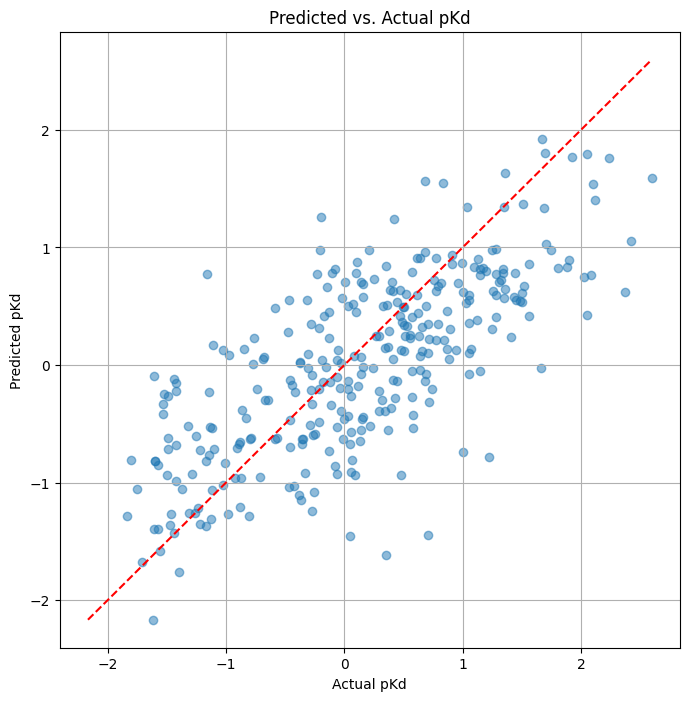

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(debug_model, test_loader, device='cpu')